# Event finder 

This notebook will find competitive cellular "events" in the simplest definition (i.e. a loser cell apoptosis) and return information about the spatiotemporal distrubition of counterpart competitive events (i.e. winner cell mitosis)

Contents:

- Load tracks
- Find apoptotic Scribble cell by surveying all Scribble cells for track duration and fate
- Calculate heatmap of a) probability of mitosis and b) number of mitosis
- Plot heatmaps
- Find single probabilty for wt mitosis for given radius and time away from Scribble apoptotic event
- Iterate over all Scribble cell apoptosis, calculating and plotting heatmap

To-do:

- [ ] Reorganise structure so that scan over all R then filter
- [ ] Create radial bins and sort tracks into them
- [ ] Create temporal bins
- [ ] Check redesigned script against raw data

### Functions to measure local neighbourhood for cells of interest

In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time

# def find_nearby_wt_mitosis(target_track, delta_t, radius):
#     frame = find_apoptosis_time(target_track, index = False) + delta_t 
#     dividing_states = ('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
#     wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]
#     wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
#     wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] in dividing_states]
    
#     return wt_tracks_in_radius, wt_mitosis_in_radius

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = find_apoptosis_time(target_track, index = False) + delta_t 
    dividing_states = ('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius if wt_track.label[wt_track.t.index(frame)] in dividing_states]
  
    return wt_tracks_in_radius, wt_mitosis_in_radius


def maximum_xyt(i):
    #### BEWARE xy coord switch!     
    if i == 'x':
        max_x = int((max([max(i.y) for i in wt_tracks])))
        return max_x
    if i == 'y':
        max_y = int((max([max(i.x) for i in wt_tracks])))
        return max_y
    if i == 't':
        max_t = int((max([max(i.t) for i in wt_tracks])))
        return max_t

In [3]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

version no.: 0.4.0


# expt area

In [10]:
len(find_nearby_wt_mitosis(target_track, 0, 100))

2

In [11]:
len(find_nearby_wt_mitosis_quick(target_track, 0, 100))

2

# Load data

In [4]:
filename ='/home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5'
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
print("Track information loaded")

[INFO][2020/12/06 04:41:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/06 04:41:10 PM] Loading tracks/obj_type_1
[INFO][2020/12/06 04:41:14 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/12/06 04:41:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/12/06 04:41:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/06 04:41:19 PM] Loading tracks/obj_type_2
[INFO][2020/12/06 04:41:19 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/12/06 04:41:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


# Scribble cell survey

#### Filter tracks to only include scr apoptosis and display info of scr apoptosis tracks

In [6]:
### scr_apop is all the scr tracks that have apoptosed
scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]
### this list comp shows scr cell IDs that have apoptosed and their length
[print("ID:", scr_track.ID, "Fate:", scr_track.fate.name, "length:", len(scr_track), "final time point:", scr_track.t[-1])  for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

ID: 1 Fate: APOPTOSIS length: 913 final time point: 912
ID: 3 Fate: APOPTOSIS length: 1176 final time point: 1175
ID: 4 Fate: APOPTOSIS length: 1175 final time point: 1174
ID: 6 Fate: APOPTOSIS length: 91 final time point: 91
ID: 10 Fate: APOPTOSIS length: 54 final time point: 171
ID: 11 Fate: APOPTOSIS length: 16 final time point: 175
ID: 16 Fate: APOPTOSIS length: 706 final time point: 1059
ID: 17 Fate: APOPTOSIS length: 388 final time point: 742
ID: 18 Fate: APOPTOSIS length: 199 final time point: 573
ID: 29 Fate: APOPTOSIS length: 349 final time point: 920
ID: 38 Fate: APOPTOSIS length: 3 final time point: 729
ID: 46 Fate: APOPTOSIS length: 7 final time point: 766
ID: 47 Fate: APOPTOSIS length: 167 final time point: 935
ID: 50 Fate: APOPTOSIS length: 371 final time point: 1175
ID: 54 Fate: APOPTOSIS length: 18 final time point: 900
ID: 56 Fate: APOPTOSIS length: 291 final time point: 1175
ID: 58 Fate: APOPTOSIS length: 289 final time point: 1175
ID: 60 Fate: APOPTOSIS length: 3 fin

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Isolating one track of interest

In [7]:
print("Input cell ID of interest")
cell_ID = int(input())
index = [i for i, scr_apop in enumerate(scr_apops) if scr_apop.ID == cell_ID][0]
target_track = scr_apops[index]##### Show the first classification of each track

Input cell ID of interest
17


#### check state classifications of this track

In [74]:
find_apoptosis_time(target_track, index = False)

505

In [63]:
target_track.label

['ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'INTERPHASE',
 'APOPTOSIS',
 'APOPTOSIS',
 'ANAPHASE',
 'ANAPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'INTERPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'PROMETAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHAS

In [64]:
target_track

OrderedDict([('ID', 18), ('t', [375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573]), ('x', [2.8306450843811035, 3.2571427822113037, 5.265017509460449, 6.153152942657471, 6.877005577087402, 7.149214744567871, 9.01455307006836, 10.155357360839844, 11.608177185058594, 12.429032325744629, 11.932119369506836, 10.569548606872559, 10.528881072998047, 11.318323135375977, 10.819012641906738, 9.769230842590332, 7.860986709594727, 7.761154651641846, 7.026881694793701, 6.518518447875977, 6.685929775238037, 8.35049057006836, 9.635293960571289, 11.15352725982666, 13.252854347229004, 14.473504066467285, 16.074020385742188, 18.504575729370117, 21.94700050354004, 18.386398315429688, 18.798063278198242, 18.98172378540039, 16.434492111206055, 16.37855339050293, 14.960100173950195, 15.799749374389648, 14.647868156433105, 12.849493026733398, 12.348066329956055, 13.419170379638672, 13.7313871383667, 13.334410667419434, 11.436521530151367, 9.480725288391113, 9.28637409210205, 8.731414794921875, 6.8312883377075195, 5.784246444702148, 6.626543045043945, 6.020547866821289, 6.188854694366455, 6.35215950012207, 5.836236953735352, 5.538461685180664, 5.11965799331665, 5.392727375030518, 5.519999980926514, 5.048583030700684, 3.5714285373687744, 3.3565890789031982, 4.891213417053223, 4.7832512855529785, 5.909420490264893, 6.6085524559021, 7.346820831298828, 7.415770530700684, 6.684615612030029, 5.622119903564453, 4.636363506317139, 5.1266374588012695, 4.849999904632568, 5.021186351776123, 5.351413726806641, 2.6416666507720947, 2.654135227203369, 3.309941530227661, 3.3628692626953125, 3.5374999046325684, 5.231197834014893, 8.36986255645752, 10.647446632385254, 12.518207550048828, 17.024784088134766, 19.982736587524414, 24.6547908782959, 24.383874893188477, 24.193435668945312, 21.33490562438965, 20.638954162597656, 22.046857833862305, 21.94420051574707, 23.06838607788086, 24.564346313476562, 23.305274963378906, 28.321308135986328, 33.681304931640625, 32.643863677978516, 34.502010345458984, 36.63490676879883, 38.983951568603516, 39.152000427246094, 38.654048919677734, 37.378211975097656, 36.56612014770508, 37.76742172241211, 38.388790130615234, 38.03132629394531, 37.777870178222656, 40.67147445678711, 40.45402145385742, 39.892921447753906, 39.26894760131836, 40.085296630859375, 38.08641052246094, 35.31439971923828, 40.257537841796875, 40.720237731933594, 44.625789642333984, 47.88532638549805, 49.16393280029297, 50.505130767822266, 51.54021072387695, 50.971885681152344, 52.17605209350586, 54.85880661010742, 53.24253845214844, 53.082088470458984, 52.66313552856445, 50.437198638916016, 39.90375900268555, 22.241851806640625, 31.32047462463379, 37.50235366821289, 47.85443115234375, 49.349727630615234, 58.950767517089844, 65.03768920898438, 61.06842041015625, 72.0, 80.71463775634766, 81.98863983154297, 65.77222442626953, 73.26012420654297, 75.05607604980469, 86.11445617675781, 82.53583526611328, 79.9278335571289, 83.41417694091797, 79.73880767822266, 69.95846557617188, 80.04615020751953, 83.08444213867188, 92.52830505371094, 88.4482727050781

# Find nearby cells 

# Calculate heatmap of probability surrounding one Scr apop event

In [65]:
print('Total calculation progress bar below (n/N radii and timepoints):')
radial_range = range(0,400)
time_range = range(-200, 200)
#time_range = range(-apop_time, max_t-apop_time) ## 1200 is the total frame number
probability = np.zeros((len(radial_range), len(time_range)))
gross_mitoses = np.zeros((len(radial_range), len(time_range)))
gross_wt = np.zeros((len(radial_range), len(time_range)))
#print(number.shape, data.shape)
for radius in tqdm(radial_range):
    for delta_t in tqdm(time_range):
        wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
        if len(wt_tracks_nearby) == 0:
            P_mitosis = 0
        else:
            P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
        if len(wt_mitosis_nearby)>0:
            print("Mitosis event(s) registered at t=", delta_t, "R=", radius, "IDs:", [wt.ID for wt in wt_mitosis_nearby])
        shift_t = delta_t + abs(min(time_range))
        probability[radius, shift_t] = P_mitosis
        gross_mitoses[radius, shift_t] = len(wt_mitosis_nearby)
        gross_wt[radius, shift_t] = len(wt_tracks_nearby)

Total calculation progress bar below (n/N radii and timepoints):


Mitosis event(s) registered at t= 116 R= 17 IDs: [639]



Mitosis event(s) registered at t= 32 R= 18 IDs: [396]
Mitosis event(s) registered at t= 115 R= 18 IDs: [639]
Mitosis event(s) registered at t= 116 R= 18 IDs: [639]
Mitosis event(s) registered at t= 117 R= 18 IDs: [639]
Mitosis event(s) registered at t= 118 R= 18 IDs: [639]



Mitosis event(s) registered at t= 32 R= 19 IDs: [396]
Mitosis event(s) registered at t= 50 R= 19 IDs: [396]
Mitosis event(s) registered at t= 115 R= 19 IDs: [639]
Mitosis event(s) registered at t= 116 R= 19 IDs: [639]
Mitosis event(s) registered at t= 117 R= 19 IDs: [639]
Mitosis event(s) registered at t= 118 R= 19 IDs: [639]



Mitosis event(s) registered at t= 32 R= 20 IDs: [396]
Mitosis event(s) registered at t= 49 R= 20 IDs: [396]
Mitosis event(s) registered at t= 50 R= 20 IDs: [396]
Mitosis event(s) registered at t= 114 R= 20 IDs: [639]
Mitosis event(s) registered at t= 115 R= 20 IDs: [639]
Mitosis event(s) registered at t= 116 R= 20 IDs: [639]
Mitosis event(s) registered at t= 117 R= 20 IDs: [639]
Mitosis event(s) registered at t= 118 R= 20 IDs: [639]



Mitosis event(s) registered at t= 32 R= 21 IDs: [396]
Mitosis event(s) registered at t= 33 R= 21 IDs: [396]
Mitosis event(s) registered at t= 49 R= 21 IDs: [396]
Mitosis event(s) registered at t= 50 R= 21 IDs: [396]
Mitosis event(s) registered at t= 114 R= 21 IDs: [639]
Mitosis event(s) registered at t= 115 R= 21 IDs: [639]
Mitosis event(s) registered at t= 116 R= 21 IDs: [639]
Mitosis event(s) registered at t= 117 R= 21 IDs: [639]
Mitosis event(s) registered at t= 118 R= 21 IDs: [639]
Mitosis event(s) registered at t= 119 R= 21 IDs: [639]



Mitosis event(s) registered at t= 32 R= 22 IDs: [396]
Mitosis event(s) registered at t= 33 R= 22 IDs: [396]
Mitosis event(s) registered at t= 34 R= 22 IDs: [396]
Mitosis event(s) registered at t= 40 R= 22 IDs: [396]
Mitosis event(s) registered at t= 47 R= 22 IDs: [396]
Mitosis event(s) registered at t= 49 R= 22 IDs: [396]
Mitosis event(s) registered at t= 50 R= 22 IDs: [396]
Mitosis event(s) registered at t= 114 R= 22 IDs: [639]
Mitosis event(s) registered at t= 115 R= 22 IDs: [639]
Mitosis event(s) registered at t= 116 R= 22 IDs: [639]
Mitosis event(s) registered at t= 117 R= 22 IDs: [639]
Mitosis event(s) registered at t= 118 R= 22 IDs: [639]
Mitosis event(s) registered at t= 119 R= 22 IDs: [639]
Mitosis event(s) registered at t= 180 R= 22 IDs: [802]



Mitosis event(s) registered at t= 32 R= 23 IDs: [396]
Mitosis event(s) registered at t= 33 R= 23 IDs: [396]
Mitosis event(s) registered at t= 34 R= 23 IDs: [396]
Mitosis event(s) registered at t= 35 R= 23 IDs: [396]
Mitosis event(s) registered at t= 39 R= 23 IDs: [396]
Mitosis event(s) registered at t= 40 R= 23 IDs: [396]
Mitosis event(s) registered at t= 41 R= 23 IDs: [396]
Mitosis event(s) registered at t= 42 R= 23 IDs: [396]
Mitosis event(s) registered at t= 43 R= 23 IDs: [396]
Mitosis event(s) registered at t= 44 R= 23 IDs: [396]
Mitosis event(s) registered at t= 45 R= 23 IDs: [396]
Mitosis event(s) registered at t= 46 R= 23 IDs: [396]
Mitosis event(s) registered at t= 47 R= 23 IDs: [396]
Mitosis event(s) registered at t= 49 R= 23 IDs: [396]
Mitosis event(s) registered at t= 50 R= 23 IDs: [396]
Mitosis event(s) registered at t= 114 R= 23 IDs: [639]
Mitosis event(s) registered at t= 115 R= 23 IDs: [639]
Mitosis event(s) registered at t= 116 R= 23 IDs: [639]
Mitosis event(s) register

Mitosis event(s) registered at t= 32 R= 24 IDs: [396]
Mitosis event(s) registered at t= 33 R= 24 IDs: [396]
Mitosis event(s) registered at t= 34 R= 24 IDs: [396]
Mitosis event(s) registered at t= 35 R= 24 IDs: [396]
Mitosis event(s) registered at t= 36 R= 24 IDs: [396]
Mitosis event(s) registered at t= 39 R= 24 IDs: [396]
Mitosis event(s) registered at t= 40 R= 24 IDs: [396]
Mitosis event(s) registered at t= 41 R= 24 IDs: [396]
Mitosis event(s) registered at t= 42 R= 24 IDs: [396]
Mitosis event(s) registered at t= 43 R= 24 IDs: [396]
Mitosis event(s) registered at t= 44 R= 24 IDs: [396]
Mitosis event(s) registered at t= 45 R= 24 IDs: [396]
Mitosis event(s) registered at t= 46 R= 24 IDs: [396]
Mitosis event(s) registered at t= 47 R= 24 IDs: [396]
Mitosis event(s) registered at t= 49 R= 24 IDs: [396]
Mitosis event(s) registered at t= 50 R= 24 IDs: [396]
Mitosis event(s) registered at t= 114 R= 24 IDs: [639]
Mitosis event(s) registered at t= 115 R= 24 IDs: [639]
Mitosis event(s) registere

Mitosis event(s) registered at t= 32 R= 25 IDs: [396]
Mitosis event(s) registered at t= 33 R= 25 IDs: [396]
Mitosis event(s) registered at t= 34 R= 25 IDs: [396]
Mitosis event(s) registered at t= 35 R= 25 IDs: [396]
Mitosis event(s) registered at t= 36 R= 25 IDs: [396]
Mitosis event(s) registered at t= 38 R= 25 IDs: [396]
Mitosis event(s) registered at t= 39 R= 25 IDs: [396]
Mitosis event(s) registered at t= 40 R= 25 IDs: [396]
Mitosis event(s) registered at t= 41 R= 25 IDs: [396]
Mitosis event(s) registered at t= 42 R= 25 IDs: [396]
Mitosis event(s) registered at t= 43 R= 25 IDs: [396]
Mitosis event(s) registered at t= 44 R= 25 IDs: [396]
Mitosis event(s) registered at t= 45 R= 25 IDs: [396]
Mitosis event(s) registered at t= 46 R= 25 IDs: [396]
Mitosis event(s) registered at t= 47 R= 25 IDs: [396]
Mitosis event(s) registered at t= 49 R= 25 IDs: [396]
Mitosis event(s) registered at t= 50 R= 25 IDs: [396]
Mitosis event(s) registered at t= 114 R= 25 IDs: [639]
Mitosis event(s) registered

Mitosis event(s) registered at t= 32 R= 26 IDs: [396]
Mitosis event(s) registered at t= 33 R= 26 IDs: [396]
Mitosis event(s) registered at t= 34 R= 26 IDs: [396]
Mitosis event(s) registered at t= 35 R= 26 IDs: [396]
Mitosis event(s) registered at t= 36 R= 26 IDs: [396]
Mitosis event(s) registered at t= 37 R= 26 IDs: [396]
Mitosis event(s) registered at t= 38 R= 26 IDs: [396]
Mitosis event(s) registered at t= 39 R= 26 IDs: [396]
Mitosis event(s) registered at t= 40 R= 26 IDs: [396]
Mitosis event(s) registered at t= 41 R= 26 IDs: [396]
Mitosis event(s) registered at t= 42 R= 26 IDs: [396]
Mitosis event(s) registered at t= 43 R= 26 IDs: [396]
Mitosis event(s) registered at t= 44 R= 26 IDs: [396]
Mitosis event(s) registered at t= 45 R= 26 IDs: [396]
Mitosis event(s) registered at t= 46 R= 26 IDs: [396]
Mitosis event(s) registered at t= 47 R= 26 IDs: [396]
Mitosis event(s) registered at t= 49 R= 26 IDs: [396]
Mitosis event(s) registered at t= 50 R= 26 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 27 IDs: [396]
Mitosis event(s) registered at t= 33 R= 27 IDs: [396]
Mitosis event(s) registered at t= 34 R= 27 IDs: [396]
Mitosis event(s) registered at t= 35 R= 27 IDs: [396]
Mitosis event(s) registered at t= 36 R= 27 IDs: [396]
Mitosis event(s) registered at t= 37 R= 27 IDs: [396]
Mitosis event(s) registered at t= 38 R= 27 IDs: [396]
Mitosis event(s) registered at t= 39 R= 27 IDs: [396]
Mitosis event(s) registered at t= 40 R= 27 IDs: [396]
Mitosis event(s) registered at t= 41 R= 27 IDs: [396]
Mitosis event(s) registered at t= 42 R= 27 IDs: [396]
Mitosis event(s) registered at t= 43 R= 27 IDs: [396]
Mitosis event(s) registered at t= 44 R= 27 IDs: [396]
Mitosis event(s) registered at t= 45 R= 27 IDs: [396]
Mitosis event(s) registered at t= 46 R= 27 IDs: [396]
Mitosis event(s) registered at t= 47 R= 27 IDs: [396]
Mitosis event(s) registered at t= 49 R= 27 IDs: [396]
Mitosis event(s) registered at t= 50 R= 27 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 28 IDs: [396]
Mitosis event(s) registered at t= 33 R= 28 IDs: [396]
Mitosis event(s) registered at t= 34 R= 28 IDs: [396]
Mitosis event(s) registered at t= 35 R= 28 IDs: [396]
Mitosis event(s) registered at t= 36 R= 28 IDs: [396]
Mitosis event(s) registered at t= 37 R= 28 IDs: [396]
Mitosis event(s) registered at t= 38 R= 28 IDs: [396]
Mitosis event(s) registered at t= 39 R= 28 IDs: [396]
Mitosis event(s) registered at t= 40 R= 28 IDs: [396]
Mitosis event(s) registered at t= 41 R= 28 IDs: [396]
Mitosis event(s) registered at t= 42 R= 28 IDs: [396]
Mitosis event(s) registered at t= 43 R= 28 IDs: [396]
Mitosis event(s) registered at t= 44 R= 28 IDs: [396]
Mitosis event(s) registered at t= 45 R= 28 IDs: [396]
Mitosis event(s) registered at t= 46 R= 28 IDs: [396]
Mitosis event(s) registered at t= 47 R= 28 IDs: [396]
Mitosis event(s) registered at t= 49 R= 28 IDs: [396]
Mitosis event(s) registered at t= 50 R= 28 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 29 IDs: [396]
Mitosis event(s) registered at t= 33 R= 29 IDs: [396]
Mitosis event(s) registered at t= 34 R= 29 IDs: [396]
Mitosis event(s) registered at t= 35 R= 29 IDs: [396]
Mitosis event(s) registered at t= 36 R= 29 IDs: [396]
Mitosis event(s) registered at t= 37 R= 29 IDs: [396]
Mitosis event(s) registered at t= 38 R= 29 IDs: [396]
Mitosis event(s) registered at t= 39 R= 29 IDs: [396]
Mitosis event(s) registered at t= 40 R= 29 IDs: [396]
Mitosis event(s) registered at t= 41 R= 29 IDs: [396]
Mitosis event(s) registered at t= 42 R= 29 IDs: [396]
Mitosis event(s) registered at t= 43 R= 29 IDs: [396]
Mitosis event(s) registered at t= 44 R= 29 IDs: [396]
Mitosis event(s) registered at t= 45 R= 29 IDs: [396]
Mitosis event(s) registered at t= 46 R= 29 IDs: [396]
Mitosis event(s) registered at t= 47 R= 29 IDs: [396]
Mitosis event(s) registered at t= 49 R= 29 IDs: [396]
Mitosis event(s) registered at t= 50 R= 29 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 30 IDs: [396]
Mitosis event(s) registered at t= 33 R= 30 IDs: [396]
Mitosis event(s) registered at t= 34 R= 30 IDs: [396]
Mitosis event(s) registered at t= 35 R= 30 IDs: [396]
Mitosis event(s) registered at t= 36 R= 30 IDs: [396]
Mitosis event(s) registered at t= 37 R= 30 IDs: [396]
Mitosis event(s) registered at t= 38 R= 30 IDs: [396]
Mitosis event(s) registered at t= 39 R= 30 IDs: [396]
Mitosis event(s) registered at t= 40 R= 30 IDs: [396]
Mitosis event(s) registered at t= 41 R= 30 IDs: [396]
Mitosis event(s) registered at t= 42 R= 30 IDs: [396]
Mitosis event(s) registered at t= 43 R= 30 IDs: [396]
Mitosis event(s) registered at t= 44 R= 30 IDs: [396]
Mitosis event(s) registered at t= 45 R= 30 IDs: [396]
Mitosis event(s) registered at t= 46 R= 30 IDs: [396]
Mitosis event(s) registered at t= 47 R= 30 IDs: [396]
Mitosis event(s) registered at t= 49 R= 30 IDs: [396]
Mitosis event(s) registered at t= 50 R= 30 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 31 IDs: [396]
Mitosis event(s) registered at t= 33 R= 31 IDs: [396]
Mitosis event(s) registered at t= 34 R= 31 IDs: [396]
Mitosis event(s) registered at t= 35 R= 31 IDs: [396]
Mitosis event(s) registered at t= 36 R= 31 IDs: [396]
Mitosis event(s) registered at t= 37 R= 31 IDs: [396]
Mitosis event(s) registered at t= 38 R= 31 IDs: [396]
Mitosis event(s) registered at t= 39 R= 31 IDs: [396]
Mitosis event(s) registered at t= 40 R= 31 IDs: [396]
Mitosis event(s) registered at t= 41 R= 31 IDs: [396]
Mitosis event(s) registered at t= 42 R= 31 IDs: [396]
Mitosis event(s) registered at t= 43 R= 31 IDs: [396]
Mitosis event(s) registered at t= 44 R= 31 IDs: [396]
Mitosis event(s) registered at t= 45 R= 31 IDs: [396]
Mitosis event(s) registered at t= 46 R= 31 IDs: [396]
Mitosis event(s) registered at t= 47 R= 31 IDs: [396]
Mitosis event(s) registered at t= 49 R= 31 IDs: [396]
Mitosis event(s) registered at t= 50 R= 31 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 32 IDs: [396]
Mitosis event(s) registered at t= 33 R= 32 IDs: [396]
Mitosis event(s) registered at t= 34 R= 32 IDs: [396]
Mitosis event(s) registered at t= 35 R= 32 IDs: [396]
Mitosis event(s) registered at t= 36 R= 32 IDs: [396]
Mitosis event(s) registered at t= 37 R= 32 IDs: [396]
Mitosis event(s) registered at t= 38 R= 32 IDs: [396]
Mitosis event(s) registered at t= 39 R= 32 IDs: [396]
Mitosis event(s) registered at t= 40 R= 32 IDs: [396]
Mitosis event(s) registered at t= 41 R= 32 IDs: [396]
Mitosis event(s) registered at t= 42 R= 32 IDs: [396]
Mitosis event(s) registered at t= 43 R= 32 IDs: [396]
Mitosis event(s) registered at t= 44 R= 32 IDs: [396]
Mitosis event(s) registered at t= 45 R= 32 IDs: [396]
Mitosis event(s) registered at t= 46 R= 32 IDs: [396]
Mitosis event(s) registered at t= 47 R= 32 IDs: [396]
Mitosis event(s) registered at t= 49 R= 32 IDs: [396]
Mitosis event(s) registered at t= 50 R= 32 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 33 IDs: [396]
Mitosis event(s) registered at t= 33 R= 33 IDs: [396]
Mitosis event(s) registered at t= 34 R= 33 IDs: [396]
Mitosis event(s) registered at t= 35 R= 33 IDs: [396]
Mitosis event(s) registered at t= 36 R= 33 IDs: [396]
Mitosis event(s) registered at t= 37 R= 33 IDs: [396]
Mitosis event(s) registered at t= 38 R= 33 IDs: [396]
Mitosis event(s) registered at t= 39 R= 33 IDs: [396]
Mitosis event(s) registered at t= 40 R= 33 IDs: [396]
Mitosis event(s) registered at t= 41 R= 33 IDs: [396]
Mitosis event(s) registered at t= 42 R= 33 IDs: [396]
Mitosis event(s) registered at t= 43 R= 33 IDs: [396]
Mitosis event(s) registered at t= 44 R= 33 IDs: [396]
Mitosis event(s) registered at t= 45 R= 33 IDs: [396]
Mitosis event(s) registered at t= 46 R= 33 IDs: [396]
Mitosis event(s) registered at t= 47 R= 33 IDs: [396]
Mitosis event(s) registered at t= 49 R= 33 IDs: [396]
Mitosis event(s) registered at t= 50 R= 33 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 34 IDs: [396]
Mitosis event(s) registered at t= 33 R= 34 IDs: [396]
Mitosis event(s) registered at t= 34 R= 34 IDs: [396]
Mitosis event(s) registered at t= 35 R= 34 IDs: [396]
Mitosis event(s) registered at t= 36 R= 34 IDs: [396]
Mitosis event(s) registered at t= 37 R= 34 IDs: [396]
Mitosis event(s) registered at t= 38 R= 34 IDs: [396]
Mitosis event(s) registered at t= 39 R= 34 IDs: [396]
Mitosis event(s) registered at t= 40 R= 34 IDs: [396]
Mitosis event(s) registered at t= 41 R= 34 IDs: [396]
Mitosis event(s) registered at t= 42 R= 34 IDs: [396]
Mitosis event(s) registered at t= 43 R= 34 IDs: [396]
Mitosis event(s) registered at t= 44 R= 34 IDs: [396]
Mitosis event(s) registered at t= 45 R= 34 IDs: [396]
Mitosis event(s) registered at t= 46 R= 34 IDs: [396]
Mitosis event(s) registered at t= 47 R= 34 IDs: [396]
Mitosis event(s) registered at t= 49 R= 34 IDs: [396]
Mitosis event(s) registered at t= 50 R= 34 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 35 IDs: [396]
Mitosis event(s) registered at t= 33 R= 35 IDs: [396]
Mitosis event(s) registered at t= 34 R= 35 IDs: [396]
Mitosis event(s) registered at t= 35 R= 35 IDs: [396]
Mitosis event(s) registered at t= 36 R= 35 IDs: [396]
Mitosis event(s) registered at t= 37 R= 35 IDs: [396]
Mitosis event(s) registered at t= 38 R= 35 IDs: [396]
Mitosis event(s) registered at t= 39 R= 35 IDs: [396]
Mitosis event(s) registered at t= 40 R= 35 IDs: [396]
Mitosis event(s) registered at t= 41 R= 35 IDs: [396]
Mitosis event(s) registered at t= 42 R= 35 IDs: [396]
Mitosis event(s) registered at t= 43 R= 35 IDs: [396]
Mitosis event(s) registered at t= 44 R= 35 IDs: [396]
Mitosis event(s) registered at t= 45 R= 35 IDs: [396]
Mitosis event(s) registered at t= 46 R= 35 IDs: [396]
Mitosis event(s) registered at t= 47 R= 35 IDs: [396]
Mitosis event(s) registered at t= 49 R= 35 IDs: [396]
Mitosis event(s) registered at t= 50 R= 35 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 36 IDs: [396]
Mitosis event(s) registered at t= 33 R= 36 IDs: [396]
Mitosis event(s) registered at t= 34 R= 36 IDs: [396]
Mitosis event(s) registered at t= 35 R= 36 IDs: [396]
Mitosis event(s) registered at t= 36 R= 36 IDs: [396]
Mitosis event(s) registered at t= 37 R= 36 IDs: [396]
Mitosis event(s) registered at t= 38 R= 36 IDs: [396]
Mitosis event(s) registered at t= 39 R= 36 IDs: [396]
Mitosis event(s) registered at t= 40 R= 36 IDs: [396]
Mitosis event(s) registered at t= 41 R= 36 IDs: [396]
Mitosis event(s) registered at t= 42 R= 36 IDs: [396]
Mitosis event(s) registered at t= 43 R= 36 IDs: [396]
Mitosis event(s) registered at t= 44 R= 36 IDs: [396]
Mitosis event(s) registered at t= 45 R= 36 IDs: [396]
Mitosis event(s) registered at t= 46 R= 36 IDs: [396]
Mitosis event(s) registered at t= 47 R= 36 IDs: [396]
Mitosis event(s) registered at t= 49 R= 36 IDs: [396]
Mitosis event(s) registered at t= 50 R= 36 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 37 IDs: [396]
Mitosis event(s) registered at t= 33 R= 37 IDs: [396]
Mitosis event(s) registered at t= 34 R= 37 IDs: [396]
Mitosis event(s) registered at t= 35 R= 37 IDs: [396]
Mitosis event(s) registered at t= 36 R= 37 IDs: [396]
Mitosis event(s) registered at t= 37 R= 37 IDs: [396]
Mitosis event(s) registered at t= 38 R= 37 IDs: [396]
Mitosis event(s) registered at t= 39 R= 37 IDs: [396]
Mitosis event(s) registered at t= 40 R= 37 IDs: [396]
Mitosis event(s) registered at t= 41 R= 37 IDs: [396]
Mitosis event(s) registered at t= 42 R= 37 IDs: [396]
Mitosis event(s) registered at t= 43 R= 37 IDs: [396]
Mitosis event(s) registered at t= 44 R= 37 IDs: [396]
Mitosis event(s) registered at t= 45 R= 37 IDs: [396]
Mitosis event(s) registered at t= 46 R= 37 IDs: [396]
Mitosis event(s) registered at t= 47 R= 37 IDs: [396]
Mitosis event(s) registered at t= 49 R= 37 IDs: [396]
Mitosis event(s) registered at t= 50 R= 37 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 38 IDs: [396]
Mitosis event(s) registered at t= 33 R= 38 IDs: [396]
Mitosis event(s) registered at t= 34 R= 38 IDs: [396]
Mitosis event(s) registered at t= 35 R= 38 IDs: [396]
Mitosis event(s) registered at t= 36 R= 38 IDs: [396]
Mitosis event(s) registered at t= 37 R= 38 IDs: [396]
Mitosis event(s) registered at t= 38 R= 38 IDs: [396]
Mitosis event(s) registered at t= 39 R= 38 IDs: [396]
Mitosis event(s) registered at t= 40 R= 38 IDs: [396]
Mitosis event(s) registered at t= 41 R= 38 IDs: [396]
Mitosis event(s) registered at t= 42 R= 38 IDs: [396]
Mitosis event(s) registered at t= 43 R= 38 IDs: [396]
Mitosis event(s) registered at t= 44 R= 38 IDs: [396]
Mitosis event(s) registered at t= 45 R= 38 IDs: [396]
Mitosis event(s) registered at t= 46 R= 38 IDs: [396]
Mitosis event(s) registered at t= 47 R= 38 IDs: [396]
Mitosis event(s) registered at t= 49 R= 38 IDs: [396]
Mitosis event(s) registered at t= 50 R= 38 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 32 R= 39 IDs: [396]
Mitosis event(s) registered at t= 33 R= 39 IDs: [396]
Mitosis event(s) registered at t= 34 R= 39 IDs: [396]
Mitosis event(s) registered at t= 35 R= 39 IDs: [396]
Mitosis event(s) registered at t= 36 R= 39 IDs: [396]
Mitosis event(s) registered at t= 37 R= 39 IDs: [396]
Mitosis event(s) registered at t= 38 R= 39 IDs: [396]
Mitosis event(s) registered at t= 39 R= 39 IDs: [396]
Mitosis event(s) registered at t= 40 R= 39 IDs: [396]
Mitosis event(s) registered at t= 41 R= 39 IDs: [396]
Mitosis event(s) registered at t= 42 R= 39 IDs: [396]
Mitosis event(s) registered at t= 43 R= 39 IDs: [396]
Mitosis event(s) registered at t= 44 R= 39 IDs: [396]
Mitosis event(s) registered at t= 45 R= 39 IDs: [396]
Mitosis event(s) registered at t= 46 R= 39 IDs: [396]
Mitosis event(s) registered at t= 47 R= 39 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 39 IDs: [396]
Mitosis event(s) registered at t= 50 R= 39 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 40 IDs: [396]
Mitosis event(s) registered at t= 33 R= 40 IDs: [396]
Mitosis event(s) registered at t= 34 R= 40 IDs: [396]
Mitosis event(s) registered at t= 35 R= 40 IDs: [396]
Mitosis event(s) registered at t= 36 R= 40 IDs: [396]
Mitosis event(s) registered at t= 37 R= 40 IDs: [396]
Mitosis event(s) registered at t= 38 R= 40 IDs: [396]
Mitosis event(s) registered at t= 39 R= 40 IDs: [396]
Mitosis event(s) registered at t= 40 R= 40 IDs: [396]
Mitosis event(s) registered at t= 41 R= 40 IDs: [396]
Mitosis event(s) registered at t= 42 R= 40 IDs: [396]
Mitosis event(s) registered at t= 43 R= 40 IDs: [396]
Mitosis event(s) registered at t= 44 R= 40 IDs: [396]
Mitosis event(s) registered at t= 45 R= 40 IDs: [396]
Mitosis event(s) registered at t= 46 R= 40 IDs: [396]
Mitosis event(s) registered at t= 47 R= 40 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 40 IDs: [396]
Mitosis event(s) registered at t= 50 R= 40 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 41 IDs: [396]
Mitosis event(s) registered at t= 33 R= 41 IDs: [396]
Mitosis event(s) registered at t= 34 R= 41 IDs: [396]
Mitosis event(s) registered at t= 35 R= 41 IDs: [396]
Mitosis event(s) registered at t= 36 R= 41 IDs: [396]
Mitosis event(s) registered at t= 37 R= 41 IDs: [396]
Mitosis event(s) registered at t= 38 R= 41 IDs: [396]
Mitosis event(s) registered at t= 39 R= 41 IDs: [396]
Mitosis event(s) registered at t= 40 R= 41 IDs: [396]
Mitosis event(s) registered at t= 41 R= 41 IDs: [396]
Mitosis event(s) registered at t= 42 R= 41 IDs: [396]
Mitosis event(s) registered at t= 43 R= 41 IDs: [396]
Mitosis event(s) registered at t= 44 R= 41 IDs: [396]
Mitosis event(s) registered at t= 45 R= 41 IDs: [396]
Mitosis event(s) registered at t= 46 R= 41 IDs: [396]
Mitosis event(s) registered at t= 47 R= 41 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 41 IDs: [396]
Mitosis event(s) registered at t= 50 R= 41 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 42 IDs: [396]
Mitosis event(s) registered at t= 33 R= 42 IDs: [396]
Mitosis event(s) registered at t= 34 R= 42 IDs: [396]
Mitosis event(s) registered at t= 35 R= 42 IDs: [396]
Mitosis event(s) registered at t= 36 R= 42 IDs: [396]
Mitosis event(s) registered at t= 37 R= 42 IDs: [396]
Mitosis event(s) registered at t= 38 R= 42 IDs: [396]
Mitosis event(s) registered at t= 39 R= 42 IDs: [396]
Mitosis event(s) registered at t= 40 R= 42 IDs: [396]
Mitosis event(s) registered at t= 41 R= 42 IDs: [396]
Mitosis event(s) registered at t= 42 R= 42 IDs: [396]
Mitosis event(s) registered at t= 43 R= 42 IDs: [396]
Mitosis event(s) registered at t= 44 R= 42 IDs: [396]
Mitosis event(s) registered at t= 45 R= 42 IDs: [396]
Mitosis event(s) registered at t= 46 R= 42 IDs: [396]
Mitosis event(s) registered at t= 47 R= 42 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 42 IDs: [396]
Mitosis event(s) registered at t= 50 R= 42 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 43 IDs: [396]
Mitosis event(s) registered at t= 33 R= 43 IDs: [396]
Mitosis event(s) registered at t= 34 R= 43 IDs: [396]
Mitosis event(s) registered at t= 35 R= 43 IDs: [396]
Mitosis event(s) registered at t= 36 R= 43 IDs: [396]
Mitosis event(s) registered at t= 37 R= 43 IDs: [396]
Mitosis event(s) registered at t= 38 R= 43 IDs: [396]
Mitosis event(s) registered at t= 39 R= 43 IDs: [396]
Mitosis event(s) registered at t= 40 R= 43 IDs: [396]
Mitosis event(s) registered at t= 41 R= 43 IDs: [396]
Mitosis event(s) registered at t= 42 R= 43 IDs: [396]
Mitosis event(s) registered at t= 43 R= 43 IDs: [396]
Mitosis event(s) registered at t= 44 R= 43 IDs: [396]
Mitosis event(s) registered at t= 45 R= 43 IDs: [396]
Mitosis event(s) registered at t= 46 R= 43 IDs: [396]
Mitosis event(s) registered at t= 47 R= 43 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 43 IDs: [396]
Mitosis event(s) registered at t= 50 R= 43 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 44 IDs: [396]
Mitosis event(s) registered at t= 33 R= 44 IDs: [396]
Mitosis event(s) registered at t= 34 R= 44 IDs: [396]
Mitosis event(s) registered at t= 35 R= 44 IDs: [396]
Mitosis event(s) registered at t= 36 R= 44 IDs: [396]
Mitosis event(s) registered at t= 37 R= 44 IDs: [396]
Mitosis event(s) registered at t= 38 R= 44 IDs: [396]
Mitosis event(s) registered at t= 39 R= 44 IDs: [396]
Mitosis event(s) registered at t= 40 R= 44 IDs: [396]
Mitosis event(s) registered at t= 41 R= 44 IDs: [396]
Mitosis event(s) registered at t= 42 R= 44 IDs: [396]
Mitosis event(s) registered at t= 43 R= 44 IDs: [396]
Mitosis event(s) registered at t= 44 R= 44 IDs: [396]
Mitosis event(s) registered at t= 45 R= 44 IDs: [396]
Mitosis event(s) registered at t= 46 R= 44 IDs: [396]
Mitosis event(s) registered at t= 47 R= 44 IDs: [300, 396]
Mitosis event(s) registered at t= 49 R= 44 IDs: [396]
Mitosis event(s) registered at t= 50 R= 44 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 45 IDs: [396]
Mitosis event(s) registered at t= 33 R= 45 IDs: [396]
Mitosis event(s) registered at t= 34 R= 45 IDs: [396]
Mitosis event(s) registered at t= 35 R= 45 IDs: [396]
Mitosis event(s) registered at t= 36 R= 45 IDs: [396]
Mitosis event(s) registered at t= 37 R= 45 IDs: [396]
Mitosis event(s) registered at t= 38 R= 45 IDs: [396]
Mitosis event(s) registered at t= 39 R= 45 IDs: [396]
Mitosis event(s) registered at t= 40 R= 45 IDs: [396]
Mitosis event(s) registered at t= 41 R= 45 IDs: [396]
Mitosis event(s) registered at t= 42 R= 45 IDs: [396]
Mitosis event(s) registered at t= 43 R= 45 IDs: [396]
Mitosis event(s) registered at t= 44 R= 45 IDs: [396]
Mitosis event(s) registered at t= 45 R= 45 IDs: [396]
Mitosis event(s) registered at t= 46 R= 45 IDs: [396]
Mitosis event(s) registered at t= 47 R= 45 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 45 IDs: [300]
Mitosis event(s) registered at t= 49 R= 45 IDs: [396]
Mitosis event(s) regist

Mitosis event(s) registered at t= 32 R= 46 IDs: [396]
Mitosis event(s) registered at t= 33 R= 46 IDs: [396]
Mitosis event(s) registered at t= 34 R= 46 IDs: [396]
Mitosis event(s) registered at t= 35 R= 46 IDs: [396]
Mitosis event(s) registered at t= 36 R= 46 IDs: [396]
Mitosis event(s) registered at t= 37 R= 46 IDs: [396]
Mitosis event(s) registered at t= 38 R= 46 IDs: [396]
Mitosis event(s) registered at t= 39 R= 46 IDs: [396]
Mitosis event(s) registered at t= 40 R= 46 IDs: [396]
Mitosis event(s) registered at t= 41 R= 46 IDs: [396]
Mitosis event(s) registered at t= 42 R= 46 IDs: [396]
Mitosis event(s) registered at t= 43 R= 46 IDs: [396]
Mitosis event(s) registered at t= 44 R= 46 IDs: [396]
Mitosis event(s) registered at t= 45 R= 46 IDs: [396]
Mitosis event(s) registered at t= 46 R= 46 IDs: [396]
Mitosis event(s) registered at t= 47 R= 46 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 46 IDs: [300]
Mitosis event(s) registered at t= 49 R= 46 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 47 IDs: [396]
Mitosis event(s) registered at t= 33 R= 47 IDs: [396]
Mitosis event(s) registered at t= 34 R= 47 IDs: [396]
Mitosis event(s) registered at t= 35 R= 47 IDs: [396]
Mitosis event(s) registered at t= 36 R= 47 IDs: [396]
Mitosis event(s) registered at t= 37 R= 47 IDs: [396]
Mitosis event(s) registered at t= 38 R= 47 IDs: [396]
Mitosis event(s) registered at t= 39 R= 47 IDs: [396]
Mitosis event(s) registered at t= 40 R= 47 IDs: [396]
Mitosis event(s) registered at t= 41 R= 47 IDs: [396]
Mitosis event(s) registered at t= 42 R= 47 IDs: [396]
Mitosis event(s) registered at t= 43 R= 47 IDs: [396]
Mitosis event(s) registered at t= 44 R= 47 IDs: [396]
Mitosis event(s) registered at t= 45 R= 47 IDs: [396]
Mitosis event(s) registered at t= 46 R= 47 IDs: [396]
Mitosis event(s) registered at t= 47 R= 47 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 47 IDs: [300]
Mitosis event(s) registered at t= 49 R= 47 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 48 IDs: [396]
Mitosis event(s) registered at t= 33 R= 48 IDs: [396]
Mitosis event(s) registered at t= 34 R= 48 IDs: [396]
Mitosis event(s) registered at t= 35 R= 48 IDs: [396]
Mitosis event(s) registered at t= 36 R= 48 IDs: [396]
Mitosis event(s) registered at t= 37 R= 48 IDs: [396]
Mitosis event(s) registered at t= 38 R= 48 IDs: [396]
Mitosis event(s) registered at t= 39 R= 48 IDs: [396]
Mitosis event(s) registered at t= 40 R= 48 IDs: [396]
Mitosis event(s) registered at t= 41 R= 48 IDs: [396]
Mitosis event(s) registered at t= 42 R= 48 IDs: [396]
Mitosis event(s) registered at t= 43 R= 48 IDs: [396]
Mitosis event(s) registered at t= 44 R= 48 IDs: [396]
Mitosis event(s) registered at t= 45 R= 48 IDs: [396]
Mitosis event(s) registered at t= 46 R= 48 IDs: [396]
Mitosis event(s) registered at t= 47 R= 48 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 48 IDs: [300]
Mitosis event(s) registered at t= 49 R= 48 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 49 IDs: [396]
Mitosis event(s) registered at t= 33 R= 49 IDs: [396]
Mitosis event(s) registered at t= 34 R= 49 IDs: [396]
Mitosis event(s) registered at t= 35 R= 49 IDs: [396]
Mitosis event(s) registered at t= 36 R= 49 IDs: [396]
Mitosis event(s) registered at t= 37 R= 49 IDs: [396]
Mitosis event(s) registered at t= 38 R= 49 IDs: [396]
Mitosis event(s) registered at t= 39 R= 49 IDs: [396]
Mitosis event(s) registered at t= 40 R= 49 IDs: [396]
Mitosis event(s) registered at t= 41 R= 49 IDs: [396]
Mitosis event(s) registered at t= 42 R= 49 IDs: [396]
Mitosis event(s) registered at t= 43 R= 49 IDs: [396]
Mitosis event(s) registered at t= 44 R= 49 IDs: [396]
Mitosis event(s) registered at t= 45 R= 49 IDs: [396]
Mitosis event(s) registered at t= 46 R= 49 IDs: [396]
Mitosis event(s) registered at t= 47 R= 49 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 49 IDs: [300]
Mitosis event(s) registered at t= 49 R= 49 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 50 IDs: [396]
Mitosis event(s) registered at t= 33 R= 50 IDs: [396]
Mitosis event(s) registered at t= 34 R= 50 IDs: [396]
Mitosis event(s) registered at t= 35 R= 50 IDs: [396]
Mitosis event(s) registered at t= 36 R= 50 IDs: [396]
Mitosis event(s) registered at t= 37 R= 50 IDs: [396]
Mitosis event(s) registered at t= 38 R= 50 IDs: [396]
Mitosis event(s) registered at t= 39 R= 50 IDs: [396]
Mitosis event(s) registered at t= 40 R= 50 IDs: [396]
Mitosis event(s) registered at t= 41 R= 50 IDs: [396]
Mitosis event(s) registered at t= 42 R= 50 IDs: [396]
Mitosis event(s) registered at t= 43 R= 50 IDs: [396]
Mitosis event(s) registered at t= 44 R= 50 IDs: [396]
Mitosis event(s) registered at t= 45 R= 50 IDs: [396]
Mitosis event(s) registered at t= 46 R= 50 IDs: [396]
Mitosis event(s) registered at t= 47 R= 50 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 50 IDs: [300]
Mitosis event(s) registered at t= 49 R= 50 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 51 IDs: [396]
Mitosis event(s) registered at t= 33 R= 51 IDs: [396]
Mitosis event(s) registered at t= 34 R= 51 IDs: [396]
Mitosis event(s) registered at t= 35 R= 51 IDs: [396]
Mitosis event(s) registered at t= 36 R= 51 IDs: [396]
Mitosis event(s) registered at t= 37 R= 51 IDs: [396]
Mitosis event(s) registered at t= 38 R= 51 IDs: [396]
Mitosis event(s) registered at t= 39 R= 51 IDs: [396]
Mitosis event(s) registered at t= 40 R= 51 IDs: [396]
Mitosis event(s) registered at t= 41 R= 51 IDs: [396]
Mitosis event(s) registered at t= 42 R= 51 IDs: [396]
Mitosis event(s) registered at t= 43 R= 51 IDs: [396]
Mitosis event(s) registered at t= 44 R= 51 IDs: [396]
Mitosis event(s) registered at t= 45 R= 51 IDs: [396]
Mitosis event(s) registered at t= 46 R= 51 IDs: [396]
Mitosis event(s) registered at t= 47 R= 51 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 51 IDs: [300]
Mitosis event(s) registered at t= 49 R= 51 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 52 IDs: [396]
Mitosis event(s) registered at t= 33 R= 52 IDs: [396]
Mitosis event(s) registered at t= 34 R= 52 IDs: [396]
Mitosis event(s) registered at t= 35 R= 52 IDs: [396]
Mitosis event(s) registered at t= 36 R= 52 IDs: [396]
Mitosis event(s) registered at t= 37 R= 52 IDs: [396]
Mitosis event(s) registered at t= 38 R= 52 IDs: [396]
Mitosis event(s) registered at t= 39 R= 52 IDs: [396]
Mitosis event(s) registered at t= 40 R= 52 IDs: [396]
Mitosis event(s) registered at t= 41 R= 52 IDs: [396]
Mitosis event(s) registered at t= 42 R= 52 IDs: [396]
Mitosis event(s) registered at t= 43 R= 52 IDs: [396]
Mitosis event(s) registered at t= 44 R= 52 IDs: [396]
Mitosis event(s) registered at t= 45 R= 52 IDs: [396]
Mitosis event(s) registered at t= 46 R= 52 IDs: [396]
Mitosis event(s) registered at t= 47 R= 52 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 52 IDs: [300]
Mitosis event(s) registered at t= 49 R= 52 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 53 IDs: [396]
Mitosis event(s) registered at t= 33 R= 53 IDs: [396]
Mitosis event(s) registered at t= 34 R= 53 IDs: [396]
Mitosis event(s) registered at t= 35 R= 53 IDs: [396]
Mitosis event(s) registered at t= 36 R= 53 IDs: [396]
Mitosis event(s) registered at t= 37 R= 53 IDs: [396]
Mitosis event(s) registered at t= 38 R= 53 IDs: [396]
Mitosis event(s) registered at t= 39 R= 53 IDs: [396]
Mitosis event(s) registered at t= 40 R= 53 IDs: [396]
Mitosis event(s) registered at t= 41 R= 53 IDs: [396]
Mitosis event(s) registered at t= 42 R= 53 IDs: [396]
Mitosis event(s) registered at t= 43 R= 53 IDs: [396]
Mitosis event(s) registered at t= 44 R= 53 IDs: [396]
Mitosis event(s) registered at t= 45 R= 53 IDs: [396]
Mitosis event(s) registered at t= 46 R= 53 IDs: [396]
Mitosis event(s) registered at t= 47 R= 53 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 53 IDs: [300]
Mitosis event(s) registered at t= 49 R= 53 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 54 IDs: [396]
Mitosis event(s) registered at t= 33 R= 54 IDs: [396]
Mitosis event(s) registered at t= 34 R= 54 IDs: [396]
Mitosis event(s) registered at t= 35 R= 54 IDs: [396]
Mitosis event(s) registered at t= 36 R= 54 IDs: [396]
Mitosis event(s) registered at t= 37 R= 54 IDs: [396]
Mitosis event(s) registered at t= 38 R= 54 IDs: [396]
Mitosis event(s) registered at t= 39 R= 54 IDs: [396]
Mitosis event(s) registered at t= 40 R= 54 IDs: [396]
Mitosis event(s) registered at t= 41 R= 54 IDs: [396]
Mitosis event(s) registered at t= 42 R= 54 IDs: [396]
Mitosis event(s) registered at t= 43 R= 54 IDs: [396]
Mitosis event(s) registered at t= 44 R= 54 IDs: [396]
Mitosis event(s) registered at t= 45 R= 54 IDs: [396]
Mitosis event(s) registered at t= 46 R= 54 IDs: [396]
Mitosis event(s) registered at t= 47 R= 54 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 54 IDs: [300]
Mitosis event(s) registered at t= 49 R= 54 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 55 IDs: [396]
Mitosis event(s) registered at t= 33 R= 55 IDs: [396]
Mitosis event(s) registered at t= 34 R= 55 IDs: [396]
Mitosis event(s) registered at t= 35 R= 55 IDs: [396]
Mitosis event(s) registered at t= 36 R= 55 IDs: [396]
Mitosis event(s) registered at t= 37 R= 55 IDs: [396]
Mitosis event(s) registered at t= 38 R= 55 IDs: [396]
Mitosis event(s) registered at t= 39 R= 55 IDs: [396]
Mitosis event(s) registered at t= 40 R= 55 IDs: [396]
Mitosis event(s) registered at t= 41 R= 55 IDs: [396]
Mitosis event(s) registered at t= 42 R= 55 IDs: [396]
Mitosis event(s) registered at t= 43 R= 55 IDs: [396]
Mitosis event(s) registered at t= 44 R= 55 IDs: [396]
Mitosis event(s) registered at t= 45 R= 55 IDs: [396]
Mitosis event(s) registered at t= 46 R= 55 IDs: [396]
Mitosis event(s) registered at t= 47 R= 55 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 55 IDs: [300]
Mitosis event(s) registered at t= 49 R= 55 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 56 IDs: [396]
Mitosis event(s) registered at t= 33 R= 56 IDs: [396]
Mitosis event(s) registered at t= 34 R= 56 IDs: [396]
Mitosis event(s) registered at t= 35 R= 56 IDs: [396]
Mitosis event(s) registered at t= 36 R= 56 IDs: [396]
Mitosis event(s) registered at t= 37 R= 56 IDs: [396]
Mitosis event(s) registered at t= 38 R= 56 IDs: [396]
Mitosis event(s) registered at t= 39 R= 56 IDs: [396]
Mitosis event(s) registered at t= 40 R= 56 IDs: [396]
Mitosis event(s) registered at t= 41 R= 56 IDs: [396]
Mitosis event(s) registered at t= 42 R= 56 IDs: [396]
Mitosis event(s) registered at t= 43 R= 56 IDs: [396]
Mitosis event(s) registered at t= 44 R= 56 IDs: [396]
Mitosis event(s) registered at t= 45 R= 56 IDs: [396]
Mitosis event(s) registered at t= 46 R= 56 IDs: [396]
Mitosis event(s) registered at t= 47 R= 56 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 56 IDs: [300]
Mitosis event(s) registered at t= 49 R= 56 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 57 IDs: [396]
Mitosis event(s) registered at t= 33 R= 57 IDs: [396]
Mitosis event(s) registered at t= 34 R= 57 IDs: [396]
Mitosis event(s) registered at t= 35 R= 57 IDs: [396]
Mitosis event(s) registered at t= 36 R= 57 IDs: [396]
Mitosis event(s) registered at t= 37 R= 57 IDs: [396]
Mitosis event(s) registered at t= 38 R= 57 IDs: [396]
Mitosis event(s) registered at t= 39 R= 57 IDs: [396]
Mitosis event(s) registered at t= 40 R= 57 IDs: [396]
Mitosis event(s) registered at t= 41 R= 57 IDs: [396]
Mitosis event(s) registered at t= 42 R= 57 IDs: [396]
Mitosis event(s) registered at t= 43 R= 57 IDs: [396]
Mitosis event(s) registered at t= 44 R= 57 IDs: [396]
Mitosis event(s) registered at t= 45 R= 57 IDs: [396]
Mitosis event(s) registered at t= 46 R= 57 IDs: [396]
Mitosis event(s) registered at t= 47 R= 57 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 57 IDs: [300]
Mitosis event(s) registered at t= 49 R= 57 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 58 IDs: [396]
Mitosis event(s) registered at t= 33 R= 58 IDs: [396]
Mitosis event(s) registered at t= 34 R= 58 IDs: [396]
Mitosis event(s) registered at t= 35 R= 58 IDs: [396]
Mitosis event(s) registered at t= 36 R= 58 IDs: [396]
Mitosis event(s) registered at t= 37 R= 58 IDs: [396]
Mitosis event(s) registered at t= 38 R= 58 IDs: [396]
Mitosis event(s) registered at t= 39 R= 58 IDs: [396]
Mitosis event(s) registered at t= 40 R= 58 IDs: [396]
Mitosis event(s) registered at t= 41 R= 58 IDs: [396]
Mitosis event(s) registered at t= 42 R= 58 IDs: [396]
Mitosis event(s) registered at t= 43 R= 58 IDs: [396]
Mitosis event(s) registered at t= 44 R= 58 IDs: [396]
Mitosis event(s) registered at t= 45 R= 58 IDs: [396]
Mitosis event(s) registered at t= 46 R= 58 IDs: [396]
Mitosis event(s) registered at t= 47 R= 58 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 58 IDs: [300]
Mitosis event(s) registered at t= 49 R= 58 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 59 IDs: [396]
Mitosis event(s) registered at t= 33 R= 59 IDs: [396]
Mitosis event(s) registered at t= 34 R= 59 IDs: [396]
Mitosis event(s) registered at t= 35 R= 59 IDs: [396]
Mitosis event(s) registered at t= 36 R= 59 IDs: [396]
Mitosis event(s) registered at t= 37 R= 59 IDs: [396]
Mitosis event(s) registered at t= 38 R= 59 IDs: [396]
Mitosis event(s) registered at t= 39 R= 59 IDs: [396]
Mitosis event(s) registered at t= 40 R= 59 IDs: [396]
Mitosis event(s) registered at t= 41 R= 59 IDs: [396]
Mitosis event(s) registered at t= 42 R= 59 IDs: [396]
Mitosis event(s) registered at t= 43 R= 59 IDs: [396]
Mitosis event(s) registered at t= 44 R= 59 IDs: [396]
Mitosis event(s) registered at t= 45 R= 59 IDs: [396]
Mitosis event(s) registered at t= 46 R= 59 IDs: [396]
Mitosis event(s) registered at t= 47 R= 59 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 59 IDs: [300]
Mitosis event(s) registered at t= 49 R= 59 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 60 IDs: [396]
Mitosis event(s) registered at t= 33 R= 60 IDs: [396]
Mitosis event(s) registered at t= 34 R= 60 IDs: [396]
Mitosis event(s) registered at t= 35 R= 60 IDs: [396]
Mitosis event(s) registered at t= 36 R= 60 IDs: [396]
Mitosis event(s) registered at t= 37 R= 60 IDs: [396]
Mitosis event(s) registered at t= 38 R= 60 IDs: [396]
Mitosis event(s) registered at t= 39 R= 60 IDs: [396]
Mitosis event(s) registered at t= 40 R= 60 IDs: [396]
Mitosis event(s) registered at t= 41 R= 60 IDs: [396]
Mitosis event(s) registered at t= 42 R= 60 IDs: [396]
Mitosis event(s) registered at t= 43 R= 60 IDs: [396]
Mitosis event(s) registered at t= 44 R= 60 IDs: [396]
Mitosis event(s) registered at t= 45 R= 60 IDs: [396]
Mitosis event(s) registered at t= 46 R= 60 IDs: [396]
Mitosis event(s) registered at t= 47 R= 60 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 60 IDs: [300]
Mitosis event(s) registered at t= 49 R= 60 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 61 IDs: [396]
Mitosis event(s) registered at t= 33 R= 61 IDs: [396]
Mitosis event(s) registered at t= 34 R= 61 IDs: [396]
Mitosis event(s) registered at t= 35 R= 61 IDs: [396]
Mitosis event(s) registered at t= 36 R= 61 IDs: [396]
Mitosis event(s) registered at t= 37 R= 61 IDs: [396]
Mitosis event(s) registered at t= 38 R= 61 IDs: [396]
Mitosis event(s) registered at t= 39 R= 61 IDs: [396]
Mitosis event(s) registered at t= 40 R= 61 IDs: [396]
Mitosis event(s) registered at t= 41 R= 61 IDs: [396]
Mitosis event(s) registered at t= 42 R= 61 IDs: [396]
Mitosis event(s) registered at t= 43 R= 61 IDs: [396]
Mitosis event(s) registered at t= 44 R= 61 IDs: [396]
Mitosis event(s) registered at t= 45 R= 61 IDs: [396]
Mitosis event(s) registered at t= 46 R= 61 IDs: [396]
Mitosis event(s) registered at t= 47 R= 61 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 61 IDs: [300]
Mitosis event(s) registered at t= 49 R= 61 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 62 IDs: [396]
Mitosis event(s) registered at t= 33 R= 62 IDs: [396]
Mitosis event(s) registered at t= 34 R= 62 IDs: [396]
Mitosis event(s) registered at t= 35 R= 62 IDs: [396]
Mitosis event(s) registered at t= 36 R= 62 IDs: [396]
Mitosis event(s) registered at t= 37 R= 62 IDs: [396]
Mitosis event(s) registered at t= 38 R= 62 IDs: [396]
Mitosis event(s) registered at t= 39 R= 62 IDs: [396]
Mitosis event(s) registered at t= 40 R= 62 IDs: [396]
Mitosis event(s) registered at t= 41 R= 62 IDs: [396]
Mitosis event(s) registered at t= 42 R= 62 IDs: [396]
Mitosis event(s) registered at t= 43 R= 62 IDs: [396]
Mitosis event(s) registered at t= 44 R= 62 IDs: [396]
Mitosis event(s) registered at t= 45 R= 62 IDs: [396]
Mitosis event(s) registered at t= 46 R= 62 IDs: [396]
Mitosis event(s) registered at t= 47 R= 62 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 62 IDs: [300]
Mitosis event(s) registered at t= 49 R= 62 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 63 IDs: [396]
Mitosis event(s) registered at t= 33 R= 63 IDs: [396]
Mitosis event(s) registered at t= 34 R= 63 IDs: [396]
Mitosis event(s) registered at t= 35 R= 63 IDs: [396]
Mitosis event(s) registered at t= 36 R= 63 IDs: [396]
Mitosis event(s) registered at t= 37 R= 63 IDs: [396]
Mitosis event(s) registered at t= 38 R= 63 IDs: [396]
Mitosis event(s) registered at t= 39 R= 63 IDs: [396]
Mitosis event(s) registered at t= 40 R= 63 IDs: [396]
Mitosis event(s) registered at t= 41 R= 63 IDs: [396]
Mitosis event(s) registered at t= 42 R= 63 IDs: [396]
Mitosis event(s) registered at t= 43 R= 63 IDs: [396]
Mitosis event(s) registered at t= 44 R= 63 IDs: [396]
Mitosis event(s) registered at t= 45 R= 63 IDs: [396]
Mitosis event(s) registered at t= 46 R= 63 IDs: [396]
Mitosis event(s) registered at t= 47 R= 63 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 63 IDs: [300]
Mitosis event(s) registered at t= 49 R= 63 IDs: [300, 396]
Mitosis event(s) r

Mitosis event(s) registered at t= 32 R= 64 IDs: [396]
Mitosis event(s) registered at t= 33 R= 64 IDs: [396]
Mitosis event(s) registered at t= 34 R= 64 IDs: [396]
Mitosis event(s) registered at t= 35 R= 64 IDs: [396]
Mitosis event(s) registered at t= 36 R= 64 IDs: [396]
Mitosis event(s) registered at t= 37 R= 64 IDs: [396]
Mitosis event(s) registered at t= 38 R= 64 IDs: [396]
Mitosis event(s) registered at t= 39 R= 64 IDs: [396]
Mitosis event(s) registered at t= 40 R= 64 IDs: [396]
Mitosis event(s) registered at t= 41 R= 64 IDs: [396]
Mitosis event(s) registered at t= 42 R= 64 IDs: [396]
Mitosis event(s) registered at t= 43 R= 64 IDs: [396]
Mitosis event(s) registered at t= 44 R= 64 IDs: [396]
Mitosis event(s) registered at t= 45 R= 64 IDs: [396]
Mitosis event(s) registered at t= 46 R= 64 IDs: [396]
Mitosis event(s) registered at t= 47 R= 64 IDs: [300, 396]
Mitosis event(s) registered at t= 48 R= 64 IDs: [300, 408]
Mitosis event(s) registered at t= 49 R= 64 IDs: [300, 396]
Mitosis event

Mitosis event(s) registered at t= 31 R= 65 IDs: [408]
Mitosis event(s) registered at t= 32 R= 65 IDs: [396]
Mitosis event(s) registered at t= 33 R= 65 IDs: [396]
Mitosis event(s) registered at t= 34 R= 65 IDs: [396]
Mitosis event(s) registered at t= 35 R= 65 IDs: [396]
Mitosis event(s) registered at t= 36 R= 65 IDs: [396]
Mitosis event(s) registered at t= 37 R= 65 IDs: [396]
Mitosis event(s) registered at t= 38 R= 65 IDs: [396]
Mitosis event(s) registered at t= 39 R= 65 IDs: [396]
Mitosis event(s) registered at t= 40 R= 65 IDs: [396]
Mitosis event(s) registered at t= 41 R= 65 IDs: [396]
Mitosis event(s) registered at t= 42 R= 65 IDs: [396]
Mitosis event(s) registered at t= 43 R= 65 IDs: [396]
Mitosis event(s) registered at t= 44 R= 65 IDs: [396]
Mitosis event(s) registered at t= 45 R= 65 IDs: [396]
Mitosis event(s) registered at t= 46 R= 65 IDs: [396]
Mitosis event(s) registered at t= 47 R= 65 IDs: [300, 396, 408]
Mitosis event(s) registered at t= 48 R= 65 IDs: [300, 408]
Mitosis event

Mitosis event(s) registered at t= 31 R= 66 IDs: [408]
Mitosis event(s) registered at t= 32 R= 66 IDs: [396]
Mitosis event(s) registered at t= 33 R= 66 IDs: [396]
Mitosis event(s) registered at t= 34 R= 66 IDs: [396]
Mitosis event(s) registered at t= 35 R= 66 IDs: [396]
Mitosis event(s) registered at t= 36 R= 66 IDs: [396]
Mitosis event(s) registered at t= 37 R= 66 IDs: [396]
Mitosis event(s) registered at t= 38 R= 66 IDs: [396]
Mitosis event(s) registered at t= 39 R= 66 IDs: [396]
Mitosis event(s) registered at t= 40 R= 66 IDs: [396]
Mitosis event(s) registered at t= 41 R= 66 IDs: [396]
Mitosis event(s) registered at t= 42 R= 66 IDs: [396]
Mitosis event(s) registered at t= 43 R= 66 IDs: [396]
Mitosis event(s) registered at t= 44 R= 66 IDs: [396]
Mitosis event(s) registered at t= 45 R= 66 IDs: [396]
Mitosis event(s) registered at t= 46 R= 66 IDs: [396]
Mitosis event(s) registered at t= 47 R= 66 IDs: [300, 396, 408]
Mitosis event(s) registered at t= 48 R= 66 IDs: [300, 408]
Mitosis event

Mitosis event(s) registered at t= 30 R= 67 IDs: [408]
Mitosis event(s) registered at t= 31 R= 67 IDs: [408]
Mitosis event(s) registered at t= 32 R= 67 IDs: [396]
Mitosis event(s) registered at t= 33 R= 67 IDs: [396]
Mitosis event(s) registered at t= 34 R= 67 IDs: [396]
Mitosis event(s) registered at t= 35 R= 67 IDs: [396]
Mitosis event(s) registered at t= 36 R= 67 IDs: [396]
Mitosis event(s) registered at t= 37 R= 67 IDs: [396]
Mitosis event(s) registered at t= 38 R= 67 IDs: [396]
Mitosis event(s) registered at t= 39 R= 67 IDs: [396]
Mitosis event(s) registered at t= 40 R= 67 IDs: [396]
Mitosis event(s) registered at t= 41 R= 67 IDs: [396]
Mitosis event(s) registered at t= 42 R= 67 IDs: [396]
Mitosis event(s) registered at t= 43 R= 67 IDs: [396]
Mitosis event(s) registered at t= 44 R= 67 IDs: [396]
Mitosis event(s) registered at t= 45 R= 67 IDs: [396]
Mitosis event(s) registered at t= 46 R= 67 IDs: [396]
Mitosis event(s) registered at t= 47 R= 67 IDs: [300, 396, 408]
Mitosis event(s) r

Mitosis event(s) registered at t= 29 R= 68 IDs: [408]
Mitosis event(s) registered at t= 30 R= 68 IDs: [408]
Mitosis event(s) registered at t= 31 R= 68 IDs: [408]
Mitosis event(s) registered at t= 32 R= 68 IDs: [396]
Mitosis event(s) registered at t= 33 R= 68 IDs: [396]
Mitosis event(s) registered at t= 34 R= 68 IDs: [396]
Mitosis event(s) registered at t= 35 R= 68 IDs: [396]
Mitosis event(s) registered at t= 36 R= 68 IDs: [396]
Mitosis event(s) registered at t= 37 R= 68 IDs: [396]
Mitosis event(s) registered at t= 38 R= 68 IDs: [396]
Mitosis event(s) registered at t= 39 R= 68 IDs: [396]
Mitosis event(s) registered at t= 40 R= 68 IDs: [396]
Mitosis event(s) registered at t= 41 R= 68 IDs: [396]
Mitosis event(s) registered at t= 42 R= 68 IDs: [396]
Mitosis event(s) registered at t= 43 R= 68 IDs: [396]
Mitosis event(s) registered at t= 44 R= 68 IDs: [396]
Mitosis event(s) registered at t= 45 R= 68 IDs: [396]
Mitosis event(s) registered at t= 46 R= 68 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 27 R= 69 IDs: [408]
Mitosis event(s) registered at t= 28 R= 69 IDs: [408]
Mitosis event(s) registered at t= 29 R= 69 IDs: [408]
Mitosis event(s) registered at t= 30 R= 69 IDs: [408]
Mitosis event(s) registered at t= 31 R= 69 IDs: [408]
Mitosis event(s) registered at t= 32 R= 69 IDs: [396]
Mitosis event(s) registered at t= 33 R= 69 IDs: [396]
Mitosis event(s) registered at t= 34 R= 69 IDs: [396]
Mitosis event(s) registered at t= 35 R= 69 IDs: [396]
Mitosis event(s) registered at t= 36 R= 69 IDs: [396]
Mitosis event(s) registered at t= 37 R= 69 IDs: [396]
Mitosis event(s) registered at t= 38 R= 69 IDs: [396]
Mitosis event(s) registered at t= 39 R= 69 IDs: [396]
Mitosis event(s) registered at t= 40 R= 69 IDs: [396]
Mitosis event(s) registered at t= 41 R= 69 IDs: [396]
Mitosis event(s) registered at t= 42 R= 69 IDs: [396]
Mitosis event(s) registered at t= 43 R= 69 IDs: [396]
Mitosis event(s) registered at t= 44 R= 69 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 27 R= 70 IDs: [408]
Mitosis event(s) registered at t= 28 R= 70 IDs: [408]
Mitosis event(s) registered at t= 29 R= 70 IDs: [408]
Mitosis event(s) registered at t= 30 R= 70 IDs: [408]
Mitosis event(s) registered at t= 31 R= 70 IDs: [408]
Mitosis event(s) registered at t= 32 R= 70 IDs: [396]
Mitosis event(s) registered at t= 33 R= 70 IDs: [396]
Mitosis event(s) registered at t= 34 R= 70 IDs: [396]
Mitosis event(s) registered at t= 35 R= 70 IDs: [396]
Mitosis event(s) registered at t= 36 R= 70 IDs: [396]
Mitosis event(s) registered at t= 37 R= 70 IDs: [396]
Mitosis event(s) registered at t= 38 R= 70 IDs: [396]
Mitosis event(s) registered at t= 39 R= 70 IDs: [396]
Mitosis event(s) registered at t= 40 R= 70 IDs: [396]
Mitosis event(s) registered at t= 41 R= 70 IDs: [396]
Mitosis event(s) registered at t= 42 R= 70 IDs: [396]
Mitosis event(s) registered at t= 43 R= 70 IDs: [396]
Mitosis event(s) registered at t= 44 R= 70 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 26 R= 71 IDs: [408]
Mitosis event(s) registered at t= 27 R= 71 IDs: [408]
Mitosis event(s) registered at t= 28 R= 71 IDs: [408]
Mitosis event(s) registered at t= 29 R= 71 IDs: [408]
Mitosis event(s) registered at t= 30 R= 71 IDs: [408]
Mitosis event(s) registered at t= 31 R= 71 IDs: [408]
Mitosis event(s) registered at t= 32 R= 71 IDs: [396]
Mitosis event(s) registered at t= 33 R= 71 IDs: [396]
Mitosis event(s) registered at t= 34 R= 71 IDs: [396]
Mitosis event(s) registered at t= 35 R= 71 IDs: [396]
Mitosis event(s) registered at t= 36 R= 71 IDs: [396]
Mitosis event(s) registered at t= 37 R= 71 IDs: [396]
Mitosis event(s) registered at t= 38 R= 71 IDs: [396]
Mitosis event(s) registered at t= 39 R= 71 IDs: [396]
Mitosis event(s) registered at t= 40 R= 71 IDs: [396]
Mitosis event(s) registered at t= 41 R= 71 IDs: [396]
Mitosis event(s) registered at t= 42 R= 71 IDs: [396]
Mitosis event(s) registered at t= 43 R= 71 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 72 IDs: [408]
Mitosis event(s) registered at t= 26 R= 72 IDs: [408]
Mitosis event(s) registered at t= 27 R= 72 IDs: [408]
Mitosis event(s) registered at t= 28 R= 72 IDs: [408]
Mitosis event(s) registered at t= 29 R= 72 IDs: [408]
Mitosis event(s) registered at t= 30 R= 72 IDs: [408]
Mitosis event(s) registered at t= 31 R= 72 IDs: [408]
Mitosis event(s) registered at t= 32 R= 72 IDs: [396]
Mitosis event(s) registered at t= 33 R= 72 IDs: [396]
Mitosis event(s) registered at t= 34 R= 72 IDs: [396]
Mitosis event(s) registered at t= 35 R= 72 IDs: [396]
Mitosis event(s) registered at t= 36 R= 72 IDs: [396]
Mitosis event(s) registered at t= 37 R= 72 IDs: [396]
Mitosis event(s) registered at t= 38 R= 72 IDs: [396]
Mitosis event(s) registered at t= 39 R= 72 IDs: [396]
Mitosis event(s) registered at t= 40 R= 72 IDs: [396]
Mitosis event(s) registered at t= 41 R= 72 IDs: [396]
Mitosis event(s) registered at t= 42 R= 72 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 73 IDs: [408]
Mitosis event(s) registered at t= 25 R= 73 IDs: [408]
Mitosis event(s) registered at t= 26 R= 73 IDs: [408]
Mitosis event(s) registered at t= 27 R= 73 IDs: [408]
Mitosis event(s) registered at t= 28 R= 73 IDs: [408]
Mitosis event(s) registered at t= 29 R= 73 IDs: [408]
Mitosis event(s) registered at t= 30 R= 73 IDs: [408]
Mitosis event(s) registered at t= 31 R= 73 IDs: [408]
Mitosis event(s) registered at t= 32 R= 73 IDs: [396]
Mitosis event(s) registered at t= 33 R= 73 IDs: [396]
Mitosis event(s) registered at t= 34 R= 73 IDs: [396]
Mitosis event(s) registered at t= 35 R= 73 IDs: [396]
Mitosis event(s) registered at t= 36 R= 73 IDs: [396]
Mitosis event(s) registered at t= 37 R= 73 IDs: [396]
Mitosis event(s) registered at t= 38 R= 73 IDs: [396]
Mitosis event(s) registered at t= 39 R= 73 IDs: [396]
Mitosis event(s) registered at t= 40 R= 73 IDs: [396]
Mitosis event(s) registered at t= 41 R= 73 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 74 IDs: [408]
Mitosis event(s) registered at t= 25 R= 74 IDs: [408]
Mitosis event(s) registered at t= 26 R= 74 IDs: [408]
Mitosis event(s) registered at t= 27 R= 74 IDs: [408]
Mitosis event(s) registered at t= 28 R= 74 IDs: [408]
Mitosis event(s) registered at t= 29 R= 74 IDs: [408]
Mitosis event(s) registered at t= 30 R= 74 IDs: [408]
Mitosis event(s) registered at t= 31 R= 74 IDs: [408]
Mitosis event(s) registered at t= 32 R= 74 IDs: [396]
Mitosis event(s) registered at t= 33 R= 74 IDs: [396]
Mitosis event(s) registered at t= 34 R= 74 IDs: [396]
Mitosis event(s) registered at t= 35 R= 74 IDs: [396]
Mitosis event(s) registered at t= 36 R= 74 IDs: [396]
Mitosis event(s) registered at t= 37 R= 74 IDs: [396]
Mitosis event(s) registered at t= 38 R= 74 IDs: [396]
Mitosis event(s) registered at t= 39 R= 74 IDs: [396]
Mitosis event(s) registered at t= 40 R= 74 IDs: [396]
Mitosis event(s) registered at t= 41 R= 74 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 75 IDs: [408]
Mitosis event(s) registered at t= 25 R= 75 IDs: [408]
Mitosis event(s) registered at t= 26 R= 75 IDs: [408]
Mitosis event(s) registered at t= 27 R= 75 IDs: [408]
Mitosis event(s) registered at t= 28 R= 75 IDs: [408]
Mitosis event(s) registered at t= 29 R= 75 IDs: [408]
Mitosis event(s) registered at t= 30 R= 75 IDs: [408]
Mitosis event(s) registered at t= 31 R= 75 IDs: [408]
Mitosis event(s) registered at t= 32 R= 75 IDs: [396]
Mitosis event(s) registered at t= 33 R= 75 IDs: [396]
Mitosis event(s) registered at t= 34 R= 75 IDs: [396]
Mitosis event(s) registered at t= 35 R= 75 IDs: [396]
Mitosis event(s) registered at t= 36 R= 75 IDs: [396]
Mitosis event(s) registered at t= 37 R= 75 IDs: [396]
Mitosis event(s) registered at t= 38 R= 75 IDs: [396]
Mitosis event(s) registered at t= 39 R= 75 IDs: [396]
Mitosis event(s) registered at t= 40 R= 75 IDs: [396]
Mitosis event(s) registered at t= 41 R= 75 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 76 IDs: [408]
Mitosis event(s) registered at t= 25 R= 76 IDs: [408]
Mitosis event(s) registered at t= 26 R= 76 IDs: [408]
Mitosis event(s) registered at t= 27 R= 76 IDs: [408]
Mitosis event(s) registered at t= 28 R= 76 IDs: [408]
Mitosis event(s) registered at t= 29 R= 76 IDs: [408]
Mitosis event(s) registered at t= 30 R= 76 IDs: [408]
Mitosis event(s) registered at t= 31 R= 76 IDs: [408]
Mitosis event(s) registered at t= 32 R= 76 IDs: [396]
Mitosis event(s) registered at t= 33 R= 76 IDs: [396]
Mitosis event(s) registered at t= 34 R= 76 IDs: [396]
Mitosis event(s) registered at t= 35 R= 76 IDs: [396]
Mitosis event(s) registered at t= 36 R= 76 IDs: [396]
Mitosis event(s) registered at t= 37 R= 76 IDs: [396]
Mitosis event(s) registered at t= 38 R= 76 IDs: [396]
Mitosis event(s) registered at t= 39 R= 76 IDs: [396]
Mitosis event(s) registered at t= 40 R= 76 IDs: [396]
Mitosis event(s) registered at t= 41 R= 76 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 77 IDs: [408]
Mitosis event(s) registered at t= 25 R= 77 IDs: [408]
Mitosis event(s) registered at t= 26 R= 77 IDs: [408]
Mitosis event(s) registered at t= 27 R= 77 IDs: [408]
Mitosis event(s) registered at t= 28 R= 77 IDs: [408]
Mitosis event(s) registered at t= 29 R= 77 IDs: [408]
Mitosis event(s) registered at t= 30 R= 77 IDs: [408]
Mitosis event(s) registered at t= 31 R= 77 IDs: [408]
Mitosis event(s) registered at t= 32 R= 77 IDs: [396]
Mitosis event(s) registered at t= 33 R= 77 IDs: [396]
Mitosis event(s) registered at t= 34 R= 77 IDs: [396]
Mitosis event(s) registered at t= 35 R= 77 IDs: [396]
Mitosis event(s) registered at t= 36 R= 77 IDs: [396]
Mitosis event(s) registered at t= 37 R= 77 IDs: [396]
Mitosis event(s) registered at t= 38 R= 77 IDs: [396]
Mitosis event(s) registered at t= 39 R= 77 IDs: [396]
Mitosis event(s) registered at t= 40 R= 77 IDs: [396]
Mitosis event(s) registered at t= 41 R= 77 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 78 IDs: [408]
Mitosis event(s) registered at t= 25 R= 78 IDs: [408]
Mitosis event(s) registered at t= 26 R= 78 IDs: [408]
Mitosis event(s) registered at t= 27 R= 78 IDs: [408]
Mitosis event(s) registered at t= 28 R= 78 IDs: [408]
Mitosis event(s) registered at t= 29 R= 78 IDs: [408]
Mitosis event(s) registered at t= 30 R= 78 IDs: [408]
Mitosis event(s) registered at t= 31 R= 78 IDs: [408]
Mitosis event(s) registered at t= 32 R= 78 IDs: [396]
Mitosis event(s) registered at t= 33 R= 78 IDs: [396]
Mitosis event(s) registered at t= 34 R= 78 IDs: [396]
Mitosis event(s) registered at t= 35 R= 78 IDs: [396]
Mitosis event(s) registered at t= 36 R= 78 IDs: [396]
Mitosis event(s) registered at t= 37 R= 78 IDs: [396]
Mitosis event(s) registered at t= 38 R= 78 IDs: [396]
Mitosis event(s) registered at t= 39 R= 78 IDs: [396]
Mitosis event(s) registered at t= 40 R= 78 IDs: [396]
Mitosis event(s) registered at t= 41 R= 78 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 79 IDs: [408]
Mitosis event(s) registered at t= 25 R= 79 IDs: [408]
Mitosis event(s) registered at t= 26 R= 79 IDs: [408]
Mitosis event(s) registered at t= 27 R= 79 IDs: [408]
Mitosis event(s) registered at t= 28 R= 79 IDs: [408]
Mitosis event(s) registered at t= 29 R= 79 IDs: [408]
Mitosis event(s) registered at t= 30 R= 79 IDs: [408]
Mitosis event(s) registered at t= 31 R= 79 IDs: [408]
Mitosis event(s) registered at t= 32 R= 79 IDs: [396]
Mitosis event(s) registered at t= 33 R= 79 IDs: [396]
Mitosis event(s) registered at t= 34 R= 79 IDs: [396]
Mitosis event(s) registered at t= 35 R= 79 IDs: [396]
Mitosis event(s) registered at t= 36 R= 79 IDs: [396]
Mitosis event(s) registered at t= 37 R= 79 IDs: [396]
Mitosis event(s) registered at t= 38 R= 79 IDs: [396]
Mitosis event(s) registered at t= 39 R= 79 IDs: [396]
Mitosis event(s) registered at t= 40 R= 79 IDs: [396]
Mitosis event(s) registered at t= 41 R= 79 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 80 IDs: [408]
Mitosis event(s) registered at t= 25 R= 80 IDs: [408]
Mitosis event(s) registered at t= 26 R= 80 IDs: [408]
Mitosis event(s) registered at t= 27 R= 80 IDs: [408]
Mitosis event(s) registered at t= 28 R= 80 IDs: [408]
Mitosis event(s) registered at t= 29 R= 80 IDs: [408]
Mitosis event(s) registered at t= 30 R= 80 IDs: [408]
Mitosis event(s) registered at t= 31 R= 80 IDs: [408]
Mitosis event(s) registered at t= 32 R= 80 IDs: [396]
Mitosis event(s) registered at t= 33 R= 80 IDs: [396]
Mitosis event(s) registered at t= 34 R= 80 IDs: [396]
Mitosis event(s) registered at t= 35 R= 80 IDs: [396]
Mitosis event(s) registered at t= 36 R= 80 IDs: [396]
Mitosis event(s) registered at t= 37 R= 80 IDs: [396]
Mitosis event(s) registered at t= 38 R= 80 IDs: [396]
Mitosis event(s) registered at t= 39 R= 80 IDs: [396]
Mitosis event(s) registered at t= 40 R= 80 IDs: [396]
Mitosis event(s) registered at t= 41 R= 80 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 81 IDs: [408]
Mitosis event(s) registered at t= 25 R= 81 IDs: [408]
Mitosis event(s) registered at t= 26 R= 81 IDs: [408]
Mitosis event(s) registered at t= 27 R= 81 IDs: [408]
Mitosis event(s) registered at t= 28 R= 81 IDs: [408]
Mitosis event(s) registered at t= 29 R= 81 IDs: [408]
Mitosis event(s) registered at t= 30 R= 81 IDs: [408]
Mitosis event(s) registered at t= 31 R= 81 IDs: [408]
Mitosis event(s) registered at t= 32 R= 81 IDs: [396]
Mitosis event(s) registered at t= 33 R= 81 IDs: [396]
Mitosis event(s) registered at t= 34 R= 81 IDs: [396]
Mitosis event(s) registered at t= 35 R= 81 IDs: [396]
Mitosis event(s) registered at t= 36 R= 81 IDs: [396]
Mitosis event(s) registered at t= 37 R= 81 IDs: [396]
Mitosis event(s) registered at t= 38 R= 81 IDs: [396]
Mitosis event(s) registered at t= 39 R= 81 IDs: [396]
Mitosis event(s) registered at t= 40 R= 81 IDs: [396]
Mitosis event(s) registered at t= 41 R= 81 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 82 IDs: [408]
Mitosis event(s) registered at t= 25 R= 82 IDs: [408]
Mitosis event(s) registered at t= 26 R= 82 IDs: [408]
Mitosis event(s) registered at t= 27 R= 82 IDs: [408]
Mitosis event(s) registered at t= 28 R= 82 IDs: [408]
Mitosis event(s) registered at t= 29 R= 82 IDs: [408]
Mitosis event(s) registered at t= 30 R= 82 IDs: [408]
Mitosis event(s) registered at t= 31 R= 82 IDs: [408]
Mitosis event(s) registered at t= 32 R= 82 IDs: [396]
Mitosis event(s) registered at t= 33 R= 82 IDs: [396]
Mitosis event(s) registered at t= 34 R= 82 IDs: [396]
Mitosis event(s) registered at t= 35 R= 82 IDs: [396]
Mitosis event(s) registered at t= 36 R= 82 IDs: [396]
Mitosis event(s) registered at t= 37 R= 82 IDs: [396]
Mitosis event(s) registered at t= 38 R= 82 IDs: [396]
Mitosis event(s) registered at t= 39 R= 82 IDs: [396]
Mitosis event(s) registered at t= 40 R= 82 IDs: [396]
Mitosis event(s) registered at t= 41 R= 82 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 83 IDs: [408]
Mitosis event(s) registered at t= 25 R= 83 IDs: [408]
Mitosis event(s) registered at t= 26 R= 83 IDs: [408]
Mitosis event(s) registered at t= 27 R= 83 IDs: [408]
Mitosis event(s) registered at t= 28 R= 83 IDs: [408]
Mitosis event(s) registered at t= 29 R= 83 IDs: [408]
Mitosis event(s) registered at t= 30 R= 83 IDs: [408]
Mitosis event(s) registered at t= 31 R= 83 IDs: [408]
Mitosis event(s) registered at t= 32 R= 83 IDs: [396]
Mitosis event(s) registered at t= 33 R= 83 IDs: [396]
Mitosis event(s) registered at t= 34 R= 83 IDs: [396]
Mitosis event(s) registered at t= 35 R= 83 IDs: [396]
Mitosis event(s) registered at t= 36 R= 83 IDs: [396]
Mitosis event(s) registered at t= 37 R= 83 IDs: [396]
Mitosis event(s) registered at t= 38 R= 83 IDs: [396]
Mitosis event(s) registered at t= 39 R= 83 IDs: [396]
Mitosis event(s) registered at t= 40 R= 83 IDs: [396]
Mitosis event(s) registered at t= 41 R= 83 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 84 IDs: [408]
Mitosis event(s) registered at t= 25 R= 84 IDs: [408]
Mitosis event(s) registered at t= 26 R= 84 IDs: [408]
Mitosis event(s) registered at t= 27 R= 84 IDs: [408]
Mitosis event(s) registered at t= 28 R= 84 IDs: [408]
Mitosis event(s) registered at t= 29 R= 84 IDs: [408]
Mitosis event(s) registered at t= 30 R= 84 IDs: [408]
Mitosis event(s) registered at t= 31 R= 84 IDs: [408]
Mitosis event(s) registered at t= 32 R= 84 IDs: [396]
Mitosis event(s) registered at t= 33 R= 84 IDs: [396]
Mitosis event(s) registered at t= 34 R= 84 IDs: [396]
Mitosis event(s) registered at t= 35 R= 84 IDs: [396]
Mitosis event(s) registered at t= 36 R= 84 IDs: [396]
Mitosis event(s) registered at t= 37 R= 84 IDs: [396]
Mitosis event(s) registered at t= 38 R= 84 IDs: [396]
Mitosis event(s) registered at t= 39 R= 84 IDs: [396]
Mitosis event(s) registered at t= 40 R= 84 IDs: [396]
Mitosis event(s) registered at t= 41 R= 84 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 85 IDs: [408]
Mitosis event(s) registered at t= 25 R= 85 IDs: [408]
Mitosis event(s) registered at t= 26 R= 85 IDs: [408]
Mitosis event(s) registered at t= 27 R= 85 IDs: [408]
Mitosis event(s) registered at t= 28 R= 85 IDs: [408]
Mitosis event(s) registered at t= 29 R= 85 IDs: [408]
Mitosis event(s) registered at t= 30 R= 85 IDs: [408]
Mitosis event(s) registered at t= 31 R= 85 IDs: [408]
Mitosis event(s) registered at t= 32 R= 85 IDs: [396]
Mitosis event(s) registered at t= 33 R= 85 IDs: [396]
Mitosis event(s) registered at t= 34 R= 85 IDs: [396]
Mitosis event(s) registered at t= 35 R= 85 IDs: [396]
Mitosis event(s) registered at t= 36 R= 85 IDs: [396]
Mitosis event(s) registered at t= 37 R= 85 IDs: [396]
Mitosis event(s) registered at t= 38 R= 85 IDs: [396]
Mitosis event(s) registered at t= 39 R= 85 IDs: [396]
Mitosis event(s) registered at t= 40 R= 85 IDs: [396]
Mitosis event(s) registered at t= 41 R= 85 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 86 IDs: [408]
Mitosis event(s) registered at t= 25 R= 86 IDs: [408]
Mitosis event(s) registered at t= 26 R= 86 IDs: [408]
Mitosis event(s) registered at t= 27 R= 86 IDs: [408]
Mitosis event(s) registered at t= 28 R= 86 IDs: [408]
Mitosis event(s) registered at t= 29 R= 86 IDs: [408]
Mitosis event(s) registered at t= 30 R= 86 IDs: [408]
Mitosis event(s) registered at t= 31 R= 86 IDs: [408]
Mitosis event(s) registered at t= 32 R= 86 IDs: [396]
Mitosis event(s) registered at t= 33 R= 86 IDs: [396]
Mitosis event(s) registered at t= 34 R= 86 IDs: [396]
Mitosis event(s) registered at t= 35 R= 86 IDs: [396]
Mitosis event(s) registered at t= 36 R= 86 IDs: [396]
Mitosis event(s) registered at t= 37 R= 86 IDs: [396]
Mitosis event(s) registered at t= 38 R= 86 IDs: [396]
Mitosis event(s) registered at t= 39 R= 86 IDs: [396]
Mitosis event(s) registered at t= 40 R= 86 IDs: [396]
Mitosis event(s) registered at t= 41 R= 86 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 87 IDs: [408]
Mitosis event(s) registered at t= 25 R= 87 IDs: [408]
Mitosis event(s) registered at t= 26 R= 87 IDs: [408]
Mitosis event(s) registered at t= 27 R= 87 IDs: [408]
Mitosis event(s) registered at t= 28 R= 87 IDs: [408]
Mitosis event(s) registered at t= 29 R= 87 IDs: [408]
Mitosis event(s) registered at t= 30 R= 87 IDs: [408]
Mitosis event(s) registered at t= 31 R= 87 IDs: [408]
Mitosis event(s) registered at t= 32 R= 87 IDs: [396]
Mitosis event(s) registered at t= 33 R= 87 IDs: [396]
Mitosis event(s) registered at t= 34 R= 87 IDs: [396]
Mitosis event(s) registered at t= 35 R= 87 IDs: [396]
Mitosis event(s) registered at t= 36 R= 87 IDs: [396]
Mitosis event(s) registered at t= 37 R= 87 IDs: [396]
Mitosis event(s) registered at t= 38 R= 87 IDs: [396]
Mitosis event(s) registered at t= 39 R= 87 IDs: [396]
Mitosis event(s) registered at t= 40 R= 87 IDs: [396]
Mitosis event(s) registered at t= 41 R= 87 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 88 IDs: [408]
Mitosis event(s) registered at t= 25 R= 88 IDs: [408]
Mitosis event(s) registered at t= 26 R= 88 IDs: [408]
Mitosis event(s) registered at t= 27 R= 88 IDs: [408]
Mitosis event(s) registered at t= 28 R= 88 IDs: [408]
Mitosis event(s) registered at t= 29 R= 88 IDs: [408]
Mitosis event(s) registered at t= 30 R= 88 IDs: [408]
Mitosis event(s) registered at t= 31 R= 88 IDs: [408]
Mitosis event(s) registered at t= 32 R= 88 IDs: [396]
Mitosis event(s) registered at t= 33 R= 88 IDs: [396]
Mitosis event(s) registered at t= 34 R= 88 IDs: [396]
Mitosis event(s) registered at t= 35 R= 88 IDs: [396]
Mitosis event(s) registered at t= 36 R= 88 IDs: [396]
Mitosis event(s) registered at t= 37 R= 88 IDs: [396]
Mitosis event(s) registered at t= 38 R= 88 IDs: [396]
Mitosis event(s) registered at t= 39 R= 88 IDs: [396]
Mitosis event(s) registered at t= 40 R= 88 IDs: [396]
Mitosis event(s) registered at t= 41 R= 88 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 89 IDs: [408]
Mitosis event(s) registered at t= 25 R= 89 IDs: [408]
Mitosis event(s) registered at t= 26 R= 89 IDs: [408]
Mitosis event(s) registered at t= 27 R= 89 IDs: [408]
Mitosis event(s) registered at t= 28 R= 89 IDs: [408]
Mitosis event(s) registered at t= 29 R= 89 IDs: [408]
Mitosis event(s) registered at t= 30 R= 89 IDs: [408]
Mitosis event(s) registered at t= 31 R= 89 IDs: [408]
Mitosis event(s) registered at t= 32 R= 89 IDs: [396]
Mitosis event(s) registered at t= 33 R= 89 IDs: [396]
Mitosis event(s) registered at t= 34 R= 89 IDs: [396]
Mitosis event(s) registered at t= 35 R= 89 IDs: [396]
Mitosis event(s) registered at t= 36 R= 89 IDs: [396]
Mitosis event(s) registered at t= 37 R= 89 IDs: [396]
Mitosis event(s) registered at t= 38 R= 89 IDs: [396]
Mitosis event(s) registered at t= 39 R= 89 IDs: [396]
Mitosis event(s) registered at t= 40 R= 89 IDs: [396]
Mitosis event(s) registered at t= 41 R= 89 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 90 IDs: [408]
Mitosis event(s) registered at t= 25 R= 90 IDs: [408]
Mitosis event(s) registered at t= 26 R= 90 IDs: [408]
Mitosis event(s) registered at t= 27 R= 90 IDs: [408]
Mitosis event(s) registered at t= 28 R= 90 IDs: [408]
Mitosis event(s) registered at t= 29 R= 90 IDs: [408]
Mitosis event(s) registered at t= 30 R= 90 IDs: [408]
Mitosis event(s) registered at t= 31 R= 90 IDs: [408]
Mitosis event(s) registered at t= 32 R= 90 IDs: [396]
Mitosis event(s) registered at t= 33 R= 90 IDs: [396]
Mitosis event(s) registered at t= 34 R= 90 IDs: [396]
Mitosis event(s) registered at t= 35 R= 90 IDs: [396]
Mitosis event(s) registered at t= 36 R= 90 IDs: [396]
Mitosis event(s) registered at t= 37 R= 90 IDs: [396]
Mitosis event(s) registered at t= 38 R= 90 IDs: [396]
Mitosis event(s) registered at t= 39 R= 90 IDs: [396]
Mitosis event(s) registered at t= 40 R= 90 IDs: [396]
Mitosis event(s) registered at t= 41 R= 90 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 91 IDs: [408]
Mitosis event(s) registered at t= 25 R= 91 IDs: [408]
Mitosis event(s) registered at t= 26 R= 91 IDs: [408]
Mitosis event(s) registered at t= 27 R= 91 IDs: [408]
Mitosis event(s) registered at t= 28 R= 91 IDs: [408]
Mitosis event(s) registered at t= 29 R= 91 IDs: [408]
Mitosis event(s) registered at t= 30 R= 91 IDs: [408]
Mitosis event(s) registered at t= 31 R= 91 IDs: [408]
Mitosis event(s) registered at t= 32 R= 91 IDs: [396]
Mitosis event(s) registered at t= 33 R= 91 IDs: [396]
Mitosis event(s) registered at t= 34 R= 91 IDs: [396]
Mitosis event(s) registered at t= 35 R= 91 IDs: [396]
Mitosis event(s) registered at t= 36 R= 91 IDs: [396]
Mitosis event(s) registered at t= 37 R= 91 IDs: [396]
Mitosis event(s) registered at t= 38 R= 91 IDs: [396]
Mitosis event(s) registered at t= 39 R= 91 IDs: [396]
Mitosis event(s) registered at t= 40 R= 91 IDs: [396]
Mitosis event(s) registered at t= 41 R= 91 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 92 IDs: [408]
Mitosis event(s) registered at t= 25 R= 92 IDs: [408]
Mitosis event(s) registered at t= 26 R= 92 IDs: [408]
Mitosis event(s) registered at t= 27 R= 92 IDs: [408]
Mitosis event(s) registered at t= 28 R= 92 IDs: [408]
Mitosis event(s) registered at t= 29 R= 92 IDs: [408]
Mitosis event(s) registered at t= 30 R= 92 IDs: [408]
Mitosis event(s) registered at t= 31 R= 92 IDs: [408]
Mitosis event(s) registered at t= 32 R= 92 IDs: [396]
Mitosis event(s) registered at t= 33 R= 92 IDs: [396]
Mitosis event(s) registered at t= 34 R= 92 IDs: [396]
Mitosis event(s) registered at t= 35 R= 92 IDs: [396]
Mitosis event(s) registered at t= 36 R= 92 IDs: [396]
Mitosis event(s) registered at t= 37 R= 92 IDs: [396]
Mitosis event(s) registered at t= 38 R= 92 IDs: [396]
Mitosis event(s) registered at t= 39 R= 92 IDs: [396]
Mitosis event(s) registered at t= 40 R= 92 IDs: [396]
Mitosis event(s) registered at t= 41 R= 92 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 93 IDs: [408]
Mitosis event(s) registered at t= 25 R= 93 IDs: [408]
Mitosis event(s) registered at t= 26 R= 93 IDs: [408]
Mitosis event(s) registered at t= 27 R= 93 IDs: [408]
Mitosis event(s) registered at t= 28 R= 93 IDs: [408]
Mitosis event(s) registered at t= 29 R= 93 IDs: [408]
Mitosis event(s) registered at t= 30 R= 93 IDs: [408]
Mitosis event(s) registered at t= 31 R= 93 IDs: [408]
Mitosis event(s) registered at t= 32 R= 93 IDs: [396]
Mitosis event(s) registered at t= 33 R= 93 IDs: [396]
Mitosis event(s) registered at t= 34 R= 93 IDs: [396]
Mitosis event(s) registered at t= 35 R= 93 IDs: [396]
Mitosis event(s) registered at t= 36 R= 93 IDs: [396]
Mitosis event(s) registered at t= 37 R= 93 IDs: [396]
Mitosis event(s) registered at t= 38 R= 93 IDs: [396]
Mitosis event(s) registered at t= 39 R= 93 IDs: [396]
Mitosis event(s) registered at t= 40 R= 93 IDs: [396]
Mitosis event(s) registered at t= 41 R= 93 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 94 IDs: [408]
Mitosis event(s) registered at t= 25 R= 94 IDs: [408]
Mitosis event(s) registered at t= 26 R= 94 IDs: [408]
Mitosis event(s) registered at t= 27 R= 94 IDs: [408]
Mitosis event(s) registered at t= 28 R= 94 IDs: [408]
Mitosis event(s) registered at t= 29 R= 94 IDs: [408]
Mitosis event(s) registered at t= 30 R= 94 IDs: [408]
Mitosis event(s) registered at t= 31 R= 94 IDs: [408]
Mitosis event(s) registered at t= 32 R= 94 IDs: [396]
Mitosis event(s) registered at t= 33 R= 94 IDs: [396]
Mitosis event(s) registered at t= 34 R= 94 IDs: [396]
Mitosis event(s) registered at t= 35 R= 94 IDs: [396]
Mitosis event(s) registered at t= 36 R= 94 IDs: [396]
Mitosis event(s) registered at t= 37 R= 94 IDs: [396]
Mitosis event(s) registered at t= 38 R= 94 IDs: [396]
Mitosis event(s) registered at t= 39 R= 94 IDs: [396]
Mitosis event(s) registered at t= 40 R= 94 IDs: [396]
Mitosis event(s) registered at t= 41 R= 94 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 95 IDs: [408]
Mitosis event(s) registered at t= 25 R= 95 IDs: [408]
Mitosis event(s) registered at t= 26 R= 95 IDs: [408]
Mitosis event(s) registered at t= 27 R= 95 IDs: [408]
Mitosis event(s) registered at t= 28 R= 95 IDs: [408]
Mitosis event(s) registered at t= 29 R= 95 IDs: [408]
Mitosis event(s) registered at t= 30 R= 95 IDs: [408]
Mitosis event(s) registered at t= 31 R= 95 IDs: [408]
Mitosis event(s) registered at t= 32 R= 95 IDs: [396]
Mitosis event(s) registered at t= 33 R= 95 IDs: [396]
Mitosis event(s) registered at t= 34 R= 95 IDs: [396]
Mitosis event(s) registered at t= 35 R= 95 IDs: [396]
Mitosis event(s) registered at t= 36 R= 95 IDs: [396]
Mitosis event(s) registered at t= 37 R= 95 IDs: [396]
Mitosis event(s) registered at t= 38 R= 95 IDs: [396]
Mitosis event(s) registered at t= 39 R= 95 IDs: [396]
Mitosis event(s) registered at t= 40 R= 95 IDs: [396]
Mitosis event(s) registered at t= 41 R= 95 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 96 IDs: [408]
Mitosis event(s) registered at t= 25 R= 96 IDs: [408]
Mitosis event(s) registered at t= 26 R= 96 IDs: [408]
Mitosis event(s) registered at t= 27 R= 96 IDs: [408]
Mitosis event(s) registered at t= 28 R= 96 IDs: [408]
Mitosis event(s) registered at t= 29 R= 96 IDs: [408]
Mitosis event(s) registered at t= 30 R= 96 IDs: [408]
Mitosis event(s) registered at t= 31 R= 96 IDs: [408]
Mitosis event(s) registered at t= 32 R= 96 IDs: [396]
Mitosis event(s) registered at t= 33 R= 96 IDs: [396]
Mitosis event(s) registered at t= 34 R= 96 IDs: [396]
Mitosis event(s) registered at t= 35 R= 96 IDs: [396]
Mitosis event(s) registered at t= 36 R= 96 IDs: [396]
Mitosis event(s) registered at t= 37 R= 96 IDs: [396]
Mitosis event(s) registered at t= 38 R= 96 IDs: [396]
Mitosis event(s) registered at t= 39 R= 96 IDs: [396]
Mitosis event(s) registered at t= 40 R= 96 IDs: [396]
Mitosis event(s) registered at t= 41 R= 96 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 97 IDs: [408]
Mitosis event(s) registered at t= 25 R= 97 IDs: [408]
Mitosis event(s) registered at t= 26 R= 97 IDs: [408]
Mitosis event(s) registered at t= 27 R= 97 IDs: [408]
Mitosis event(s) registered at t= 28 R= 97 IDs: [408]
Mitosis event(s) registered at t= 29 R= 97 IDs: [408]
Mitosis event(s) registered at t= 30 R= 97 IDs: [408]
Mitosis event(s) registered at t= 31 R= 97 IDs: [408]
Mitosis event(s) registered at t= 32 R= 97 IDs: [396]
Mitosis event(s) registered at t= 33 R= 97 IDs: [396]
Mitosis event(s) registered at t= 34 R= 97 IDs: [396]
Mitosis event(s) registered at t= 35 R= 97 IDs: [396]
Mitosis event(s) registered at t= 36 R= 97 IDs: [396]
Mitosis event(s) registered at t= 37 R= 97 IDs: [396]
Mitosis event(s) registered at t= 38 R= 97 IDs: [396]
Mitosis event(s) registered at t= 39 R= 97 IDs: [396]
Mitosis event(s) registered at t= 40 R= 97 IDs: [396]
Mitosis event(s) registered at t= 41 R= 97 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 98 IDs: [408]
Mitosis event(s) registered at t= 25 R= 98 IDs: [408]
Mitosis event(s) registered at t= 26 R= 98 IDs: [408]
Mitosis event(s) registered at t= 27 R= 98 IDs: [408]
Mitosis event(s) registered at t= 28 R= 98 IDs: [408]
Mitosis event(s) registered at t= 29 R= 98 IDs: [408]
Mitosis event(s) registered at t= 30 R= 98 IDs: [408]
Mitosis event(s) registered at t= 31 R= 98 IDs: [408]
Mitosis event(s) registered at t= 32 R= 98 IDs: [396]
Mitosis event(s) registered at t= 33 R= 98 IDs: [396]
Mitosis event(s) registered at t= 34 R= 98 IDs: [396]
Mitosis event(s) registered at t= 35 R= 98 IDs: [396]
Mitosis event(s) registered at t= 36 R= 98 IDs: [396]
Mitosis event(s) registered at t= 37 R= 98 IDs: [396]
Mitosis event(s) registered at t= 38 R= 98 IDs: [396]
Mitosis event(s) registered at t= 39 R= 98 IDs: [396]
Mitosis event(s) registered at t= 40 R= 98 IDs: [396]
Mitosis event(s) registered at t= 41 R= 98 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 99 IDs: [408]
Mitosis event(s) registered at t= 25 R= 99 IDs: [408]
Mitosis event(s) registered at t= 26 R= 99 IDs: [408]
Mitosis event(s) registered at t= 27 R= 99 IDs: [408]
Mitosis event(s) registered at t= 28 R= 99 IDs: [408]
Mitosis event(s) registered at t= 29 R= 99 IDs: [408]
Mitosis event(s) registered at t= 30 R= 99 IDs: [408]
Mitosis event(s) registered at t= 31 R= 99 IDs: [408]
Mitosis event(s) registered at t= 32 R= 99 IDs: [396]
Mitosis event(s) registered at t= 33 R= 99 IDs: [396]
Mitosis event(s) registered at t= 34 R= 99 IDs: [396]
Mitosis event(s) registered at t= 35 R= 99 IDs: [396]
Mitosis event(s) registered at t= 36 R= 99 IDs: [396]
Mitosis event(s) registered at t= 37 R= 99 IDs: [396]
Mitosis event(s) registered at t= 38 R= 99 IDs: [396]
Mitosis event(s) registered at t= 39 R= 99 IDs: [396]
Mitosis event(s) registered at t= 40 R= 99 IDs: [396]
Mitosis event(s) registered at t= 41 R= 99 IDs: [396]
Mitosis event(s) registered 

Mitosis event(s) registered at t= 24 R= 100 IDs: [408]
Mitosis event(s) registered at t= 25 R= 100 IDs: [408]
Mitosis event(s) registered at t= 26 R= 100 IDs: [408]
Mitosis event(s) registered at t= 27 R= 100 IDs: [408]
Mitosis event(s) registered at t= 28 R= 100 IDs: [408]
Mitosis event(s) registered at t= 29 R= 100 IDs: [408]
Mitosis event(s) registered at t= 30 R= 100 IDs: [408]
Mitosis event(s) registered at t= 31 R= 100 IDs: [408]
Mitosis event(s) registered at t= 32 R= 100 IDs: [396]
Mitosis event(s) registered at t= 33 R= 100 IDs: [396]
Mitosis event(s) registered at t= 34 R= 100 IDs: [396]
Mitosis event(s) registered at t= 35 R= 100 IDs: [396]
Mitosis event(s) registered at t= 36 R= 100 IDs: [396]
Mitosis event(s) registered at t= 37 R= 100 IDs: [396]
Mitosis event(s) registered at t= 38 R= 100 IDs: [396]
Mitosis event(s) registered at t= 39 R= 100 IDs: [396]
Mitosis event(s) registered at t= 40 R= 100 IDs: [396]
Mitosis event(s) registered at t= 41 R= 100 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 101 IDs: [408]
Mitosis event(s) registered at t= 25 R= 101 IDs: [408]
Mitosis event(s) registered at t= 26 R= 101 IDs: [408]
Mitosis event(s) registered at t= 27 R= 101 IDs: [408]
Mitosis event(s) registered at t= 28 R= 101 IDs: [408]
Mitosis event(s) registered at t= 29 R= 101 IDs: [408]
Mitosis event(s) registered at t= 30 R= 101 IDs: [408]
Mitosis event(s) registered at t= 31 R= 101 IDs: [408]
Mitosis event(s) registered at t= 32 R= 101 IDs: [396]
Mitosis event(s) registered at t= 33 R= 101 IDs: [396]
Mitosis event(s) registered at t= 34 R= 101 IDs: [396]
Mitosis event(s) registered at t= 35 R= 101 IDs: [396]
Mitosis event(s) registered at t= 36 R= 101 IDs: [396]
Mitosis event(s) registered at t= 37 R= 101 IDs: [396]
Mitosis event(s) registered at t= 38 R= 101 IDs: [396]
Mitosis event(s) registered at t= 39 R= 101 IDs: [396]
Mitosis event(s) registered at t= 40 R= 101 IDs: [396]
Mitosis event(s) registered at t= 41 R= 101 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 102 IDs: [408]
Mitosis event(s) registered at t= 25 R= 102 IDs: [408]
Mitosis event(s) registered at t= 26 R= 102 IDs: [408]
Mitosis event(s) registered at t= 27 R= 102 IDs: [408]
Mitosis event(s) registered at t= 28 R= 102 IDs: [408]
Mitosis event(s) registered at t= 29 R= 102 IDs: [408]
Mitosis event(s) registered at t= 30 R= 102 IDs: [408]
Mitosis event(s) registered at t= 31 R= 102 IDs: [408]
Mitosis event(s) registered at t= 32 R= 102 IDs: [396]
Mitosis event(s) registered at t= 33 R= 102 IDs: [396]
Mitosis event(s) registered at t= 34 R= 102 IDs: [396]
Mitosis event(s) registered at t= 35 R= 102 IDs: [396]
Mitosis event(s) registered at t= 36 R= 102 IDs: [396]
Mitosis event(s) registered at t= 37 R= 102 IDs: [396]
Mitosis event(s) registered at t= 38 R= 102 IDs: [396]
Mitosis event(s) registered at t= 39 R= 102 IDs: [396]
Mitosis event(s) registered at t= 40 R= 102 IDs: [396]
Mitosis event(s) registered at t= 41 R= 102 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 103 IDs: [408]
Mitosis event(s) registered at t= 25 R= 103 IDs: [408]
Mitosis event(s) registered at t= 26 R= 103 IDs: [408]
Mitosis event(s) registered at t= 27 R= 103 IDs: [408]
Mitosis event(s) registered at t= 28 R= 103 IDs: [408]
Mitosis event(s) registered at t= 29 R= 103 IDs: [408]
Mitosis event(s) registered at t= 30 R= 103 IDs: [408]
Mitosis event(s) registered at t= 31 R= 103 IDs: [408]
Mitosis event(s) registered at t= 32 R= 103 IDs: [396]
Mitosis event(s) registered at t= 33 R= 103 IDs: [396]
Mitosis event(s) registered at t= 34 R= 103 IDs: [396]
Mitosis event(s) registered at t= 35 R= 103 IDs: [396]
Mitosis event(s) registered at t= 36 R= 103 IDs: [396]
Mitosis event(s) registered at t= 37 R= 103 IDs: [396]
Mitosis event(s) registered at t= 38 R= 103 IDs: [396]
Mitosis event(s) registered at t= 39 R= 103 IDs: [396]
Mitosis event(s) registered at t= 40 R= 103 IDs: [396]
Mitosis event(s) registered at t= 41 R= 103 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 104 IDs: [408]
Mitosis event(s) registered at t= 25 R= 104 IDs: [408]
Mitosis event(s) registered at t= 26 R= 104 IDs: [408]
Mitosis event(s) registered at t= 27 R= 104 IDs: [408]
Mitosis event(s) registered at t= 28 R= 104 IDs: [408]
Mitosis event(s) registered at t= 29 R= 104 IDs: [408]
Mitosis event(s) registered at t= 30 R= 104 IDs: [408]
Mitosis event(s) registered at t= 31 R= 104 IDs: [408]
Mitosis event(s) registered at t= 32 R= 104 IDs: [396]
Mitosis event(s) registered at t= 33 R= 104 IDs: [396]
Mitosis event(s) registered at t= 34 R= 104 IDs: [396]
Mitosis event(s) registered at t= 35 R= 104 IDs: [396]
Mitosis event(s) registered at t= 36 R= 104 IDs: [396]
Mitosis event(s) registered at t= 37 R= 104 IDs: [396]
Mitosis event(s) registered at t= 38 R= 104 IDs: [396]
Mitosis event(s) registered at t= 39 R= 104 IDs: [396]
Mitosis event(s) registered at t= 40 R= 104 IDs: [396]
Mitosis event(s) registered at t= 41 R= 104 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 105 IDs: [408]
Mitosis event(s) registered at t= 25 R= 105 IDs: [408]
Mitosis event(s) registered at t= 26 R= 105 IDs: [408]
Mitosis event(s) registered at t= 27 R= 105 IDs: [408]
Mitosis event(s) registered at t= 28 R= 105 IDs: [408]
Mitosis event(s) registered at t= 29 R= 105 IDs: [408]
Mitosis event(s) registered at t= 30 R= 105 IDs: [408]
Mitosis event(s) registered at t= 31 R= 105 IDs: [408]
Mitosis event(s) registered at t= 32 R= 105 IDs: [396]
Mitosis event(s) registered at t= 33 R= 105 IDs: [396]
Mitosis event(s) registered at t= 34 R= 105 IDs: [396]
Mitosis event(s) registered at t= 35 R= 105 IDs: [396]
Mitosis event(s) registered at t= 36 R= 105 IDs: [396]
Mitosis event(s) registered at t= 37 R= 105 IDs: [396]
Mitosis event(s) registered at t= 38 R= 105 IDs: [396]
Mitosis event(s) registered at t= 39 R= 105 IDs: [396]
Mitosis event(s) registered at t= 40 R= 105 IDs: [396]
Mitosis event(s) registered at t= 41 R= 105 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 106 IDs: [408]
Mitosis event(s) registered at t= 25 R= 106 IDs: [408]
Mitosis event(s) registered at t= 26 R= 106 IDs: [408]
Mitosis event(s) registered at t= 27 R= 106 IDs: [408]
Mitosis event(s) registered at t= 28 R= 106 IDs: [408]
Mitosis event(s) registered at t= 29 R= 106 IDs: [408]
Mitosis event(s) registered at t= 30 R= 106 IDs: [408]
Mitosis event(s) registered at t= 31 R= 106 IDs: [408]
Mitosis event(s) registered at t= 32 R= 106 IDs: [396]
Mitosis event(s) registered at t= 33 R= 106 IDs: [396]
Mitosis event(s) registered at t= 34 R= 106 IDs: [396]
Mitosis event(s) registered at t= 35 R= 106 IDs: [396]
Mitosis event(s) registered at t= 36 R= 106 IDs: [396]
Mitosis event(s) registered at t= 37 R= 106 IDs: [396]
Mitosis event(s) registered at t= 38 R= 106 IDs: [396]
Mitosis event(s) registered at t= 39 R= 106 IDs: [396]
Mitosis event(s) registered at t= 40 R= 106 IDs: [396]
Mitosis event(s) registered at t= 41 R= 106 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 107 IDs: [408]
Mitosis event(s) registered at t= 25 R= 107 IDs: [408]
Mitosis event(s) registered at t= 26 R= 107 IDs: [408]
Mitosis event(s) registered at t= 27 R= 107 IDs: [408]
Mitosis event(s) registered at t= 28 R= 107 IDs: [408]
Mitosis event(s) registered at t= 29 R= 107 IDs: [408]
Mitosis event(s) registered at t= 30 R= 107 IDs: [408]
Mitosis event(s) registered at t= 31 R= 107 IDs: [408]
Mitosis event(s) registered at t= 32 R= 107 IDs: [396]
Mitosis event(s) registered at t= 33 R= 107 IDs: [396]
Mitosis event(s) registered at t= 34 R= 107 IDs: [396]
Mitosis event(s) registered at t= 35 R= 107 IDs: [396]
Mitosis event(s) registered at t= 36 R= 107 IDs: [396]
Mitosis event(s) registered at t= 37 R= 107 IDs: [396]
Mitosis event(s) registered at t= 38 R= 107 IDs: [396]
Mitosis event(s) registered at t= 39 R= 107 IDs: [396]
Mitosis event(s) registered at t= 40 R= 107 IDs: [396]
Mitosis event(s) registered at t= 41 R= 107 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 108 IDs: [408]
Mitosis event(s) registered at t= 25 R= 108 IDs: [408]
Mitosis event(s) registered at t= 26 R= 108 IDs: [408]
Mitosis event(s) registered at t= 27 R= 108 IDs: [408]
Mitosis event(s) registered at t= 28 R= 108 IDs: [408]
Mitosis event(s) registered at t= 29 R= 108 IDs: [408]
Mitosis event(s) registered at t= 30 R= 108 IDs: [408]
Mitosis event(s) registered at t= 31 R= 108 IDs: [408]
Mitosis event(s) registered at t= 32 R= 108 IDs: [396]
Mitosis event(s) registered at t= 33 R= 108 IDs: [396]
Mitosis event(s) registered at t= 34 R= 108 IDs: [396]
Mitosis event(s) registered at t= 35 R= 108 IDs: [396]
Mitosis event(s) registered at t= 36 R= 108 IDs: [396]
Mitosis event(s) registered at t= 37 R= 108 IDs: [396]
Mitosis event(s) registered at t= 38 R= 108 IDs: [396]
Mitosis event(s) registered at t= 39 R= 108 IDs: [396]
Mitosis event(s) registered at t= 40 R= 108 IDs: [396]
Mitosis event(s) registered at t= 41 R= 108 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 109 IDs: [408]
Mitosis event(s) registered at t= 25 R= 109 IDs: [408]
Mitosis event(s) registered at t= 26 R= 109 IDs: [408]
Mitosis event(s) registered at t= 27 R= 109 IDs: [408]
Mitosis event(s) registered at t= 28 R= 109 IDs: [408]
Mitosis event(s) registered at t= 29 R= 109 IDs: [408]
Mitosis event(s) registered at t= 30 R= 109 IDs: [408]
Mitosis event(s) registered at t= 31 R= 109 IDs: [408]
Mitosis event(s) registered at t= 32 R= 109 IDs: [396]
Mitosis event(s) registered at t= 33 R= 109 IDs: [396]
Mitosis event(s) registered at t= 34 R= 109 IDs: [396]
Mitosis event(s) registered at t= 35 R= 109 IDs: [396]
Mitosis event(s) registered at t= 36 R= 109 IDs: [396]
Mitosis event(s) registered at t= 37 R= 109 IDs: [396]
Mitosis event(s) registered at t= 38 R= 109 IDs: [396]
Mitosis event(s) registered at t= 39 R= 109 IDs: [396]
Mitosis event(s) registered at t= 40 R= 109 IDs: [396]
Mitosis event(s) registered at t= 41 R= 109 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 110 IDs: [408]
Mitosis event(s) registered at t= 25 R= 110 IDs: [408]
Mitosis event(s) registered at t= 26 R= 110 IDs: [408]
Mitosis event(s) registered at t= 27 R= 110 IDs: [408]
Mitosis event(s) registered at t= 28 R= 110 IDs: [408]
Mitosis event(s) registered at t= 29 R= 110 IDs: [408]
Mitosis event(s) registered at t= 30 R= 110 IDs: [408]
Mitosis event(s) registered at t= 31 R= 110 IDs: [408]
Mitosis event(s) registered at t= 32 R= 110 IDs: [396]
Mitosis event(s) registered at t= 33 R= 110 IDs: [396]
Mitosis event(s) registered at t= 34 R= 110 IDs: [396]
Mitosis event(s) registered at t= 35 R= 110 IDs: [396]
Mitosis event(s) registered at t= 36 R= 110 IDs: [396]
Mitosis event(s) registered at t= 37 R= 110 IDs: [396]
Mitosis event(s) registered at t= 38 R= 110 IDs: [396]
Mitosis event(s) registered at t= 39 R= 110 IDs: [396]
Mitosis event(s) registered at t= 40 R= 110 IDs: [396]
Mitosis event(s) registered at t= 41 R= 110 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 111 IDs: [408]
Mitosis event(s) registered at t= 25 R= 111 IDs: [408]
Mitosis event(s) registered at t= 26 R= 111 IDs: [408]
Mitosis event(s) registered at t= 27 R= 111 IDs: [408]
Mitosis event(s) registered at t= 28 R= 111 IDs: [408]
Mitosis event(s) registered at t= 29 R= 111 IDs: [408]
Mitosis event(s) registered at t= 30 R= 111 IDs: [408]
Mitosis event(s) registered at t= 31 R= 111 IDs: [408]
Mitosis event(s) registered at t= 32 R= 111 IDs: [396]
Mitosis event(s) registered at t= 33 R= 111 IDs: [396]
Mitosis event(s) registered at t= 34 R= 111 IDs: [396]
Mitosis event(s) registered at t= 35 R= 111 IDs: [396]
Mitosis event(s) registered at t= 36 R= 111 IDs: [396]
Mitosis event(s) registered at t= 37 R= 111 IDs: [396]
Mitosis event(s) registered at t= 38 R= 111 IDs: [396]
Mitosis event(s) registered at t= 39 R= 111 IDs: [396]
Mitosis event(s) registered at t= 40 R= 111 IDs: [396]
Mitosis event(s) registered at t= 41 R= 111 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= 24 R= 112 IDs: [408]
Mitosis event(s) registered at t= 25 R= 112 IDs: [408]
Mitosis event(s) registered at t= 26 R= 112 IDs: [408]
Mitosis event(s) registered at t= 27 R= 112 IDs: [408]
Mitosis event(s) registered at t= 28 R= 112 IDs: [408]
Mitosis event(s) registered at t= 29 R= 112 IDs: [408]
Mitosis event(s) registered at t= 30 R= 112 IDs: [408]
Mitosis event(s) registered at t= 31 R= 112 IDs: [408]
Mitosis event(s) registered at t= 32 R= 112 IDs: [396]
Mitosis event(s) registered at t= 33 R= 112 IDs: [396]
Mitosis event(s) registered at t= 34 R= 112 IDs: [396]
Mitosis event(s) registered at t= 35 R= 112 IDs: [396]
Mitosis event(s) registered at t= 36 R= 112 IDs: [396]
Mitosis event(s) registered at t= 37 R= 112 IDs: [396]
Mitosis event(s) registered at t= 38 R= 112 IDs: [396]
Mitosis event(s) registered at t= 39 R= 112 IDs: [396]
Mitosis event(s) registered at t= 40 R= 112 IDs: [396]
Mitosis event(s) registered at t= 41 R= 112 IDs: [396]
Mitosis ev

Mitosis event(s) registered at t= -15 R= 113 IDs: [396]
Mitosis event(s) registered at t= 24 R= 113 IDs: [408]
Mitosis event(s) registered at t= 25 R= 113 IDs: [408]
Mitosis event(s) registered at t= 26 R= 113 IDs: [408]
Mitosis event(s) registered at t= 27 R= 113 IDs: [408]
Mitosis event(s) registered at t= 28 R= 113 IDs: [408]
Mitosis event(s) registered at t= 29 R= 113 IDs: [408]
Mitosis event(s) registered at t= 30 R= 113 IDs: [408]
Mitosis event(s) registered at t= 31 R= 113 IDs: [408]
Mitosis event(s) registered at t= 32 R= 113 IDs: [396]
Mitosis event(s) registered at t= 33 R= 113 IDs: [396]
Mitosis event(s) registered at t= 34 R= 113 IDs: [396]
Mitosis event(s) registered at t= 35 R= 113 IDs: [396]
Mitosis event(s) registered at t= 36 R= 113 IDs: [396]
Mitosis event(s) registered at t= 37 R= 113 IDs: [396]
Mitosis event(s) registered at t= 38 R= 113 IDs: [396]
Mitosis event(s) registered at t= 39 R= 113 IDs: [396]
Mitosis event(s) registered at t= 40 R= 113 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 114 IDs: [396]
Mitosis event(s) registered at t= 24 R= 114 IDs: [408]
Mitosis event(s) registered at t= 25 R= 114 IDs: [408]
Mitosis event(s) registered at t= 26 R= 114 IDs: [408]
Mitosis event(s) registered at t= 27 R= 114 IDs: [408]
Mitosis event(s) registered at t= 28 R= 114 IDs: [408]
Mitosis event(s) registered at t= 29 R= 114 IDs: [408]
Mitosis event(s) registered at t= 30 R= 114 IDs: [408]
Mitosis event(s) registered at t= 31 R= 114 IDs: [408]
Mitosis event(s) registered at t= 32 R= 114 IDs: [396]
Mitosis event(s) registered at t= 33 R= 114 IDs: [396]
Mitosis event(s) registered at t= 34 R= 114 IDs: [396]
Mitosis event(s) registered at t= 35 R= 114 IDs: [396]
Mitosis event(s) registered at t= 36 R= 114 IDs: [396]
Mitosis event(s) registered at t= 37 R= 114 IDs: [396]
Mitosis event(s) registered at t= 38 R= 114 IDs: [396]
Mitosis event(s) registered at t= 39 R= 114 IDs: [396]
Mitosis event(s) registered at t= 40 R= 114 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 115 IDs: [396]
Mitosis event(s) registered at t= 24 R= 115 IDs: [408]
Mitosis event(s) registered at t= 25 R= 115 IDs: [408]
Mitosis event(s) registered at t= 26 R= 115 IDs: [408]
Mitosis event(s) registered at t= 27 R= 115 IDs: [408]
Mitosis event(s) registered at t= 28 R= 115 IDs: [408]
Mitosis event(s) registered at t= 29 R= 115 IDs: [408]
Mitosis event(s) registered at t= 30 R= 115 IDs: [408]
Mitosis event(s) registered at t= 31 R= 115 IDs: [408]
Mitosis event(s) registered at t= 32 R= 115 IDs: [396]
Mitosis event(s) registered at t= 33 R= 115 IDs: [396]
Mitosis event(s) registered at t= 34 R= 115 IDs: [396]
Mitosis event(s) registered at t= 35 R= 115 IDs: [396]
Mitosis event(s) registered at t= 36 R= 115 IDs: [396]
Mitosis event(s) registered at t= 37 R= 115 IDs: [396]
Mitosis event(s) registered at t= 38 R= 115 IDs: [396]
Mitosis event(s) registered at t= 39 R= 115 IDs: [396]
Mitosis event(s) registered at t= 40 R= 115 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 116 IDs: [396]
Mitosis event(s) registered at t= 24 R= 116 IDs: [408]
Mitosis event(s) registered at t= 25 R= 116 IDs: [408]
Mitosis event(s) registered at t= 26 R= 116 IDs: [408]
Mitosis event(s) registered at t= 27 R= 116 IDs: [408]
Mitosis event(s) registered at t= 28 R= 116 IDs: [408]
Mitosis event(s) registered at t= 29 R= 116 IDs: [408]
Mitosis event(s) registered at t= 30 R= 116 IDs: [408]
Mitosis event(s) registered at t= 31 R= 116 IDs: [408]
Mitosis event(s) registered at t= 32 R= 116 IDs: [396]
Mitosis event(s) registered at t= 33 R= 116 IDs: [396]
Mitosis event(s) registered at t= 34 R= 116 IDs: [396]
Mitosis event(s) registered at t= 35 R= 116 IDs: [396]
Mitosis event(s) registered at t= 36 R= 116 IDs: [396]
Mitosis event(s) registered at t= 37 R= 116 IDs: [396]
Mitosis event(s) registered at t= 38 R= 116 IDs: [396]
Mitosis event(s) registered at t= 39 R= 116 IDs: [396]
Mitosis event(s) registered at t= 40 R= 116 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 117 IDs: [396]
Mitosis event(s) registered at t= 24 R= 117 IDs: [408]
Mitosis event(s) registered at t= 25 R= 117 IDs: [408]
Mitosis event(s) registered at t= 26 R= 117 IDs: [408]
Mitosis event(s) registered at t= 27 R= 117 IDs: [408]
Mitosis event(s) registered at t= 28 R= 117 IDs: [408]
Mitosis event(s) registered at t= 29 R= 117 IDs: [408]
Mitosis event(s) registered at t= 30 R= 117 IDs: [408]
Mitosis event(s) registered at t= 31 R= 117 IDs: [408]
Mitosis event(s) registered at t= 32 R= 117 IDs: [396]
Mitosis event(s) registered at t= 33 R= 117 IDs: [396]
Mitosis event(s) registered at t= 34 R= 117 IDs: [396]
Mitosis event(s) registered at t= 35 R= 117 IDs: [396]
Mitosis event(s) registered at t= 36 R= 117 IDs: [396]
Mitosis event(s) registered at t= 37 R= 117 IDs: [396]
Mitosis event(s) registered at t= 38 R= 117 IDs: [396]
Mitosis event(s) registered at t= 39 R= 117 IDs: [396]
Mitosis event(s) registered at t= 40 R= 117 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 118 IDs: [396]
Mitosis event(s) registered at t= 24 R= 118 IDs: [408]
Mitosis event(s) registered at t= 25 R= 118 IDs: [408]
Mitosis event(s) registered at t= 26 R= 118 IDs: [408]
Mitosis event(s) registered at t= 27 R= 118 IDs: [408]
Mitosis event(s) registered at t= 28 R= 118 IDs: [408]
Mitosis event(s) registered at t= 29 R= 118 IDs: [408]
Mitosis event(s) registered at t= 30 R= 118 IDs: [408]
Mitosis event(s) registered at t= 31 R= 118 IDs: [408]
Mitosis event(s) registered at t= 32 R= 118 IDs: [396]
Mitosis event(s) registered at t= 33 R= 118 IDs: [396]
Mitosis event(s) registered at t= 34 R= 118 IDs: [396]
Mitosis event(s) registered at t= 35 R= 118 IDs: [396]
Mitosis event(s) registered at t= 36 R= 118 IDs: [396]
Mitosis event(s) registered at t= 37 R= 118 IDs: [396]
Mitosis event(s) registered at t= 38 R= 118 IDs: [396]
Mitosis event(s) registered at t= 39 R= 118 IDs: [396]
Mitosis event(s) registered at t= 40 R= 118 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 119 IDs: [396]
Mitosis event(s) registered at t= 24 R= 119 IDs: [408]
Mitosis event(s) registered at t= 25 R= 119 IDs: [408]
Mitosis event(s) registered at t= 26 R= 119 IDs: [408]
Mitosis event(s) registered at t= 27 R= 119 IDs: [408]
Mitosis event(s) registered at t= 28 R= 119 IDs: [408]
Mitosis event(s) registered at t= 29 R= 119 IDs: [408]
Mitosis event(s) registered at t= 30 R= 119 IDs: [408]
Mitosis event(s) registered at t= 31 R= 119 IDs: [408]
Mitosis event(s) registered at t= 32 R= 119 IDs: [396]
Mitosis event(s) registered at t= 33 R= 119 IDs: [396]
Mitosis event(s) registered at t= 34 R= 119 IDs: [396]
Mitosis event(s) registered at t= 35 R= 119 IDs: [396]
Mitosis event(s) registered at t= 36 R= 119 IDs: [396]
Mitosis event(s) registered at t= 37 R= 119 IDs: [396]
Mitosis event(s) registered at t= 38 R= 119 IDs: [396]
Mitosis event(s) registered at t= 39 R= 119 IDs: [396]
Mitosis event(s) registered at t= 40 R= 119 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 120 IDs: [396]
Mitosis event(s) registered at t= 24 R= 120 IDs: [408]
Mitosis event(s) registered at t= 25 R= 120 IDs: [408]
Mitosis event(s) registered at t= 26 R= 120 IDs: [408]
Mitosis event(s) registered at t= 27 R= 120 IDs: [408]
Mitosis event(s) registered at t= 28 R= 120 IDs: [408]
Mitosis event(s) registered at t= 29 R= 120 IDs: [408]
Mitosis event(s) registered at t= 30 R= 120 IDs: [408]
Mitosis event(s) registered at t= 31 R= 120 IDs: [408]
Mitosis event(s) registered at t= 32 R= 120 IDs: [396]
Mitosis event(s) registered at t= 33 R= 120 IDs: [396]
Mitosis event(s) registered at t= 34 R= 120 IDs: [396]
Mitosis event(s) registered at t= 35 R= 120 IDs: [396]
Mitosis event(s) registered at t= 36 R= 120 IDs: [396]
Mitosis event(s) registered at t= 37 R= 120 IDs: [396]
Mitosis event(s) registered at t= 38 R= 120 IDs: [396]
Mitosis event(s) registered at t= 39 R= 120 IDs: [396]
Mitosis event(s) registered at t= 40 R= 120 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 121 IDs: [396]
Mitosis event(s) registered at t= 24 R= 121 IDs: [408]
Mitosis event(s) registered at t= 25 R= 121 IDs: [408]
Mitosis event(s) registered at t= 26 R= 121 IDs: [408]
Mitosis event(s) registered at t= 27 R= 121 IDs: [408]
Mitosis event(s) registered at t= 28 R= 121 IDs: [408]
Mitosis event(s) registered at t= 29 R= 121 IDs: [408]
Mitosis event(s) registered at t= 30 R= 121 IDs: [408]
Mitosis event(s) registered at t= 31 R= 121 IDs: [408]
Mitosis event(s) registered at t= 32 R= 121 IDs: [396]
Mitosis event(s) registered at t= 33 R= 121 IDs: [396]
Mitosis event(s) registered at t= 34 R= 121 IDs: [396]
Mitosis event(s) registered at t= 35 R= 121 IDs: [396]
Mitosis event(s) registered at t= 36 R= 121 IDs: [396]
Mitosis event(s) registered at t= 37 R= 121 IDs: [396]
Mitosis event(s) registered at t= 38 R= 121 IDs: [396]
Mitosis event(s) registered at t= 39 R= 121 IDs: [396]
Mitosis event(s) registered at t= 40 R= 121 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 122 IDs: [396]
Mitosis event(s) registered at t= 24 R= 122 IDs: [408]
Mitosis event(s) registered at t= 25 R= 122 IDs: [408]
Mitosis event(s) registered at t= 26 R= 122 IDs: [408]
Mitosis event(s) registered at t= 27 R= 122 IDs: [408]
Mitosis event(s) registered at t= 28 R= 122 IDs: [408]
Mitosis event(s) registered at t= 29 R= 122 IDs: [408]
Mitosis event(s) registered at t= 30 R= 122 IDs: [408]
Mitosis event(s) registered at t= 31 R= 122 IDs: [408]
Mitosis event(s) registered at t= 32 R= 122 IDs: [396]
Mitosis event(s) registered at t= 33 R= 122 IDs: [396]
Mitosis event(s) registered at t= 34 R= 122 IDs: [396]
Mitosis event(s) registered at t= 35 R= 122 IDs: [396]
Mitosis event(s) registered at t= 36 R= 122 IDs: [396]
Mitosis event(s) registered at t= 37 R= 122 IDs: [396]
Mitosis event(s) registered at t= 38 R= 122 IDs: [396]
Mitosis event(s) registered at t= 39 R= 122 IDs: [396]
Mitosis event(s) registered at t= 40 R= 122 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 123 IDs: [396]
Mitosis event(s) registered at t= 24 R= 123 IDs: [408]
Mitosis event(s) registered at t= 25 R= 123 IDs: [408]
Mitosis event(s) registered at t= 26 R= 123 IDs: [408]
Mitosis event(s) registered at t= 27 R= 123 IDs: [408]
Mitosis event(s) registered at t= 28 R= 123 IDs: [408]
Mitosis event(s) registered at t= 29 R= 123 IDs: [408]
Mitosis event(s) registered at t= 30 R= 123 IDs: [408]
Mitosis event(s) registered at t= 31 R= 123 IDs: [408]
Mitosis event(s) registered at t= 32 R= 123 IDs: [396]
Mitosis event(s) registered at t= 33 R= 123 IDs: [396]
Mitosis event(s) registered at t= 34 R= 123 IDs: [396]
Mitosis event(s) registered at t= 35 R= 123 IDs: [396]
Mitosis event(s) registered at t= 36 R= 123 IDs: [396]
Mitosis event(s) registered at t= 37 R= 123 IDs: [396]
Mitosis event(s) registered at t= 38 R= 123 IDs: [396]
Mitosis event(s) registered at t= 39 R= 123 IDs: [396]
Mitosis event(s) registered at t= 40 R= 123 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 124 IDs: [396]
Mitosis event(s) registered at t= 24 R= 124 IDs: [408]
Mitosis event(s) registered at t= 25 R= 124 IDs: [408]
Mitosis event(s) registered at t= 26 R= 124 IDs: [408]
Mitosis event(s) registered at t= 27 R= 124 IDs: [408]
Mitosis event(s) registered at t= 28 R= 124 IDs: [408]
Mitosis event(s) registered at t= 29 R= 124 IDs: [408]
Mitosis event(s) registered at t= 30 R= 124 IDs: [408]
Mitosis event(s) registered at t= 31 R= 124 IDs: [408]
Mitosis event(s) registered at t= 32 R= 124 IDs: [396]
Mitosis event(s) registered at t= 33 R= 124 IDs: [396]
Mitosis event(s) registered at t= 34 R= 124 IDs: [396]
Mitosis event(s) registered at t= 35 R= 124 IDs: [396]
Mitosis event(s) registered at t= 36 R= 124 IDs: [396]
Mitosis event(s) registered at t= 37 R= 124 IDs: [396]
Mitosis event(s) registered at t= 38 R= 124 IDs: [396]
Mitosis event(s) registered at t= 39 R= 124 IDs: [396]
Mitosis event(s) registered at t= 40 R= 124 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 125 IDs: [396]
Mitosis event(s) registered at t= 24 R= 125 IDs: [408]
Mitosis event(s) registered at t= 25 R= 125 IDs: [408]
Mitosis event(s) registered at t= 26 R= 125 IDs: [408]
Mitosis event(s) registered at t= 27 R= 125 IDs: [408]
Mitosis event(s) registered at t= 28 R= 125 IDs: [408]
Mitosis event(s) registered at t= 29 R= 125 IDs: [408]
Mitosis event(s) registered at t= 30 R= 125 IDs: [408]
Mitosis event(s) registered at t= 31 R= 125 IDs: [408]
Mitosis event(s) registered at t= 32 R= 125 IDs: [396]
Mitosis event(s) registered at t= 33 R= 125 IDs: [396]
Mitosis event(s) registered at t= 34 R= 125 IDs: [396]
Mitosis event(s) registered at t= 35 R= 125 IDs: [396]
Mitosis event(s) registered at t= 36 R= 125 IDs: [396]
Mitosis event(s) registered at t= 37 R= 125 IDs: [396]
Mitosis event(s) registered at t= 38 R= 125 IDs: [396]
Mitosis event(s) registered at t= 39 R= 125 IDs: [396]
Mitosis event(s) registered at t= 40 R= 125 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 126 IDs: [396]
Mitosis event(s) registered at t= 24 R= 126 IDs: [408]
Mitosis event(s) registered at t= 25 R= 126 IDs: [408]
Mitosis event(s) registered at t= 26 R= 126 IDs: [408]
Mitosis event(s) registered at t= 27 R= 126 IDs: [408]
Mitosis event(s) registered at t= 28 R= 126 IDs: [408]
Mitosis event(s) registered at t= 29 R= 126 IDs: [408]
Mitosis event(s) registered at t= 30 R= 126 IDs: [408]
Mitosis event(s) registered at t= 31 R= 126 IDs: [408]
Mitosis event(s) registered at t= 32 R= 126 IDs: [396]
Mitosis event(s) registered at t= 33 R= 126 IDs: [396]
Mitosis event(s) registered at t= 34 R= 126 IDs: [396]
Mitosis event(s) registered at t= 35 R= 126 IDs: [396]
Mitosis event(s) registered at t= 36 R= 126 IDs: [396]
Mitosis event(s) registered at t= 37 R= 126 IDs: [396]
Mitosis event(s) registered at t= 38 R= 126 IDs: [396]
Mitosis event(s) registered at t= 39 R= 126 IDs: [396]
Mitosis event(s) registered at t= 40 R= 126 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 127 IDs: [396]
Mitosis event(s) registered at t= 24 R= 127 IDs: [408]
Mitosis event(s) registered at t= 25 R= 127 IDs: [408]
Mitosis event(s) registered at t= 26 R= 127 IDs: [408]
Mitosis event(s) registered at t= 27 R= 127 IDs: [408]
Mitosis event(s) registered at t= 28 R= 127 IDs: [408]
Mitosis event(s) registered at t= 29 R= 127 IDs: [408]
Mitosis event(s) registered at t= 30 R= 127 IDs: [408]
Mitosis event(s) registered at t= 31 R= 127 IDs: [408]
Mitosis event(s) registered at t= 32 R= 127 IDs: [396]
Mitosis event(s) registered at t= 33 R= 127 IDs: [396]
Mitosis event(s) registered at t= 34 R= 127 IDs: [396]
Mitosis event(s) registered at t= 35 R= 127 IDs: [396]
Mitosis event(s) registered at t= 36 R= 127 IDs: [396]
Mitosis event(s) registered at t= 37 R= 127 IDs: [396]
Mitosis event(s) registered at t= 38 R= 127 IDs: [396]
Mitosis event(s) registered at t= 39 R= 127 IDs: [396]
Mitosis event(s) registered at t= 40 R= 127 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 128 IDs: [396]
Mitosis event(s) registered at t= 24 R= 128 IDs: [408]
Mitosis event(s) registered at t= 25 R= 128 IDs: [408]
Mitosis event(s) registered at t= 26 R= 128 IDs: [408]
Mitosis event(s) registered at t= 27 R= 128 IDs: [408]
Mitosis event(s) registered at t= 28 R= 128 IDs: [408]
Mitosis event(s) registered at t= 29 R= 128 IDs: [408]
Mitosis event(s) registered at t= 30 R= 128 IDs: [408]
Mitosis event(s) registered at t= 31 R= 128 IDs: [408]
Mitosis event(s) registered at t= 32 R= 128 IDs: [396]
Mitosis event(s) registered at t= 33 R= 128 IDs: [396]
Mitosis event(s) registered at t= 34 R= 128 IDs: [396]
Mitosis event(s) registered at t= 35 R= 128 IDs: [396]
Mitosis event(s) registered at t= 36 R= 128 IDs: [396]
Mitosis event(s) registered at t= 37 R= 128 IDs: [396]
Mitosis event(s) registered at t= 38 R= 128 IDs: [396]
Mitosis event(s) registered at t= 39 R= 128 IDs: [396]
Mitosis event(s) registered at t= 40 R= 128 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 129 IDs: [396]
Mitosis event(s) registered at t= 24 R= 129 IDs: [408]
Mitosis event(s) registered at t= 25 R= 129 IDs: [408]
Mitosis event(s) registered at t= 26 R= 129 IDs: [408]
Mitosis event(s) registered at t= 27 R= 129 IDs: [408]
Mitosis event(s) registered at t= 28 R= 129 IDs: [408]
Mitosis event(s) registered at t= 29 R= 129 IDs: [408]
Mitosis event(s) registered at t= 30 R= 129 IDs: [408]
Mitosis event(s) registered at t= 31 R= 129 IDs: [408]
Mitosis event(s) registered at t= 32 R= 129 IDs: [396]
Mitosis event(s) registered at t= 33 R= 129 IDs: [396]
Mitosis event(s) registered at t= 34 R= 129 IDs: [396]
Mitosis event(s) registered at t= 35 R= 129 IDs: [396]
Mitosis event(s) registered at t= 36 R= 129 IDs: [396]
Mitosis event(s) registered at t= 37 R= 129 IDs: [396]
Mitosis event(s) registered at t= 38 R= 129 IDs: [396]
Mitosis event(s) registered at t= 39 R= 129 IDs: [396]
Mitosis event(s) registered at t= 40 R= 129 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 130 IDs: [396]
Mitosis event(s) registered at t= 24 R= 130 IDs: [408]
Mitosis event(s) registered at t= 25 R= 130 IDs: [408]
Mitosis event(s) registered at t= 26 R= 130 IDs: [408]
Mitosis event(s) registered at t= 27 R= 130 IDs: [408]
Mitosis event(s) registered at t= 28 R= 130 IDs: [408]
Mitosis event(s) registered at t= 29 R= 130 IDs: [408]
Mitosis event(s) registered at t= 30 R= 130 IDs: [408]
Mitosis event(s) registered at t= 31 R= 130 IDs: [408]
Mitosis event(s) registered at t= 32 R= 130 IDs: [396]
Mitosis event(s) registered at t= 33 R= 130 IDs: [396]
Mitosis event(s) registered at t= 34 R= 130 IDs: [396]
Mitosis event(s) registered at t= 35 R= 130 IDs: [396]
Mitosis event(s) registered at t= 36 R= 130 IDs: [396]
Mitosis event(s) registered at t= 37 R= 130 IDs: [396]
Mitosis event(s) registered at t= 38 R= 130 IDs: [396]
Mitosis event(s) registered at t= 39 R= 130 IDs: [396]
Mitosis event(s) registered at t= 40 R= 130 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 131 IDs: [396]
Mitosis event(s) registered at t= 24 R= 131 IDs: [408]
Mitosis event(s) registered at t= 25 R= 131 IDs: [408]
Mitosis event(s) registered at t= 26 R= 131 IDs: [408]
Mitosis event(s) registered at t= 27 R= 131 IDs: [408]
Mitosis event(s) registered at t= 28 R= 131 IDs: [408]
Mitosis event(s) registered at t= 29 R= 131 IDs: [408]
Mitosis event(s) registered at t= 30 R= 131 IDs: [408]
Mitosis event(s) registered at t= 31 R= 131 IDs: [408]
Mitosis event(s) registered at t= 32 R= 131 IDs: [396]
Mitosis event(s) registered at t= 33 R= 131 IDs: [396]
Mitosis event(s) registered at t= 34 R= 131 IDs: [396]
Mitosis event(s) registered at t= 35 R= 131 IDs: [396]
Mitosis event(s) registered at t= 36 R= 131 IDs: [396]
Mitosis event(s) registered at t= 37 R= 131 IDs: [396]
Mitosis event(s) registered at t= 38 R= 131 IDs: [396]
Mitosis event(s) registered at t= 39 R= 131 IDs: [396]
Mitosis event(s) registered at t= 40 R= 131 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 132 IDs: [396]
Mitosis event(s) registered at t= 24 R= 132 IDs: [408]
Mitosis event(s) registered at t= 25 R= 132 IDs: [408]
Mitosis event(s) registered at t= 26 R= 132 IDs: [408]
Mitosis event(s) registered at t= 27 R= 132 IDs: [408]
Mitosis event(s) registered at t= 28 R= 132 IDs: [408]
Mitosis event(s) registered at t= 29 R= 132 IDs: [408]
Mitosis event(s) registered at t= 30 R= 132 IDs: [408]
Mitosis event(s) registered at t= 31 R= 132 IDs: [408]
Mitosis event(s) registered at t= 32 R= 132 IDs: [396]
Mitosis event(s) registered at t= 33 R= 132 IDs: [396]
Mitosis event(s) registered at t= 34 R= 132 IDs: [396]
Mitosis event(s) registered at t= 35 R= 132 IDs: [396]
Mitosis event(s) registered at t= 36 R= 132 IDs: [396]
Mitosis event(s) registered at t= 37 R= 132 IDs: [396]
Mitosis event(s) registered at t= 38 R= 132 IDs: [396]
Mitosis event(s) registered at t= 39 R= 132 IDs: [396]
Mitosis event(s) registered at t= 40 R= 132 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 133 IDs: [396]
Mitosis event(s) registered at t= 24 R= 133 IDs: [408]
Mitosis event(s) registered at t= 25 R= 133 IDs: [408]
Mitosis event(s) registered at t= 26 R= 133 IDs: [408]
Mitosis event(s) registered at t= 27 R= 133 IDs: [408]
Mitosis event(s) registered at t= 28 R= 133 IDs: [408]
Mitosis event(s) registered at t= 29 R= 133 IDs: [408]
Mitosis event(s) registered at t= 30 R= 133 IDs: [408]
Mitosis event(s) registered at t= 31 R= 133 IDs: [408]
Mitosis event(s) registered at t= 32 R= 133 IDs: [396]
Mitosis event(s) registered at t= 33 R= 133 IDs: [396]
Mitosis event(s) registered at t= 34 R= 133 IDs: [396]
Mitosis event(s) registered at t= 35 R= 133 IDs: [396]
Mitosis event(s) registered at t= 36 R= 133 IDs: [396]
Mitosis event(s) registered at t= 37 R= 133 IDs: [396]
Mitosis event(s) registered at t= 38 R= 133 IDs: [396]
Mitosis event(s) registered at t= 39 R= 133 IDs: [396]
Mitosis event(s) registered at t= 40 R= 133 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 134 IDs: [396]
Mitosis event(s) registered at t= 24 R= 134 IDs: [408]
Mitosis event(s) registered at t= 25 R= 134 IDs: [408]
Mitosis event(s) registered at t= 26 R= 134 IDs: [408]
Mitosis event(s) registered at t= 27 R= 134 IDs: [408]
Mitosis event(s) registered at t= 28 R= 134 IDs: [408]
Mitosis event(s) registered at t= 29 R= 134 IDs: [408]
Mitosis event(s) registered at t= 30 R= 134 IDs: [408]
Mitosis event(s) registered at t= 31 R= 134 IDs: [408]
Mitosis event(s) registered at t= 32 R= 134 IDs: [396]
Mitosis event(s) registered at t= 33 R= 134 IDs: [396]
Mitosis event(s) registered at t= 34 R= 134 IDs: [396]
Mitosis event(s) registered at t= 35 R= 134 IDs: [396]
Mitosis event(s) registered at t= 36 R= 134 IDs: [396]
Mitosis event(s) registered at t= 37 R= 134 IDs: [396]
Mitosis event(s) registered at t= 38 R= 134 IDs: [396]
Mitosis event(s) registered at t= 39 R= 134 IDs: [396]
Mitosis event(s) registered at t= 40 R= 134 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 135 IDs: [396]
Mitosis event(s) registered at t= 24 R= 135 IDs: [408]
Mitosis event(s) registered at t= 25 R= 135 IDs: [408]
Mitosis event(s) registered at t= 26 R= 135 IDs: [408]
Mitosis event(s) registered at t= 27 R= 135 IDs: [408]
Mitosis event(s) registered at t= 28 R= 135 IDs: [408]
Mitosis event(s) registered at t= 29 R= 135 IDs: [408]
Mitosis event(s) registered at t= 30 R= 135 IDs: [408]
Mitosis event(s) registered at t= 31 R= 135 IDs: [408]
Mitosis event(s) registered at t= 32 R= 135 IDs: [396]
Mitosis event(s) registered at t= 33 R= 135 IDs: [396]
Mitosis event(s) registered at t= 34 R= 135 IDs: [396]
Mitosis event(s) registered at t= 35 R= 135 IDs: [396]
Mitosis event(s) registered at t= 36 R= 135 IDs: [396]
Mitosis event(s) registered at t= 37 R= 135 IDs: [396]
Mitosis event(s) registered at t= 38 R= 135 IDs: [396]
Mitosis event(s) registered at t= 39 R= 135 IDs: [396]
Mitosis event(s) registered at t= 40 R= 135 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 136 IDs: [396]
Mitosis event(s) registered at t= 24 R= 136 IDs: [408]
Mitosis event(s) registered at t= 25 R= 136 IDs: [408]
Mitosis event(s) registered at t= 26 R= 136 IDs: [408]
Mitosis event(s) registered at t= 27 R= 136 IDs: [408]
Mitosis event(s) registered at t= 28 R= 136 IDs: [408]
Mitosis event(s) registered at t= 29 R= 136 IDs: [408]
Mitosis event(s) registered at t= 30 R= 136 IDs: [408]
Mitosis event(s) registered at t= 31 R= 136 IDs: [408]
Mitosis event(s) registered at t= 32 R= 136 IDs: [396]
Mitosis event(s) registered at t= 33 R= 136 IDs: [396]
Mitosis event(s) registered at t= 34 R= 136 IDs: [396]
Mitosis event(s) registered at t= 35 R= 136 IDs: [396]
Mitosis event(s) registered at t= 36 R= 136 IDs: [396]
Mitosis event(s) registered at t= 37 R= 136 IDs: [396]
Mitosis event(s) registered at t= 38 R= 136 IDs: [396]
Mitosis event(s) registered at t= 39 R= 136 IDs: [396]
Mitosis event(s) registered at t= 40 R= 136 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 137 IDs: [396]
Mitosis event(s) registered at t= 24 R= 137 IDs: [408]
Mitosis event(s) registered at t= 25 R= 137 IDs: [408]
Mitosis event(s) registered at t= 26 R= 137 IDs: [408]
Mitosis event(s) registered at t= 27 R= 137 IDs: [408]
Mitosis event(s) registered at t= 28 R= 137 IDs: [408]
Mitosis event(s) registered at t= 29 R= 137 IDs: [408]
Mitosis event(s) registered at t= 30 R= 137 IDs: [408]
Mitosis event(s) registered at t= 31 R= 137 IDs: [408]
Mitosis event(s) registered at t= 32 R= 137 IDs: [396]
Mitosis event(s) registered at t= 33 R= 137 IDs: [396]
Mitosis event(s) registered at t= 34 R= 137 IDs: [396]
Mitosis event(s) registered at t= 35 R= 137 IDs: [396]
Mitosis event(s) registered at t= 36 R= 137 IDs: [396]
Mitosis event(s) registered at t= 37 R= 137 IDs: [396]
Mitosis event(s) registered at t= 38 R= 137 IDs: [396]
Mitosis event(s) registered at t= 39 R= 137 IDs: [396]
Mitosis event(s) registered at t= 40 R= 137 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 138 IDs: [396]
Mitosis event(s) registered at t= 24 R= 138 IDs: [408]
Mitosis event(s) registered at t= 25 R= 138 IDs: [408]
Mitosis event(s) registered at t= 26 R= 138 IDs: [408]
Mitosis event(s) registered at t= 27 R= 138 IDs: [408]
Mitosis event(s) registered at t= 28 R= 138 IDs: [408]
Mitosis event(s) registered at t= 29 R= 138 IDs: [408]
Mitosis event(s) registered at t= 30 R= 138 IDs: [408]
Mitosis event(s) registered at t= 31 R= 138 IDs: [408]
Mitosis event(s) registered at t= 32 R= 138 IDs: [396]
Mitosis event(s) registered at t= 33 R= 138 IDs: [396]
Mitosis event(s) registered at t= 34 R= 138 IDs: [396]
Mitosis event(s) registered at t= 35 R= 138 IDs: [396]
Mitosis event(s) registered at t= 36 R= 138 IDs: [396]
Mitosis event(s) registered at t= 37 R= 138 IDs: [396]
Mitosis event(s) registered at t= 38 R= 138 IDs: [396]
Mitosis event(s) registered at t= 39 R= 138 IDs: [396]
Mitosis event(s) registered at t= 40 R= 138 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -15 R= 139 IDs: [396]
Mitosis event(s) registered at t= 24 R= 139 IDs: [408]
Mitosis event(s) registered at t= 25 R= 139 IDs: [408]
Mitosis event(s) registered at t= 26 R= 139 IDs: [408]
Mitosis event(s) registered at t= 27 R= 139 IDs: [408]
Mitosis event(s) registered at t= 28 R= 139 IDs: [408]
Mitosis event(s) registered at t= 29 R= 139 IDs: [408]
Mitosis event(s) registered at t= 30 R= 139 IDs: [408]
Mitosis event(s) registered at t= 31 R= 139 IDs: [408]
Mitosis event(s) registered at t= 32 R= 139 IDs: [396]
Mitosis event(s) registered at t= 33 R= 139 IDs: [396]
Mitosis event(s) registered at t= 34 R= 139 IDs: [396]
Mitosis event(s) registered at t= 35 R= 139 IDs: [396]
Mitosis event(s) registered at t= 36 R= 139 IDs: [396]
Mitosis event(s) registered at t= 37 R= 139 IDs: [396]
Mitosis event(s) registered at t= 38 R= 139 IDs: [396]
Mitosis event(s) registered at t= 39 R= 139 IDs: [396]
Mitosis event(s) registered at t= 40 R= 139 IDs: [396]
Mitosis e

Mitosis event(s) registered at t= -21 R= 140 IDs: [390]
Mitosis event(s) registered at t= -15 R= 140 IDs: [396]
Mitosis event(s) registered at t= 24 R= 140 IDs: [408]
Mitosis event(s) registered at t= 25 R= 140 IDs: [408]
Mitosis event(s) registered at t= 26 R= 140 IDs: [408]
Mitosis event(s) registered at t= 27 R= 140 IDs: [408]
Mitosis event(s) registered at t= 28 R= 140 IDs: [408]
Mitosis event(s) registered at t= 29 R= 140 IDs: [408]
Mitosis event(s) registered at t= 30 R= 140 IDs: [408]
Mitosis event(s) registered at t= 31 R= 140 IDs: [408]
Mitosis event(s) registered at t= 32 R= 140 IDs: [396]
Mitosis event(s) registered at t= 33 R= 140 IDs: [396]
Mitosis event(s) registered at t= 34 R= 140 IDs: [396]
Mitosis event(s) registered at t= 35 R= 140 IDs: [396]
Mitosis event(s) registered at t= 36 R= 140 IDs: [396]
Mitosis event(s) registered at t= 37 R= 140 IDs: [396]
Mitosis event(s) registered at t= 38 R= 140 IDs: [396]
Mitosis event(s) registered at t= 39 R= 140 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 141 IDs: [390]
Mitosis event(s) registered at t= -15 R= 141 IDs: [396]
Mitosis event(s) registered at t= 24 R= 141 IDs: [408]
Mitosis event(s) registered at t= 25 R= 141 IDs: [408]
Mitosis event(s) registered at t= 26 R= 141 IDs: [408]
Mitosis event(s) registered at t= 27 R= 141 IDs: [408]
Mitosis event(s) registered at t= 28 R= 141 IDs: [408]
Mitosis event(s) registered at t= 29 R= 141 IDs: [408]
Mitosis event(s) registered at t= 30 R= 141 IDs: [408]
Mitosis event(s) registered at t= 31 R= 141 IDs: [408]
Mitosis event(s) registered at t= 32 R= 141 IDs: [396]
Mitosis event(s) registered at t= 33 R= 141 IDs: [396]
Mitosis event(s) registered at t= 34 R= 141 IDs: [396]
Mitosis event(s) registered at t= 35 R= 141 IDs: [396]
Mitosis event(s) registered at t= 36 R= 141 IDs: [396]
Mitosis event(s) registered at t= 37 R= 141 IDs: [396]
Mitosis event(s) registered at t= 38 R= 141 IDs: [396]
Mitosis event(s) registered at t= 39 R= 141 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 142 IDs: [390]
Mitosis event(s) registered at t= -15 R= 142 IDs: [396]
Mitosis event(s) registered at t= 24 R= 142 IDs: [408]
Mitosis event(s) registered at t= 25 R= 142 IDs: [408]
Mitosis event(s) registered at t= 26 R= 142 IDs: [408]
Mitosis event(s) registered at t= 27 R= 142 IDs: [408]
Mitosis event(s) registered at t= 28 R= 142 IDs: [408]
Mitosis event(s) registered at t= 29 R= 142 IDs: [408]
Mitosis event(s) registered at t= 30 R= 142 IDs: [408]
Mitosis event(s) registered at t= 31 R= 142 IDs: [408]
Mitosis event(s) registered at t= 32 R= 142 IDs: [396]
Mitosis event(s) registered at t= 33 R= 142 IDs: [396]
Mitosis event(s) registered at t= 34 R= 142 IDs: [396]
Mitosis event(s) registered at t= 35 R= 142 IDs: [396]
Mitosis event(s) registered at t= 36 R= 142 IDs: [396]
Mitosis event(s) registered at t= 37 R= 142 IDs: [396]
Mitosis event(s) registered at t= 38 R= 142 IDs: [396]
Mitosis event(s) registered at t= 39 R= 142 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 143 IDs: [390]
Mitosis event(s) registered at t= -15 R= 143 IDs: [396]
Mitosis event(s) registered at t= 24 R= 143 IDs: [408]
Mitosis event(s) registered at t= 25 R= 143 IDs: [408]
Mitosis event(s) registered at t= 26 R= 143 IDs: [408]
Mitosis event(s) registered at t= 27 R= 143 IDs: [408]
Mitosis event(s) registered at t= 28 R= 143 IDs: [408]
Mitosis event(s) registered at t= 29 R= 143 IDs: [408]
Mitosis event(s) registered at t= 30 R= 143 IDs: [408]
Mitosis event(s) registered at t= 31 R= 143 IDs: [408]
Mitosis event(s) registered at t= 32 R= 143 IDs: [396]
Mitosis event(s) registered at t= 33 R= 143 IDs: [396]
Mitosis event(s) registered at t= 34 R= 143 IDs: [396]
Mitosis event(s) registered at t= 35 R= 143 IDs: [396]
Mitosis event(s) registered at t= 36 R= 143 IDs: [396]
Mitosis event(s) registered at t= 37 R= 143 IDs: [396]
Mitosis event(s) registered at t= 38 R= 143 IDs: [396]
Mitosis event(s) registered at t= 39 R= 143 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 144 IDs: [390]
Mitosis event(s) registered at t= -15 R= 144 IDs: [396]
Mitosis event(s) registered at t= 24 R= 144 IDs: [408]
Mitosis event(s) registered at t= 25 R= 144 IDs: [408]
Mitosis event(s) registered at t= 26 R= 144 IDs: [408]
Mitosis event(s) registered at t= 27 R= 144 IDs: [408]
Mitosis event(s) registered at t= 28 R= 144 IDs: [408]
Mitosis event(s) registered at t= 29 R= 144 IDs: [408]
Mitosis event(s) registered at t= 30 R= 144 IDs: [408]
Mitosis event(s) registered at t= 31 R= 144 IDs: [408]
Mitosis event(s) registered at t= 32 R= 144 IDs: [396]
Mitosis event(s) registered at t= 33 R= 144 IDs: [396]
Mitosis event(s) registered at t= 34 R= 144 IDs: [396]
Mitosis event(s) registered at t= 35 R= 144 IDs: [396]
Mitosis event(s) registered at t= 36 R= 144 IDs: [396]
Mitosis event(s) registered at t= 37 R= 144 IDs: [396]
Mitosis event(s) registered at t= 38 R= 144 IDs: [396]
Mitosis event(s) registered at t= 39 R= 144 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 145 IDs: [390]
Mitosis event(s) registered at t= -15 R= 145 IDs: [396]
Mitosis event(s) registered at t= 24 R= 145 IDs: [408]
Mitosis event(s) registered at t= 25 R= 145 IDs: [408]
Mitosis event(s) registered at t= 26 R= 145 IDs: [408]
Mitosis event(s) registered at t= 27 R= 145 IDs: [408]
Mitosis event(s) registered at t= 28 R= 145 IDs: [408]
Mitosis event(s) registered at t= 29 R= 145 IDs: [408]
Mitosis event(s) registered at t= 30 R= 145 IDs: [408]
Mitosis event(s) registered at t= 31 R= 145 IDs: [408]
Mitosis event(s) registered at t= 32 R= 145 IDs: [396]
Mitosis event(s) registered at t= 33 R= 145 IDs: [396]
Mitosis event(s) registered at t= 34 R= 145 IDs: [396]
Mitosis event(s) registered at t= 35 R= 145 IDs: [396]
Mitosis event(s) registered at t= 36 R= 145 IDs: [396]
Mitosis event(s) registered at t= 37 R= 145 IDs: [396]
Mitosis event(s) registered at t= 38 R= 145 IDs: [396]
Mitosis event(s) registered at t= 39 R= 145 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 146 IDs: [390]
Mitosis event(s) registered at t= -15 R= 146 IDs: [396]
Mitosis event(s) registered at t= 24 R= 146 IDs: [408]
Mitosis event(s) registered at t= 25 R= 146 IDs: [408]
Mitosis event(s) registered at t= 26 R= 146 IDs: [408]
Mitosis event(s) registered at t= 27 R= 146 IDs: [408]
Mitosis event(s) registered at t= 28 R= 146 IDs: [408]
Mitosis event(s) registered at t= 29 R= 146 IDs: [408]
Mitosis event(s) registered at t= 30 R= 146 IDs: [408]
Mitosis event(s) registered at t= 31 R= 146 IDs: [408]
Mitosis event(s) registered at t= 32 R= 146 IDs: [396]
Mitosis event(s) registered at t= 33 R= 146 IDs: [396]
Mitosis event(s) registered at t= 34 R= 146 IDs: [396]
Mitosis event(s) registered at t= 35 R= 146 IDs: [396]
Mitosis event(s) registered at t= 36 R= 146 IDs: [396]
Mitosis event(s) registered at t= 37 R= 146 IDs: [396]
Mitosis event(s) registered at t= 38 R= 146 IDs: [396]
Mitosis event(s) registered at t= 39 R= 146 IDs: [396]
Mitosis 

Mitosis event(s) registered at t= -21 R= 147 IDs: [390]
Mitosis event(s) registered at t= -15 R= 147 IDs: [396]
Mitosis event(s) registered at t= -11 R= 147 IDs: [408]
Mitosis event(s) registered at t= 24 R= 147 IDs: [408]
Mitosis event(s) registered at t= 25 R= 147 IDs: [408]
Mitosis event(s) registered at t= 26 R= 147 IDs: [408]
Mitosis event(s) registered at t= 27 R= 147 IDs: [408]
Mitosis event(s) registered at t= 28 R= 147 IDs: [408]
Mitosis event(s) registered at t= 29 R= 147 IDs: [408]
Mitosis event(s) registered at t= 30 R= 147 IDs: [408]
Mitosis event(s) registered at t= 31 R= 147 IDs: [408]
Mitosis event(s) registered at t= 32 R= 147 IDs: [396]
Mitosis event(s) registered at t= 33 R= 147 IDs: [396]
Mitosis event(s) registered at t= 34 R= 147 IDs: [396]
Mitosis event(s) registered at t= 35 R= 147 IDs: [396]
Mitosis event(s) registered at t= 36 R= 147 IDs: [396]
Mitosis event(s) registered at t= 37 R= 147 IDs: [396]
Mitosis event(s) registered at t= 38 R= 147 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 148 IDs: [390]
Mitosis event(s) registered at t= -15 R= 148 IDs: [396]
Mitosis event(s) registered at t= -11 R= 148 IDs: [408]
Mitosis event(s) registered at t= 24 R= 148 IDs: [408]
Mitosis event(s) registered at t= 25 R= 148 IDs: [408]
Mitosis event(s) registered at t= 26 R= 148 IDs: [408]
Mitosis event(s) registered at t= 27 R= 148 IDs: [408]
Mitosis event(s) registered at t= 28 R= 148 IDs: [408]
Mitosis event(s) registered at t= 29 R= 148 IDs: [408]
Mitosis event(s) registered at t= 30 R= 148 IDs: [408]
Mitosis event(s) registered at t= 31 R= 148 IDs: [408]
Mitosis event(s) registered at t= 32 R= 148 IDs: [396]
Mitosis event(s) registered at t= 33 R= 148 IDs: [396]
Mitosis event(s) registered at t= 34 R= 148 IDs: [396]
Mitosis event(s) registered at t= 35 R= 148 IDs: [396]
Mitosis event(s) registered at t= 36 R= 148 IDs: [396]
Mitosis event(s) registered at t= 37 R= 148 IDs: [396]
Mitosis event(s) registered at t= 38 R= 148 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 149 IDs: [390]
Mitosis event(s) registered at t= -15 R= 149 IDs: [396]
Mitosis event(s) registered at t= -11 R= 149 IDs: [408]
Mitosis event(s) registered at t= 24 R= 149 IDs: [408]
Mitosis event(s) registered at t= 25 R= 149 IDs: [408]
Mitosis event(s) registered at t= 26 R= 149 IDs: [408]
Mitosis event(s) registered at t= 27 R= 149 IDs: [408]
Mitosis event(s) registered at t= 28 R= 149 IDs: [408]
Mitosis event(s) registered at t= 29 R= 149 IDs: [408]
Mitosis event(s) registered at t= 30 R= 149 IDs: [408]
Mitosis event(s) registered at t= 31 R= 149 IDs: [408]
Mitosis event(s) registered at t= 32 R= 149 IDs: [396]
Mitosis event(s) registered at t= 33 R= 149 IDs: [396]
Mitosis event(s) registered at t= 34 R= 149 IDs: [396]
Mitosis event(s) registered at t= 35 R= 149 IDs: [396]
Mitosis event(s) registered at t= 36 R= 149 IDs: [396]
Mitosis event(s) registered at t= 37 R= 149 IDs: [396]
Mitosis event(s) registered at t= 38 R= 149 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 150 IDs: [390]
Mitosis event(s) registered at t= -15 R= 150 IDs: [396]
Mitosis event(s) registered at t= -11 R= 150 IDs: [408]
Mitosis event(s) registered at t= 24 R= 150 IDs: [408]
Mitosis event(s) registered at t= 25 R= 150 IDs: [408]
Mitosis event(s) registered at t= 26 R= 150 IDs: [408]
Mitosis event(s) registered at t= 27 R= 150 IDs: [408]
Mitosis event(s) registered at t= 28 R= 150 IDs: [408]
Mitosis event(s) registered at t= 29 R= 150 IDs: [408]
Mitosis event(s) registered at t= 30 R= 150 IDs: [408]
Mitosis event(s) registered at t= 31 R= 150 IDs: [408]
Mitosis event(s) registered at t= 32 R= 150 IDs: [396]
Mitosis event(s) registered at t= 33 R= 150 IDs: [396]
Mitosis event(s) registered at t= 34 R= 150 IDs: [396]
Mitosis event(s) registered at t= 35 R= 150 IDs: [396]
Mitosis event(s) registered at t= 36 R= 150 IDs: [396]
Mitosis event(s) registered at t= 37 R= 150 IDs: [396]
Mitosis event(s) registered at t= 38 R= 150 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 151 IDs: [390]
Mitosis event(s) registered at t= -15 R= 151 IDs: [396]
Mitosis event(s) registered at t= -11 R= 151 IDs: [408]
Mitosis event(s) registered at t= 24 R= 151 IDs: [408]
Mitosis event(s) registered at t= 25 R= 151 IDs: [408]
Mitosis event(s) registered at t= 26 R= 151 IDs: [408]
Mitosis event(s) registered at t= 27 R= 151 IDs: [408]
Mitosis event(s) registered at t= 28 R= 151 IDs: [408]
Mitosis event(s) registered at t= 29 R= 151 IDs: [408]
Mitosis event(s) registered at t= 30 R= 151 IDs: [408]
Mitosis event(s) registered at t= 31 R= 151 IDs: [408]
Mitosis event(s) registered at t= 32 R= 151 IDs: [396]
Mitosis event(s) registered at t= 33 R= 151 IDs: [396]
Mitosis event(s) registered at t= 34 R= 151 IDs: [396]
Mitosis event(s) registered at t= 35 R= 151 IDs: [396]
Mitosis event(s) registered at t= 36 R= 151 IDs: [396]
Mitosis event(s) registered at t= 37 R= 151 IDs: [396]
Mitosis event(s) registered at t= 38 R= 151 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 152 IDs: [390]
Mitosis event(s) registered at t= -15 R= 152 IDs: [396]
Mitosis event(s) registered at t= -11 R= 152 IDs: [408]
Mitosis event(s) registered at t= 24 R= 152 IDs: [408]
Mitosis event(s) registered at t= 25 R= 152 IDs: [408]
Mitosis event(s) registered at t= 26 R= 152 IDs: [408]
Mitosis event(s) registered at t= 27 R= 152 IDs: [408]
Mitosis event(s) registered at t= 28 R= 152 IDs: [408]
Mitosis event(s) registered at t= 29 R= 152 IDs: [408]
Mitosis event(s) registered at t= 30 R= 152 IDs: [408]
Mitosis event(s) registered at t= 31 R= 152 IDs: [408]
Mitosis event(s) registered at t= 32 R= 152 IDs: [396]
Mitosis event(s) registered at t= 33 R= 152 IDs: [396]
Mitosis event(s) registered at t= 34 R= 152 IDs: [396]
Mitosis event(s) registered at t= 35 R= 152 IDs: [396]
Mitosis event(s) registered at t= 36 R= 152 IDs: [396]
Mitosis event(s) registered at t= 37 R= 152 IDs: [396]
Mitosis event(s) registered at t= 38 R= 152 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 153 IDs: [390]
Mitosis event(s) registered at t= -15 R= 153 IDs: [396]
Mitosis event(s) registered at t= -11 R= 153 IDs: [408]
Mitosis event(s) registered at t= 24 R= 153 IDs: [408]
Mitosis event(s) registered at t= 25 R= 153 IDs: [408]
Mitosis event(s) registered at t= 26 R= 153 IDs: [408]
Mitosis event(s) registered at t= 27 R= 153 IDs: [408]
Mitosis event(s) registered at t= 28 R= 153 IDs: [408]
Mitosis event(s) registered at t= 29 R= 153 IDs: [408]
Mitosis event(s) registered at t= 30 R= 153 IDs: [408]
Mitosis event(s) registered at t= 31 R= 153 IDs: [408]
Mitosis event(s) registered at t= 32 R= 153 IDs: [396]
Mitosis event(s) registered at t= 33 R= 153 IDs: [396]
Mitosis event(s) registered at t= 34 R= 153 IDs: [396]
Mitosis event(s) registered at t= 35 R= 153 IDs: [396]
Mitosis event(s) registered at t= 36 R= 153 IDs: [396]
Mitosis event(s) registered at t= 37 R= 153 IDs: [396]
Mitosis event(s) registered at t= 38 R= 153 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 154 IDs: [390]
Mitosis event(s) registered at t= -15 R= 154 IDs: [396]
Mitosis event(s) registered at t= -11 R= 154 IDs: [408]
Mitosis event(s) registered at t= 24 R= 154 IDs: [408]
Mitosis event(s) registered at t= 25 R= 154 IDs: [408]
Mitosis event(s) registered at t= 26 R= 154 IDs: [408]
Mitosis event(s) registered at t= 27 R= 154 IDs: [408]
Mitosis event(s) registered at t= 28 R= 154 IDs: [408]
Mitosis event(s) registered at t= 29 R= 154 IDs: [408]
Mitosis event(s) registered at t= 30 R= 154 IDs: [408]
Mitosis event(s) registered at t= 31 R= 154 IDs: [408]
Mitosis event(s) registered at t= 32 R= 154 IDs: [396]
Mitosis event(s) registered at t= 33 R= 154 IDs: [396]
Mitosis event(s) registered at t= 34 R= 154 IDs: [396]
Mitosis event(s) registered at t= 35 R= 154 IDs: [396]
Mitosis event(s) registered at t= 36 R= 154 IDs: [396]
Mitosis event(s) registered at t= 37 R= 154 IDs: [396]
Mitosis event(s) registered at t= 38 R= 154 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 155 IDs: [390]
Mitosis event(s) registered at t= -15 R= 155 IDs: [396]
Mitosis event(s) registered at t= -11 R= 155 IDs: [408]
Mitosis event(s) registered at t= 24 R= 155 IDs: [408]
Mitosis event(s) registered at t= 25 R= 155 IDs: [408]
Mitosis event(s) registered at t= 26 R= 155 IDs: [408]
Mitosis event(s) registered at t= 27 R= 155 IDs: [408]
Mitosis event(s) registered at t= 28 R= 155 IDs: [408]
Mitosis event(s) registered at t= 29 R= 155 IDs: [408]
Mitosis event(s) registered at t= 30 R= 155 IDs: [408]
Mitosis event(s) registered at t= 31 R= 155 IDs: [408]
Mitosis event(s) registered at t= 32 R= 155 IDs: [396]
Mitosis event(s) registered at t= 33 R= 155 IDs: [396]
Mitosis event(s) registered at t= 34 R= 155 IDs: [396]
Mitosis event(s) registered at t= 35 R= 155 IDs: [396]
Mitosis event(s) registered at t= 36 R= 155 IDs: [396]
Mitosis event(s) registered at t= 37 R= 155 IDs: [396]
Mitosis event(s) registered at t= 38 R= 155 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 156 IDs: [390]
Mitosis event(s) registered at t= -15 R= 156 IDs: [396]
Mitosis event(s) registered at t= -11 R= 156 IDs: [408]
Mitosis event(s) registered at t= 24 R= 156 IDs: [408]
Mitosis event(s) registered at t= 25 R= 156 IDs: [408]
Mitosis event(s) registered at t= 26 R= 156 IDs: [408]
Mitosis event(s) registered at t= 27 R= 156 IDs: [408]
Mitosis event(s) registered at t= 28 R= 156 IDs: [408]
Mitosis event(s) registered at t= 29 R= 156 IDs: [408]
Mitosis event(s) registered at t= 30 R= 156 IDs: [408]
Mitosis event(s) registered at t= 31 R= 156 IDs: [408]
Mitosis event(s) registered at t= 32 R= 156 IDs: [396]
Mitosis event(s) registered at t= 33 R= 156 IDs: [396]
Mitosis event(s) registered at t= 34 R= 156 IDs: [396]
Mitosis event(s) registered at t= 35 R= 156 IDs: [396]
Mitosis event(s) registered at t= 36 R= 156 IDs: [396]
Mitosis event(s) registered at t= 37 R= 156 IDs: [396]
Mitosis event(s) registered at t= 38 R= 156 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 157 IDs: [390]
Mitosis event(s) registered at t= -15 R= 157 IDs: [396]
Mitosis event(s) registered at t= -11 R= 157 IDs: [408]
Mitosis event(s) registered at t= 24 R= 157 IDs: [408]
Mitosis event(s) registered at t= 25 R= 157 IDs: [408]
Mitosis event(s) registered at t= 26 R= 157 IDs: [408]
Mitosis event(s) registered at t= 27 R= 157 IDs: [408]
Mitosis event(s) registered at t= 28 R= 157 IDs: [408]
Mitosis event(s) registered at t= 29 R= 157 IDs: [408]
Mitosis event(s) registered at t= 30 R= 157 IDs: [408]
Mitosis event(s) registered at t= 31 R= 157 IDs: [408]
Mitosis event(s) registered at t= 32 R= 157 IDs: [396]
Mitosis event(s) registered at t= 33 R= 157 IDs: [396]
Mitosis event(s) registered at t= 34 R= 157 IDs: [396]
Mitosis event(s) registered at t= 35 R= 157 IDs: [396]
Mitosis event(s) registered at t= 36 R= 157 IDs: [396]
Mitosis event(s) registered at t= 37 R= 157 IDs: [396]
Mitosis event(s) registered at t= 38 R= 157 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 158 IDs: [390]
Mitosis event(s) registered at t= -15 R= 158 IDs: [396]
Mitosis event(s) registered at t= -11 R= 158 IDs: [408]
Mitosis event(s) registered at t= 24 R= 158 IDs: [408]
Mitosis event(s) registered at t= 25 R= 158 IDs: [408]
Mitosis event(s) registered at t= 26 R= 158 IDs: [408]
Mitosis event(s) registered at t= 27 R= 158 IDs: [408]
Mitosis event(s) registered at t= 28 R= 158 IDs: [408]
Mitosis event(s) registered at t= 29 R= 158 IDs: [408]
Mitosis event(s) registered at t= 30 R= 158 IDs: [408]
Mitosis event(s) registered at t= 31 R= 158 IDs: [408]
Mitosis event(s) registered at t= 32 R= 158 IDs: [396]
Mitosis event(s) registered at t= 33 R= 158 IDs: [396]
Mitosis event(s) registered at t= 34 R= 158 IDs: [396]
Mitosis event(s) registered at t= 35 R= 158 IDs: [396]
Mitosis event(s) registered at t= 36 R= 158 IDs: [396]
Mitosis event(s) registered at t= 37 R= 158 IDs: [396]
Mitosis event(s) registered at t= 38 R= 158 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 159 IDs: [390]
Mitosis event(s) registered at t= -15 R= 159 IDs: [396]
Mitosis event(s) registered at t= -11 R= 159 IDs: [408]
Mitosis event(s) registered at t= 24 R= 159 IDs: [408]
Mitosis event(s) registered at t= 25 R= 159 IDs: [408]
Mitosis event(s) registered at t= 26 R= 159 IDs: [408]
Mitosis event(s) registered at t= 27 R= 159 IDs: [408]
Mitosis event(s) registered at t= 28 R= 159 IDs: [408]
Mitosis event(s) registered at t= 29 R= 159 IDs: [408]
Mitosis event(s) registered at t= 30 R= 159 IDs: [408]
Mitosis event(s) registered at t= 31 R= 159 IDs: [408]
Mitosis event(s) registered at t= 32 R= 159 IDs: [396]
Mitosis event(s) registered at t= 33 R= 159 IDs: [396]
Mitosis event(s) registered at t= 34 R= 159 IDs: [396]
Mitosis event(s) registered at t= 35 R= 159 IDs: [396]
Mitosis event(s) registered at t= 36 R= 159 IDs: [396]
Mitosis event(s) registered at t= 37 R= 159 IDs: [396]
Mitosis event(s) registered at t= 38 R= 159 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 160 IDs: [390]
Mitosis event(s) registered at t= -15 R= 160 IDs: [396]
Mitosis event(s) registered at t= -11 R= 160 IDs: [408]
Mitosis event(s) registered at t= 24 R= 160 IDs: [408]
Mitosis event(s) registered at t= 25 R= 160 IDs: [408]
Mitosis event(s) registered at t= 26 R= 160 IDs: [408]
Mitosis event(s) registered at t= 27 R= 160 IDs: [408]
Mitosis event(s) registered at t= 28 R= 160 IDs: [408]
Mitosis event(s) registered at t= 29 R= 160 IDs: [408]
Mitosis event(s) registered at t= 30 R= 160 IDs: [408]
Mitosis event(s) registered at t= 31 R= 160 IDs: [408]
Mitosis event(s) registered at t= 32 R= 160 IDs: [396]
Mitosis event(s) registered at t= 33 R= 160 IDs: [396]
Mitosis event(s) registered at t= 34 R= 160 IDs: [396]
Mitosis event(s) registered at t= 35 R= 160 IDs: [396]
Mitosis event(s) registered at t= 36 R= 160 IDs: [396]
Mitosis event(s) registered at t= 37 R= 160 IDs: [396]
Mitosis event(s) registered at t= 38 R= 160 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 161 IDs: [390]
Mitosis event(s) registered at t= -15 R= 161 IDs: [396]
Mitosis event(s) registered at t= -11 R= 161 IDs: [408]
Mitosis event(s) registered at t= 24 R= 161 IDs: [408]
Mitosis event(s) registered at t= 25 R= 161 IDs: [408]
Mitosis event(s) registered at t= 26 R= 161 IDs: [408]
Mitosis event(s) registered at t= 27 R= 161 IDs: [408]
Mitosis event(s) registered at t= 28 R= 161 IDs: [408]
Mitosis event(s) registered at t= 29 R= 161 IDs: [408]
Mitosis event(s) registered at t= 30 R= 161 IDs: [408]
Mitosis event(s) registered at t= 31 R= 161 IDs: [408]
Mitosis event(s) registered at t= 32 R= 161 IDs: [396]
Mitosis event(s) registered at t= 33 R= 161 IDs: [396]
Mitosis event(s) registered at t= 34 R= 161 IDs: [396]
Mitosis event(s) registered at t= 35 R= 161 IDs: [396]
Mitosis event(s) registered at t= 36 R= 161 IDs: [396]
Mitosis event(s) registered at t= 37 R= 161 IDs: [396]
Mitosis event(s) registered at t= 38 R= 161 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 162 IDs: [390]
Mitosis event(s) registered at t= -15 R= 162 IDs: [396]
Mitosis event(s) registered at t= -11 R= 162 IDs: [408]
Mitosis event(s) registered at t= 24 R= 162 IDs: [408]
Mitosis event(s) registered at t= 25 R= 162 IDs: [408]
Mitosis event(s) registered at t= 26 R= 162 IDs: [408]
Mitosis event(s) registered at t= 27 R= 162 IDs: [408]
Mitosis event(s) registered at t= 28 R= 162 IDs: [408]
Mitosis event(s) registered at t= 29 R= 162 IDs: [408]
Mitosis event(s) registered at t= 30 R= 162 IDs: [408]
Mitosis event(s) registered at t= 31 R= 162 IDs: [408]
Mitosis event(s) registered at t= 32 R= 162 IDs: [396]
Mitosis event(s) registered at t= 33 R= 162 IDs: [396]
Mitosis event(s) registered at t= 34 R= 162 IDs: [396]
Mitosis event(s) registered at t= 35 R= 162 IDs: [396]
Mitosis event(s) registered at t= 36 R= 162 IDs: [396]
Mitosis event(s) registered at t= 37 R= 162 IDs: [396]
Mitosis event(s) registered at t= 38 R= 162 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 163 IDs: [390]
Mitosis event(s) registered at t= -15 R= 163 IDs: [396]
Mitosis event(s) registered at t= -11 R= 163 IDs: [408]
Mitosis event(s) registered at t= 24 R= 163 IDs: [408]
Mitosis event(s) registered at t= 25 R= 163 IDs: [408]
Mitosis event(s) registered at t= 26 R= 163 IDs: [408]
Mitosis event(s) registered at t= 27 R= 163 IDs: [408]
Mitosis event(s) registered at t= 28 R= 163 IDs: [408]
Mitosis event(s) registered at t= 29 R= 163 IDs: [408]
Mitosis event(s) registered at t= 30 R= 163 IDs: [408]
Mitosis event(s) registered at t= 31 R= 163 IDs: [408]
Mitosis event(s) registered at t= 32 R= 163 IDs: [396]
Mitosis event(s) registered at t= 33 R= 163 IDs: [396]
Mitosis event(s) registered at t= 34 R= 163 IDs: [396]
Mitosis event(s) registered at t= 35 R= 163 IDs: [396]
Mitosis event(s) registered at t= 36 R= 163 IDs: [396]
Mitosis event(s) registered at t= 37 R= 163 IDs: [396]
Mitosis event(s) registered at t= 38 R= 163 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 164 IDs: [390]
Mitosis event(s) registered at t= -15 R= 164 IDs: [396]
Mitosis event(s) registered at t= -11 R= 164 IDs: [408]
Mitosis event(s) registered at t= 24 R= 164 IDs: [408]
Mitosis event(s) registered at t= 25 R= 164 IDs: [408]
Mitosis event(s) registered at t= 26 R= 164 IDs: [408]
Mitosis event(s) registered at t= 27 R= 164 IDs: [408]
Mitosis event(s) registered at t= 28 R= 164 IDs: [408]
Mitosis event(s) registered at t= 29 R= 164 IDs: [408]
Mitosis event(s) registered at t= 30 R= 164 IDs: [408]
Mitosis event(s) registered at t= 31 R= 164 IDs: [408]
Mitosis event(s) registered at t= 32 R= 164 IDs: [396]
Mitosis event(s) registered at t= 33 R= 164 IDs: [396]
Mitosis event(s) registered at t= 34 R= 164 IDs: [396]
Mitosis event(s) registered at t= 35 R= 164 IDs: [396]
Mitosis event(s) registered at t= 36 R= 164 IDs: [396]
Mitosis event(s) registered at t= 37 R= 164 IDs: [396]
Mitosis event(s) registered at t= 38 R= 164 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 165 IDs: [390]
Mitosis event(s) registered at t= -15 R= 165 IDs: [396]
Mitosis event(s) registered at t= -11 R= 165 IDs: [408]
Mitosis event(s) registered at t= 24 R= 165 IDs: [408]
Mitosis event(s) registered at t= 25 R= 165 IDs: [408]
Mitosis event(s) registered at t= 26 R= 165 IDs: [408]
Mitosis event(s) registered at t= 27 R= 165 IDs: [408]
Mitosis event(s) registered at t= 28 R= 165 IDs: [408]
Mitosis event(s) registered at t= 29 R= 165 IDs: [408]
Mitosis event(s) registered at t= 30 R= 165 IDs: [408]
Mitosis event(s) registered at t= 31 R= 165 IDs: [408]
Mitosis event(s) registered at t= 32 R= 165 IDs: [396]
Mitosis event(s) registered at t= 33 R= 165 IDs: [396]
Mitosis event(s) registered at t= 34 R= 165 IDs: [396]
Mitosis event(s) registered at t= 35 R= 165 IDs: [396]
Mitosis event(s) registered at t= 36 R= 165 IDs: [396]
Mitosis event(s) registered at t= 37 R= 165 IDs: [396]
Mitosis event(s) registered at t= 38 R= 165 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 166 IDs: [390]
Mitosis event(s) registered at t= -15 R= 166 IDs: [396]
Mitosis event(s) registered at t= -11 R= 166 IDs: [408]
Mitosis event(s) registered at t= 24 R= 166 IDs: [408]
Mitosis event(s) registered at t= 25 R= 166 IDs: [408]
Mitosis event(s) registered at t= 26 R= 166 IDs: [408]
Mitosis event(s) registered at t= 27 R= 166 IDs: [408]
Mitosis event(s) registered at t= 28 R= 166 IDs: [408]
Mitosis event(s) registered at t= 29 R= 166 IDs: [408]
Mitosis event(s) registered at t= 30 R= 166 IDs: [408]
Mitosis event(s) registered at t= 31 R= 166 IDs: [408]
Mitosis event(s) registered at t= 32 R= 166 IDs: [396]
Mitosis event(s) registered at t= 33 R= 166 IDs: [396]
Mitosis event(s) registered at t= 34 R= 166 IDs: [396]
Mitosis event(s) registered at t= 35 R= 166 IDs: [396]
Mitosis event(s) registered at t= 36 R= 166 IDs: [396]
Mitosis event(s) registered at t= 37 R= 166 IDs: [396]
Mitosis event(s) registered at t= 38 R= 166 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 167 IDs: [390]
Mitosis event(s) registered at t= -15 R= 167 IDs: [396]
Mitosis event(s) registered at t= -11 R= 167 IDs: [408]
Mitosis event(s) registered at t= 24 R= 167 IDs: [408]
Mitosis event(s) registered at t= 25 R= 167 IDs: [408]
Mitosis event(s) registered at t= 26 R= 167 IDs: [408]
Mitosis event(s) registered at t= 27 R= 167 IDs: [408]
Mitosis event(s) registered at t= 28 R= 167 IDs: [408]
Mitosis event(s) registered at t= 29 R= 167 IDs: [408]
Mitosis event(s) registered at t= 30 R= 167 IDs: [408]
Mitosis event(s) registered at t= 31 R= 167 IDs: [408]
Mitosis event(s) registered at t= 32 R= 167 IDs: [396]
Mitosis event(s) registered at t= 33 R= 167 IDs: [396]
Mitosis event(s) registered at t= 34 R= 167 IDs: [396]
Mitosis event(s) registered at t= 35 R= 167 IDs: [396]
Mitosis event(s) registered at t= 36 R= 167 IDs: [396]
Mitosis event(s) registered at t= 37 R= 167 IDs: [396]
Mitosis event(s) registered at t= 38 R= 167 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 168 IDs: [390]
Mitosis event(s) registered at t= -15 R= 168 IDs: [396]
Mitosis event(s) registered at t= -11 R= 168 IDs: [408]
Mitosis event(s) registered at t= 24 R= 168 IDs: [408]
Mitosis event(s) registered at t= 25 R= 168 IDs: [408]
Mitosis event(s) registered at t= 26 R= 168 IDs: [408]
Mitosis event(s) registered at t= 27 R= 168 IDs: [408]
Mitosis event(s) registered at t= 28 R= 168 IDs: [408]
Mitosis event(s) registered at t= 29 R= 168 IDs: [408]
Mitosis event(s) registered at t= 30 R= 168 IDs: [408]
Mitosis event(s) registered at t= 31 R= 168 IDs: [408]
Mitosis event(s) registered at t= 32 R= 168 IDs: [396]
Mitosis event(s) registered at t= 33 R= 168 IDs: [396]
Mitosis event(s) registered at t= 34 R= 168 IDs: [396]
Mitosis event(s) registered at t= 35 R= 168 IDs: [396]
Mitosis event(s) registered at t= 36 R= 168 IDs: [396]
Mitosis event(s) registered at t= 37 R= 168 IDs: [396]
Mitosis event(s) registered at t= 38 R= 168 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 169 IDs: [390]
Mitosis event(s) registered at t= -15 R= 169 IDs: [396]
Mitosis event(s) registered at t= -11 R= 169 IDs: [408]
Mitosis event(s) registered at t= 24 R= 169 IDs: [408]
Mitosis event(s) registered at t= 25 R= 169 IDs: [408]
Mitosis event(s) registered at t= 26 R= 169 IDs: [408]
Mitosis event(s) registered at t= 27 R= 169 IDs: [408]
Mitosis event(s) registered at t= 28 R= 169 IDs: [408]
Mitosis event(s) registered at t= 29 R= 169 IDs: [408]
Mitosis event(s) registered at t= 30 R= 169 IDs: [408]
Mitosis event(s) registered at t= 31 R= 169 IDs: [408]
Mitosis event(s) registered at t= 32 R= 169 IDs: [396]
Mitosis event(s) registered at t= 33 R= 169 IDs: [396]
Mitosis event(s) registered at t= 34 R= 169 IDs: [396]
Mitosis event(s) registered at t= 35 R= 169 IDs: [396]
Mitosis event(s) registered at t= 36 R= 169 IDs: [396]
Mitosis event(s) registered at t= 37 R= 169 IDs: [396]
Mitosis event(s) registered at t= 38 R= 169 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 170 IDs: [390]
Mitosis event(s) registered at t= -15 R= 170 IDs: [396]
Mitosis event(s) registered at t= -11 R= 170 IDs: [408]
Mitosis event(s) registered at t= 24 R= 170 IDs: [408]
Mitosis event(s) registered at t= 25 R= 170 IDs: [408]
Mitosis event(s) registered at t= 26 R= 170 IDs: [408]
Mitosis event(s) registered at t= 27 R= 170 IDs: [408]
Mitosis event(s) registered at t= 28 R= 170 IDs: [408]
Mitosis event(s) registered at t= 29 R= 170 IDs: [408]
Mitosis event(s) registered at t= 30 R= 170 IDs: [408]
Mitosis event(s) registered at t= 31 R= 170 IDs: [408]
Mitosis event(s) registered at t= 32 R= 170 IDs: [396]
Mitosis event(s) registered at t= 33 R= 170 IDs: [396]
Mitosis event(s) registered at t= 34 R= 170 IDs: [396]
Mitosis event(s) registered at t= 35 R= 170 IDs: [396]
Mitosis event(s) registered at t= 36 R= 170 IDs: [396]
Mitosis event(s) registered at t= 37 R= 170 IDs: [396]
Mitosis event(s) registered at t= 38 R= 170 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 171 IDs: [390]
Mitosis event(s) registered at t= -15 R= 171 IDs: [396]
Mitosis event(s) registered at t= -11 R= 171 IDs: [408]
Mitosis event(s) registered at t= 24 R= 171 IDs: [408]
Mitosis event(s) registered at t= 25 R= 171 IDs: [408]
Mitosis event(s) registered at t= 26 R= 171 IDs: [408]
Mitosis event(s) registered at t= 27 R= 171 IDs: [408]
Mitosis event(s) registered at t= 28 R= 171 IDs: [408]
Mitosis event(s) registered at t= 29 R= 171 IDs: [408]
Mitosis event(s) registered at t= 30 R= 171 IDs: [408]
Mitosis event(s) registered at t= 31 R= 171 IDs: [408]
Mitosis event(s) registered at t= 32 R= 171 IDs: [396]
Mitosis event(s) registered at t= 33 R= 171 IDs: [396]
Mitosis event(s) registered at t= 34 R= 171 IDs: [396]
Mitosis event(s) registered at t= 35 R= 171 IDs: [396]
Mitosis event(s) registered at t= 36 R= 171 IDs: [396]
Mitosis event(s) registered at t= 37 R= 171 IDs: [396]
Mitosis event(s) registered at t= 38 R= 171 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 172 IDs: [390]
Mitosis event(s) registered at t= -15 R= 172 IDs: [396]
Mitosis event(s) registered at t= -11 R= 172 IDs: [408]
Mitosis event(s) registered at t= 24 R= 172 IDs: [408]
Mitosis event(s) registered at t= 25 R= 172 IDs: [408]
Mitosis event(s) registered at t= 26 R= 172 IDs: [408]
Mitosis event(s) registered at t= 27 R= 172 IDs: [408]
Mitosis event(s) registered at t= 28 R= 172 IDs: [408]
Mitosis event(s) registered at t= 29 R= 172 IDs: [408]
Mitosis event(s) registered at t= 30 R= 172 IDs: [408]
Mitosis event(s) registered at t= 31 R= 172 IDs: [408]
Mitosis event(s) registered at t= 32 R= 172 IDs: [396]
Mitosis event(s) registered at t= 33 R= 172 IDs: [396]
Mitosis event(s) registered at t= 34 R= 172 IDs: [396]
Mitosis event(s) registered at t= 35 R= 172 IDs: [396]
Mitosis event(s) registered at t= 36 R= 172 IDs: [396]
Mitosis event(s) registered at t= 37 R= 172 IDs: [396]
Mitosis event(s) registered at t= 38 R= 172 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 173 IDs: [390]
Mitosis event(s) registered at t= -15 R= 173 IDs: [396]
Mitosis event(s) registered at t= -11 R= 173 IDs: [408]
Mitosis event(s) registered at t= 24 R= 173 IDs: [408]
Mitosis event(s) registered at t= 25 R= 173 IDs: [408]
Mitosis event(s) registered at t= 26 R= 173 IDs: [408]
Mitosis event(s) registered at t= 27 R= 173 IDs: [408]
Mitosis event(s) registered at t= 28 R= 173 IDs: [408]
Mitosis event(s) registered at t= 29 R= 173 IDs: [408]
Mitosis event(s) registered at t= 30 R= 173 IDs: [408]
Mitosis event(s) registered at t= 31 R= 173 IDs: [408]
Mitosis event(s) registered at t= 32 R= 173 IDs: [396]
Mitosis event(s) registered at t= 33 R= 173 IDs: [396]
Mitosis event(s) registered at t= 34 R= 173 IDs: [396]
Mitosis event(s) registered at t= 35 R= 173 IDs: [396]
Mitosis event(s) registered at t= 36 R= 173 IDs: [396]
Mitosis event(s) registered at t= 37 R= 173 IDs: [396]
Mitosis event(s) registered at t= 38 R= 173 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 174 IDs: [390]
Mitosis event(s) registered at t= -15 R= 174 IDs: [396]
Mitosis event(s) registered at t= -11 R= 174 IDs: [408]
Mitosis event(s) registered at t= 24 R= 174 IDs: [408]
Mitosis event(s) registered at t= 25 R= 174 IDs: [408]
Mitosis event(s) registered at t= 26 R= 174 IDs: [408]
Mitosis event(s) registered at t= 27 R= 174 IDs: [408]
Mitosis event(s) registered at t= 28 R= 174 IDs: [408]
Mitosis event(s) registered at t= 29 R= 174 IDs: [408]
Mitosis event(s) registered at t= 30 R= 174 IDs: [408]
Mitosis event(s) registered at t= 31 R= 174 IDs: [408]
Mitosis event(s) registered at t= 32 R= 174 IDs: [396]
Mitosis event(s) registered at t= 33 R= 174 IDs: [396]
Mitosis event(s) registered at t= 34 R= 174 IDs: [396]
Mitosis event(s) registered at t= 35 R= 174 IDs: [396]
Mitosis event(s) registered at t= 36 R= 174 IDs: [396]
Mitosis event(s) registered at t= 37 R= 174 IDs: [396]
Mitosis event(s) registered at t= 38 R= 174 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 175 IDs: [390]
Mitosis event(s) registered at t= -15 R= 175 IDs: [396]
Mitosis event(s) registered at t= -11 R= 175 IDs: [408]
Mitosis event(s) registered at t= 24 R= 175 IDs: [408]
Mitosis event(s) registered at t= 25 R= 175 IDs: [408]
Mitosis event(s) registered at t= 26 R= 175 IDs: [408]
Mitosis event(s) registered at t= 27 R= 175 IDs: [408]
Mitosis event(s) registered at t= 28 R= 175 IDs: [408]
Mitosis event(s) registered at t= 29 R= 175 IDs: [408]
Mitosis event(s) registered at t= 30 R= 175 IDs: [408]
Mitosis event(s) registered at t= 31 R= 175 IDs: [408]
Mitosis event(s) registered at t= 32 R= 175 IDs: [396]
Mitosis event(s) registered at t= 33 R= 175 IDs: [396]
Mitosis event(s) registered at t= 34 R= 175 IDs: [396]
Mitosis event(s) registered at t= 35 R= 175 IDs: [396]
Mitosis event(s) registered at t= 36 R= 175 IDs: [396]
Mitosis event(s) registered at t= 37 R= 175 IDs: [396]
Mitosis event(s) registered at t= 38 R= 175 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 176 IDs: [390]
Mitosis event(s) registered at t= -15 R= 176 IDs: [396]
Mitosis event(s) registered at t= -11 R= 176 IDs: [408]
Mitosis event(s) registered at t= 24 R= 176 IDs: [408]
Mitosis event(s) registered at t= 25 R= 176 IDs: [408]
Mitosis event(s) registered at t= 26 R= 176 IDs: [408]
Mitosis event(s) registered at t= 27 R= 176 IDs: [408]
Mitosis event(s) registered at t= 28 R= 176 IDs: [408]
Mitosis event(s) registered at t= 29 R= 176 IDs: [408]
Mitosis event(s) registered at t= 30 R= 176 IDs: [408]
Mitosis event(s) registered at t= 31 R= 176 IDs: [408]
Mitosis event(s) registered at t= 32 R= 176 IDs: [396]
Mitosis event(s) registered at t= 33 R= 176 IDs: [396]
Mitosis event(s) registered at t= 34 R= 176 IDs: [396]
Mitosis event(s) registered at t= 35 R= 176 IDs: [396]
Mitosis event(s) registered at t= 36 R= 176 IDs: [396]
Mitosis event(s) registered at t= 37 R= 176 IDs: [396]
Mitosis event(s) registered at t= 38 R= 176 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 177 IDs: [390]
Mitosis event(s) registered at t= -15 R= 177 IDs: [396]
Mitosis event(s) registered at t= -11 R= 177 IDs: [408]
Mitosis event(s) registered at t= 24 R= 177 IDs: [408]
Mitosis event(s) registered at t= 25 R= 177 IDs: [408]
Mitosis event(s) registered at t= 26 R= 177 IDs: [408]
Mitosis event(s) registered at t= 27 R= 177 IDs: [408]
Mitosis event(s) registered at t= 28 R= 177 IDs: [408]
Mitosis event(s) registered at t= 29 R= 177 IDs: [408]
Mitosis event(s) registered at t= 30 R= 177 IDs: [408]
Mitosis event(s) registered at t= 31 R= 177 IDs: [408]
Mitosis event(s) registered at t= 32 R= 177 IDs: [396]
Mitosis event(s) registered at t= 33 R= 177 IDs: [396]
Mitosis event(s) registered at t= 34 R= 177 IDs: [396]
Mitosis event(s) registered at t= 35 R= 177 IDs: [396]
Mitosis event(s) registered at t= 36 R= 177 IDs: [396]
Mitosis event(s) registered at t= 37 R= 177 IDs: [396]
Mitosis event(s) registered at t= 38 R= 177 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 178 IDs: [390]
Mitosis event(s) registered at t= -15 R= 178 IDs: [396]
Mitosis event(s) registered at t= -11 R= 178 IDs: [408]
Mitosis event(s) registered at t= 24 R= 178 IDs: [408]
Mitosis event(s) registered at t= 25 R= 178 IDs: [408]
Mitosis event(s) registered at t= 26 R= 178 IDs: [408]
Mitosis event(s) registered at t= 27 R= 178 IDs: [408]
Mitosis event(s) registered at t= 28 R= 178 IDs: [408]
Mitosis event(s) registered at t= 29 R= 178 IDs: [408]
Mitosis event(s) registered at t= 30 R= 178 IDs: [408]
Mitosis event(s) registered at t= 31 R= 178 IDs: [408]
Mitosis event(s) registered at t= 32 R= 178 IDs: [396]
Mitosis event(s) registered at t= 33 R= 178 IDs: [396]
Mitosis event(s) registered at t= 34 R= 178 IDs: [396]
Mitosis event(s) registered at t= 35 R= 178 IDs: [396]
Mitosis event(s) registered at t= 36 R= 178 IDs: [396]
Mitosis event(s) registered at t= 37 R= 178 IDs: [396]
Mitosis event(s) registered at t= 38 R= 178 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 179 IDs: [390]
Mitosis event(s) registered at t= -15 R= 179 IDs: [396]
Mitosis event(s) registered at t= -11 R= 179 IDs: [408]
Mitosis event(s) registered at t= 24 R= 179 IDs: [408]
Mitosis event(s) registered at t= 25 R= 179 IDs: [408]
Mitosis event(s) registered at t= 26 R= 179 IDs: [408]
Mitosis event(s) registered at t= 27 R= 179 IDs: [408]
Mitosis event(s) registered at t= 28 R= 179 IDs: [408]
Mitosis event(s) registered at t= 29 R= 179 IDs: [408]
Mitosis event(s) registered at t= 30 R= 179 IDs: [408]
Mitosis event(s) registered at t= 31 R= 179 IDs: [408]
Mitosis event(s) registered at t= 32 R= 179 IDs: [396]
Mitosis event(s) registered at t= 33 R= 179 IDs: [396]
Mitosis event(s) registered at t= 34 R= 179 IDs: [396]
Mitosis event(s) registered at t= 35 R= 179 IDs: [396]
Mitosis event(s) registered at t= 36 R= 179 IDs: [396]
Mitosis event(s) registered at t= 37 R= 179 IDs: [396]
Mitosis event(s) registered at t= 38 R= 179 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 180 IDs: [390]
Mitosis event(s) registered at t= -15 R= 180 IDs: [396]
Mitosis event(s) registered at t= -11 R= 180 IDs: [408]
Mitosis event(s) registered at t= 24 R= 180 IDs: [408]
Mitosis event(s) registered at t= 25 R= 180 IDs: [408]
Mitosis event(s) registered at t= 26 R= 180 IDs: [408]
Mitosis event(s) registered at t= 27 R= 180 IDs: [408]
Mitosis event(s) registered at t= 28 R= 180 IDs: [408]
Mitosis event(s) registered at t= 29 R= 180 IDs: [408]
Mitosis event(s) registered at t= 30 R= 180 IDs: [408]
Mitosis event(s) registered at t= 31 R= 180 IDs: [408]
Mitosis event(s) registered at t= 32 R= 180 IDs: [396]
Mitosis event(s) registered at t= 33 R= 180 IDs: [396]
Mitosis event(s) registered at t= 34 R= 180 IDs: [396]
Mitosis event(s) registered at t= 35 R= 180 IDs: [396]
Mitosis event(s) registered at t= 36 R= 180 IDs: [396]
Mitosis event(s) registered at t= 37 R= 180 IDs: [396]
Mitosis event(s) registered at t= 38 R= 180 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 181 IDs: [390]
Mitosis event(s) registered at t= -15 R= 181 IDs: [396]
Mitosis event(s) registered at t= -11 R= 181 IDs: [408]
Mitosis event(s) registered at t= 24 R= 181 IDs: [408]
Mitosis event(s) registered at t= 25 R= 181 IDs: [408]
Mitosis event(s) registered at t= 26 R= 181 IDs: [408]
Mitosis event(s) registered at t= 27 R= 181 IDs: [408]
Mitosis event(s) registered at t= 28 R= 181 IDs: [408]
Mitosis event(s) registered at t= 29 R= 181 IDs: [408]
Mitosis event(s) registered at t= 30 R= 181 IDs: [408]
Mitosis event(s) registered at t= 31 R= 181 IDs: [408]
Mitosis event(s) registered at t= 32 R= 181 IDs: [396]
Mitosis event(s) registered at t= 33 R= 181 IDs: [396]
Mitosis event(s) registered at t= 34 R= 181 IDs: [396]
Mitosis event(s) registered at t= 35 R= 181 IDs: [396]
Mitosis event(s) registered at t= 36 R= 181 IDs: [396]
Mitosis event(s) registered at t= 37 R= 181 IDs: [396]
Mitosis event(s) registered at t= 38 R= 181 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 182 IDs: [390]
Mitosis event(s) registered at t= -15 R= 182 IDs: [396]
Mitosis event(s) registered at t= -11 R= 182 IDs: [408]
Mitosis event(s) registered at t= 24 R= 182 IDs: [408]
Mitosis event(s) registered at t= 25 R= 182 IDs: [408]
Mitosis event(s) registered at t= 26 R= 182 IDs: [408]
Mitosis event(s) registered at t= 27 R= 182 IDs: [408]
Mitosis event(s) registered at t= 28 R= 182 IDs: [408]
Mitosis event(s) registered at t= 29 R= 182 IDs: [408]
Mitosis event(s) registered at t= 30 R= 182 IDs: [408]
Mitosis event(s) registered at t= 31 R= 182 IDs: [408]
Mitosis event(s) registered at t= 32 R= 182 IDs: [396]
Mitosis event(s) registered at t= 33 R= 182 IDs: [396]
Mitosis event(s) registered at t= 34 R= 182 IDs: [396]
Mitosis event(s) registered at t= 35 R= 182 IDs: [396]
Mitosis event(s) registered at t= 36 R= 182 IDs: [396]
Mitosis event(s) registered at t= 37 R= 182 IDs: [396]
Mitosis event(s) registered at t= 38 R= 182 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 183 IDs: [390]
Mitosis event(s) registered at t= -15 R= 183 IDs: [396]
Mitosis event(s) registered at t= -11 R= 183 IDs: [408]
Mitosis event(s) registered at t= 24 R= 183 IDs: [408]
Mitosis event(s) registered at t= 25 R= 183 IDs: [408]
Mitosis event(s) registered at t= 26 R= 183 IDs: [408]
Mitosis event(s) registered at t= 27 R= 183 IDs: [408]
Mitosis event(s) registered at t= 28 R= 183 IDs: [408]
Mitosis event(s) registered at t= 29 R= 183 IDs: [408]
Mitosis event(s) registered at t= 30 R= 183 IDs: [408]
Mitosis event(s) registered at t= 31 R= 183 IDs: [408]
Mitosis event(s) registered at t= 32 R= 183 IDs: [396]
Mitosis event(s) registered at t= 33 R= 183 IDs: [396]
Mitosis event(s) registered at t= 34 R= 183 IDs: [396]
Mitosis event(s) registered at t= 35 R= 183 IDs: [396]
Mitosis event(s) registered at t= 36 R= 183 IDs: [396]
Mitosis event(s) registered at t= 37 R= 183 IDs: [396]
Mitosis event(s) registered at t= 38 R= 183 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 184 IDs: [390]
Mitosis event(s) registered at t= -15 R= 184 IDs: [396]
Mitosis event(s) registered at t= -11 R= 184 IDs: [408]
Mitosis event(s) registered at t= 24 R= 184 IDs: [408]
Mitosis event(s) registered at t= 25 R= 184 IDs: [408]
Mitosis event(s) registered at t= 26 R= 184 IDs: [408]
Mitosis event(s) registered at t= 27 R= 184 IDs: [408]
Mitosis event(s) registered at t= 28 R= 184 IDs: [408]
Mitosis event(s) registered at t= 29 R= 184 IDs: [408]
Mitosis event(s) registered at t= 30 R= 184 IDs: [408]
Mitosis event(s) registered at t= 31 R= 184 IDs: [408]
Mitosis event(s) registered at t= 32 R= 184 IDs: [396]
Mitosis event(s) registered at t= 33 R= 184 IDs: [396]
Mitosis event(s) registered at t= 34 R= 184 IDs: [396]
Mitosis event(s) registered at t= 35 R= 184 IDs: [396]
Mitosis event(s) registered at t= 36 R= 184 IDs: [396]
Mitosis event(s) registered at t= 37 R= 184 IDs: [396]
Mitosis event(s) registered at t= 38 R= 184 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 185 IDs: [390]
Mitosis event(s) registered at t= -15 R= 185 IDs: [396]
Mitosis event(s) registered at t= -11 R= 185 IDs: [408]
Mitosis event(s) registered at t= 24 R= 185 IDs: [408]
Mitosis event(s) registered at t= 25 R= 185 IDs: [408]
Mitosis event(s) registered at t= 26 R= 185 IDs: [408]
Mitosis event(s) registered at t= 27 R= 185 IDs: [408]
Mitosis event(s) registered at t= 28 R= 185 IDs: [408]
Mitosis event(s) registered at t= 29 R= 185 IDs: [408]
Mitosis event(s) registered at t= 30 R= 185 IDs: [408]
Mitosis event(s) registered at t= 31 R= 185 IDs: [408]
Mitosis event(s) registered at t= 32 R= 185 IDs: [396]
Mitosis event(s) registered at t= 33 R= 185 IDs: [396]
Mitosis event(s) registered at t= 34 R= 185 IDs: [396]
Mitosis event(s) registered at t= 35 R= 185 IDs: [396]
Mitosis event(s) registered at t= 36 R= 185 IDs: [396]
Mitosis event(s) registered at t= 37 R= 185 IDs: [396]
Mitosis event(s) registered at t= 38 R= 185 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 186 IDs: [390]
Mitosis event(s) registered at t= -15 R= 186 IDs: [396]
Mitosis event(s) registered at t= -11 R= 186 IDs: [408]
Mitosis event(s) registered at t= 24 R= 186 IDs: [408]
Mitosis event(s) registered at t= 25 R= 186 IDs: [408]
Mitosis event(s) registered at t= 26 R= 186 IDs: [408]
Mitosis event(s) registered at t= 27 R= 186 IDs: [408]
Mitosis event(s) registered at t= 28 R= 186 IDs: [408]
Mitosis event(s) registered at t= 29 R= 186 IDs: [408]
Mitosis event(s) registered at t= 30 R= 186 IDs: [408]
Mitosis event(s) registered at t= 31 R= 186 IDs: [408]
Mitosis event(s) registered at t= 32 R= 186 IDs: [396]
Mitosis event(s) registered at t= 33 R= 186 IDs: [396]
Mitosis event(s) registered at t= 34 R= 186 IDs: [396]
Mitosis event(s) registered at t= 35 R= 186 IDs: [396]
Mitosis event(s) registered at t= 36 R= 186 IDs: [396]
Mitosis event(s) registered at t= 37 R= 186 IDs: [396]
Mitosis event(s) registered at t= 38 R= 186 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 187 IDs: [390]
Mitosis event(s) registered at t= -15 R= 187 IDs: [396]
Mitosis event(s) registered at t= -11 R= 187 IDs: [408]
Mitosis event(s) registered at t= 24 R= 187 IDs: [408]
Mitosis event(s) registered at t= 25 R= 187 IDs: [408]
Mitosis event(s) registered at t= 26 R= 187 IDs: [408]
Mitosis event(s) registered at t= 27 R= 187 IDs: [408]
Mitosis event(s) registered at t= 28 R= 187 IDs: [408]
Mitosis event(s) registered at t= 29 R= 187 IDs: [408]
Mitosis event(s) registered at t= 30 R= 187 IDs: [408]
Mitosis event(s) registered at t= 31 R= 187 IDs: [408]
Mitosis event(s) registered at t= 32 R= 187 IDs: [396]
Mitosis event(s) registered at t= 33 R= 187 IDs: [396]
Mitosis event(s) registered at t= 34 R= 187 IDs: [396]
Mitosis event(s) registered at t= 35 R= 187 IDs: [396]
Mitosis event(s) registered at t= 36 R= 187 IDs: [396]
Mitosis event(s) registered at t= 37 R= 187 IDs: [396]
Mitosis event(s) registered at t= 38 R= 187 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 188 IDs: [390]
Mitosis event(s) registered at t= -15 R= 188 IDs: [396]
Mitosis event(s) registered at t= -11 R= 188 IDs: [408]
Mitosis event(s) registered at t= 24 R= 188 IDs: [408]
Mitosis event(s) registered at t= 25 R= 188 IDs: [408]
Mitosis event(s) registered at t= 26 R= 188 IDs: [408]
Mitosis event(s) registered at t= 27 R= 188 IDs: [408]
Mitosis event(s) registered at t= 28 R= 188 IDs: [408]
Mitosis event(s) registered at t= 29 R= 188 IDs: [408]
Mitosis event(s) registered at t= 30 R= 188 IDs: [408]
Mitosis event(s) registered at t= 31 R= 188 IDs: [408]
Mitosis event(s) registered at t= 32 R= 188 IDs: [396]
Mitosis event(s) registered at t= 33 R= 188 IDs: [396]
Mitosis event(s) registered at t= 34 R= 188 IDs: [396]
Mitosis event(s) registered at t= 35 R= 188 IDs: [396]
Mitosis event(s) registered at t= 36 R= 188 IDs: [396]
Mitosis event(s) registered at t= 37 R= 188 IDs: [396]
Mitosis event(s) registered at t= 38 R= 188 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 189 IDs: [390]
Mitosis event(s) registered at t= -15 R= 189 IDs: [396]
Mitosis event(s) registered at t= -11 R= 189 IDs: [408]
Mitosis event(s) registered at t= 24 R= 189 IDs: [408]
Mitosis event(s) registered at t= 25 R= 189 IDs: [408]
Mitosis event(s) registered at t= 26 R= 189 IDs: [408]
Mitosis event(s) registered at t= 27 R= 189 IDs: [408]
Mitosis event(s) registered at t= 28 R= 189 IDs: [408]
Mitosis event(s) registered at t= 29 R= 189 IDs: [408]
Mitosis event(s) registered at t= 30 R= 189 IDs: [408]
Mitosis event(s) registered at t= 31 R= 189 IDs: [408]
Mitosis event(s) registered at t= 32 R= 189 IDs: [396]
Mitosis event(s) registered at t= 33 R= 189 IDs: [396]
Mitosis event(s) registered at t= 34 R= 189 IDs: [396]
Mitosis event(s) registered at t= 35 R= 189 IDs: [396]
Mitosis event(s) registered at t= 36 R= 189 IDs: [396]
Mitosis event(s) registered at t= 37 R= 189 IDs: [396]
Mitosis event(s) registered at t= 38 R= 189 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 190 IDs: [390]
Mitosis event(s) registered at t= -15 R= 190 IDs: [396]
Mitosis event(s) registered at t= -11 R= 190 IDs: [408]
Mitosis event(s) registered at t= 24 R= 190 IDs: [408]
Mitosis event(s) registered at t= 25 R= 190 IDs: [408]
Mitosis event(s) registered at t= 26 R= 190 IDs: [408]
Mitosis event(s) registered at t= 27 R= 190 IDs: [408]
Mitosis event(s) registered at t= 28 R= 190 IDs: [408]
Mitosis event(s) registered at t= 29 R= 190 IDs: [408]
Mitosis event(s) registered at t= 30 R= 190 IDs: [408]
Mitosis event(s) registered at t= 31 R= 190 IDs: [408]
Mitosis event(s) registered at t= 32 R= 190 IDs: [396]
Mitosis event(s) registered at t= 33 R= 190 IDs: [396]
Mitosis event(s) registered at t= 34 R= 190 IDs: [396]
Mitosis event(s) registered at t= 35 R= 190 IDs: [396]
Mitosis event(s) registered at t= 36 R= 190 IDs: [396]
Mitosis event(s) registered at t= 37 R= 190 IDs: [396]
Mitosis event(s) registered at t= 38 R= 190 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 191 IDs: [390]
Mitosis event(s) registered at t= -15 R= 191 IDs: [396]
Mitosis event(s) registered at t= -11 R= 191 IDs: [408]
Mitosis event(s) registered at t= 24 R= 191 IDs: [408]
Mitosis event(s) registered at t= 25 R= 191 IDs: [408]
Mitosis event(s) registered at t= 26 R= 191 IDs: [408]
Mitosis event(s) registered at t= 27 R= 191 IDs: [408]
Mitosis event(s) registered at t= 28 R= 191 IDs: [408]
Mitosis event(s) registered at t= 29 R= 191 IDs: [408]
Mitosis event(s) registered at t= 30 R= 191 IDs: [408]
Mitosis event(s) registered at t= 31 R= 191 IDs: [408]
Mitosis event(s) registered at t= 32 R= 191 IDs: [396]
Mitosis event(s) registered at t= 33 R= 191 IDs: [396]
Mitosis event(s) registered at t= 34 R= 191 IDs: [396]
Mitosis event(s) registered at t= 35 R= 191 IDs: [396]
Mitosis event(s) registered at t= 36 R= 191 IDs: [396]
Mitosis event(s) registered at t= 37 R= 191 IDs: [396]
Mitosis event(s) registered at t= 38 R= 191 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 192 IDs: [390]
Mitosis event(s) registered at t= -15 R= 192 IDs: [396]
Mitosis event(s) registered at t= -11 R= 192 IDs: [408]
Mitosis event(s) registered at t= 24 R= 192 IDs: [408]
Mitosis event(s) registered at t= 25 R= 192 IDs: [408]
Mitosis event(s) registered at t= 26 R= 192 IDs: [408]
Mitosis event(s) registered at t= 27 R= 192 IDs: [408]
Mitosis event(s) registered at t= 28 R= 192 IDs: [408]
Mitosis event(s) registered at t= 29 R= 192 IDs: [408]
Mitosis event(s) registered at t= 30 R= 192 IDs: [408]
Mitosis event(s) registered at t= 31 R= 192 IDs: [408]
Mitosis event(s) registered at t= 32 R= 192 IDs: [396]
Mitosis event(s) registered at t= 33 R= 192 IDs: [396]
Mitosis event(s) registered at t= 34 R= 192 IDs: [396]
Mitosis event(s) registered at t= 35 R= 192 IDs: [396]
Mitosis event(s) registered at t= 36 R= 192 IDs: [396]
Mitosis event(s) registered at t= 37 R= 192 IDs: [396]
Mitosis event(s) registered at t= 38 R= 192 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 193 IDs: [390]
Mitosis event(s) registered at t= -15 R= 193 IDs: [396]
Mitosis event(s) registered at t= -11 R= 193 IDs: [408]
Mitosis event(s) registered at t= 24 R= 193 IDs: [408]
Mitosis event(s) registered at t= 25 R= 193 IDs: [408]
Mitosis event(s) registered at t= 26 R= 193 IDs: [408]
Mitosis event(s) registered at t= 27 R= 193 IDs: [408]
Mitosis event(s) registered at t= 28 R= 193 IDs: [408]
Mitosis event(s) registered at t= 29 R= 193 IDs: [408]
Mitosis event(s) registered at t= 30 R= 193 IDs: [408]
Mitosis event(s) registered at t= 31 R= 193 IDs: [408]
Mitosis event(s) registered at t= 32 R= 193 IDs: [396]
Mitosis event(s) registered at t= 33 R= 193 IDs: [396]
Mitosis event(s) registered at t= 34 R= 193 IDs: [396]
Mitosis event(s) registered at t= 35 R= 193 IDs: [396]
Mitosis event(s) registered at t= 36 R= 193 IDs: [396]
Mitosis event(s) registered at t= 37 R= 193 IDs: [396]
Mitosis event(s) registered at t= 38 R= 193 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 194 IDs: [390]
Mitosis event(s) registered at t= -15 R= 194 IDs: [396]
Mitosis event(s) registered at t= -11 R= 194 IDs: [408]
Mitosis event(s) registered at t= 24 R= 194 IDs: [408]
Mitosis event(s) registered at t= 25 R= 194 IDs: [408]
Mitosis event(s) registered at t= 26 R= 194 IDs: [408]
Mitosis event(s) registered at t= 27 R= 194 IDs: [408]
Mitosis event(s) registered at t= 28 R= 194 IDs: [408]
Mitosis event(s) registered at t= 29 R= 194 IDs: [408]
Mitosis event(s) registered at t= 30 R= 194 IDs: [408]
Mitosis event(s) registered at t= 31 R= 194 IDs: [408]
Mitosis event(s) registered at t= 32 R= 194 IDs: [396]
Mitosis event(s) registered at t= 33 R= 194 IDs: [396]
Mitosis event(s) registered at t= 34 R= 194 IDs: [396]
Mitosis event(s) registered at t= 35 R= 194 IDs: [396]
Mitosis event(s) registered at t= 36 R= 194 IDs: [396]
Mitosis event(s) registered at t= 37 R= 194 IDs: [396]
Mitosis event(s) registered at t= 38 R= 194 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 195 IDs: [390]
Mitosis event(s) registered at t= -15 R= 195 IDs: [396]
Mitosis event(s) registered at t= -11 R= 195 IDs: [408]
Mitosis event(s) registered at t= 24 R= 195 IDs: [408]
Mitosis event(s) registered at t= 25 R= 195 IDs: [408]
Mitosis event(s) registered at t= 26 R= 195 IDs: [408]
Mitosis event(s) registered at t= 27 R= 195 IDs: [408]
Mitosis event(s) registered at t= 28 R= 195 IDs: [408]
Mitosis event(s) registered at t= 29 R= 195 IDs: [408]
Mitosis event(s) registered at t= 30 R= 195 IDs: [408]
Mitosis event(s) registered at t= 31 R= 195 IDs: [408]
Mitosis event(s) registered at t= 32 R= 195 IDs: [396]
Mitosis event(s) registered at t= 33 R= 195 IDs: [396]
Mitosis event(s) registered at t= 34 R= 195 IDs: [396]
Mitosis event(s) registered at t= 35 R= 195 IDs: [396]
Mitosis event(s) registered at t= 36 R= 195 IDs: [396]
Mitosis event(s) registered at t= 37 R= 195 IDs: [396]
Mitosis event(s) registered at t= 38 R= 195 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 196 IDs: [390]
Mitosis event(s) registered at t= -15 R= 196 IDs: [396]
Mitosis event(s) registered at t= -11 R= 196 IDs: [408]
Mitosis event(s) registered at t= 24 R= 196 IDs: [408]
Mitosis event(s) registered at t= 25 R= 196 IDs: [408]
Mitosis event(s) registered at t= 26 R= 196 IDs: [408]
Mitosis event(s) registered at t= 27 R= 196 IDs: [408]
Mitosis event(s) registered at t= 28 R= 196 IDs: [408]
Mitosis event(s) registered at t= 29 R= 196 IDs: [408]
Mitosis event(s) registered at t= 30 R= 196 IDs: [408]
Mitosis event(s) registered at t= 31 R= 196 IDs: [408]
Mitosis event(s) registered at t= 32 R= 196 IDs: [396]
Mitosis event(s) registered at t= 33 R= 196 IDs: [396]
Mitosis event(s) registered at t= 34 R= 196 IDs: [396]
Mitosis event(s) registered at t= 35 R= 196 IDs: [396]
Mitosis event(s) registered at t= 36 R= 196 IDs: [396]
Mitosis event(s) registered at t= 37 R= 196 IDs: [396]
Mitosis event(s) registered at t= 38 R= 196 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 197 IDs: [390]
Mitosis event(s) registered at t= -15 R= 197 IDs: [396]
Mitosis event(s) registered at t= -11 R= 197 IDs: [408]
Mitosis event(s) registered at t= 24 R= 197 IDs: [408]
Mitosis event(s) registered at t= 25 R= 197 IDs: [408]
Mitosis event(s) registered at t= 26 R= 197 IDs: [408]
Mitosis event(s) registered at t= 27 R= 197 IDs: [408]
Mitosis event(s) registered at t= 28 R= 197 IDs: [408]
Mitosis event(s) registered at t= 29 R= 197 IDs: [408]
Mitosis event(s) registered at t= 30 R= 197 IDs: [408]
Mitosis event(s) registered at t= 31 R= 197 IDs: [408]
Mitosis event(s) registered at t= 32 R= 197 IDs: [396]
Mitosis event(s) registered at t= 33 R= 197 IDs: [396]
Mitosis event(s) registered at t= 34 R= 197 IDs: [396]
Mitosis event(s) registered at t= 35 R= 197 IDs: [396]
Mitosis event(s) registered at t= 36 R= 197 IDs: [396]
Mitosis event(s) registered at t= 37 R= 197 IDs: [396]
Mitosis event(s) registered at t= 38 R= 197 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 198 IDs: [390]
Mitosis event(s) registered at t= -15 R= 198 IDs: [396]
Mitosis event(s) registered at t= -11 R= 198 IDs: [408]
Mitosis event(s) registered at t= 24 R= 198 IDs: [408]
Mitosis event(s) registered at t= 25 R= 198 IDs: [408]
Mitosis event(s) registered at t= 26 R= 198 IDs: [408]
Mitosis event(s) registered at t= 27 R= 198 IDs: [408]
Mitosis event(s) registered at t= 28 R= 198 IDs: [408]
Mitosis event(s) registered at t= 29 R= 198 IDs: [408]
Mitosis event(s) registered at t= 30 R= 198 IDs: [408]
Mitosis event(s) registered at t= 31 R= 198 IDs: [408]
Mitosis event(s) registered at t= 32 R= 198 IDs: [396]
Mitosis event(s) registered at t= 33 R= 198 IDs: [396]
Mitosis event(s) registered at t= 34 R= 198 IDs: [396]
Mitosis event(s) registered at t= 35 R= 198 IDs: [396]
Mitosis event(s) registered at t= 36 R= 198 IDs: [396]
Mitosis event(s) registered at t= 37 R= 198 IDs: [396]
Mitosis event(s) registered at t= 38 R= 198 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 199 IDs: [390]
Mitosis event(s) registered at t= -15 R= 199 IDs: [396]
Mitosis event(s) registered at t= -11 R= 199 IDs: [408]
Mitosis event(s) registered at t= 24 R= 199 IDs: [408]
Mitosis event(s) registered at t= 25 R= 199 IDs: [408]
Mitosis event(s) registered at t= 26 R= 199 IDs: [408]
Mitosis event(s) registered at t= 27 R= 199 IDs: [408]
Mitosis event(s) registered at t= 28 R= 199 IDs: [408]
Mitosis event(s) registered at t= 29 R= 199 IDs: [408]
Mitosis event(s) registered at t= 30 R= 199 IDs: [408]
Mitosis event(s) registered at t= 31 R= 199 IDs: [408]
Mitosis event(s) registered at t= 32 R= 199 IDs: [396]
Mitosis event(s) registered at t= 33 R= 199 IDs: [396]
Mitosis event(s) registered at t= 34 R= 199 IDs: [396]
Mitosis event(s) registered at t= 35 R= 199 IDs: [396]
Mitosis event(s) registered at t= 36 R= 199 IDs: [396]
Mitosis event(s) registered at t= 37 R= 199 IDs: [396]
Mitosis event(s) registered at t= 38 R= 199 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 200 IDs: [390]
Mitosis event(s) registered at t= -15 R= 200 IDs: [396]
Mitosis event(s) registered at t= -11 R= 200 IDs: [408]
Mitosis event(s) registered at t= 24 R= 200 IDs: [408]
Mitosis event(s) registered at t= 25 R= 200 IDs: [408]
Mitosis event(s) registered at t= 26 R= 200 IDs: [408]
Mitosis event(s) registered at t= 27 R= 200 IDs: [408]
Mitosis event(s) registered at t= 28 R= 200 IDs: [408]
Mitosis event(s) registered at t= 29 R= 200 IDs: [408]
Mitosis event(s) registered at t= 30 R= 200 IDs: [408]
Mitosis event(s) registered at t= 31 R= 200 IDs: [408]
Mitosis event(s) registered at t= 32 R= 200 IDs: [396]
Mitosis event(s) registered at t= 33 R= 200 IDs: [396]
Mitosis event(s) registered at t= 34 R= 200 IDs: [396]
Mitosis event(s) registered at t= 35 R= 200 IDs: [396]
Mitosis event(s) registered at t= 36 R= 200 IDs: [396]
Mitosis event(s) registered at t= 37 R= 200 IDs: [396]
Mitosis event(s) registered at t= 38 R= 200 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 201 IDs: [390]
Mitosis event(s) registered at t= -15 R= 201 IDs: [396]
Mitosis event(s) registered at t= -11 R= 201 IDs: [408]
Mitosis event(s) registered at t= 24 R= 201 IDs: [408]
Mitosis event(s) registered at t= 25 R= 201 IDs: [408]
Mitosis event(s) registered at t= 26 R= 201 IDs: [408]
Mitosis event(s) registered at t= 27 R= 201 IDs: [408]
Mitosis event(s) registered at t= 28 R= 201 IDs: [408]
Mitosis event(s) registered at t= 29 R= 201 IDs: [408]
Mitosis event(s) registered at t= 30 R= 201 IDs: [408]
Mitosis event(s) registered at t= 31 R= 201 IDs: [408]
Mitosis event(s) registered at t= 32 R= 201 IDs: [396]
Mitosis event(s) registered at t= 33 R= 201 IDs: [396]
Mitosis event(s) registered at t= 34 R= 201 IDs: [396]
Mitosis event(s) registered at t= 35 R= 201 IDs: [396]
Mitosis event(s) registered at t= 36 R= 201 IDs: [396]
Mitosis event(s) registered at t= 37 R= 201 IDs: [396]
Mitosis event(s) registered at t= 38 R= 201 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 202 IDs: [390]
Mitosis event(s) registered at t= -15 R= 202 IDs: [396]
Mitosis event(s) registered at t= -11 R= 202 IDs: [408]
Mitosis event(s) registered at t= 24 R= 202 IDs: [408]
Mitosis event(s) registered at t= 25 R= 202 IDs: [408]
Mitosis event(s) registered at t= 26 R= 202 IDs: [408]
Mitosis event(s) registered at t= 27 R= 202 IDs: [408]
Mitosis event(s) registered at t= 28 R= 202 IDs: [408]
Mitosis event(s) registered at t= 29 R= 202 IDs: [408]
Mitosis event(s) registered at t= 30 R= 202 IDs: [408]
Mitosis event(s) registered at t= 31 R= 202 IDs: [408]
Mitosis event(s) registered at t= 32 R= 202 IDs: [396]
Mitosis event(s) registered at t= 33 R= 202 IDs: [396]
Mitosis event(s) registered at t= 34 R= 202 IDs: [396]
Mitosis event(s) registered at t= 35 R= 202 IDs: [396]
Mitosis event(s) registered at t= 36 R= 202 IDs: [396]
Mitosis event(s) registered at t= 37 R= 202 IDs: [396]
Mitosis event(s) registered at t= 38 R= 202 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 203 IDs: [390]
Mitosis event(s) registered at t= -15 R= 203 IDs: [396]
Mitosis event(s) registered at t= -11 R= 203 IDs: [408]
Mitosis event(s) registered at t= 24 R= 203 IDs: [408]
Mitosis event(s) registered at t= 25 R= 203 IDs: [408]
Mitosis event(s) registered at t= 26 R= 203 IDs: [408]
Mitosis event(s) registered at t= 27 R= 203 IDs: [408]
Mitosis event(s) registered at t= 28 R= 203 IDs: [408]
Mitosis event(s) registered at t= 29 R= 203 IDs: [408]
Mitosis event(s) registered at t= 30 R= 203 IDs: [408]
Mitosis event(s) registered at t= 31 R= 203 IDs: [408]
Mitosis event(s) registered at t= 32 R= 203 IDs: [396]
Mitosis event(s) registered at t= 33 R= 203 IDs: [396]
Mitosis event(s) registered at t= 34 R= 203 IDs: [396]
Mitosis event(s) registered at t= 35 R= 203 IDs: [396]
Mitosis event(s) registered at t= 36 R= 203 IDs: [396]
Mitosis event(s) registered at t= 37 R= 203 IDs: [396]
Mitosis event(s) registered at t= 38 R= 203 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 204 IDs: [390]
Mitosis event(s) registered at t= -15 R= 204 IDs: [396]
Mitosis event(s) registered at t= -11 R= 204 IDs: [408]
Mitosis event(s) registered at t= 24 R= 204 IDs: [408]
Mitosis event(s) registered at t= 25 R= 204 IDs: [408]
Mitosis event(s) registered at t= 26 R= 204 IDs: [408]
Mitosis event(s) registered at t= 27 R= 204 IDs: [408]
Mitosis event(s) registered at t= 28 R= 204 IDs: [408]
Mitosis event(s) registered at t= 29 R= 204 IDs: [408]
Mitosis event(s) registered at t= 30 R= 204 IDs: [408]
Mitosis event(s) registered at t= 31 R= 204 IDs: [408]
Mitosis event(s) registered at t= 32 R= 204 IDs: [396]
Mitosis event(s) registered at t= 33 R= 204 IDs: [396]
Mitosis event(s) registered at t= 34 R= 204 IDs: [396]
Mitosis event(s) registered at t= 35 R= 204 IDs: [396]
Mitosis event(s) registered at t= 36 R= 204 IDs: [396]
Mitosis event(s) registered at t= 37 R= 204 IDs: [396]
Mitosis event(s) registered at t= 38 R= 204 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 205 IDs: [390]
Mitosis event(s) registered at t= -15 R= 205 IDs: [396]
Mitosis event(s) registered at t= -11 R= 205 IDs: [408]
Mitosis event(s) registered at t= 24 R= 205 IDs: [408]
Mitosis event(s) registered at t= 25 R= 205 IDs: [408]
Mitosis event(s) registered at t= 26 R= 205 IDs: [408]
Mitosis event(s) registered at t= 27 R= 205 IDs: [408]
Mitosis event(s) registered at t= 28 R= 205 IDs: [408]
Mitosis event(s) registered at t= 29 R= 205 IDs: [408]
Mitosis event(s) registered at t= 30 R= 205 IDs: [408]
Mitosis event(s) registered at t= 31 R= 205 IDs: [408]
Mitosis event(s) registered at t= 32 R= 205 IDs: [396]
Mitosis event(s) registered at t= 33 R= 205 IDs: [396]
Mitosis event(s) registered at t= 34 R= 205 IDs: [396]
Mitosis event(s) registered at t= 35 R= 205 IDs: [396]
Mitosis event(s) registered at t= 36 R= 205 IDs: [396]
Mitosis event(s) registered at t= 37 R= 205 IDs: [396]
Mitosis event(s) registered at t= 38 R= 205 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 206 IDs: [390]
Mitosis event(s) registered at t= -15 R= 206 IDs: [396]
Mitosis event(s) registered at t= -11 R= 206 IDs: [408]
Mitosis event(s) registered at t= 24 R= 206 IDs: [408]
Mitosis event(s) registered at t= 25 R= 206 IDs: [408]
Mitosis event(s) registered at t= 26 R= 206 IDs: [408]
Mitosis event(s) registered at t= 27 R= 206 IDs: [408]
Mitosis event(s) registered at t= 28 R= 206 IDs: [408]
Mitosis event(s) registered at t= 29 R= 206 IDs: [408]
Mitosis event(s) registered at t= 30 R= 206 IDs: [408]
Mitosis event(s) registered at t= 31 R= 206 IDs: [408]
Mitosis event(s) registered at t= 32 R= 206 IDs: [396]
Mitosis event(s) registered at t= 33 R= 206 IDs: [396]
Mitosis event(s) registered at t= 34 R= 206 IDs: [396]
Mitosis event(s) registered at t= 35 R= 206 IDs: [396]
Mitosis event(s) registered at t= 36 R= 206 IDs: [396]
Mitosis event(s) registered at t= 37 R= 206 IDs: [396]
Mitosis event(s) registered at t= 38 R= 206 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 207 IDs: [390]
Mitosis event(s) registered at t= -15 R= 207 IDs: [396]
Mitosis event(s) registered at t= -11 R= 207 IDs: [408]
Mitosis event(s) registered at t= 24 R= 207 IDs: [408]
Mitosis event(s) registered at t= 25 R= 207 IDs: [408]
Mitosis event(s) registered at t= 26 R= 207 IDs: [408]
Mitosis event(s) registered at t= 27 R= 207 IDs: [408]
Mitosis event(s) registered at t= 28 R= 207 IDs: [408]
Mitosis event(s) registered at t= 29 R= 207 IDs: [408]
Mitosis event(s) registered at t= 30 R= 207 IDs: [408]
Mitosis event(s) registered at t= 31 R= 207 IDs: [408]
Mitosis event(s) registered at t= 32 R= 207 IDs: [396]
Mitosis event(s) registered at t= 33 R= 207 IDs: [396]
Mitosis event(s) registered at t= 34 R= 207 IDs: [396]
Mitosis event(s) registered at t= 35 R= 207 IDs: [396]
Mitosis event(s) registered at t= 36 R= 207 IDs: [396]
Mitosis event(s) registered at t= 37 R= 207 IDs: [396]
Mitosis event(s) registered at t= 38 R= 207 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 208 IDs: [390]
Mitosis event(s) registered at t= -15 R= 208 IDs: [396]
Mitosis event(s) registered at t= -11 R= 208 IDs: [408]
Mitosis event(s) registered at t= 24 R= 208 IDs: [408]
Mitosis event(s) registered at t= 25 R= 208 IDs: [408]
Mitosis event(s) registered at t= 26 R= 208 IDs: [408]
Mitosis event(s) registered at t= 27 R= 208 IDs: [408]
Mitosis event(s) registered at t= 28 R= 208 IDs: [408]
Mitosis event(s) registered at t= 29 R= 208 IDs: [408]
Mitosis event(s) registered at t= 30 R= 208 IDs: [408]
Mitosis event(s) registered at t= 31 R= 208 IDs: [408]
Mitosis event(s) registered at t= 32 R= 208 IDs: [396]
Mitosis event(s) registered at t= 33 R= 208 IDs: [396]
Mitosis event(s) registered at t= 34 R= 208 IDs: [396]
Mitosis event(s) registered at t= 35 R= 208 IDs: [396]
Mitosis event(s) registered at t= 36 R= 208 IDs: [396]
Mitosis event(s) registered at t= 37 R= 208 IDs: [396]
Mitosis event(s) registered at t= 38 R= 208 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 209 IDs: [390]
Mitosis event(s) registered at t= -15 R= 209 IDs: [396]
Mitosis event(s) registered at t= -11 R= 209 IDs: [408]
Mitosis event(s) registered at t= 24 R= 209 IDs: [408]
Mitosis event(s) registered at t= 25 R= 209 IDs: [408]
Mitosis event(s) registered at t= 26 R= 209 IDs: [408]
Mitosis event(s) registered at t= 27 R= 209 IDs: [408]
Mitosis event(s) registered at t= 28 R= 209 IDs: [408]
Mitosis event(s) registered at t= 29 R= 209 IDs: [408]
Mitosis event(s) registered at t= 30 R= 209 IDs: [408]
Mitosis event(s) registered at t= 31 R= 209 IDs: [408]
Mitosis event(s) registered at t= 32 R= 209 IDs: [396]
Mitosis event(s) registered at t= 33 R= 209 IDs: [396]
Mitosis event(s) registered at t= 34 R= 209 IDs: [396]
Mitosis event(s) registered at t= 35 R= 209 IDs: [396]
Mitosis event(s) registered at t= 36 R= 209 IDs: [396]
Mitosis event(s) registered at t= 37 R= 209 IDs: [396]
Mitosis event(s) registered at t= 38 R= 209 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 210 IDs: [390]
Mitosis event(s) registered at t= -15 R= 210 IDs: [396]
Mitosis event(s) registered at t= -11 R= 210 IDs: [408]
Mitosis event(s) registered at t= 24 R= 210 IDs: [408]
Mitosis event(s) registered at t= 25 R= 210 IDs: [408]
Mitosis event(s) registered at t= 26 R= 210 IDs: [408]
Mitosis event(s) registered at t= 27 R= 210 IDs: [408]
Mitosis event(s) registered at t= 28 R= 210 IDs: [408]
Mitosis event(s) registered at t= 29 R= 210 IDs: [408]
Mitosis event(s) registered at t= 30 R= 210 IDs: [408]
Mitosis event(s) registered at t= 31 R= 210 IDs: [408]
Mitosis event(s) registered at t= 32 R= 210 IDs: [396]
Mitosis event(s) registered at t= 33 R= 210 IDs: [396]
Mitosis event(s) registered at t= 34 R= 210 IDs: [396]
Mitosis event(s) registered at t= 35 R= 210 IDs: [396]
Mitosis event(s) registered at t= 36 R= 210 IDs: [396]
Mitosis event(s) registered at t= 37 R= 210 IDs: [396]
Mitosis event(s) registered at t= 38 R= 210 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 211 IDs: [390]
Mitosis event(s) registered at t= -15 R= 211 IDs: [396]
Mitosis event(s) registered at t= -11 R= 211 IDs: [408]
Mitosis event(s) registered at t= 24 R= 211 IDs: [408]
Mitosis event(s) registered at t= 25 R= 211 IDs: [408]
Mitosis event(s) registered at t= 26 R= 211 IDs: [408]
Mitosis event(s) registered at t= 27 R= 211 IDs: [408]
Mitosis event(s) registered at t= 28 R= 211 IDs: [408]
Mitosis event(s) registered at t= 29 R= 211 IDs: [408]
Mitosis event(s) registered at t= 30 R= 211 IDs: [408]
Mitosis event(s) registered at t= 31 R= 211 IDs: [408]
Mitosis event(s) registered at t= 32 R= 211 IDs: [396]
Mitosis event(s) registered at t= 33 R= 211 IDs: [396]
Mitosis event(s) registered at t= 34 R= 211 IDs: [396]
Mitosis event(s) registered at t= 35 R= 211 IDs: [396]
Mitosis event(s) registered at t= 36 R= 211 IDs: [396]
Mitosis event(s) registered at t= 37 R= 211 IDs: [396]
Mitosis event(s) registered at t= 38 R= 211 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 212 IDs: [390]
Mitosis event(s) registered at t= -15 R= 212 IDs: [396]
Mitosis event(s) registered at t= -11 R= 212 IDs: [408]
Mitosis event(s) registered at t= 24 R= 212 IDs: [408]
Mitosis event(s) registered at t= 25 R= 212 IDs: [408]
Mitosis event(s) registered at t= 26 R= 212 IDs: [408]
Mitosis event(s) registered at t= 27 R= 212 IDs: [408]
Mitosis event(s) registered at t= 28 R= 212 IDs: [408]
Mitosis event(s) registered at t= 29 R= 212 IDs: [408]
Mitosis event(s) registered at t= 30 R= 212 IDs: [408]
Mitosis event(s) registered at t= 31 R= 212 IDs: [408]
Mitosis event(s) registered at t= 32 R= 212 IDs: [396]
Mitosis event(s) registered at t= 33 R= 212 IDs: [396]
Mitosis event(s) registered at t= 34 R= 212 IDs: [396]
Mitosis event(s) registered at t= 35 R= 212 IDs: [396]
Mitosis event(s) registered at t= 36 R= 212 IDs: [396]
Mitosis event(s) registered at t= 37 R= 212 IDs: [396]
Mitosis event(s) registered at t= 38 R= 212 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 213 IDs: [390]
Mitosis event(s) registered at t= -15 R= 213 IDs: [396]
Mitosis event(s) registered at t= -11 R= 213 IDs: [408]
Mitosis event(s) registered at t= 24 R= 213 IDs: [408]
Mitosis event(s) registered at t= 25 R= 213 IDs: [408]
Mitosis event(s) registered at t= 26 R= 213 IDs: [408]
Mitosis event(s) registered at t= 27 R= 213 IDs: [408]
Mitosis event(s) registered at t= 28 R= 213 IDs: [408]
Mitosis event(s) registered at t= 29 R= 213 IDs: [408]
Mitosis event(s) registered at t= 30 R= 213 IDs: [408]
Mitosis event(s) registered at t= 31 R= 213 IDs: [408]
Mitosis event(s) registered at t= 32 R= 213 IDs: [396]
Mitosis event(s) registered at t= 33 R= 213 IDs: [396]
Mitosis event(s) registered at t= 34 R= 213 IDs: [396]
Mitosis event(s) registered at t= 35 R= 213 IDs: [396]
Mitosis event(s) registered at t= 36 R= 213 IDs: [396]
Mitosis event(s) registered at t= 37 R= 213 IDs: [396]
Mitosis event(s) registered at t= 38 R= 213 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 214 IDs: [390]
Mitosis event(s) registered at t= -15 R= 214 IDs: [396]
Mitosis event(s) registered at t= -11 R= 214 IDs: [408]
Mitosis event(s) registered at t= 24 R= 214 IDs: [408]
Mitosis event(s) registered at t= 25 R= 214 IDs: [408]
Mitosis event(s) registered at t= 26 R= 214 IDs: [408]
Mitosis event(s) registered at t= 27 R= 214 IDs: [408]
Mitosis event(s) registered at t= 28 R= 214 IDs: [408]
Mitosis event(s) registered at t= 29 R= 214 IDs: [408]
Mitosis event(s) registered at t= 30 R= 214 IDs: [408]
Mitosis event(s) registered at t= 31 R= 214 IDs: [408]
Mitosis event(s) registered at t= 32 R= 214 IDs: [396]
Mitosis event(s) registered at t= 33 R= 214 IDs: [396]
Mitosis event(s) registered at t= 34 R= 214 IDs: [396]
Mitosis event(s) registered at t= 35 R= 214 IDs: [396]
Mitosis event(s) registered at t= 36 R= 214 IDs: [396]
Mitosis event(s) registered at t= 37 R= 214 IDs: [396]
Mitosis event(s) registered at t= 38 R= 214 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 215 IDs: [390]
Mitosis event(s) registered at t= -15 R= 215 IDs: [396]
Mitosis event(s) registered at t= -11 R= 215 IDs: [408]
Mitosis event(s) registered at t= 24 R= 215 IDs: [408]
Mitosis event(s) registered at t= 25 R= 215 IDs: [408]
Mitosis event(s) registered at t= 26 R= 215 IDs: [408]
Mitosis event(s) registered at t= 27 R= 215 IDs: [408]
Mitosis event(s) registered at t= 28 R= 215 IDs: [408]
Mitosis event(s) registered at t= 29 R= 215 IDs: [408]
Mitosis event(s) registered at t= 30 R= 215 IDs: [408]
Mitosis event(s) registered at t= 31 R= 215 IDs: [408]
Mitosis event(s) registered at t= 32 R= 215 IDs: [396]
Mitosis event(s) registered at t= 33 R= 215 IDs: [396]
Mitosis event(s) registered at t= 34 R= 215 IDs: [396]
Mitosis event(s) registered at t= 35 R= 215 IDs: [396]
Mitosis event(s) registered at t= 36 R= 215 IDs: [396]
Mitosis event(s) registered at t= 37 R= 215 IDs: [396]
Mitosis event(s) registered at t= 38 R= 215 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 216 IDs: [390]
Mitosis event(s) registered at t= -15 R= 216 IDs: [396]
Mitosis event(s) registered at t= -11 R= 216 IDs: [408]
Mitosis event(s) registered at t= 24 R= 216 IDs: [408]
Mitosis event(s) registered at t= 25 R= 216 IDs: [408]
Mitosis event(s) registered at t= 26 R= 216 IDs: [408]
Mitosis event(s) registered at t= 27 R= 216 IDs: [408]
Mitosis event(s) registered at t= 28 R= 216 IDs: [408]
Mitosis event(s) registered at t= 29 R= 216 IDs: [408]
Mitosis event(s) registered at t= 30 R= 216 IDs: [408]
Mitosis event(s) registered at t= 31 R= 216 IDs: [408]
Mitosis event(s) registered at t= 32 R= 216 IDs: [396]
Mitosis event(s) registered at t= 33 R= 216 IDs: [396]
Mitosis event(s) registered at t= 34 R= 216 IDs: [396]
Mitosis event(s) registered at t= 35 R= 216 IDs: [396]
Mitosis event(s) registered at t= 36 R= 216 IDs: [396]
Mitosis event(s) registered at t= 37 R= 216 IDs: [396]
Mitosis event(s) registered at t= 38 R= 216 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 217 IDs: [390]
Mitosis event(s) registered at t= -15 R= 217 IDs: [396]
Mitosis event(s) registered at t= -11 R= 217 IDs: [408]
Mitosis event(s) registered at t= 24 R= 217 IDs: [408]
Mitosis event(s) registered at t= 25 R= 217 IDs: [408]
Mitosis event(s) registered at t= 26 R= 217 IDs: [408]
Mitosis event(s) registered at t= 27 R= 217 IDs: [408]
Mitosis event(s) registered at t= 28 R= 217 IDs: [408]
Mitosis event(s) registered at t= 29 R= 217 IDs: [408]
Mitosis event(s) registered at t= 30 R= 217 IDs: [408]
Mitosis event(s) registered at t= 31 R= 217 IDs: [408]
Mitosis event(s) registered at t= 32 R= 217 IDs: [396]
Mitosis event(s) registered at t= 33 R= 217 IDs: [396]
Mitosis event(s) registered at t= 34 R= 217 IDs: [396]
Mitosis event(s) registered at t= 35 R= 217 IDs: [396]
Mitosis event(s) registered at t= 36 R= 217 IDs: [396]
Mitosis event(s) registered at t= 37 R= 217 IDs: [396]
Mitosis event(s) registered at t= 38 R= 217 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 218 IDs: [390]
Mitosis event(s) registered at t= -15 R= 218 IDs: [396]
Mitosis event(s) registered at t= -11 R= 218 IDs: [408]
Mitosis event(s) registered at t= 24 R= 218 IDs: [408]
Mitosis event(s) registered at t= 25 R= 218 IDs: [408]
Mitosis event(s) registered at t= 26 R= 218 IDs: [408]
Mitosis event(s) registered at t= 27 R= 218 IDs: [408]
Mitosis event(s) registered at t= 28 R= 218 IDs: [408]
Mitosis event(s) registered at t= 29 R= 218 IDs: [408]
Mitosis event(s) registered at t= 30 R= 218 IDs: [408]
Mitosis event(s) registered at t= 31 R= 218 IDs: [408]
Mitosis event(s) registered at t= 32 R= 218 IDs: [396]
Mitosis event(s) registered at t= 33 R= 218 IDs: [396]
Mitosis event(s) registered at t= 34 R= 218 IDs: [396]
Mitosis event(s) registered at t= 35 R= 218 IDs: [396]
Mitosis event(s) registered at t= 36 R= 218 IDs: [396]
Mitosis event(s) registered at t= 37 R= 218 IDs: [396]
Mitosis event(s) registered at t= 38 R= 218 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 219 IDs: [390]
Mitosis event(s) registered at t= -15 R= 219 IDs: [396]
Mitosis event(s) registered at t= -11 R= 219 IDs: [408]
Mitosis event(s) registered at t= 24 R= 219 IDs: [408]
Mitosis event(s) registered at t= 25 R= 219 IDs: [408]
Mitosis event(s) registered at t= 26 R= 219 IDs: [408]
Mitosis event(s) registered at t= 27 R= 219 IDs: [408]
Mitosis event(s) registered at t= 28 R= 219 IDs: [408]
Mitosis event(s) registered at t= 29 R= 219 IDs: [408]
Mitosis event(s) registered at t= 30 R= 219 IDs: [408]
Mitosis event(s) registered at t= 31 R= 219 IDs: [408]
Mitosis event(s) registered at t= 32 R= 219 IDs: [396]
Mitosis event(s) registered at t= 33 R= 219 IDs: [396]
Mitosis event(s) registered at t= 34 R= 219 IDs: [396]
Mitosis event(s) registered at t= 35 R= 219 IDs: [396]
Mitosis event(s) registered at t= 36 R= 219 IDs: [396]
Mitosis event(s) registered at t= 37 R= 219 IDs: [396]
Mitosis event(s) registered at t= 38 R= 219 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 220 IDs: [390]
Mitosis event(s) registered at t= -15 R= 220 IDs: [396]
Mitosis event(s) registered at t= -11 R= 220 IDs: [408]
Mitosis event(s) registered at t= 24 R= 220 IDs: [408]
Mitosis event(s) registered at t= 25 R= 220 IDs: [408]
Mitosis event(s) registered at t= 26 R= 220 IDs: [408]
Mitosis event(s) registered at t= 27 R= 220 IDs: [408]
Mitosis event(s) registered at t= 28 R= 220 IDs: [408]
Mitosis event(s) registered at t= 29 R= 220 IDs: [408]
Mitosis event(s) registered at t= 30 R= 220 IDs: [408]
Mitosis event(s) registered at t= 31 R= 220 IDs: [408]
Mitosis event(s) registered at t= 32 R= 220 IDs: [396]
Mitosis event(s) registered at t= 33 R= 220 IDs: [396]
Mitosis event(s) registered at t= 34 R= 220 IDs: [396]
Mitosis event(s) registered at t= 35 R= 220 IDs: [396]
Mitosis event(s) registered at t= 36 R= 220 IDs: [396]
Mitosis event(s) registered at t= 37 R= 220 IDs: [396]
Mitosis event(s) registered at t= 38 R= 220 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 221 IDs: [390]
Mitosis event(s) registered at t= -15 R= 221 IDs: [396]
Mitosis event(s) registered at t= -11 R= 221 IDs: [408]
Mitosis event(s) registered at t= 24 R= 221 IDs: [408]
Mitosis event(s) registered at t= 25 R= 221 IDs: [408]
Mitosis event(s) registered at t= 26 R= 221 IDs: [408]
Mitosis event(s) registered at t= 27 R= 221 IDs: [408]
Mitosis event(s) registered at t= 28 R= 221 IDs: [408]
Mitosis event(s) registered at t= 29 R= 221 IDs: [408]
Mitosis event(s) registered at t= 30 R= 221 IDs: [408]
Mitosis event(s) registered at t= 31 R= 221 IDs: [408]
Mitosis event(s) registered at t= 32 R= 221 IDs: [396]
Mitosis event(s) registered at t= 33 R= 221 IDs: [396]
Mitosis event(s) registered at t= 34 R= 221 IDs: [396]
Mitosis event(s) registered at t= 35 R= 221 IDs: [396]
Mitosis event(s) registered at t= 36 R= 221 IDs: [396]
Mitosis event(s) registered at t= 37 R= 221 IDs: [396]
Mitosis event(s) registered at t= 38 R= 221 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 222 IDs: [390]
Mitosis event(s) registered at t= -15 R= 222 IDs: [396]
Mitosis event(s) registered at t= -11 R= 222 IDs: [408]
Mitosis event(s) registered at t= 24 R= 222 IDs: [408]
Mitosis event(s) registered at t= 25 R= 222 IDs: [408]
Mitosis event(s) registered at t= 26 R= 222 IDs: [408]
Mitosis event(s) registered at t= 27 R= 222 IDs: [408]
Mitosis event(s) registered at t= 28 R= 222 IDs: [408]
Mitosis event(s) registered at t= 29 R= 222 IDs: [408]
Mitosis event(s) registered at t= 30 R= 222 IDs: [408]
Mitosis event(s) registered at t= 31 R= 222 IDs: [408]
Mitosis event(s) registered at t= 32 R= 222 IDs: [396]
Mitosis event(s) registered at t= 33 R= 222 IDs: [396]
Mitosis event(s) registered at t= 34 R= 222 IDs: [396]
Mitosis event(s) registered at t= 35 R= 222 IDs: [396]
Mitosis event(s) registered at t= 36 R= 222 IDs: [396]
Mitosis event(s) registered at t= 37 R= 222 IDs: [396]
Mitosis event(s) registered at t= 38 R= 222 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 223 IDs: [390]
Mitosis event(s) registered at t= -15 R= 223 IDs: [396]
Mitosis event(s) registered at t= -11 R= 223 IDs: [408]
Mitosis event(s) registered at t= 24 R= 223 IDs: [408]
Mitosis event(s) registered at t= 25 R= 223 IDs: [408]
Mitosis event(s) registered at t= 26 R= 223 IDs: [408]
Mitosis event(s) registered at t= 27 R= 223 IDs: [408]
Mitosis event(s) registered at t= 28 R= 223 IDs: [408]
Mitosis event(s) registered at t= 29 R= 223 IDs: [408]
Mitosis event(s) registered at t= 30 R= 223 IDs: [408]
Mitosis event(s) registered at t= 31 R= 223 IDs: [408]
Mitosis event(s) registered at t= 32 R= 223 IDs: [396]
Mitosis event(s) registered at t= 33 R= 223 IDs: [396]
Mitosis event(s) registered at t= 34 R= 223 IDs: [396]
Mitosis event(s) registered at t= 35 R= 223 IDs: [396]
Mitosis event(s) registered at t= 36 R= 223 IDs: [396]
Mitosis event(s) registered at t= 37 R= 223 IDs: [396]
Mitosis event(s) registered at t= 38 R= 223 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 224 IDs: [390]
Mitosis event(s) registered at t= -15 R= 224 IDs: [396]
Mitosis event(s) registered at t= -11 R= 224 IDs: [408]
Mitosis event(s) registered at t= 24 R= 224 IDs: [408]
Mitosis event(s) registered at t= 25 R= 224 IDs: [408]
Mitosis event(s) registered at t= 26 R= 224 IDs: [408]
Mitosis event(s) registered at t= 27 R= 224 IDs: [408]
Mitosis event(s) registered at t= 28 R= 224 IDs: [408]
Mitosis event(s) registered at t= 29 R= 224 IDs: [408]
Mitosis event(s) registered at t= 30 R= 224 IDs: [408]
Mitosis event(s) registered at t= 31 R= 224 IDs: [408]
Mitosis event(s) registered at t= 32 R= 224 IDs: [396]
Mitosis event(s) registered at t= 33 R= 224 IDs: [396]
Mitosis event(s) registered at t= 34 R= 224 IDs: [396]
Mitosis event(s) registered at t= 35 R= 224 IDs: [396]
Mitosis event(s) registered at t= 36 R= 224 IDs: [396]
Mitosis event(s) registered at t= 37 R= 224 IDs: [396]
Mitosis event(s) registered at t= 38 R= 224 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 225 IDs: [390]
Mitosis event(s) registered at t= -15 R= 225 IDs: [396]
Mitosis event(s) registered at t= -11 R= 225 IDs: [408]
Mitosis event(s) registered at t= 24 R= 225 IDs: [408]
Mitosis event(s) registered at t= 25 R= 225 IDs: [408]
Mitosis event(s) registered at t= 26 R= 225 IDs: [408]
Mitosis event(s) registered at t= 27 R= 225 IDs: [408]
Mitosis event(s) registered at t= 28 R= 225 IDs: [408]
Mitosis event(s) registered at t= 29 R= 225 IDs: [408]
Mitosis event(s) registered at t= 30 R= 225 IDs: [408]
Mitosis event(s) registered at t= 31 R= 225 IDs: [408]
Mitosis event(s) registered at t= 32 R= 225 IDs: [396]
Mitosis event(s) registered at t= 33 R= 225 IDs: [396]
Mitosis event(s) registered at t= 34 R= 225 IDs: [396]
Mitosis event(s) registered at t= 35 R= 225 IDs: [396]
Mitosis event(s) registered at t= 36 R= 225 IDs: [396]
Mitosis event(s) registered at t= 37 R= 225 IDs: [396]
Mitosis event(s) registered at t= 38 R= 225 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 226 IDs: [390]
Mitosis event(s) registered at t= -15 R= 226 IDs: [396]
Mitosis event(s) registered at t= -11 R= 226 IDs: [408]
Mitosis event(s) registered at t= 24 R= 226 IDs: [408]
Mitosis event(s) registered at t= 25 R= 226 IDs: [408]
Mitosis event(s) registered at t= 26 R= 226 IDs: [408]
Mitosis event(s) registered at t= 27 R= 226 IDs: [408]
Mitosis event(s) registered at t= 28 R= 226 IDs: [408]
Mitosis event(s) registered at t= 29 R= 226 IDs: [408]
Mitosis event(s) registered at t= 30 R= 226 IDs: [408]
Mitosis event(s) registered at t= 31 R= 226 IDs: [408]
Mitosis event(s) registered at t= 32 R= 226 IDs: [396]
Mitosis event(s) registered at t= 33 R= 226 IDs: [396]
Mitosis event(s) registered at t= 34 R= 226 IDs: [396]
Mitosis event(s) registered at t= 35 R= 226 IDs: [396]
Mitosis event(s) registered at t= 36 R= 226 IDs: [396]
Mitosis event(s) registered at t= 37 R= 226 IDs: [396]
Mitosis event(s) registered at t= 38 R= 226 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 227 IDs: [390]
Mitosis event(s) registered at t= -15 R= 227 IDs: [396]
Mitosis event(s) registered at t= -11 R= 227 IDs: [408]
Mitosis event(s) registered at t= 24 R= 227 IDs: [408]
Mitosis event(s) registered at t= 25 R= 227 IDs: [408]
Mitosis event(s) registered at t= 26 R= 227 IDs: [408]
Mitosis event(s) registered at t= 27 R= 227 IDs: [408]
Mitosis event(s) registered at t= 28 R= 227 IDs: [408]
Mitosis event(s) registered at t= 29 R= 227 IDs: [408]
Mitosis event(s) registered at t= 30 R= 227 IDs: [408]
Mitosis event(s) registered at t= 31 R= 227 IDs: [408]
Mitosis event(s) registered at t= 32 R= 227 IDs: [396]
Mitosis event(s) registered at t= 33 R= 227 IDs: [396]
Mitosis event(s) registered at t= 34 R= 227 IDs: [396]
Mitosis event(s) registered at t= 35 R= 227 IDs: [396]
Mitosis event(s) registered at t= 36 R= 227 IDs: [396]
Mitosis event(s) registered at t= 37 R= 227 IDs: [396]
Mitosis event(s) registered at t= 38 R= 227 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 228 IDs: [390]
Mitosis event(s) registered at t= -15 R= 228 IDs: [396]
Mitosis event(s) registered at t= -11 R= 228 IDs: [408]
Mitosis event(s) registered at t= 24 R= 228 IDs: [408]
Mitosis event(s) registered at t= 25 R= 228 IDs: [408]
Mitosis event(s) registered at t= 26 R= 228 IDs: [408]
Mitosis event(s) registered at t= 27 R= 228 IDs: [408]
Mitosis event(s) registered at t= 28 R= 228 IDs: [408]
Mitosis event(s) registered at t= 29 R= 228 IDs: [408]
Mitosis event(s) registered at t= 30 R= 228 IDs: [408]
Mitosis event(s) registered at t= 31 R= 228 IDs: [408]
Mitosis event(s) registered at t= 32 R= 228 IDs: [396]
Mitosis event(s) registered at t= 33 R= 228 IDs: [396]
Mitosis event(s) registered at t= 34 R= 228 IDs: [396]
Mitosis event(s) registered at t= 35 R= 228 IDs: [396]
Mitosis event(s) registered at t= 36 R= 228 IDs: [396]
Mitosis event(s) registered at t= 37 R= 228 IDs: [396]
Mitosis event(s) registered at t= 38 R= 228 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 229 IDs: [390]
Mitosis event(s) registered at t= -15 R= 229 IDs: [396]
Mitosis event(s) registered at t= -11 R= 229 IDs: [408]
Mitosis event(s) registered at t= 24 R= 229 IDs: [408]
Mitosis event(s) registered at t= 25 R= 229 IDs: [408]
Mitosis event(s) registered at t= 26 R= 229 IDs: [408]
Mitosis event(s) registered at t= 27 R= 229 IDs: [408]
Mitosis event(s) registered at t= 28 R= 229 IDs: [408]
Mitosis event(s) registered at t= 29 R= 229 IDs: [408]
Mitosis event(s) registered at t= 30 R= 229 IDs: [408]
Mitosis event(s) registered at t= 31 R= 229 IDs: [408]
Mitosis event(s) registered at t= 32 R= 229 IDs: [396]
Mitosis event(s) registered at t= 33 R= 229 IDs: [396]
Mitosis event(s) registered at t= 34 R= 229 IDs: [396]
Mitosis event(s) registered at t= 35 R= 229 IDs: [396]
Mitosis event(s) registered at t= 36 R= 229 IDs: [396]
Mitosis event(s) registered at t= 37 R= 229 IDs: [396]
Mitosis event(s) registered at t= 38 R= 229 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 230 IDs: [390]
Mitosis event(s) registered at t= -15 R= 230 IDs: [396]
Mitosis event(s) registered at t= -11 R= 230 IDs: [408]
Mitosis event(s) registered at t= 24 R= 230 IDs: [408]
Mitosis event(s) registered at t= 25 R= 230 IDs: [408]
Mitosis event(s) registered at t= 26 R= 230 IDs: [408]
Mitosis event(s) registered at t= 27 R= 230 IDs: [408]
Mitosis event(s) registered at t= 28 R= 230 IDs: [408]
Mitosis event(s) registered at t= 29 R= 230 IDs: [408]
Mitosis event(s) registered at t= 30 R= 230 IDs: [408]
Mitosis event(s) registered at t= 31 R= 230 IDs: [408]
Mitosis event(s) registered at t= 32 R= 230 IDs: [396]
Mitosis event(s) registered at t= 33 R= 230 IDs: [396]
Mitosis event(s) registered at t= 34 R= 230 IDs: [396]
Mitosis event(s) registered at t= 35 R= 230 IDs: [396]
Mitosis event(s) registered at t= 36 R= 230 IDs: [396]
Mitosis event(s) registered at t= 37 R= 230 IDs: [396]
Mitosis event(s) registered at t= 38 R= 230 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 231 IDs: [390]
Mitosis event(s) registered at t= -15 R= 231 IDs: [396]
Mitosis event(s) registered at t= -11 R= 231 IDs: [408]
Mitosis event(s) registered at t= 24 R= 231 IDs: [408]
Mitosis event(s) registered at t= 25 R= 231 IDs: [408]
Mitosis event(s) registered at t= 26 R= 231 IDs: [408]
Mitosis event(s) registered at t= 27 R= 231 IDs: [408]
Mitosis event(s) registered at t= 28 R= 231 IDs: [408]
Mitosis event(s) registered at t= 29 R= 231 IDs: [408]
Mitosis event(s) registered at t= 30 R= 231 IDs: [408]
Mitosis event(s) registered at t= 31 R= 231 IDs: [408]
Mitosis event(s) registered at t= 32 R= 231 IDs: [396]
Mitosis event(s) registered at t= 33 R= 231 IDs: [396]
Mitosis event(s) registered at t= 34 R= 231 IDs: [396]
Mitosis event(s) registered at t= 35 R= 231 IDs: [396]
Mitosis event(s) registered at t= 36 R= 231 IDs: [396]
Mitosis event(s) registered at t= 37 R= 231 IDs: [396]
Mitosis event(s) registered at t= 38 R= 231 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 232 IDs: [390]
Mitosis event(s) registered at t= -15 R= 232 IDs: [396]
Mitosis event(s) registered at t= -11 R= 232 IDs: [408]
Mitosis event(s) registered at t= 24 R= 232 IDs: [408]
Mitosis event(s) registered at t= 25 R= 232 IDs: [408]
Mitosis event(s) registered at t= 26 R= 232 IDs: [408]
Mitosis event(s) registered at t= 27 R= 232 IDs: [408]
Mitosis event(s) registered at t= 28 R= 232 IDs: [408]
Mitosis event(s) registered at t= 29 R= 232 IDs: [408]
Mitosis event(s) registered at t= 30 R= 232 IDs: [408]
Mitosis event(s) registered at t= 31 R= 232 IDs: [408]
Mitosis event(s) registered at t= 32 R= 232 IDs: [396]
Mitosis event(s) registered at t= 33 R= 232 IDs: [396]
Mitosis event(s) registered at t= 34 R= 232 IDs: [396]
Mitosis event(s) registered at t= 35 R= 232 IDs: [396]
Mitosis event(s) registered at t= 36 R= 232 IDs: [396]
Mitosis event(s) registered at t= 37 R= 232 IDs: [396]
Mitosis event(s) registered at t= 38 R= 232 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 233 IDs: [390]
Mitosis event(s) registered at t= -15 R= 233 IDs: [396]
Mitosis event(s) registered at t= -11 R= 233 IDs: [408]
Mitosis event(s) registered at t= 24 R= 233 IDs: [408]
Mitosis event(s) registered at t= 25 R= 233 IDs: [408]
Mitosis event(s) registered at t= 26 R= 233 IDs: [408]
Mitosis event(s) registered at t= 27 R= 233 IDs: [408]
Mitosis event(s) registered at t= 28 R= 233 IDs: [408]
Mitosis event(s) registered at t= 29 R= 233 IDs: [408]
Mitosis event(s) registered at t= 30 R= 233 IDs: [408]
Mitosis event(s) registered at t= 31 R= 233 IDs: [408]
Mitosis event(s) registered at t= 32 R= 233 IDs: [396]
Mitosis event(s) registered at t= 33 R= 233 IDs: [396]
Mitosis event(s) registered at t= 34 R= 233 IDs: [396]
Mitosis event(s) registered at t= 35 R= 233 IDs: [396]
Mitosis event(s) registered at t= 36 R= 233 IDs: [396]
Mitosis event(s) registered at t= 37 R= 233 IDs: [396]
Mitosis event(s) registered at t= 38 R= 233 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 234 IDs: [390]
Mitosis event(s) registered at t= -15 R= 234 IDs: [396]
Mitosis event(s) registered at t= -11 R= 234 IDs: [408]
Mitosis event(s) registered at t= 24 R= 234 IDs: [408]
Mitosis event(s) registered at t= 25 R= 234 IDs: [408]
Mitosis event(s) registered at t= 26 R= 234 IDs: [408]
Mitosis event(s) registered at t= 27 R= 234 IDs: [408]
Mitosis event(s) registered at t= 28 R= 234 IDs: [408]
Mitosis event(s) registered at t= 29 R= 234 IDs: [408]
Mitosis event(s) registered at t= 30 R= 234 IDs: [408]
Mitosis event(s) registered at t= 31 R= 234 IDs: [408]
Mitosis event(s) registered at t= 32 R= 234 IDs: [396]
Mitosis event(s) registered at t= 33 R= 234 IDs: [396]
Mitosis event(s) registered at t= 34 R= 234 IDs: [396]
Mitosis event(s) registered at t= 35 R= 234 IDs: [396]
Mitosis event(s) registered at t= 36 R= 234 IDs: [396]
Mitosis event(s) registered at t= 37 R= 234 IDs: [396]
Mitosis event(s) registered at t= 38 R= 234 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 235 IDs: [390]
Mitosis event(s) registered at t= -15 R= 235 IDs: [396]
Mitosis event(s) registered at t= -11 R= 235 IDs: [408]
Mitosis event(s) registered at t= 24 R= 235 IDs: [408]
Mitosis event(s) registered at t= 25 R= 235 IDs: [408]
Mitosis event(s) registered at t= 26 R= 235 IDs: [408]
Mitosis event(s) registered at t= 27 R= 235 IDs: [408]
Mitosis event(s) registered at t= 28 R= 235 IDs: [408]
Mitosis event(s) registered at t= 29 R= 235 IDs: [408]
Mitosis event(s) registered at t= 30 R= 235 IDs: [408]
Mitosis event(s) registered at t= 31 R= 235 IDs: [408]
Mitosis event(s) registered at t= 32 R= 235 IDs: [396]
Mitosis event(s) registered at t= 33 R= 235 IDs: [396]
Mitosis event(s) registered at t= 34 R= 235 IDs: [396]
Mitosis event(s) registered at t= 35 R= 235 IDs: [396]
Mitosis event(s) registered at t= 36 R= 235 IDs: [396]
Mitosis event(s) registered at t= 37 R= 235 IDs: [396]
Mitosis event(s) registered at t= 38 R= 235 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 236 IDs: [390]
Mitosis event(s) registered at t= -15 R= 236 IDs: [396]
Mitosis event(s) registered at t= -11 R= 236 IDs: [408]
Mitosis event(s) registered at t= 24 R= 236 IDs: [408]
Mitosis event(s) registered at t= 25 R= 236 IDs: [408]
Mitosis event(s) registered at t= 26 R= 236 IDs: [408]
Mitosis event(s) registered at t= 27 R= 236 IDs: [408]
Mitosis event(s) registered at t= 28 R= 236 IDs: [408]
Mitosis event(s) registered at t= 29 R= 236 IDs: [408]
Mitosis event(s) registered at t= 30 R= 236 IDs: [408]
Mitosis event(s) registered at t= 31 R= 236 IDs: [408]
Mitosis event(s) registered at t= 32 R= 236 IDs: [396]
Mitosis event(s) registered at t= 33 R= 236 IDs: [396]
Mitosis event(s) registered at t= 34 R= 236 IDs: [396]
Mitosis event(s) registered at t= 35 R= 236 IDs: [396]
Mitosis event(s) registered at t= 36 R= 236 IDs: [396]
Mitosis event(s) registered at t= 37 R= 236 IDs: [396]
Mitosis event(s) registered at t= 38 R= 236 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -21 R= 237 IDs: [390]
Mitosis event(s) registered at t= -15 R= 237 IDs: [396]
Mitosis event(s) registered at t= -11 R= 237 IDs: [408]
Mitosis event(s) registered at t= 24 R= 237 IDs: [408]
Mitosis event(s) registered at t= 25 R= 237 IDs: [408]
Mitosis event(s) registered at t= 26 R= 237 IDs: [408]
Mitosis event(s) registered at t= 27 R= 237 IDs: [408]
Mitosis event(s) registered at t= 28 R= 237 IDs: [408]
Mitosis event(s) registered at t= 29 R= 237 IDs: [408]
Mitosis event(s) registered at t= 30 R= 237 IDs: [408]
Mitosis event(s) registered at t= 31 R= 237 IDs: [408]
Mitosis event(s) registered at t= 32 R= 237 IDs: [396]
Mitosis event(s) registered at t= 33 R= 237 IDs: [396]
Mitosis event(s) registered at t= 34 R= 237 IDs: [396]
Mitosis event(s) registered at t= 35 R= 237 IDs: [396]
Mitosis event(s) registered at t= 36 R= 237 IDs: [396]
Mitosis event(s) registered at t= 37 R= 237 IDs: [396]
Mitosis event(s) registered at t= 38 R= 237 IDs: [396]
Mitosis

Mitosis event(s) registered at t= -60 R= 238 IDs: [301]
Mitosis event(s) registered at t= -21 R= 238 IDs: [390]
Mitosis event(s) registered at t= -15 R= 238 IDs: [396]
Mitosis event(s) registered at t= -11 R= 238 IDs: [408]
Mitosis event(s) registered at t= 24 R= 238 IDs: [408]
Mitosis event(s) registered at t= 25 R= 238 IDs: [408]
Mitosis event(s) registered at t= 26 R= 238 IDs: [408]
Mitosis event(s) registered at t= 27 R= 238 IDs: [408]
Mitosis event(s) registered at t= 28 R= 238 IDs: [408]
Mitosis event(s) registered at t= 29 R= 238 IDs: [408]
Mitosis event(s) registered at t= 30 R= 238 IDs: [408]
Mitosis event(s) registered at t= 31 R= 238 IDs: [408]
Mitosis event(s) registered at t= 32 R= 238 IDs: [396]
Mitosis event(s) registered at t= 33 R= 238 IDs: [396]
Mitosis event(s) registered at t= 34 R= 238 IDs: [396]
Mitosis event(s) registered at t= 35 R= 238 IDs: [396]
Mitosis event(s) registered at t= 36 R= 238 IDs: [396]
Mitosis event(s) registered at t= 37 R= 238 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 239 IDs: [301]
Mitosis event(s) registered at t= -21 R= 239 IDs: [390]
Mitosis event(s) registered at t= -15 R= 239 IDs: [396]
Mitosis event(s) registered at t= -11 R= 239 IDs: [408]
Mitosis event(s) registered at t= 24 R= 239 IDs: [408]
Mitosis event(s) registered at t= 25 R= 239 IDs: [408]
Mitosis event(s) registered at t= 26 R= 239 IDs: [408]
Mitosis event(s) registered at t= 27 R= 239 IDs: [408]
Mitosis event(s) registered at t= 28 R= 239 IDs: [408]
Mitosis event(s) registered at t= 29 R= 239 IDs: [408]
Mitosis event(s) registered at t= 30 R= 239 IDs: [408]
Mitosis event(s) registered at t= 31 R= 239 IDs: [408]
Mitosis event(s) registered at t= 32 R= 239 IDs: [396]
Mitosis event(s) registered at t= 33 R= 239 IDs: [396]
Mitosis event(s) registered at t= 34 R= 239 IDs: [396]
Mitosis event(s) registered at t= 35 R= 239 IDs: [396]
Mitosis event(s) registered at t= 36 R= 239 IDs: [396]
Mitosis event(s) registered at t= 37 R= 239 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 240 IDs: [301]
Mitosis event(s) registered at t= -21 R= 240 IDs: [390]
Mitosis event(s) registered at t= -15 R= 240 IDs: [396]
Mitosis event(s) registered at t= -11 R= 240 IDs: [408]
Mitosis event(s) registered at t= 24 R= 240 IDs: [408]
Mitosis event(s) registered at t= 25 R= 240 IDs: [408]
Mitosis event(s) registered at t= 26 R= 240 IDs: [408]
Mitosis event(s) registered at t= 27 R= 240 IDs: [408]
Mitosis event(s) registered at t= 28 R= 240 IDs: [408]
Mitosis event(s) registered at t= 29 R= 240 IDs: [408]
Mitosis event(s) registered at t= 30 R= 240 IDs: [408]
Mitosis event(s) registered at t= 31 R= 240 IDs: [408]
Mitosis event(s) registered at t= 32 R= 240 IDs: [396]
Mitosis event(s) registered at t= 33 R= 240 IDs: [396]
Mitosis event(s) registered at t= 34 R= 240 IDs: [396]
Mitosis event(s) registered at t= 35 R= 240 IDs: [396]
Mitosis event(s) registered at t= 36 R= 240 IDs: [396]
Mitosis event(s) registered at t= 37 R= 240 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 241 IDs: [301]
Mitosis event(s) registered at t= -21 R= 241 IDs: [390]
Mitosis event(s) registered at t= -15 R= 241 IDs: [396]
Mitosis event(s) registered at t= -11 R= 241 IDs: [408]
Mitosis event(s) registered at t= 24 R= 241 IDs: [408]
Mitosis event(s) registered at t= 25 R= 241 IDs: [408]
Mitosis event(s) registered at t= 26 R= 241 IDs: [408]
Mitosis event(s) registered at t= 27 R= 241 IDs: [408]
Mitosis event(s) registered at t= 28 R= 241 IDs: [408]
Mitosis event(s) registered at t= 29 R= 241 IDs: [408]
Mitosis event(s) registered at t= 30 R= 241 IDs: [408]
Mitosis event(s) registered at t= 31 R= 241 IDs: [408]
Mitosis event(s) registered at t= 32 R= 241 IDs: [396]
Mitosis event(s) registered at t= 33 R= 241 IDs: [396]
Mitosis event(s) registered at t= 34 R= 241 IDs: [396]
Mitosis event(s) registered at t= 35 R= 241 IDs: [396]
Mitosis event(s) registered at t= 36 R= 241 IDs: [396]
Mitosis event(s) registered at t= 37 R= 241 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 242 IDs: [301]
Mitosis event(s) registered at t= -21 R= 242 IDs: [390]
Mitosis event(s) registered at t= -15 R= 242 IDs: [396]
Mitosis event(s) registered at t= -11 R= 242 IDs: [408]
Mitosis event(s) registered at t= 24 R= 242 IDs: [408]
Mitosis event(s) registered at t= 25 R= 242 IDs: [408]
Mitosis event(s) registered at t= 26 R= 242 IDs: [408]
Mitosis event(s) registered at t= 27 R= 242 IDs: [408]
Mitosis event(s) registered at t= 28 R= 242 IDs: [408]
Mitosis event(s) registered at t= 29 R= 242 IDs: [408]
Mitosis event(s) registered at t= 30 R= 242 IDs: [408]
Mitosis event(s) registered at t= 31 R= 242 IDs: [408]
Mitosis event(s) registered at t= 32 R= 242 IDs: [396]
Mitosis event(s) registered at t= 33 R= 242 IDs: [396]
Mitosis event(s) registered at t= 34 R= 242 IDs: [396]
Mitosis event(s) registered at t= 35 R= 242 IDs: [396]
Mitosis event(s) registered at t= 36 R= 242 IDs: [396]
Mitosis event(s) registered at t= 37 R= 242 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 243 IDs: [301]
Mitosis event(s) registered at t= -21 R= 243 IDs: [390]
Mitosis event(s) registered at t= -15 R= 243 IDs: [396]
Mitosis event(s) registered at t= -11 R= 243 IDs: [408]
Mitosis event(s) registered at t= 24 R= 243 IDs: [408]
Mitosis event(s) registered at t= 25 R= 243 IDs: [408]
Mitosis event(s) registered at t= 26 R= 243 IDs: [408]
Mitosis event(s) registered at t= 27 R= 243 IDs: [408]
Mitosis event(s) registered at t= 28 R= 243 IDs: [408]
Mitosis event(s) registered at t= 29 R= 243 IDs: [408]
Mitosis event(s) registered at t= 30 R= 243 IDs: [408]
Mitosis event(s) registered at t= 31 R= 243 IDs: [408]
Mitosis event(s) registered at t= 32 R= 243 IDs: [396]
Mitosis event(s) registered at t= 33 R= 243 IDs: [396]
Mitosis event(s) registered at t= 34 R= 243 IDs: [396]
Mitosis event(s) registered at t= 35 R= 243 IDs: [396]
Mitosis event(s) registered at t= 36 R= 243 IDs: [396]
Mitosis event(s) registered at t= 37 R= 243 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 244 IDs: [301]
Mitosis event(s) registered at t= -21 R= 244 IDs: [390]
Mitosis event(s) registered at t= -15 R= 244 IDs: [396]
Mitosis event(s) registered at t= -11 R= 244 IDs: [408]
Mitosis event(s) registered at t= 24 R= 244 IDs: [408]
Mitosis event(s) registered at t= 25 R= 244 IDs: [408]
Mitosis event(s) registered at t= 26 R= 244 IDs: [408]
Mitosis event(s) registered at t= 27 R= 244 IDs: [408]
Mitosis event(s) registered at t= 28 R= 244 IDs: [408]
Mitosis event(s) registered at t= 29 R= 244 IDs: [408]
Mitosis event(s) registered at t= 30 R= 244 IDs: [408]
Mitosis event(s) registered at t= 31 R= 244 IDs: [408]
Mitosis event(s) registered at t= 32 R= 244 IDs: [396]
Mitosis event(s) registered at t= 33 R= 244 IDs: [396]
Mitosis event(s) registered at t= 34 R= 244 IDs: [396]
Mitosis event(s) registered at t= 35 R= 244 IDs: [396]
Mitosis event(s) registered at t= 36 R= 244 IDs: [396]
Mitosis event(s) registered at t= 37 R= 244 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 245 IDs: [301]
Mitosis event(s) registered at t= -21 R= 245 IDs: [390]
Mitosis event(s) registered at t= -15 R= 245 IDs: [396]
Mitosis event(s) registered at t= -11 R= 245 IDs: [408]
Mitosis event(s) registered at t= 24 R= 245 IDs: [408]
Mitosis event(s) registered at t= 25 R= 245 IDs: [408]
Mitosis event(s) registered at t= 26 R= 245 IDs: [408]
Mitosis event(s) registered at t= 27 R= 245 IDs: [408]
Mitosis event(s) registered at t= 28 R= 245 IDs: [408]
Mitosis event(s) registered at t= 29 R= 245 IDs: [408]
Mitosis event(s) registered at t= 30 R= 245 IDs: [408]
Mitosis event(s) registered at t= 31 R= 245 IDs: [408]
Mitosis event(s) registered at t= 32 R= 245 IDs: [396]
Mitosis event(s) registered at t= 33 R= 245 IDs: [396]
Mitosis event(s) registered at t= 34 R= 245 IDs: [396]
Mitosis event(s) registered at t= 35 R= 245 IDs: [396]
Mitosis event(s) registered at t= 36 R= 245 IDs: [396]
Mitosis event(s) registered at t= 37 R= 245 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 246 IDs: [301]
Mitosis event(s) registered at t= -21 R= 246 IDs: [390]
Mitosis event(s) registered at t= -15 R= 246 IDs: [396]
Mitosis event(s) registered at t= -11 R= 246 IDs: [408]
Mitosis event(s) registered at t= 24 R= 246 IDs: [408]
Mitosis event(s) registered at t= 25 R= 246 IDs: [408]
Mitosis event(s) registered at t= 26 R= 246 IDs: [408]
Mitosis event(s) registered at t= 27 R= 246 IDs: [408]
Mitosis event(s) registered at t= 28 R= 246 IDs: [408]
Mitosis event(s) registered at t= 29 R= 246 IDs: [408]
Mitosis event(s) registered at t= 30 R= 246 IDs: [408]
Mitosis event(s) registered at t= 31 R= 246 IDs: [408]
Mitosis event(s) registered at t= 32 R= 246 IDs: [396]
Mitosis event(s) registered at t= 33 R= 246 IDs: [396]
Mitosis event(s) registered at t= 34 R= 246 IDs: [396]
Mitosis event(s) registered at t= 35 R= 246 IDs: [396]
Mitosis event(s) registered at t= 36 R= 246 IDs: [396]
Mitosis event(s) registered at t= 37 R= 246 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 247 IDs: [301]
Mitosis event(s) registered at t= -21 R= 247 IDs: [390]
Mitosis event(s) registered at t= -15 R= 247 IDs: [396]
Mitosis event(s) registered at t= -11 R= 247 IDs: [408]
Mitosis event(s) registered at t= 24 R= 247 IDs: [408]
Mitosis event(s) registered at t= 25 R= 247 IDs: [408]
Mitosis event(s) registered at t= 26 R= 247 IDs: [408]
Mitosis event(s) registered at t= 27 R= 247 IDs: [408]
Mitosis event(s) registered at t= 28 R= 247 IDs: [408]
Mitosis event(s) registered at t= 29 R= 247 IDs: [408]
Mitosis event(s) registered at t= 30 R= 247 IDs: [408]
Mitosis event(s) registered at t= 31 R= 247 IDs: [408]
Mitosis event(s) registered at t= 32 R= 247 IDs: [396]
Mitosis event(s) registered at t= 33 R= 247 IDs: [396]
Mitosis event(s) registered at t= 34 R= 247 IDs: [396]
Mitosis event(s) registered at t= 35 R= 247 IDs: [396]
Mitosis event(s) registered at t= 36 R= 247 IDs: [396]
Mitosis event(s) registered at t= 37 R= 247 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 248 IDs: [301]
Mitosis event(s) registered at t= -21 R= 248 IDs: [390]
Mitosis event(s) registered at t= -15 R= 248 IDs: [396]
Mitosis event(s) registered at t= -11 R= 248 IDs: [408]
Mitosis event(s) registered at t= 24 R= 248 IDs: [408]
Mitosis event(s) registered at t= 25 R= 248 IDs: [408]
Mitosis event(s) registered at t= 26 R= 248 IDs: [408]
Mitosis event(s) registered at t= 27 R= 248 IDs: [408]
Mitosis event(s) registered at t= 28 R= 248 IDs: [408]
Mitosis event(s) registered at t= 29 R= 248 IDs: [408]
Mitosis event(s) registered at t= 30 R= 248 IDs: [408]
Mitosis event(s) registered at t= 31 R= 248 IDs: [408]
Mitosis event(s) registered at t= 32 R= 248 IDs: [396]
Mitosis event(s) registered at t= 33 R= 248 IDs: [396]
Mitosis event(s) registered at t= 34 R= 248 IDs: [396]
Mitosis event(s) registered at t= 35 R= 248 IDs: [396]
Mitosis event(s) registered at t= 36 R= 248 IDs: [396]
Mitosis event(s) registered at t= 37 R= 248 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 249 IDs: [301]
Mitosis event(s) registered at t= -21 R= 249 IDs: [390]
Mitosis event(s) registered at t= -15 R= 249 IDs: [396]
Mitosis event(s) registered at t= -11 R= 249 IDs: [408]
Mitosis event(s) registered at t= 24 R= 249 IDs: [408]
Mitosis event(s) registered at t= 25 R= 249 IDs: [408]
Mitosis event(s) registered at t= 26 R= 249 IDs: [408]
Mitosis event(s) registered at t= 27 R= 249 IDs: [408]
Mitosis event(s) registered at t= 28 R= 249 IDs: [408]
Mitosis event(s) registered at t= 29 R= 249 IDs: [408]
Mitosis event(s) registered at t= 30 R= 249 IDs: [408]
Mitosis event(s) registered at t= 31 R= 249 IDs: [408]
Mitosis event(s) registered at t= 32 R= 249 IDs: [396]
Mitosis event(s) registered at t= 33 R= 249 IDs: [396]
Mitosis event(s) registered at t= 34 R= 249 IDs: [396]
Mitosis event(s) registered at t= 35 R= 249 IDs: [396]
Mitosis event(s) registered at t= 36 R= 249 IDs: [396]
Mitosis event(s) registered at t= 37 R= 249 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 250 IDs: [301]
Mitosis event(s) registered at t= -21 R= 250 IDs: [390]
Mitosis event(s) registered at t= -15 R= 250 IDs: [396]
Mitosis event(s) registered at t= -11 R= 250 IDs: [408]
Mitosis event(s) registered at t= 24 R= 250 IDs: [408]
Mitosis event(s) registered at t= 25 R= 250 IDs: [408]
Mitosis event(s) registered at t= 26 R= 250 IDs: [408]
Mitosis event(s) registered at t= 27 R= 250 IDs: [408]
Mitosis event(s) registered at t= 28 R= 250 IDs: [408]
Mitosis event(s) registered at t= 29 R= 250 IDs: [408]
Mitosis event(s) registered at t= 30 R= 250 IDs: [408]
Mitosis event(s) registered at t= 31 R= 250 IDs: [408]
Mitosis event(s) registered at t= 32 R= 250 IDs: [396]
Mitosis event(s) registered at t= 33 R= 250 IDs: [396]
Mitosis event(s) registered at t= 34 R= 250 IDs: [396]
Mitosis event(s) registered at t= 35 R= 250 IDs: [396]
Mitosis event(s) registered at t= 36 R= 250 IDs: [396]
Mitosis event(s) registered at t= 37 R= 250 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 251 IDs: [301]
Mitosis event(s) registered at t= -21 R= 251 IDs: [390]
Mitosis event(s) registered at t= -15 R= 251 IDs: [396]
Mitosis event(s) registered at t= -11 R= 251 IDs: [408]
Mitosis event(s) registered at t= 24 R= 251 IDs: [408]
Mitosis event(s) registered at t= 25 R= 251 IDs: [408]
Mitosis event(s) registered at t= 26 R= 251 IDs: [408]
Mitosis event(s) registered at t= 27 R= 251 IDs: [408]
Mitosis event(s) registered at t= 28 R= 251 IDs: [408]
Mitosis event(s) registered at t= 29 R= 251 IDs: [408]
Mitosis event(s) registered at t= 30 R= 251 IDs: [408]
Mitosis event(s) registered at t= 31 R= 251 IDs: [408]
Mitosis event(s) registered at t= 32 R= 251 IDs: [396]
Mitosis event(s) registered at t= 33 R= 251 IDs: [396]
Mitosis event(s) registered at t= 34 R= 251 IDs: [396]
Mitosis event(s) registered at t= 35 R= 251 IDs: [396]
Mitosis event(s) registered at t= 36 R= 251 IDs: [396]
Mitosis event(s) registered at t= 37 R= 251 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 252 IDs: [301]
Mitosis event(s) registered at t= -21 R= 252 IDs: [390]
Mitosis event(s) registered at t= -15 R= 252 IDs: [396]
Mitosis event(s) registered at t= -11 R= 252 IDs: [408]
Mitosis event(s) registered at t= 24 R= 252 IDs: [408]
Mitosis event(s) registered at t= 25 R= 252 IDs: [408]
Mitosis event(s) registered at t= 26 R= 252 IDs: [408]
Mitosis event(s) registered at t= 27 R= 252 IDs: [408]
Mitosis event(s) registered at t= 28 R= 252 IDs: [408]
Mitosis event(s) registered at t= 29 R= 252 IDs: [408]
Mitosis event(s) registered at t= 30 R= 252 IDs: [408]
Mitosis event(s) registered at t= 31 R= 252 IDs: [408]
Mitosis event(s) registered at t= 32 R= 252 IDs: [396]
Mitosis event(s) registered at t= 33 R= 252 IDs: [396]
Mitosis event(s) registered at t= 34 R= 252 IDs: [396]
Mitosis event(s) registered at t= 35 R= 252 IDs: [396]
Mitosis event(s) registered at t= 36 R= 252 IDs: [396]
Mitosis event(s) registered at t= 37 R= 252 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 253 IDs: [301]
Mitosis event(s) registered at t= -21 R= 253 IDs: [390]
Mitosis event(s) registered at t= -15 R= 253 IDs: [396]
Mitosis event(s) registered at t= -11 R= 253 IDs: [408]
Mitosis event(s) registered at t= 24 R= 253 IDs: [408]
Mitosis event(s) registered at t= 25 R= 253 IDs: [408]
Mitosis event(s) registered at t= 26 R= 253 IDs: [408]
Mitosis event(s) registered at t= 27 R= 253 IDs: [408]
Mitosis event(s) registered at t= 28 R= 253 IDs: [408]
Mitosis event(s) registered at t= 29 R= 253 IDs: [408]
Mitosis event(s) registered at t= 30 R= 253 IDs: [408]
Mitosis event(s) registered at t= 31 R= 253 IDs: [408]
Mitosis event(s) registered at t= 32 R= 253 IDs: [396]
Mitosis event(s) registered at t= 33 R= 253 IDs: [396]
Mitosis event(s) registered at t= 34 R= 253 IDs: [396]
Mitosis event(s) registered at t= 35 R= 253 IDs: [396]
Mitosis event(s) registered at t= 36 R= 253 IDs: [396]
Mitosis event(s) registered at t= 37 R= 253 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 254 IDs: [301]
Mitosis event(s) registered at t= -21 R= 254 IDs: [390]
Mitosis event(s) registered at t= -15 R= 254 IDs: [396]
Mitosis event(s) registered at t= -11 R= 254 IDs: [408]
Mitosis event(s) registered at t= 24 R= 254 IDs: [408]
Mitosis event(s) registered at t= 25 R= 254 IDs: [408]
Mitosis event(s) registered at t= 26 R= 254 IDs: [408]
Mitosis event(s) registered at t= 27 R= 254 IDs: [408]
Mitosis event(s) registered at t= 28 R= 254 IDs: [408]
Mitosis event(s) registered at t= 29 R= 254 IDs: [408]
Mitosis event(s) registered at t= 30 R= 254 IDs: [408]
Mitosis event(s) registered at t= 31 R= 254 IDs: [408]
Mitosis event(s) registered at t= 32 R= 254 IDs: [396]
Mitosis event(s) registered at t= 33 R= 254 IDs: [396]
Mitosis event(s) registered at t= 34 R= 254 IDs: [396]
Mitosis event(s) registered at t= 35 R= 254 IDs: [396]
Mitosis event(s) registered at t= 36 R= 254 IDs: [396]
Mitosis event(s) registered at t= 37 R= 254 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 255 IDs: [301]
Mitosis event(s) registered at t= -21 R= 255 IDs: [390]
Mitosis event(s) registered at t= -15 R= 255 IDs: [396]
Mitosis event(s) registered at t= -11 R= 255 IDs: [408]
Mitosis event(s) registered at t= 24 R= 255 IDs: [408]
Mitosis event(s) registered at t= 25 R= 255 IDs: [408]
Mitosis event(s) registered at t= 26 R= 255 IDs: [408]
Mitosis event(s) registered at t= 27 R= 255 IDs: [408]
Mitosis event(s) registered at t= 28 R= 255 IDs: [408]
Mitosis event(s) registered at t= 29 R= 255 IDs: [408]
Mitosis event(s) registered at t= 30 R= 255 IDs: [408]
Mitosis event(s) registered at t= 31 R= 255 IDs: [408]
Mitosis event(s) registered at t= 32 R= 255 IDs: [396]
Mitosis event(s) registered at t= 33 R= 255 IDs: [396]
Mitosis event(s) registered at t= 34 R= 255 IDs: [396]
Mitosis event(s) registered at t= 35 R= 255 IDs: [396]
Mitosis event(s) registered at t= 36 R= 255 IDs: [396]
Mitosis event(s) registered at t= 37 R= 255 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 256 IDs: [301]
Mitosis event(s) registered at t= -21 R= 256 IDs: [390]
Mitosis event(s) registered at t= -15 R= 256 IDs: [396]
Mitosis event(s) registered at t= -11 R= 256 IDs: [408]
Mitosis event(s) registered at t= 24 R= 256 IDs: [408]
Mitosis event(s) registered at t= 25 R= 256 IDs: [408]
Mitosis event(s) registered at t= 26 R= 256 IDs: [408]
Mitosis event(s) registered at t= 27 R= 256 IDs: [408]
Mitosis event(s) registered at t= 28 R= 256 IDs: [408]
Mitosis event(s) registered at t= 29 R= 256 IDs: [408]
Mitosis event(s) registered at t= 30 R= 256 IDs: [408]
Mitosis event(s) registered at t= 31 R= 256 IDs: [408]
Mitosis event(s) registered at t= 32 R= 256 IDs: [396]
Mitosis event(s) registered at t= 33 R= 256 IDs: [396]
Mitosis event(s) registered at t= 34 R= 256 IDs: [396]
Mitosis event(s) registered at t= 35 R= 256 IDs: [396]
Mitosis event(s) registered at t= 36 R= 256 IDs: [396]
Mitosis event(s) registered at t= 37 R= 256 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 257 IDs: [301]
Mitosis event(s) registered at t= -21 R= 257 IDs: [390]
Mitosis event(s) registered at t= -15 R= 257 IDs: [396]
Mitosis event(s) registered at t= -11 R= 257 IDs: [408]
Mitosis event(s) registered at t= 24 R= 257 IDs: [408]
Mitosis event(s) registered at t= 25 R= 257 IDs: [408]
Mitosis event(s) registered at t= 26 R= 257 IDs: [408]
Mitosis event(s) registered at t= 27 R= 257 IDs: [408]
Mitosis event(s) registered at t= 28 R= 257 IDs: [408]
Mitosis event(s) registered at t= 29 R= 257 IDs: [408]
Mitosis event(s) registered at t= 30 R= 257 IDs: [408]
Mitosis event(s) registered at t= 31 R= 257 IDs: [408]
Mitosis event(s) registered at t= 32 R= 257 IDs: [396]
Mitosis event(s) registered at t= 33 R= 257 IDs: [396]
Mitosis event(s) registered at t= 34 R= 257 IDs: [396]
Mitosis event(s) registered at t= 35 R= 257 IDs: [396]
Mitosis event(s) registered at t= 36 R= 257 IDs: [396]
Mitosis event(s) registered at t= 37 R= 257 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 258 IDs: [301]
Mitosis event(s) registered at t= -21 R= 258 IDs: [390]
Mitosis event(s) registered at t= -15 R= 258 IDs: [396]
Mitosis event(s) registered at t= -11 R= 258 IDs: [408]
Mitosis event(s) registered at t= 24 R= 258 IDs: [408]
Mitosis event(s) registered at t= 25 R= 258 IDs: [408]
Mitosis event(s) registered at t= 26 R= 258 IDs: [408]
Mitosis event(s) registered at t= 27 R= 258 IDs: [408]
Mitosis event(s) registered at t= 28 R= 258 IDs: [408]
Mitosis event(s) registered at t= 29 R= 258 IDs: [408]
Mitosis event(s) registered at t= 30 R= 258 IDs: [408]
Mitosis event(s) registered at t= 31 R= 258 IDs: [408]
Mitosis event(s) registered at t= 32 R= 258 IDs: [396]
Mitosis event(s) registered at t= 33 R= 258 IDs: [396]
Mitosis event(s) registered at t= 34 R= 258 IDs: [396]
Mitosis event(s) registered at t= 35 R= 258 IDs: [396]
Mitosis event(s) registered at t= 36 R= 258 IDs: [396]
Mitosis event(s) registered at t= 37 R= 258 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 259 IDs: [301]
Mitosis event(s) registered at t= -21 R= 259 IDs: [390]
Mitosis event(s) registered at t= -15 R= 259 IDs: [396]
Mitosis event(s) registered at t= -11 R= 259 IDs: [408]
Mitosis event(s) registered at t= 24 R= 259 IDs: [408]
Mitosis event(s) registered at t= 25 R= 259 IDs: [408]
Mitosis event(s) registered at t= 26 R= 259 IDs: [408]
Mitosis event(s) registered at t= 27 R= 259 IDs: [408]
Mitosis event(s) registered at t= 28 R= 259 IDs: [408]
Mitosis event(s) registered at t= 29 R= 259 IDs: [408]
Mitosis event(s) registered at t= 30 R= 259 IDs: [408]
Mitosis event(s) registered at t= 31 R= 259 IDs: [408]
Mitosis event(s) registered at t= 32 R= 259 IDs: [396]
Mitosis event(s) registered at t= 33 R= 259 IDs: [396]
Mitosis event(s) registered at t= 34 R= 259 IDs: [396]
Mitosis event(s) registered at t= 35 R= 259 IDs: [396]
Mitosis event(s) registered at t= 36 R= 259 IDs: [396]
Mitosis event(s) registered at t= 37 R= 259 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -60 R= 260 IDs: [301]
Mitosis event(s) registered at t= -21 R= 260 IDs: [390]
Mitosis event(s) registered at t= -15 R= 260 IDs: [396]
Mitosis event(s) registered at t= -11 R= 260 IDs: [408]
Mitosis event(s) registered at t= 24 R= 260 IDs: [408]
Mitosis event(s) registered at t= 25 R= 260 IDs: [408]
Mitosis event(s) registered at t= 26 R= 260 IDs: [408]
Mitosis event(s) registered at t= 27 R= 260 IDs: [408]
Mitosis event(s) registered at t= 28 R= 260 IDs: [408]
Mitosis event(s) registered at t= 29 R= 260 IDs: [408]
Mitosis event(s) registered at t= 30 R= 260 IDs: [408]
Mitosis event(s) registered at t= 31 R= 260 IDs: [408]
Mitosis event(s) registered at t= 32 R= 260 IDs: [396]
Mitosis event(s) registered at t= 33 R= 260 IDs: [396]
Mitosis event(s) registered at t= 34 R= 260 IDs: [396]
Mitosis event(s) registered at t= 35 R= 260 IDs: [396]
Mitosis event(s) registered at t= 36 R= 260 IDs: [396]
Mitosis event(s) registered at t= 37 R= 260 IDs: [396]
Mitosi

Mitosis event(s) registered at t= -163 R= 261 IDs: [233]
Mitosis event(s) registered at t= -60 R= 261 IDs: [301]
Mitosis event(s) registered at t= -21 R= 261 IDs: [390]
Mitosis event(s) registered at t= -15 R= 261 IDs: [396]
Mitosis event(s) registered at t= -11 R= 261 IDs: [408]
Mitosis event(s) registered at t= 24 R= 261 IDs: [408]
Mitosis event(s) registered at t= 25 R= 261 IDs: [408]
Mitosis event(s) registered at t= 26 R= 261 IDs: [408]
Mitosis event(s) registered at t= 27 R= 261 IDs: [408]
Mitosis event(s) registered at t= 28 R= 261 IDs: [408]
Mitosis event(s) registered at t= 29 R= 261 IDs: [408]
Mitosis event(s) registered at t= 30 R= 261 IDs: [408]
Mitosis event(s) registered at t= 31 R= 261 IDs: [408]
Mitosis event(s) registered at t= 32 R= 261 IDs: [396]
Mitosis event(s) registered at t= 33 R= 261 IDs: [396]
Mitosis event(s) registered at t= 34 R= 261 IDs: [396]
Mitosis event(s) registered at t= 35 R= 261 IDs: [396]
Mitosis event(s) registered at t= 36 R= 261 IDs: [396]
Mito

Mitosis event(s) registered at t= -165 R= 262 IDs: [233]
Mitosis event(s) registered at t= -164 R= 262 IDs: [233]
Mitosis event(s) registered at t= -163 R= 262 IDs: [233]
Mitosis event(s) registered at t= -155 R= 262 IDs: [233]
Mitosis event(s) registered at t= -154 R= 262 IDs: [233]
Mitosis event(s) registered at t= -153 R= 262 IDs: [233]
Mitosis event(s) registered at t= -152 R= 262 IDs: [233]
Mitosis event(s) registered at t= -60 R= 262 IDs: [301]
Mitosis event(s) registered at t= -51 R= 262 IDs: [333]
Mitosis event(s) registered at t= -21 R= 262 IDs: [390]
Mitosis event(s) registered at t= -15 R= 262 IDs: [396]
Mitosis event(s) registered at t= -11 R= 262 IDs: [408]
Mitosis event(s) registered at t= 24 R= 262 IDs: [408]
Mitosis event(s) registered at t= 25 R= 262 IDs: [408]
Mitosis event(s) registered at t= 26 R= 262 IDs: [408]
Mitosis event(s) registered at t= 27 R= 262 IDs: [408]
Mitosis event(s) registered at t= 28 R= 262 IDs: [408]
Mitosis event(s) registered at t= 29 R= 262 ID

Mitosis event(s) registered at t= -168 R= 263 IDs: [233]
Mitosis event(s) registered at t= -167 R= 263 IDs: [233]
Mitosis event(s) registered at t= -166 R= 263 IDs: [233]
Mitosis event(s) registered at t= -165 R= 263 IDs: [233]
Mitosis event(s) registered at t= -164 R= 263 IDs: [233]
Mitosis event(s) registered at t= -163 R= 263 IDs: [233]
Mitosis event(s) registered at t= -155 R= 263 IDs: [233]
Mitosis event(s) registered at t= -154 R= 263 IDs: [233]
Mitosis event(s) registered at t= -153 R= 263 IDs: [233]
Mitosis event(s) registered at t= -152 R= 263 IDs: [233]
Mitosis event(s) registered at t= -60 R= 263 IDs: [301]
Mitosis event(s) registered at t= -51 R= 263 IDs: [333]
Mitosis event(s) registered at t= -21 R= 263 IDs: [390]
Mitosis event(s) registered at t= -15 R= 263 IDs: [396]
Mitosis event(s) registered at t= -11 R= 263 IDs: [408]
Mitosis event(s) registered at t= 24 R= 263 IDs: [408]
Mitosis event(s) registered at t= 25 R= 263 IDs: [408]
Mitosis event(s) registered at t= 26 R= 

Mitosis event(s) registered at t= 194 R= 263 IDs: [824]
Mitosis event(s) registered at t= 195 R= 263 IDs: [824]



Mitosis event(s) registered at t= -168 R= 264 IDs: [233]
Mitosis event(s) registered at t= -167 R= 264 IDs: [233]
Mitosis event(s) registered at t= -166 R= 264 IDs: [233]
Mitosis event(s) registered at t= -165 R= 264 IDs: [233]
Mitosis event(s) registered at t= -164 R= 264 IDs: [233]
Mitosis event(s) registered at t= -163 R= 264 IDs: [233]
Mitosis event(s) registered at t= -155 R= 264 IDs: [233]
Mitosis event(s) registered at t= -154 R= 264 IDs: [233]
Mitosis event(s) registered at t= -153 R= 264 IDs: [233]
Mitosis event(s) registered at t= -152 R= 264 IDs: [233]
Mitosis event(s) registered at t= -60 R= 264 IDs: [301]
Mitosis event(s) registered at t= -51 R= 264 IDs: [333]
Mitosis event(s) registered at t= -21 R= 264 IDs: [390]
Mitosis event(s) registered at t= -15 R= 264 IDs: [396]
Mitosis event(s) registered at t= -11 R= 264 IDs: [408]
Mitosis event(s) registered at t= 24 R= 264 IDs: [408]
Mitosis event(s) registered at t= 25 R= 264 IDs: [408]
Mitosis event(s) registered at t= 26 R= 

Mitosis event(s) registered at t= 187 R= 264 IDs: [824]
Mitosis event(s) registered at t= 188 R= 264 IDs: [824]
Mitosis event(s) registered at t= 190 R= 264 IDs: [802]
Mitosis event(s) registered at t= 193 R= 264 IDs: [824]
Mitosis event(s) registered at t= 194 R= 264 IDs: [824]
Mitosis event(s) registered at t= 195 R= 264 IDs: [824]



Mitosis event(s) registered at t= -195 R= 265 IDs: [192]
Mitosis event(s) registered at t= -194 R= 265 IDs: [192]
Mitosis event(s) registered at t= -168 R= 265 IDs: [233]
Mitosis event(s) registered at t= -167 R= 265 IDs: [233]
Mitosis event(s) registered at t= -166 R= 265 IDs: [233]
Mitosis event(s) registered at t= -165 R= 265 IDs: [233]
Mitosis event(s) registered at t= -164 R= 265 IDs: [233]
Mitosis event(s) registered at t= -163 R= 265 IDs: [233]
Mitosis event(s) registered at t= -155 R= 265 IDs: [233]
Mitosis event(s) registered at t= -154 R= 265 IDs: [233]
Mitosis event(s) registered at t= -153 R= 265 IDs: [233]
Mitosis event(s) registered at t= -152 R= 265 IDs: [233]
Mitosis event(s) registered at t= -60 R= 265 IDs: [301]
Mitosis event(s) registered at t= -51 R= 265 IDs: [333]
Mitosis event(s) registered at t= -21 R= 265 IDs: [390]
Mitosis event(s) registered at t= -15 R= 265 IDs: [396]
Mitosis event(s) registered at t= -11 R= 265 IDs: [408]
Mitosis event(s) registered at t= 24

Mitosis event(s) registered at t= 180 R= 265 IDs: [33, 440, 550, 549, 565, 635, 682, 793, 802, 806, 824, 872]
Mitosis event(s) registered at t= 181 R= 265 IDs: [793, 824]
Mitosis event(s) registered at t= 182 R= 265 IDs: [793, 824]
Mitosis event(s) registered at t= 183 R= 265 IDs: [793]
Mitosis event(s) registered at t= 184 R= 265 IDs: [793]
Mitosis event(s) registered at t= 185 R= 265 IDs: [793, 824]
Mitosis event(s) registered at t= 186 R= 265 IDs: [793, 824]
Mitosis event(s) registered at t= 187 R= 265 IDs: [824]
Mitosis event(s) registered at t= 188 R= 265 IDs: [824]
Mitosis event(s) registered at t= 190 R= 265 IDs: [802]
Mitosis event(s) registered at t= 193 R= 265 IDs: [824]
Mitosis event(s) registered at t= 194 R= 265 IDs: [824]
Mitosis event(s) registered at t= 195 R= 265 IDs: [824]



Mitosis event(s) registered at t= -195 R= 266 IDs: [192]
Mitosis event(s) registered at t= -194 R= 266 IDs: [192]
Mitosis event(s) registered at t= -193 R= 266 IDs: [192]
Mitosis event(s) registered at t= -192 R= 266 IDs: [192]
Mitosis event(s) registered at t= -187 R= 266 IDs: [192]
Mitosis event(s) registered at t= -186 R= 266 IDs: [192]
Mitosis event(s) registered at t= -185 R= 266 IDs: [192]
Mitosis event(s) registered at t= -184 R= 266 IDs: [192]
Mitosis event(s) registered at t= -183 R= 266 IDs: [192]
Mitosis event(s) registered at t= -182 R= 266 IDs: [192]
Mitosis event(s) registered at t= -181 R= 266 IDs: [192]
Mitosis event(s) registered at t= -179 R= 266 IDs: [230]
Mitosis event(s) registered at t= -178 R= 266 IDs: [230]
Mitosis event(s) registered at t= -168 R= 266 IDs: [233]
Mitosis event(s) registered at t= -167 R= 266 IDs: [233]
Mitosis event(s) registered at t= -166 R= 266 IDs: [233]
Mitosis event(s) registered at t= -165 R= 266 IDs: [233]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 155 R= 266 IDs: [700]
Mitosis event(s) registered at t= 156 R= 266 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 266 IDs: [393]
Mitosis event(s) registered at t= 158 R= 266 IDs: [393]
Mitosis event(s) registered at t= 164 R= 266 IDs: [824]
Mitosis event(s) registered at t= 165 R= 266 IDs: [824]
Mitosis event(s) registered at t= 166 R= 266 IDs: [824]
Mitosis event(s) registered at t= 168 R= 266 IDs: [802]
Mitosis event(s) registered at t= 169 R= 266 IDs: [802]
Mitosis event(s) registered at t= 172 R= 266 IDs: [846]
Mitosis event(s) registered at t= 175 R= 266 IDs: [807]
Mitosis event(s) registered at t= 176 R= 266 IDs: [807]
Mitosis event(s) registered at t= 177 R= 266 IDs: [440, 807, 824]
Mitosis event(s) registered at t= 178 R= 266 IDs: [440, 824]
Mitosis event(s) registered at t= 179 R= 266 IDs: [440, 824]
Mitosis event(s) registered at t= 180 R= 266 IDs: [33, 440, 550, 549, 565, 635, 682, 793, 802, 806, 824, 872]
Mitosis event(s) register

Mitosis event(s) registered at t= -195 R= 267 IDs: [192]
Mitosis event(s) registered at t= -194 R= 267 IDs: [192]
Mitosis event(s) registered at t= -193 R= 267 IDs: [192]
Mitosis event(s) registered at t= -192 R= 267 IDs: [192]
Mitosis event(s) registered at t= -191 R= 267 IDs: [192]
Mitosis event(s) registered at t= -190 R= 267 IDs: [192]
Mitosis event(s) registered at t= -189 R= 267 IDs: [192]
Mitosis event(s) registered at t= -188 R= 267 IDs: [192]
Mitosis event(s) registered at t= -187 R= 267 IDs: [192]
Mitosis event(s) registered at t= -186 R= 267 IDs: [192]
Mitosis event(s) registered at t= -185 R= 267 IDs: [192]
Mitosis event(s) registered at t= -184 R= 267 IDs: [192]
Mitosis event(s) registered at t= -183 R= 267 IDs: [192]
Mitosis event(s) registered at t= -182 R= 267 IDs: [192]
Mitosis event(s) registered at t= -181 R= 267 IDs: [192]
Mitosis event(s) registered at t= -179 R= 267 IDs: [230]
Mitosis event(s) registered at t= -178 R= 267 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 267 IDs: [700]
Mitosis event(s) registered at t= 148 R= 267 IDs: [700]
Mitosis event(s) registered at t= 149 R= 267 IDs: [700]
Mitosis event(s) registered at t= 154 R= 267 IDs: [700]
Mitosis event(s) registered at t= 155 R= 267 IDs: [700]
Mitosis event(s) registered at t= 156 R= 267 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 267 IDs: [393]
Mitosis event(s) registered at t= 158 R= 267 IDs: [393]
Mitosis event(s) registered at t= 164 R= 267 IDs: [824]
Mitosis event(s) registered at t= 165 R= 267 IDs: [824]
Mitosis event(s) registered at t= 166 R= 267 IDs: [824]
Mitosis event(s) registered at t= 168 R= 267 IDs: [802]
Mitosis event(s) registered at t= 169 R= 267 IDs: [802]
Mitosis event(s) registered at t= 172 R= 267 IDs: [846]
Mitosis event(s) registered at t= 175 R= 267 IDs: [807]
Mitosis event(s) registered at t= 176 R= 267 IDs: [807]
Mitosis event(s) registered at t= 177 R= 267 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 268 IDs: [192]
Mitosis event(s) registered at t= -194 R= 268 IDs: [192]
Mitosis event(s) registered at t= -193 R= 268 IDs: [192]
Mitosis event(s) registered at t= -192 R= 268 IDs: [192]
Mitosis event(s) registered at t= -191 R= 268 IDs: [192]
Mitosis event(s) registered at t= -190 R= 268 IDs: [192]
Mitosis event(s) registered at t= -189 R= 268 IDs: [192]
Mitosis event(s) registered at t= -188 R= 268 IDs: [192]
Mitosis event(s) registered at t= -187 R= 268 IDs: [192]
Mitosis event(s) registered at t= -186 R= 268 IDs: [192]
Mitosis event(s) registered at t= -185 R= 268 IDs: [192]
Mitosis event(s) registered at t= -184 R= 268 IDs: [192]
Mitosis event(s) registered at t= -183 R= 268 IDs: [192]
Mitosis event(s) registered at t= -182 R= 268 IDs: [192]
Mitosis event(s) registered at t= -181 R= 268 IDs: [192]
Mitosis event(s) registered at t= -179 R= 268 IDs: [230]
Mitosis event(s) registered at t= -178 R= 268 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 268 IDs: [700]
Mitosis event(s) registered at t= 148 R= 268 IDs: [700]
Mitosis event(s) registered at t= 149 R= 268 IDs: [700]
Mitosis event(s) registered at t= 154 R= 268 IDs: [700]
Mitosis event(s) registered at t= 155 R= 268 IDs: [700]
Mitosis event(s) registered at t= 156 R= 268 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 268 IDs: [393]
Mitosis event(s) registered at t= 158 R= 268 IDs: [393]
Mitosis event(s) registered at t= 164 R= 268 IDs: [824]
Mitosis event(s) registered at t= 165 R= 268 IDs: [824]
Mitosis event(s) registered at t= 166 R= 268 IDs: [824]
Mitosis event(s) registered at t= 168 R= 268 IDs: [802]
Mitosis event(s) registered at t= 169 R= 268 IDs: [802]
Mitosis event(s) registered at t= 172 R= 268 IDs: [846]
Mitosis event(s) registered at t= 175 R= 268 IDs: [807]
Mitosis event(s) registered at t= 176 R= 268 IDs: [807]
Mitosis event(s) registered at t= 177 R= 268 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 269 IDs: [192]
Mitosis event(s) registered at t= -194 R= 269 IDs: [192]
Mitosis event(s) registered at t= -193 R= 269 IDs: [192]
Mitosis event(s) registered at t= -192 R= 269 IDs: [192]
Mitosis event(s) registered at t= -191 R= 269 IDs: [192]
Mitosis event(s) registered at t= -190 R= 269 IDs: [192]
Mitosis event(s) registered at t= -189 R= 269 IDs: [192]
Mitosis event(s) registered at t= -188 R= 269 IDs: [192]
Mitosis event(s) registered at t= -187 R= 269 IDs: [192]
Mitosis event(s) registered at t= -186 R= 269 IDs: [192]
Mitosis event(s) registered at t= -185 R= 269 IDs: [192]
Mitosis event(s) registered at t= -184 R= 269 IDs: [192]
Mitosis event(s) registered at t= -183 R= 269 IDs: [192]
Mitosis event(s) registered at t= -182 R= 269 IDs: [192]
Mitosis event(s) registered at t= -181 R= 269 IDs: [192]
Mitosis event(s) registered at t= -179 R= 269 IDs: [230]
Mitosis event(s) registered at t= -178 R= 269 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 269 IDs: [700]
Mitosis event(s) registered at t= 148 R= 269 IDs: [700]
Mitosis event(s) registered at t= 149 R= 269 IDs: [700]
Mitosis event(s) registered at t= 154 R= 269 IDs: [700]
Mitosis event(s) registered at t= 155 R= 269 IDs: [700]
Mitosis event(s) registered at t= 156 R= 269 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 269 IDs: [393]
Mitosis event(s) registered at t= 158 R= 269 IDs: [393]
Mitosis event(s) registered at t= 164 R= 269 IDs: [824]
Mitosis event(s) registered at t= 165 R= 269 IDs: [824]
Mitosis event(s) registered at t= 166 R= 269 IDs: [824]
Mitosis event(s) registered at t= 168 R= 269 IDs: [802]
Mitosis event(s) registered at t= 169 R= 269 IDs: [802]
Mitosis event(s) registered at t= 172 R= 269 IDs: [846]
Mitosis event(s) registered at t= 175 R= 269 IDs: [807]
Mitosis event(s) registered at t= 176 R= 269 IDs: [807]
Mitosis event(s) registered at t= 177 R= 269 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 270 IDs: [192]
Mitosis event(s) registered at t= -194 R= 270 IDs: [192]
Mitosis event(s) registered at t= -193 R= 270 IDs: [192]
Mitosis event(s) registered at t= -192 R= 270 IDs: [192]
Mitosis event(s) registered at t= -191 R= 270 IDs: [192]
Mitosis event(s) registered at t= -190 R= 270 IDs: [192]
Mitosis event(s) registered at t= -189 R= 270 IDs: [192]
Mitosis event(s) registered at t= -188 R= 270 IDs: [192]
Mitosis event(s) registered at t= -187 R= 270 IDs: [192]
Mitosis event(s) registered at t= -186 R= 270 IDs: [192]
Mitosis event(s) registered at t= -185 R= 270 IDs: [192]
Mitosis event(s) registered at t= -184 R= 270 IDs: [192]
Mitosis event(s) registered at t= -183 R= 270 IDs: [192]
Mitosis event(s) registered at t= -182 R= 270 IDs: [192]
Mitosis event(s) registered at t= -181 R= 270 IDs: [192]
Mitosis event(s) registered at t= -179 R= 270 IDs: [230]
Mitosis event(s) registered at t= -178 R= 270 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 270 IDs: [700]
Mitosis event(s) registered at t= 148 R= 270 IDs: [700]
Mitosis event(s) registered at t= 149 R= 270 IDs: [700]
Mitosis event(s) registered at t= 154 R= 270 IDs: [700]
Mitosis event(s) registered at t= 155 R= 270 IDs: [700]
Mitosis event(s) registered at t= 156 R= 270 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 270 IDs: [393]
Mitosis event(s) registered at t= 158 R= 270 IDs: [393]
Mitosis event(s) registered at t= 164 R= 270 IDs: [824]
Mitosis event(s) registered at t= 165 R= 270 IDs: [824]
Mitosis event(s) registered at t= 166 R= 270 IDs: [824]
Mitosis event(s) registered at t= 168 R= 270 IDs: [802]
Mitosis event(s) registered at t= 169 R= 270 IDs: [802]
Mitosis event(s) registered at t= 172 R= 270 IDs: [846]
Mitosis event(s) registered at t= 175 R= 270 IDs: [807]
Mitosis event(s) registered at t= 176 R= 270 IDs: [807]
Mitosis event(s) registered at t= 177 R= 270 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 271 IDs: [192]
Mitosis event(s) registered at t= -194 R= 271 IDs: [192]
Mitosis event(s) registered at t= -193 R= 271 IDs: [192]
Mitosis event(s) registered at t= -192 R= 271 IDs: [192]
Mitosis event(s) registered at t= -191 R= 271 IDs: [192]
Mitosis event(s) registered at t= -190 R= 271 IDs: [192]
Mitosis event(s) registered at t= -189 R= 271 IDs: [192]
Mitosis event(s) registered at t= -188 R= 271 IDs: [192]
Mitosis event(s) registered at t= -187 R= 271 IDs: [192]
Mitosis event(s) registered at t= -186 R= 271 IDs: [192]
Mitosis event(s) registered at t= -185 R= 271 IDs: [192]
Mitosis event(s) registered at t= -184 R= 271 IDs: [192]
Mitosis event(s) registered at t= -183 R= 271 IDs: [192]
Mitosis event(s) registered at t= -182 R= 271 IDs: [192]
Mitosis event(s) registered at t= -181 R= 271 IDs: [192]
Mitosis event(s) registered at t= -179 R= 271 IDs: [230]
Mitosis event(s) registered at t= -178 R= 271 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 271 IDs: [700]
Mitosis event(s) registered at t= 148 R= 271 IDs: [700]
Mitosis event(s) registered at t= 149 R= 271 IDs: [700]
Mitosis event(s) registered at t= 154 R= 271 IDs: [700]
Mitosis event(s) registered at t= 155 R= 271 IDs: [700]
Mitosis event(s) registered at t= 156 R= 271 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 271 IDs: [393]
Mitosis event(s) registered at t= 158 R= 271 IDs: [393]
Mitosis event(s) registered at t= 164 R= 271 IDs: [824]
Mitosis event(s) registered at t= 165 R= 271 IDs: [824]
Mitosis event(s) registered at t= 166 R= 271 IDs: [824]
Mitosis event(s) registered at t= 168 R= 271 IDs: [802]
Mitosis event(s) registered at t= 169 R= 271 IDs: [802]
Mitosis event(s) registered at t= 172 R= 271 IDs: [846]
Mitosis event(s) registered at t= 175 R= 271 IDs: [807]
Mitosis event(s) registered at t= 176 R= 271 IDs: [807]
Mitosis event(s) registered at t= 177 R= 271 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 272 IDs: [192]
Mitosis event(s) registered at t= -194 R= 272 IDs: [192]
Mitosis event(s) registered at t= -193 R= 272 IDs: [192]
Mitosis event(s) registered at t= -192 R= 272 IDs: [192]
Mitosis event(s) registered at t= -191 R= 272 IDs: [192]
Mitosis event(s) registered at t= -190 R= 272 IDs: [192]
Mitosis event(s) registered at t= -189 R= 272 IDs: [192]
Mitosis event(s) registered at t= -188 R= 272 IDs: [192]
Mitosis event(s) registered at t= -187 R= 272 IDs: [192]
Mitosis event(s) registered at t= -186 R= 272 IDs: [192]
Mitosis event(s) registered at t= -185 R= 272 IDs: [192]
Mitosis event(s) registered at t= -184 R= 272 IDs: [192]
Mitosis event(s) registered at t= -183 R= 272 IDs: [192]
Mitosis event(s) registered at t= -182 R= 272 IDs: [192]
Mitosis event(s) registered at t= -181 R= 272 IDs: [192]
Mitosis event(s) registered at t= -179 R= 272 IDs: [230]
Mitosis event(s) registered at t= -178 R= 272 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 272 IDs: [700]
Mitosis event(s) registered at t= 148 R= 272 IDs: [700]
Mitosis event(s) registered at t= 149 R= 272 IDs: [700]
Mitosis event(s) registered at t= 154 R= 272 IDs: [700]
Mitosis event(s) registered at t= 155 R= 272 IDs: [700]
Mitosis event(s) registered at t= 156 R= 272 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 272 IDs: [393]
Mitosis event(s) registered at t= 158 R= 272 IDs: [393]
Mitosis event(s) registered at t= 164 R= 272 IDs: [824]
Mitosis event(s) registered at t= 165 R= 272 IDs: [824]
Mitosis event(s) registered at t= 166 R= 272 IDs: [824]
Mitosis event(s) registered at t= 168 R= 272 IDs: [802]
Mitosis event(s) registered at t= 169 R= 272 IDs: [802]
Mitosis event(s) registered at t= 172 R= 272 IDs: [846]
Mitosis event(s) registered at t= 175 R= 272 IDs: [807]
Mitosis event(s) registered at t= 176 R= 272 IDs: [807]
Mitosis event(s) registered at t= 177 R= 272 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 273 IDs: [192]
Mitosis event(s) registered at t= -194 R= 273 IDs: [192]
Mitosis event(s) registered at t= -193 R= 273 IDs: [192]
Mitosis event(s) registered at t= -192 R= 273 IDs: [192]
Mitosis event(s) registered at t= -191 R= 273 IDs: [192]
Mitosis event(s) registered at t= -190 R= 273 IDs: [192]
Mitosis event(s) registered at t= -189 R= 273 IDs: [192]
Mitosis event(s) registered at t= -188 R= 273 IDs: [192]
Mitosis event(s) registered at t= -187 R= 273 IDs: [192]
Mitosis event(s) registered at t= -186 R= 273 IDs: [192]
Mitosis event(s) registered at t= -185 R= 273 IDs: [192]
Mitosis event(s) registered at t= -184 R= 273 IDs: [192]
Mitosis event(s) registered at t= -183 R= 273 IDs: [192]
Mitosis event(s) registered at t= -182 R= 273 IDs: [192]
Mitosis event(s) registered at t= -181 R= 273 IDs: [192]
Mitosis event(s) registered at t= -179 R= 273 IDs: [230]
Mitosis event(s) registered at t= -178 R= 273 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 147 R= 273 IDs: [700]
Mitosis event(s) registered at t= 148 R= 273 IDs: [700]
Mitosis event(s) registered at t= 149 R= 273 IDs: [700]
Mitosis event(s) registered at t= 154 R= 273 IDs: [700]
Mitosis event(s) registered at t= 155 R= 273 IDs: [700]
Mitosis event(s) registered at t= 156 R= 273 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 273 IDs: [393]
Mitosis event(s) registered at t= 158 R= 273 IDs: [393]
Mitosis event(s) registered at t= 164 R= 273 IDs: [824]
Mitosis event(s) registered at t= 165 R= 273 IDs: [824]
Mitosis event(s) registered at t= 166 R= 273 IDs: [824]
Mitosis event(s) registered at t= 168 R= 273 IDs: [802]
Mitosis event(s) registered at t= 169 R= 273 IDs: [802]
Mitosis event(s) registered at t= 172 R= 273 IDs: [846]
Mitosis event(s) registered at t= 175 R= 273 IDs: [807]
Mitosis event(s) registered at t= 176 R= 273 IDs: [807]
Mitosis event(s) registered at t= 177 R= 273 IDs: [440, 807, 824]
Mitosis event(s) registered at t=

Mitosis event(s) registered at t= -195 R= 274 IDs: [192]
Mitosis event(s) registered at t= -194 R= 274 IDs: [192]
Mitosis event(s) registered at t= -193 R= 274 IDs: [192]
Mitosis event(s) registered at t= -192 R= 274 IDs: [192]
Mitosis event(s) registered at t= -191 R= 274 IDs: [192]
Mitosis event(s) registered at t= -190 R= 274 IDs: [192]
Mitosis event(s) registered at t= -189 R= 274 IDs: [192]
Mitosis event(s) registered at t= -188 R= 274 IDs: [192]
Mitosis event(s) registered at t= -187 R= 274 IDs: [192]
Mitosis event(s) registered at t= -186 R= 274 IDs: [192]
Mitosis event(s) registered at t= -185 R= 274 IDs: [192]
Mitosis event(s) registered at t= -184 R= 274 IDs: [192]
Mitosis event(s) registered at t= -183 R= 274 IDs: [192]
Mitosis event(s) registered at t= -182 R= 274 IDs: [192]
Mitosis event(s) registered at t= -181 R= 274 IDs: [192]
Mitosis event(s) registered at t= -179 R= 274 IDs: [230]
Mitosis event(s) registered at t= -178 R= 274 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 146 R= 274 IDs: [700]
Mitosis event(s) registered at t= 147 R= 274 IDs: [700]
Mitosis event(s) registered at t= 148 R= 274 IDs: [700]
Mitosis event(s) registered at t= 149 R= 274 IDs: [700]
Mitosis event(s) registered at t= 154 R= 274 IDs: [700]
Mitosis event(s) registered at t= 155 R= 274 IDs: [700]
Mitosis event(s) registered at t= 156 R= 274 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 274 IDs: [393]
Mitosis event(s) registered at t= 158 R= 274 IDs: [393]
Mitosis event(s) registered at t= 164 R= 274 IDs: [824]
Mitosis event(s) registered at t= 165 R= 274 IDs: [824]
Mitosis event(s) registered at t= 166 R= 274 IDs: [824]
Mitosis event(s) registered at t= 168 R= 274 IDs: [802]
Mitosis event(s) registered at t= 169 R= 274 IDs: [802]
Mitosis event(s) registered at t= 172 R= 274 IDs: [846]
Mitosis event(s) registered at t= 175 R= 274 IDs: [807]
Mitosis event(s) registered at t= 176 R= 274 IDs: [807]
Mitosis event(s) registered at t= 177 R= 27

Mitosis event(s) registered at t= -195 R= 275 IDs: [192]
Mitosis event(s) registered at t= -194 R= 275 IDs: [192]
Mitosis event(s) registered at t= -193 R= 275 IDs: [192]
Mitosis event(s) registered at t= -192 R= 275 IDs: [192]
Mitosis event(s) registered at t= -191 R= 275 IDs: [192]
Mitosis event(s) registered at t= -190 R= 275 IDs: [192]
Mitosis event(s) registered at t= -189 R= 275 IDs: [192]
Mitosis event(s) registered at t= -188 R= 275 IDs: [192]
Mitosis event(s) registered at t= -187 R= 275 IDs: [192]
Mitosis event(s) registered at t= -186 R= 275 IDs: [192]
Mitosis event(s) registered at t= -185 R= 275 IDs: [192]
Mitosis event(s) registered at t= -184 R= 275 IDs: [192]
Mitosis event(s) registered at t= -183 R= 275 IDs: [192]
Mitosis event(s) registered at t= -182 R= 275 IDs: [192]
Mitosis event(s) registered at t= -181 R= 275 IDs: [192]
Mitosis event(s) registered at t= -179 R= 275 IDs: [230]
Mitosis event(s) registered at t= -178 R= 275 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 146 R= 275 IDs: [700]
Mitosis event(s) registered at t= 147 R= 275 IDs: [700]
Mitosis event(s) registered at t= 148 R= 275 IDs: [700]
Mitosis event(s) registered at t= 149 R= 275 IDs: [700]
Mitosis event(s) registered at t= 154 R= 275 IDs: [700]
Mitosis event(s) registered at t= 155 R= 275 IDs: [700]
Mitosis event(s) registered at t= 156 R= 275 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 275 IDs: [393]
Mitosis event(s) registered at t= 158 R= 275 IDs: [393]
Mitosis event(s) registered at t= 164 R= 275 IDs: [824]
Mitosis event(s) registered at t= 165 R= 275 IDs: [824]
Mitosis event(s) registered at t= 166 R= 275 IDs: [824]
Mitosis event(s) registered at t= 168 R= 275 IDs: [802]
Mitosis event(s) registered at t= 169 R= 275 IDs: [802]
Mitosis event(s) registered at t= 172 R= 275 IDs: [846]
Mitosis event(s) registered at t= 175 R= 275 IDs: [807]
Mitosis event(s) registered at t= 176 R= 275 IDs: [807]
Mitosis event(s) registered at t= 177 R= 27

Mitosis event(s) registered at t= -195 R= 276 IDs: [192]
Mitosis event(s) registered at t= -194 R= 276 IDs: [192]
Mitosis event(s) registered at t= -193 R= 276 IDs: [192]
Mitosis event(s) registered at t= -192 R= 276 IDs: [192]
Mitosis event(s) registered at t= -191 R= 276 IDs: [192]
Mitosis event(s) registered at t= -190 R= 276 IDs: [192]
Mitosis event(s) registered at t= -189 R= 276 IDs: [192]
Mitosis event(s) registered at t= -188 R= 276 IDs: [192]
Mitosis event(s) registered at t= -187 R= 276 IDs: [192]
Mitosis event(s) registered at t= -186 R= 276 IDs: [192]
Mitosis event(s) registered at t= -185 R= 276 IDs: [192]
Mitosis event(s) registered at t= -184 R= 276 IDs: [192]
Mitosis event(s) registered at t= -183 R= 276 IDs: [192]
Mitosis event(s) registered at t= -182 R= 276 IDs: [192]
Mitosis event(s) registered at t= -181 R= 276 IDs: [192]
Mitosis event(s) registered at t= -179 R= 276 IDs: [230]
Mitosis event(s) registered at t= -178 R= 276 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 146 R= 276 IDs: [700]
Mitosis event(s) registered at t= 147 R= 276 IDs: [700]
Mitosis event(s) registered at t= 148 R= 276 IDs: [700]
Mitosis event(s) registered at t= 149 R= 276 IDs: [700]
Mitosis event(s) registered at t= 154 R= 276 IDs: [700]
Mitosis event(s) registered at t= 155 R= 276 IDs: [700]
Mitosis event(s) registered at t= 156 R= 276 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 276 IDs: [393]
Mitosis event(s) registered at t= 158 R= 276 IDs: [393]
Mitosis event(s) registered at t= 164 R= 276 IDs: [824]
Mitosis event(s) registered at t= 165 R= 276 IDs: [824]
Mitosis event(s) registered at t= 166 R= 276 IDs: [824]
Mitosis event(s) registered at t= 168 R= 276 IDs: [802]
Mitosis event(s) registered at t= 169 R= 276 IDs: [802]
Mitosis event(s) registered at t= 172 R= 276 IDs: [846]
Mitosis event(s) registered at t= 175 R= 276 IDs: [807]
Mitosis event(s) registered at t= 176 R= 276 IDs: [807]
Mitosis event(s) registered at t= 177 R= 27

Mitosis event(s) registered at t= -195 R= 277 IDs: [192]
Mitosis event(s) registered at t= -194 R= 277 IDs: [192]
Mitosis event(s) registered at t= -193 R= 277 IDs: [192]
Mitosis event(s) registered at t= -192 R= 277 IDs: [192]
Mitosis event(s) registered at t= -191 R= 277 IDs: [192]
Mitosis event(s) registered at t= -190 R= 277 IDs: [192]
Mitosis event(s) registered at t= -189 R= 277 IDs: [192]
Mitosis event(s) registered at t= -188 R= 277 IDs: [192]
Mitosis event(s) registered at t= -187 R= 277 IDs: [192]
Mitosis event(s) registered at t= -186 R= 277 IDs: [192]
Mitosis event(s) registered at t= -185 R= 277 IDs: [192]
Mitosis event(s) registered at t= -184 R= 277 IDs: [192]
Mitosis event(s) registered at t= -183 R= 277 IDs: [192]
Mitosis event(s) registered at t= -182 R= 277 IDs: [192]
Mitosis event(s) registered at t= -181 R= 277 IDs: [192]
Mitosis event(s) registered at t= -179 R= 277 IDs: [230]
Mitosis event(s) registered at t= -178 R= 277 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 146 R= 277 IDs: [700]
Mitosis event(s) registered at t= 147 R= 277 IDs: [700]
Mitosis event(s) registered at t= 148 R= 277 IDs: [700]
Mitosis event(s) registered at t= 149 R= 277 IDs: [700]
Mitosis event(s) registered at t= 154 R= 277 IDs: [700]
Mitosis event(s) registered at t= 155 R= 277 IDs: [700]
Mitosis event(s) registered at t= 156 R= 277 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 277 IDs: [393]
Mitosis event(s) registered at t= 158 R= 277 IDs: [393]
Mitosis event(s) registered at t= 164 R= 277 IDs: [824]
Mitosis event(s) registered at t= 165 R= 277 IDs: [824]
Mitosis event(s) registered at t= 166 R= 277 IDs: [824]
Mitosis event(s) registered at t= 168 R= 277 IDs: [802]
Mitosis event(s) registered at t= 169 R= 277 IDs: [802]
Mitosis event(s) registered at t= 172 R= 277 IDs: [846]
Mitosis event(s) registered at t= 175 R= 277 IDs: [807]
Mitosis event(s) registered at t= 176 R= 277 IDs: [807]
Mitosis event(s) registered at t= 177 R= 27

Mitosis event(s) registered at t= -195 R= 278 IDs: [192]
Mitosis event(s) registered at t= -194 R= 278 IDs: [192]
Mitosis event(s) registered at t= -193 R= 278 IDs: [192]
Mitosis event(s) registered at t= -192 R= 278 IDs: [192]
Mitosis event(s) registered at t= -191 R= 278 IDs: [192]
Mitosis event(s) registered at t= -190 R= 278 IDs: [192]
Mitosis event(s) registered at t= -189 R= 278 IDs: [192]
Mitosis event(s) registered at t= -188 R= 278 IDs: [192]
Mitosis event(s) registered at t= -187 R= 278 IDs: [192]
Mitosis event(s) registered at t= -186 R= 278 IDs: [192]
Mitosis event(s) registered at t= -185 R= 278 IDs: [192]
Mitosis event(s) registered at t= -184 R= 278 IDs: [192]
Mitosis event(s) registered at t= -183 R= 278 IDs: [192]
Mitosis event(s) registered at t= -182 R= 278 IDs: [192]
Mitosis event(s) registered at t= -181 R= 278 IDs: [192]
Mitosis event(s) registered at t= -179 R= 278 IDs: [230]
Mitosis event(s) registered at t= -178 R= 278 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 145 R= 278 IDs: [700]
Mitosis event(s) registered at t= 146 R= 278 IDs: [700]
Mitosis event(s) registered at t= 147 R= 278 IDs: [700]
Mitosis event(s) registered at t= 148 R= 278 IDs: [700]
Mitosis event(s) registered at t= 149 R= 278 IDs: [700]
Mitosis event(s) registered at t= 154 R= 278 IDs: [700]
Mitosis event(s) registered at t= 155 R= 278 IDs: [700]
Mitosis event(s) registered at t= 156 R= 278 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 278 IDs: [393]
Mitosis event(s) registered at t= 158 R= 278 IDs: [393]
Mitosis event(s) registered at t= 164 R= 278 IDs: [824]
Mitosis event(s) registered at t= 165 R= 278 IDs: [824]
Mitosis event(s) registered at t= 166 R= 278 IDs: [824]
Mitosis event(s) registered at t= 168 R= 278 IDs: [802]
Mitosis event(s) registered at t= 169 R= 278 IDs: [802]
Mitosis event(s) registered at t= 172 R= 278 IDs: [846]
Mitosis event(s) registered at t= 175 R= 278 IDs: [807]
Mitosis event(s) registered at t= 176 R= 27

Mitosis event(s) registered at t= -195 R= 279 IDs: [192]
Mitosis event(s) registered at t= -194 R= 279 IDs: [192]
Mitosis event(s) registered at t= -193 R= 279 IDs: [192]
Mitosis event(s) registered at t= -192 R= 279 IDs: [192]
Mitosis event(s) registered at t= -191 R= 279 IDs: [192]
Mitosis event(s) registered at t= -190 R= 279 IDs: [192]
Mitosis event(s) registered at t= -189 R= 279 IDs: [192]
Mitosis event(s) registered at t= -188 R= 279 IDs: [192]
Mitosis event(s) registered at t= -187 R= 279 IDs: [192]
Mitosis event(s) registered at t= -186 R= 279 IDs: [192]
Mitosis event(s) registered at t= -185 R= 279 IDs: [192]
Mitosis event(s) registered at t= -184 R= 279 IDs: [192]
Mitosis event(s) registered at t= -183 R= 279 IDs: [192]
Mitosis event(s) registered at t= -182 R= 279 IDs: [192]
Mitosis event(s) registered at t= -181 R= 279 IDs: [192]
Mitosis event(s) registered at t= -179 R= 279 IDs: [230]
Mitosis event(s) registered at t= -178 R= 279 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 145 R= 279 IDs: [700]
Mitosis event(s) registered at t= 146 R= 279 IDs: [700]
Mitosis event(s) registered at t= 147 R= 279 IDs: [700]
Mitosis event(s) registered at t= 148 R= 279 IDs: [700]
Mitosis event(s) registered at t= 149 R= 279 IDs: [700]
Mitosis event(s) registered at t= 154 R= 279 IDs: [700]
Mitosis event(s) registered at t= 155 R= 279 IDs: [700]
Mitosis event(s) registered at t= 156 R= 279 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 279 IDs: [393]
Mitosis event(s) registered at t= 158 R= 279 IDs: [393]
Mitosis event(s) registered at t= 164 R= 279 IDs: [824]
Mitosis event(s) registered at t= 165 R= 279 IDs: [824]
Mitosis event(s) registered at t= 166 R= 279 IDs: [824]
Mitosis event(s) registered at t= 168 R= 279 IDs: [802]
Mitosis event(s) registered at t= 169 R= 279 IDs: [802]
Mitosis event(s) registered at t= 172 R= 279 IDs: [846]
Mitosis event(s) registered at t= 175 R= 279 IDs: [807]
Mitosis event(s) registered at t= 176 R= 27

Mitosis event(s) registered at t= -195 R= 280 IDs: [192]
Mitosis event(s) registered at t= -194 R= 280 IDs: [192]
Mitosis event(s) registered at t= -193 R= 280 IDs: [192]
Mitosis event(s) registered at t= -192 R= 280 IDs: [192]
Mitosis event(s) registered at t= -191 R= 280 IDs: [192]
Mitosis event(s) registered at t= -190 R= 280 IDs: [192]
Mitosis event(s) registered at t= -189 R= 280 IDs: [192]
Mitosis event(s) registered at t= -188 R= 280 IDs: [192]
Mitosis event(s) registered at t= -187 R= 280 IDs: [192]
Mitosis event(s) registered at t= -186 R= 280 IDs: [192]
Mitosis event(s) registered at t= -185 R= 280 IDs: [192]
Mitosis event(s) registered at t= -184 R= 280 IDs: [192]
Mitosis event(s) registered at t= -183 R= 280 IDs: [192]
Mitosis event(s) registered at t= -182 R= 280 IDs: [192]
Mitosis event(s) registered at t= -181 R= 280 IDs: [192]
Mitosis event(s) registered at t= -179 R= 280 IDs: [230]
Mitosis event(s) registered at t= -178 R= 280 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 145 R= 280 IDs: [700]
Mitosis event(s) registered at t= 146 R= 280 IDs: [700]
Mitosis event(s) registered at t= 147 R= 280 IDs: [700]
Mitosis event(s) registered at t= 148 R= 280 IDs: [700]
Mitosis event(s) registered at t= 149 R= 280 IDs: [700]
Mitosis event(s) registered at t= 154 R= 280 IDs: [700]
Mitosis event(s) registered at t= 155 R= 280 IDs: [700]
Mitosis event(s) registered at t= 156 R= 280 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 280 IDs: [393]
Mitosis event(s) registered at t= 158 R= 280 IDs: [393]
Mitosis event(s) registered at t= 164 R= 280 IDs: [824]
Mitosis event(s) registered at t= 165 R= 280 IDs: [824]
Mitosis event(s) registered at t= 166 R= 280 IDs: [824]
Mitosis event(s) registered at t= 168 R= 280 IDs: [802]
Mitosis event(s) registered at t= 169 R= 280 IDs: [802]
Mitosis event(s) registered at t= 172 R= 280 IDs: [846]
Mitosis event(s) registered at t= 175 R= 280 IDs: [807]
Mitosis event(s) registered at t= 176 R= 28

Mitosis event(s) registered at t= -195 R= 281 IDs: [192]
Mitosis event(s) registered at t= -194 R= 281 IDs: [192]
Mitosis event(s) registered at t= -193 R= 281 IDs: [192]
Mitosis event(s) registered at t= -192 R= 281 IDs: [192]
Mitosis event(s) registered at t= -191 R= 281 IDs: [192]
Mitosis event(s) registered at t= -190 R= 281 IDs: [192]
Mitosis event(s) registered at t= -189 R= 281 IDs: [192]
Mitosis event(s) registered at t= -188 R= 281 IDs: [192]
Mitosis event(s) registered at t= -187 R= 281 IDs: [192]
Mitosis event(s) registered at t= -186 R= 281 IDs: [192]
Mitosis event(s) registered at t= -185 R= 281 IDs: [192]
Mitosis event(s) registered at t= -184 R= 281 IDs: [192]
Mitosis event(s) registered at t= -183 R= 281 IDs: [192]
Mitosis event(s) registered at t= -182 R= 281 IDs: [192]
Mitosis event(s) registered at t= -181 R= 281 IDs: [192]
Mitosis event(s) registered at t= -179 R= 281 IDs: [230]
Mitosis event(s) registered at t= -178 R= 281 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 145 R= 281 IDs: [700]
Mitosis event(s) registered at t= 146 R= 281 IDs: [700]
Mitosis event(s) registered at t= 147 R= 281 IDs: [700]
Mitosis event(s) registered at t= 148 R= 281 IDs: [700]
Mitosis event(s) registered at t= 149 R= 281 IDs: [700]
Mitosis event(s) registered at t= 154 R= 281 IDs: [700]
Mitosis event(s) registered at t= 155 R= 281 IDs: [700]
Mitosis event(s) registered at t= 156 R= 281 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 281 IDs: [393]
Mitosis event(s) registered at t= 158 R= 281 IDs: [393]
Mitosis event(s) registered at t= 164 R= 281 IDs: [824]
Mitosis event(s) registered at t= 165 R= 281 IDs: [824]
Mitosis event(s) registered at t= 166 R= 281 IDs: [824]
Mitosis event(s) registered at t= 168 R= 281 IDs: [802]
Mitosis event(s) registered at t= 169 R= 281 IDs: [802]
Mitosis event(s) registered at t= 172 R= 281 IDs: [846]
Mitosis event(s) registered at t= 175 R= 281 IDs: [807]
Mitosis event(s) registered at t= 176 R= 28

Mitosis event(s) registered at t= -195 R= 282 IDs: [192]
Mitosis event(s) registered at t= -194 R= 282 IDs: [192]
Mitosis event(s) registered at t= -193 R= 282 IDs: [192]
Mitosis event(s) registered at t= -192 R= 282 IDs: [192]
Mitosis event(s) registered at t= -191 R= 282 IDs: [192]
Mitosis event(s) registered at t= -190 R= 282 IDs: [192]
Mitosis event(s) registered at t= -189 R= 282 IDs: [192]
Mitosis event(s) registered at t= -188 R= 282 IDs: [192]
Mitosis event(s) registered at t= -187 R= 282 IDs: [192]
Mitosis event(s) registered at t= -186 R= 282 IDs: [192]
Mitosis event(s) registered at t= -185 R= 282 IDs: [192]
Mitosis event(s) registered at t= -184 R= 282 IDs: [192]
Mitosis event(s) registered at t= -183 R= 282 IDs: [192]
Mitosis event(s) registered at t= -182 R= 282 IDs: [192]
Mitosis event(s) registered at t= -181 R= 282 IDs: [192]
Mitosis event(s) registered at t= -179 R= 282 IDs: [230]
Mitosis event(s) registered at t= -178 R= 282 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 145 R= 282 IDs: [700]
Mitosis event(s) registered at t= 146 R= 282 IDs: [700]
Mitosis event(s) registered at t= 147 R= 282 IDs: [700]
Mitosis event(s) registered at t= 148 R= 282 IDs: [700]
Mitosis event(s) registered at t= 149 R= 282 IDs: [700]
Mitosis event(s) registered at t= 154 R= 282 IDs: [700]
Mitosis event(s) registered at t= 155 R= 282 IDs: [700]
Mitosis event(s) registered at t= 156 R= 282 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 282 IDs: [393]
Mitosis event(s) registered at t= 158 R= 282 IDs: [393]
Mitosis event(s) registered at t= 164 R= 282 IDs: [824]
Mitosis event(s) registered at t= 165 R= 282 IDs: [824]
Mitosis event(s) registered at t= 166 R= 282 IDs: [824]
Mitosis event(s) registered at t= 168 R= 282 IDs: [802]
Mitosis event(s) registered at t= 169 R= 282 IDs: [802]
Mitosis event(s) registered at t= 172 R= 282 IDs: [846]
Mitosis event(s) registered at t= 175 R= 282 IDs: [807]
Mitosis event(s) registered at t= 176 R= 28

Mitosis event(s) registered at t= -195 R= 283 IDs: [192]
Mitosis event(s) registered at t= -194 R= 283 IDs: [192]
Mitosis event(s) registered at t= -193 R= 283 IDs: [192]
Mitosis event(s) registered at t= -192 R= 283 IDs: [192]
Mitosis event(s) registered at t= -191 R= 283 IDs: [192]
Mitosis event(s) registered at t= -190 R= 283 IDs: [192]
Mitosis event(s) registered at t= -189 R= 283 IDs: [192]
Mitosis event(s) registered at t= -188 R= 283 IDs: [192]
Mitosis event(s) registered at t= -187 R= 283 IDs: [192]
Mitosis event(s) registered at t= -186 R= 283 IDs: [192]
Mitosis event(s) registered at t= -185 R= 283 IDs: [192]
Mitosis event(s) registered at t= -184 R= 283 IDs: [192]
Mitosis event(s) registered at t= -183 R= 283 IDs: [192]
Mitosis event(s) registered at t= -182 R= 283 IDs: [192]
Mitosis event(s) registered at t= -181 R= 283 IDs: [192]
Mitosis event(s) registered at t= -179 R= 283 IDs: [230]
Mitosis event(s) registered at t= -178 R= 283 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 143 R= 283 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 283 IDs: [700]
Mitosis event(s) registered at t= 145 R= 283 IDs: [700]
Mitosis event(s) registered at t= 146 R= 283 IDs: [700]
Mitosis event(s) registered at t= 147 R= 283 IDs: [700]
Mitosis event(s) registered at t= 148 R= 283 IDs: [700]
Mitosis event(s) registered at t= 149 R= 283 IDs: [700]
Mitosis event(s) registered at t= 154 R= 283 IDs: [700]
Mitosis event(s) registered at t= 155 R= 283 IDs: [700]
Mitosis event(s) registered at t= 156 R= 283 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 283 IDs: [393]
Mitosis event(s) registered at t= 158 R= 283 IDs: [393]
Mitosis event(s) registered at t= 164 R= 283 IDs: [824]
Mitosis event(s) registered at t= 165 R= 283 IDs: [824]
Mitosis event(s) registered at t= 166 R= 283 IDs: [824]
Mitosis event(s) registered at t= 168 R= 283 IDs: [802]
Mitosis event(s) registered at t= 169 R= 283 IDs: [802]
Mitosis event(s) registered at t= 172 

Mitosis event(s) registered at t= -195 R= 284 IDs: [192]
Mitosis event(s) registered at t= -194 R= 284 IDs: [192]
Mitosis event(s) registered at t= -193 R= 284 IDs: [192]
Mitosis event(s) registered at t= -192 R= 284 IDs: [192]
Mitosis event(s) registered at t= -191 R= 284 IDs: [192]
Mitosis event(s) registered at t= -190 R= 284 IDs: [192]
Mitosis event(s) registered at t= -189 R= 284 IDs: [192]
Mitosis event(s) registered at t= -188 R= 284 IDs: [192]
Mitosis event(s) registered at t= -187 R= 284 IDs: [192]
Mitosis event(s) registered at t= -186 R= 284 IDs: [192]
Mitosis event(s) registered at t= -185 R= 284 IDs: [192]
Mitosis event(s) registered at t= -184 R= 284 IDs: [192]
Mitosis event(s) registered at t= -183 R= 284 IDs: [192]
Mitosis event(s) registered at t= -182 R= 284 IDs: [192]
Mitosis event(s) registered at t= -181 R= 284 IDs: [192]
Mitosis event(s) registered at t= -179 R= 284 IDs: [230]
Mitosis event(s) registered at t= -178 R= 284 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 141 R= 284 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 284 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 284 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 284 IDs: [700]
Mitosis event(s) registered at t= 145 R= 284 IDs: [700]
Mitosis event(s) registered at t= 146 R= 284 IDs: [700]
Mitosis event(s) registered at t= 147 R= 284 IDs: [700]
Mitosis event(s) registered at t= 148 R= 284 IDs: [700]
Mitosis event(s) registered at t= 149 R= 284 IDs: [700]
Mitosis event(s) registered at t= 154 R= 284 IDs: [700]
Mitosis event(s) registered at t= 155 R= 284 IDs: [700]
Mitosis event(s) registered at t= 156 R= 284 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 284 IDs: [393]
Mitosis event(s) registered at t= 158 R= 284 IDs: [393]
Mitosis event(s) registered at t= 164 R= 284 IDs: [824]
Mitosis event(s) registered at t= 165 R= 284 IDs: [824]
Mitosis event(s) registered at t= 166 R= 284 IDs: [824]
Mitosis event(s) registered 

Mitosis event(s) registered at t= -195 R= 285 IDs: [192]
Mitosis event(s) registered at t= -194 R= 285 IDs: [192]
Mitosis event(s) registered at t= -193 R= 285 IDs: [192]
Mitosis event(s) registered at t= -192 R= 285 IDs: [192]
Mitosis event(s) registered at t= -191 R= 285 IDs: [192]
Mitosis event(s) registered at t= -190 R= 285 IDs: [192]
Mitosis event(s) registered at t= -189 R= 285 IDs: [192]
Mitosis event(s) registered at t= -188 R= 285 IDs: [192]
Mitosis event(s) registered at t= -187 R= 285 IDs: [192]
Mitosis event(s) registered at t= -186 R= 285 IDs: [192]
Mitosis event(s) registered at t= -185 R= 285 IDs: [192]
Mitosis event(s) registered at t= -184 R= 285 IDs: [192]
Mitosis event(s) registered at t= -183 R= 285 IDs: [192]
Mitosis event(s) registered at t= -182 R= 285 IDs: [192]
Mitosis event(s) registered at t= -181 R= 285 IDs: [192]
Mitosis event(s) registered at t= -179 R= 285 IDs: [230]
Mitosis event(s) registered at t= -178 R= 285 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 285 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 285 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 285 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 285 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 285 IDs: [700]
Mitosis event(s) registered at t= 145 R= 285 IDs: [700]
Mitosis event(s) registered at t= 146 R= 285 IDs: [700]
Mitosis event(s) registered at t= 147 R= 285 IDs: [700]
Mitosis event(s) registered at t= 148 R= 285 IDs: [700]
Mitosis event(s) registered at t= 149 R= 285 IDs: [700]
Mitosis event(s) registered at t= 154 R= 285 IDs: [700]
Mitosis event(s) registered at t= 155 R= 285 IDs: [700]
Mitosis event(s) registered at t= 156 R= 285 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 285 IDs: [393]
Mitosis event(s) registered at t= 158 R= 285 IDs: [393]
Mitosis event(s) registered at t= 164 R= 285 IDs: [824]
Mitosis event(s) registered at t= 165 R= 285 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 286 IDs: [192]
Mitosis event(s) registered at t= -194 R= 286 IDs: [192]
Mitosis event(s) registered at t= -193 R= 286 IDs: [192]
Mitosis event(s) registered at t= -192 R= 286 IDs: [192]
Mitosis event(s) registered at t= -191 R= 286 IDs: [192]
Mitosis event(s) registered at t= -190 R= 286 IDs: [192]
Mitosis event(s) registered at t= -189 R= 286 IDs: [192]
Mitosis event(s) registered at t= -188 R= 286 IDs: [192]
Mitosis event(s) registered at t= -187 R= 286 IDs: [192]
Mitosis event(s) registered at t= -186 R= 286 IDs: [192]
Mitosis event(s) registered at t= -185 R= 286 IDs: [192]
Mitosis event(s) registered at t= -184 R= 286 IDs: [192]
Mitosis event(s) registered at t= -183 R= 286 IDs: [192]
Mitosis event(s) registered at t= -182 R= 286 IDs: [192]
Mitosis event(s) registered at t= -181 R= 286 IDs: [192]
Mitosis event(s) registered at t= -179 R= 286 IDs: [230]
Mitosis event(s) registered at t= -178 R= 286 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 286 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 286 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 286 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 286 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 286 IDs: [700]
Mitosis event(s) registered at t= 145 R= 286 IDs: [700]
Mitosis event(s) registered at t= 146 R= 286 IDs: [700]
Mitosis event(s) registered at t= 147 R= 286 IDs: [700]
Mitosis event(s) registered at t= 148 R= 286 IDs: [700]
Mitosis event(s) registered at t= 149 R= 286 IDs: [700]
Mitosis event(s) registered at t= 154 R= 286 IDs: [700]
Mitosis event(s) registered at t= 155 R= 286 IDs: [700]
Mitosis event(s) registered at t= 156 R= 286 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 286 IDs: [393]
Mitosis event(s) registered at t= 158 R= 286 IDs: [393]
Mitosis event(s) registered at t= 164 R= 286 IDs: [824]
Mitosis event(s) registered at t= 165 R= 286 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 287 IDs: [192]
Mitosis event(s) registered at t= -194 R= 287 IDs: [192]
Mitosis event(s) registered at t= -193 R= 287 IDs: [192]
Mitosis event(s) registered at t= -192 R= 287 IDs: [192]
Mitosis event(s) registered at t= -191 R= 287 IDs: [192]
Mitosis event(s) registered at t= -190 R= 287 IDs: [192]
Mitosis event(s) registered at t= -189 R= 287 IDs: [192]
Mitosis event(s) registered at t= -188 R= 287 IDs: [192]
Mitosis event(s) registered at t= -187 R= 287 IDs: [192]
Mitosis event(s) registered at t= -186 R= 287 IDs: [192]
Mitosis event(s) registered at t= -185 R= 287 IDs: [192]
Mitosis event(s) registered at t= -184 R= 287 IDs: [192]
Mitosis event(s) registered at t= -183 R= 287 IDs: [192]
Mitosis event(s) registered at t= -182 R= 287 IDs: [192]
Mitosis event(s) registered at t= -181 R= 287 IDs: [192]
Mitosis event(s) registered at t= -179 R= 287 IDs: [230]
Mitosis event(s) registered at t= -178 R= 287 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 287 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 287 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 287 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 287 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 287 IDs: [700]
Mitosis event(s) registered at t= 145 R= 287 IDs: [700]
Mitosis event(s) registered at t= 146 R= 287 IDs: [700]
Mitosis event(s) registered at t= 147 R= 287 IDs: [700]
Mitosis event(s) registered at t= 148 R= 287 IDs: [700]
Mitosis event(s) registered at t= 149 R= 287 IDs: [700]
Mitosis event(s) registered at t= 154 R= 287 IDs: [700]
Mitosis event(s) registered at t= 155 R= 287 IDs: [700]
Mitosis event(s) registered at t= 156 R= 287 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 287 IDs: [393]
Mitosis event(s) registered at t= 158 R= 287 IDs: [393]
Mitosis event(s) registered at t= 164 R= 287 IDs: [824]
Mitosis event(s) registered at t= 165 R= 287 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 288 IDs: [192]
Mitosis event(s) registered at t= -194 R= 288 IDs: [192]
Mitosis event(s) registered at t= -193 R= 288 IDs: [192]
Mitosis event(s) registered at t= -192 R= 288 IDs: [192]
Mitosis event(s) registered at t= -191 R= 288 IDs: [192]
Mitosis event(s) registered at t= -190 R= 288 IDs: [192]
Mitosis event(s) registered at t= -189 R= 288 IDs: [192]
Mitosis event(s) registered at t= -188 R= 288 IDs: [192]
Mitosis event(s) registered at t= -187 R= 288 IDs: [192]
Mitosis event(s) registered at t= -186 R= 288 IDs: [192]
Mitosis event(s) registered at t= -185 R= 288 IDs: [192]
Mitosis event(s) registered at t= -184 R= 288 IDs: [192]
Mitosis event(s) registered at t= -183 R= 288 IDs: [192]
Mitosis event(s) registered at t= -182 R= 288 IDs: [192]
Mitosis event(s) registered at t= -181 R= 288 IDs: [192]
Mitosis event(s) registered at t= -179 R= 288 IDs: [230]
Mitosis event(s) registered at t= -178 R= 288 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 288 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 288 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 288 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 288 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 288 IDs: [700]
Mitosis event(s) registered at t= 145 R= 288 IDs: [700]
Mitosis event(s) registered at t= 146 R= 288 IDs: [700]
Mitosis event(s) registered at t= 147 R= 288 IDs: [700]
Mitosis event(s) registered at t= 148 R= 288 IDs: [700]
Mitosis event(s) registered at t= 149 R= 288 IDs: [700]
Mitosis event(s) registered at t= 154 R= 288 IDs: [700]
Mitosis event(s) registered at t= 155 R= 288 IDs: [700]
Mitosis event(s) registered at t= 156 R= 288 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 288 IDs: [393]
Mitosis event(s) registered at t= 158 R= 288 IDs: [393]
Mitosis event(s) registered at t= 164 R= 288 IDs: [824]
Mitosis event(s) registered at t= 165 R= 288 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 289 IDs: [192]
Mitosis event(s) registered at t= -194 R= 289 IDs: [192]
Mitosis event(s) registered at t= -193 R= 289 IDs: [192]
Mitosis event(s) registered at t= -192 R= 289 IDs: [192]
Mitosis event(s) registered at t= -191 R= 289 IDs: [192]
Mitosis event(s) registered at t= -190 R= 289 IDs: [192]
Mitosis event(s) registered at t= -189 R= 289 IDs: [192]
Mitosis event(s) registered at t= -188 R= 289 IDs: [192]
Mitosis event(s) registered at t= -187 R= 289 IDs: [192]
Mitosis event(s) registered at t= -186 R= 289 IDs: [192]
Mitosis event(s) registered at t= -185 R= 289 IDs: [192]
Mitosis event(s) registered at t= -184 R= 289 IDs: [192]
Mitosis event(s) registered at t= -183 R= 289 IDs: [192]
Mitosis event(s) registered at t= -182 R= 289 IDs: [192]
Mitosis event(s) registered at t= -181 R= 289 IDs: [192]
Mitosis event(s) registered at t= -179 R= 289 IDs: [230]
Mitosis event(s) registered at t= -178 R= 289 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 289 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 289 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 289 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 289 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 289 IDs: [700]
Mitosis event(s) registered at t= 145 R= 289 IDs: [700]
Mitosis event(s) registered at t= 146 R= 289 IDs: [700]
Mitosis event(s) registered at t= 147 R= 289 IDs: [700]
Mitosis event(s) registered at t= 148 R= 289 IDs: [700]
Mitosis event(s) registered at t= 149 R= 289 IDs: [700]
Mitosis event(s) registered at t= 154 R= 289 IDs: [700]
Mitosis event(s) registered at t= 155 R= 289 IDs: [700]
Mitosis event(s) registered at t= 156 R= 289 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 289 IDs: [393]
Mitosis event(s) registered at t= 158 R= 289 IDs: [393]
Mitosis event(s) registered at t= 164 R= 289 IDs: [824]
Mitosis event(s) registered at t= 165 R= 289 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 290 IDs: [192]
Mitosis event(s) registered at t= -194 R= 290 IDs: [192]
Mitosis event(s) registered at t= -193 R= 290 IDs: [192]
Mitosis event(s) registered at t= -192 R= 290 IDs: [192]
Mitosis event(s) registered at t= -191 R= 290 IDs: [192]
Mitosis event(s) registered at t= -190 R= 290 IDs: [192]
Mitosis event(s) registered at t= -189 R= 290 IDs: [192]
Mitosis event(s) registered at t= -188 R= 290 IDs: [192]
Mitosis event(s) registered at t= -187 R= 290 IDs: [192]
Mitosis event(s) registered at t= -186 R= 290 IDs: [192]
Mitosis event(s) registered at t= -185 R= 290 IDs: [192]
Mitosis event(s) registered at t= -184 R= 290 IDs: [192]
Mitosis event(s) registered at t= -183 R= 290 IDs: [192]
Mitosis event(s) registered at t= -182 R= 290 IDs: [192]
Mitosis event(s) registered at t= -181 R= 290 IDs: [192]
Mitosis event(s) registered at t= -179 R= 290 IDs: [230]
Mitosis event(s) registered at t= -178 R= 290 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 140 R= 290 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 290 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 290 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 290 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 290 IDs: [700]
Mitosis event(s) registered at t= 145 R= 290 IDs: [700]
Mitosis event(s) registered at t= 146 R= 290 IDs: [700]
Mitosis event(s) registered at t= 147 R= 290 IDs: [700]
Mitosis event(s) registered at t= 148 R= 290 IDs: [700]
Mitosis event(s) registered at t= 149 R= 290 IDs: [700]
Mitosis event(s) registered at t= 154 R= 290 IDs: [700]
Mitosis event(s) registered at t= 155 R= 290 IDs: [700]
Mitosis event(s) registered at t= 156 R= 290 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 290 IDs: [393]
Mitosis event(s) registered at t= 158 R= 290 IDs: [393]
Mitosis event(s) registered at t= 164 R= 290 IDs: [824]
Mitosis event(s) registered at t= 165 R= 290 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 291 IDs: [192]
Mitosis event(s) registered at t= -194 R= 291 IDs: [192]
Mitosis event(s) registered at t= -193 R= 291 IDs: [192]
Mitosis event(s) registered at t= -192 R= 291 IDs: [192]
Mitosis event(s) registered at t= -191 R= 291 IDs: [192]
Mitosis event(s) registered at t= -190 R= 291 IDs: [192]
Mitosis event(s) registered at t= -189 R= 291 IDs: [192]
Mitosis event(s) registered at t= -188 R= 291 IDs: [192]
Mitosis event(s) registered at t= -187 R= 291 IDs: [192]
Mitosis event(s) registered at t= -186 R= 291 IDs: [192]
Mitosis event(s) registered at t= -185 R= 291 IDs: [192]
Mitosis event(s) registered at t= -184 R= 291 IDs: [192]
Mitosis event(s) registered at t= -183 R= 291 IDs: [192]
Mitosis event(s) registered at t= -182 R= 291 IDs: [192]
Mitosis event(s) registered at t= -181 R= 291 IDs: [192]
Mitosis event(s) registered at t= -179 R= 291 IDs: [230]
Mitosis event(s) registered at t= -178 R= 291 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 139 R= 291 IDs: [701]
Mitosis event(s) registered at t= 140 R= 291 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 291 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 291 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 291 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 291 IDs: [700]
Mitosis event(s) registered at t= 145 R= 291 IDs: [700]
Mitosis event(s) registered at t= 146 R= 291 IDs: [700]
Mitosis event(s) registered at t= 147 R= 291 IDs: [700]
Mitosis event(s) registered at t= 148 R= 291 IDs: [700]
Mitosis event(s) registered at t= 149 R= 291 IDs: [700]
Mitosis event(s) registered at t= 154 R= 291 IDs: [700]
Mitosis event(s) registered at t= 155 R= 291 IDs: [700]
Mitosis event(s) registered at t= 156 R= 291 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 291 IDs: [393]
Mitosis event(s) registered at t= 158 R= 291 IDs: [393]
Mitosis event(s) registered at t= 164 R= 291 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 292 IDs: [192]
Mitosis event(s) registered at t= -194 R= 292 IDs: [192]
Mitosis event(s) registered at t= -193 R= 292 IDs: [192]
Mitosis event(s) registered at t= -192 R= 292 IDs: [192]
Mitosis event(s) registered at t= -191 R= 292 IDs: [192]
Mitosis event(s) registered at t= -190 R= 292 IDs: [192]
Mitosis event(s) registered at t= -189 R= 292 IDs: [192]
Mitosis event(s) registered at t= -188 R= 292 IDs: [192]
Mitosis event(s) registered at t= -187 R= 292 IDs: [192]
Mitosis event(s) registered at t= -186 R= 292 IDs: [192]
Mitosis event(s) registered at t= -185 R= 292 IDs: [192]
Mitosis event(s) registered at t= -184 R= 292 IDs: [192]
Mitosis event(s) registered at t= -183 R= 292 IDs: [192]
Mitosis event(s) registered at t= -182 R= 292 IDs: [192]
Mitosis event(s) registered at t= -181 R= 292 IDs: [192]
Mitosis event(s) registered at t= -179 R= 292 IDs: [230]
Mitosis event(s) registered at t= -178 R= 292 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 139 R= 292 IDs: [701]
Mitosis event(s) registered at t= 140 R= 292 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 292 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 292 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 292 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 292 IDs: [700]
Mitosis event(s) registered at t= 145 R= 292 IDs: [700]
Mitosis event(s) registered at t= 146 R= 292 IDs: [700]
Mitosis event(s) registered at t= 147 R= 292 IDs: [700]
Mitosis event(s) registered at t= 148 R= 292 IDs: [700]
Mitosis event(s) registered at t= 149 R= 292 IDs: [700]
Mitosis event(s) registered at t= 154 R= 292 IDs: [700]
Mitosis event(s) registered at t= 155 R= 292 IDs: [700]
Mitosis event(s) registered at t= 156 R= 292 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 292 IDs: [393]
Mitosis event(s) registered at t= 158 R= 292 IDs: [393]
Mitosis event(s) registered at t= 164 R= 292 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 293 IDs: [192]
Mitosis event(s) registered at t= -194 R= 293 IDs: [192]
Mitosis event(s) registered at t= -193 R= 293 IDs: [192]
Mitosis event(s) registered at t= -192 R= 293 IDs: [192]
Mitosis event(s) registered at t= -191 R= 293 IDs: [192]
Mitosis event(s) registered at t= -190 R= 293 IDs: [192]
Mitosis event(s) registered at t= -189 R= 293 IDs: [192]
Mitosis event(s) registered at t= -188 R= 293 IDs: [192]
Mitosis event(s) registered at t= -187 R= 293 IDs: [192]
Mitosis event(s) registered at t= -186 R= 293 IDs: [192]
Mitosis event(s) registered at t= -185 R= 293 IDs: [192]
Mitosis event(s) registered at t= -184 R= 293 IDs: [192]
Mitosis event(s) registered at t= -183 R= 293 IDs: [192]
Mitosis event(s) registered at t= -182 R= 293 IDs: [192]
Mitosis event(s) registered at t= -181 R= 293 IDs: [192]
Mitosis event(s) registered at t= -179 R= 293 IDs: [230]
Mitosis event(s) registered at t= -178 R= 293 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 139 R= 293 IDs: [701]
Mitosis event(s) registered at t= 140 R= 293 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 293 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 293 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 293 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 293 IDs: [700]
Mitosis event(s) registered at t= 145 R= 293 IDs: [700]
Mitosis event(s) registered at t= 146 R= 293 IDs: [700]
Mitosis event(s) registered at t= 147 R= 293 IDs: [700]
Mitosis event(s) registered at t= 148 R= 293 IDs: [700]
Mitosis event(s) registered at t= 149 R= 293 IDs: [700]
Mitosis event(s) registered at t= 154 R= 293 IDs: [700]
Mitosis event(s) registered at t= 155 R= 293 IDs: [700]
Mitosis event(s) registered at t= 156 R= 293 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 293 IDs: [393]
Mitosis event(s) registered at t= 158 R= 293 IDs: [393]
Mitosis event(s) registered at t= 164 R= 293 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 294 IDs: [192]
Mitosis event(s) registered at t= -194 R= 294 IDs: [192]
Mitosis event(s) registered at t= -193 R= 294 IDs: [192]
Mitosis event(s) registered at t= -192 R= 294 IDs: [192]
Mitosis event(s) registered at t= -191 R= 294 IDs: [192]
Mitosis event(s) registered at t= -190 R= 294 IDs: [192]
Mitosis event(s) registered at t= -189 R= 294 IDs: [192]
Mitosis event(s) registered at t= -188 R= 294 IDs: [192]
Mitosis event(s) registered at t= -187 R= 294 IDs: [192]
Mitosis event(s) registered at t= -186 R= 294 IDs: [192]
Mitosis event(s) registered at t= -185 R= 294 IDs: [192]
Mitosis event(s) registered at t= -184 R= 294 IDs: [192]
Mitosis event(s) registered at t= -183 R= 294 IDs: [192]
Mitosis event(s) registered at t= -182 R= 294 IDs: [192]
Mitosis event(s) registered at t= -181 R= 294 IDs: [192]
Mitosis event(s) registered at t= -179 R= 294 IDs: [230]
Mitosis event(s) registered at t= -178 R= 294 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 139 R= 294 IDs: [701]
Mitosis event(s) registered at t= 140 R= 294 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 294 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 294 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 294 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 294 IDs: [700]
Mitosis event(s) registered at t= 145 R= 294 IDs: [700]
Mitosis event(s) registered at t= 146 R= 294 IDs: [700]
Mitosis event(s) registered at t= 147 R= 294 IDs: [700]
Mitosis event(s) registered at t= 148 R= 294 IDs: [700]
Mitosis event(s) registered at t= 149 R= 294 IDs: [700]
Mitosis event(s) registered at t= 154 R= 294 IDs: [700]
Mitosis event(s) registered at t= 155 R= 294 IDs: [700]
Mitosis event(s) registered at t= 156 R= 294 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 294 IDs: [393]
Mitosis event(s) registered at t= 158 R= 294 IDs: [393]
Mitosis event(s) registered at t= 164 R= 294 IDs: [824]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 295 IDs: [192]
Mitosis event(s) registered at t= -194 R= 295 IDs: [192]
Mitosis event(s) registered at t= -193 R= 295 IDs: [192]
Mitosis event(s) registered at t= -192 R= 295 IDs: [192]
Mitosis event(s) registered at t= -191 R= 295 IDs: [192]
Mitosis event(s) registered at t= -190 R= 295 IDs: [192]
Mitosis event(s) registered at t= -189 R= 295 IDs: [192]
Mitosis event(s) registered at t= -188 R= 295 IDs: [192]
Mitosis event(s) registered at t= -187 R= 295 IDs: [192]
Mitosis event(s) registered at t= -186 R= 295 IDs: [192]
Mitosis event(s) registered at t= -185 R= 295 IDs: [192]
Mitosis event(s) registered at t= -184 R= 295 IDs: [192]
Mitosis event(s) registered at t= -183 R= 295 IDs: [192]
Mitosis event(s) registered at t= -182 R= 295 IDs: [192]
Mitosis event(s) registered at t= -181 R= 295 IDs: [192]
Mitosis event(s) registered at t= -179 R= 295 IDs: [230]
Mitosis event(s) registered at t= -178 R= 295 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 137 R= 295 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 295 IDs: [701]
Mitosis event(s) registered at t= 139 R= 295 IDs: [701]
Mitosis event(s) registered at t= 140 R= 295 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 295 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 295 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 295 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 295 IDs: [700]
Mitosis event(s) registered at t= 145 R= 295 IDs: [700]
Mitosis event(s) registered at t= 146 R= 295 IDs: [700]
Mitosis event(s) registered at t= 147 R= 295 IDs: [700]
Mitosis event(s) registered at t= 148 R= 295 IDs: [700]
Mitosis event(s) registered at t= 149 R= 295 IDs: [700]
Mitosis event(s) registered at t= 154 R= 295 IDs: [700]
Mitosis event(s) registered at t= 155 R= 295 IDs: [700]
Mitosis event(s) registered at t= 156 R= 295 IDs: [393, 700]
Mitosis event(s) registered at t= 157 R= 295 IDs: [393]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 296 IDs: [192]
Mitosis event(s) registered at t= -194 R= 296 IDs: [192]
Mitosis event(s) registered at t= -193 R= 296 IDs: [192]
Mitosis event(s) registered at t= -192 R= 296 IDs: [192]
Mitosis event(s) registered at t= -191 R= 296 IDs: [192]
Mitosis event(s) registered at t= -190 R= 296 IDs: [192]
Mitosis event(s) registered at t= -189 R= 296 IDs: [192]
Mitosis event(s) registered at t= -188 R= 296 IDs: [192]
Mitosis event(s) registered at t= -187 R= 296 IDs: [192]
Mitosis event(s) registered at t= -186 R= 296 IDs: [192]
Mitosis event(s) registered at t= -185 R= 296 IDs: [192]
Mitosis event(s) registered at t= -184 R= 296 IDs: [192]
Mitosis event(s) registered at t= -183 R= 296 IDs: [192]
Mitosis event(s) registered at t= -182 R= 296 IDs: [192]
Mitosis event(s) registered at t= -181 R= 296 IDs: [192]
Mitosis event(s) registered at t= -179 R= 296 IDs: [230]
Mitosis event(s) registered at t= -178 R= 296 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 136 R= 296 IDs: [701]
Mitosis event(s) registered at t= 137 R= 296 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 296 IDs: [701]
Mitosis event(s) registered at t= 139 R= 296 IDs: [701]
Mitosis event(s) registered at t= 140 R= 296 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 296 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 296 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 296 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 296 IDs: [700]
Mitosis event(s) registered at t= 145 R= 296 IDs: [700]
Mitosis event(s) registered at t= 146 R= 296 IDs: [700]
Mitosis event(s) registered at t= 147 R= 296 IDs: [700]
Mitosis event(s) registered at t= 148 R= 296 IDs: [700]
Mitosis event(s) registered at t= 149 R= 296 IDs: [700]
Mitosis event(s) registered at t= 154 R= 296 IDs: [700]
Mitosis event(s) registered at t= 155 R= 296 IDs: [700]
Mitosis event(s) registered at t= 156 R= 296 IDs: [393, 700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 297 IDs: [192]
Mitosis event(s) registered at t= -194 R= 297 IDs: [192]
Mitosis event(s) registered at t= -193 R= 297 IDs: [192]
Mitosis event(s) registered at t= -192 R= 297 IDs: [192]
Mitosis event(s) registered at t= -191 R= 297 IDs: [192]
Mitosis event(s) registered at t= -190 R= 297 IDs: [192]
Mitosis event(s) registered at t= -189 R= 297 IDs: [192]
Mitosis event(s) registered at t= -188 R= 297 IDs: [192]
Mitosis event(s) registered at t= -187 R= 297 IDs: [192]
Mitosis event(s) registered at t= -186 R= 297 IDs: [192]
Mitosis event(s) registered at t= -185 R= 297 IDs: [192]
Mitosis event(s) registered at t= -184 R= 297 IDs: [192]
Mitosis event(s) registered at t= -183 R= 297 IDs: [192]
Mitosis event(s) registered at t= -182 R= 297 IDs: [192]
Mitosis event(s) registered at t= -181 R= 297 IDs: [192]
Mitosis event(s) registered at t= -179 R= 297 IDs: [230]
Mitosis event(s) registered at t= -178 R= 297 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 136 R= 297 IDs: [701]
Mitosis event(s) registered at t= 137 R= 297 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 297 IDs: [701]
Mitosis event(s) registered at t= 139 R= 297 IDs: [701]
Mitosis event(s) registered at t= 140 R= 297 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 297 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 297 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 297 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 297 IDs: [700]
Mitosis event(s) registered at t= 145 R= 297 IDs: [700]
Mitosis event(s) registered at t= 146 R= 297 IDs: [700]
Mitosis event(s) registered at t= 147 R= 297 IDs: [700]
Mitosis event(s) registered at t= 148 R= 297 IDs: [700]
Mitosis event(s) registered at t= 149 R= 297 IDs: [700]
Mitosis event(s) registered at t= 154 R= 297 IDs: [700]
Mitosis event(s) registered at t= 155 R= 297 IDs: [700]
Mitosis event(s) registered at t= 156 R= 297 IDs: [393, 700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 298 IDs: [192]
Mitosis event(s) registered at t= -194 R= 298 IDs: [192]
Mitosis event(s) registered at t= -193 R= 298 IDs: [192]
Mitosis event(s) registered at t= -192 R= 298 IDs: [192]
Mitosis event(s) registered at t= -191 R= 298 IDs: [192]
Mitosis event(s) registered at t= -190 R= 298 IDs: [192]
Mitosis event(s) registered at t= -189 R= 298 IDs: [192]
Mitosis event(s) registered at t= -188 R= 298 IDs: [192]
Mitosis event(s) registered at t= -187 R= 298 IDs: [192]
Mitosis event(s) registered at t= -186 R= 298 IDs: [192]
Mitosis event(s) registered at t= -185 R= 298 IDs: [192]
Mitosis event(s) registered at t= -184 R= 298 IDs: [192]
Mitosis event(s) registered at t= -183 R= 298 IDs: [192]
Mitosis event(s) registered at t= -182 R= 298 IDs: [192]
Mitosis event(s) registered at t= -181 R= 298 IDs: [192]
Mitosis event(s) registered at t= -179 R= 298 IDs: [230]
Mitosis event(s) registered at t= -178 R= 298 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 134 R= 298 IDs: [701]
Mitosis event(s) registered at t= 135 R= 298 IDs: [701]
Mitosis event(s) registered at t= 136 R= 298 IDs: [701]
Mitosis event(s) registered at t= 137 R= 298 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 298 IDs: [701]
Mitosis event(s) registered at t= 139 R= 298 IDs: [701]
Mitosis event(s) registered at t= 140 R= 298 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 298 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 298 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 298 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 298 IDs: [700]
Mitosis event(s) registered at t= 145 R= 298 IDs: [700]
Mitosis event(s) registered at t= 146 R= 298 IDs: [700]
Mitosis event(s) registered at t= 147 R= 298 IDs: [700]
Mitosis event(s) registered at t= 148 R= 298 IDs: [700]
Mitosis event(s) registered at t= 149 R= 298 IDs: [700]
Mitosis event(s) registered at t= 154 R= 298 IDs: [700]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 299 IDs: [192]
Mitosis event(s) registered at t= -194 R= 299 IDs: [192]
Mitosis event(s) registered at t= -193 R= 299 IDs: [192]
Mitosis event(s) registered at t= -192 R= 299 IDs: [192]
Mitosis event(s) registered at t= -191 R= 299 IDs: [192]
Mitosis event(s) registered at t= -190 R= 299 IDs: [192]
Mitosis event(s) registered at t= -189 R= 299 IDs: [192]
Mitosis event(s) registered at t= -188 R= 299 IDs: [192]
Mitosis event(s) registered at t= -187 R= 299 IDs: [192]
Mitosis event(s) registered at t= -186 R= 299 IDs: [192]
Mitosis event(s) registered at t= -185 R= 299 IDs: [192]
Mitosis event(s) registered at t= -184 R= 299 IDs: [192]
Mitosis event(s) registered at t= -183 R= 299 IDs: [192]
Mitosis event(s) registered at t= -182 R= 299 IDs: [192]
Mitosis event(s) registered at t= -181 R= 299 IDs: [192]
Mitosis event(s) registered at t= -179 R= 299 IDs: [230]
Mitosis event(s) registered at t= -178 R= 299 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 134 R= 299 IDs: [701]
Mitosis event(s) registered at t= 135 R= 299 IDs: [701]
Mitosis event(s) registered at t= 136 R= 299 IDs: [701]
Mitosis event(s) registered at t= 137 R= 299 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 299 IDs: [701]
Mitosis event(s) registered at t= 139 R= 299 IDs: [701]
Mitosis event(s) registered at t= 140 R= 299 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 299 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 299 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 299 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 299 IDs: [700]
Mitosis event(s) registered at t= 145 R= 299 IDs: [700]
Mitosis event(s) registered at t= 146 R= 299 IDs: [700]
Mitosis event(s) registered at t= 147 R= 299 IDs: [700]
Mitosis event(s) registered at t= 148 R= 299 IDs: [700]
Mitosis event(s) registered at t= 149 R= 299 IDs: [700]
Mitosis event(s) registered at t= 154 R= 299 IDs: [700]
Mitosis event(s) regist

Mitosis event(s) registered at t= -195 R= 300 IDs: [192]
Mitosis event(s) registered at t= -194 R= 300 IDs: [192]
Mitosis event(s) registered at t= -193 R= 300 IDs: [192]
Mitosis event(s) registered at t= -192 R= 300 IDs: [192]
Mitosis event(s) registered at t= -191 R= 300 IDs: [192]
Mitosis event(s) registered at t= -190 R= 300 IDs: [192]
Mitosis event(s) registered at t= -189 R= 300 IDs: [192]
Mitosis event(s) registered at t= -188 R= 300 IDs: [192]
Mitosis event(s) registered at t= -187 R= 300 IDs: [192]
Mitosis event(s) registered at t= -186 R= 300 IDs: [192]
Mitosis event(s) registered at t= -185 R= 300 IDs: [192]
Mitosis event(s) registered at t= -184 R= 300 IDs: [192]
Mitosis event(s) registered at t= -183 R= 300 IDs: [192]
Mitosis event(s) registered at t= -182 R= 300 IDs: [192]
Mitosis event(s) registered at t= -181 R= 300 IDs: [192]
Mitosis event(s) registered at t= -179 R= 300 IDs: [230]
Mitosis event(s) registered at t= -178 R= 300 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 300 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 300 IDs: [701]
Mitosis event(s) registered at t= 135 R= 300 IDs: [701]
Mitosis event(s) registered at t= 136 R= 300 IDs: [701]
Mitosis event(s) registered at t= 137 R= 300 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 300 IDs: [701]
Mitosis event(s) registered at t= 139 R= 300 IDs: [701]
Mitosis event(s) registered at t= 140 R= 300 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 300 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 300 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 300 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 300 IDs: [700]
Mitosis event(s) registered at t= 145 R= 300 IDs: [700]
Mitosis event(s) registered at t= 146 R= 300 IDs: [700]
Mitosis event(s) registered at t= 147 R= 300 IDs: [700]
Mitosis event(s) registered at t= 148 R= 300 IDs: [700]
Mitosis event(s) registered at t= 149 R= 300 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 301 IDs: [192]
Mitosis event(s) registered at t= -194 R= 301 IDs: [192]
Mitosis event(s) registered at t= -193 R= 301 IDs: [192]
Mitosis event(s) registered at t= -192 R= 301 IDs: [192]
Mitosis event(s) registered at t= -191 R= 301 IDs: [192]
Mitosis event(s) registered at t= -190 R= 301 IDs: [192]
Mitosis event(s) registered at t= -189 R= 301 IDs: [192]
Mitosis event(s) registered at t= -188 R= 301 IDs: [192]
Mitosis event(s) registered at t= -187 R= 301 IDs: [192]
Mitosis event(s) registered at t= -186 R= 301 IDs: [192]
Mitosis event(s) registered at t= -185 R= 301 IDs: [192]
Mitosis event(s) registered at t= -184 R= 301 IDs: [192]
Mitosis event(s) registered at t= -183 R= 301 IDs: [192]
Mitosis event(s) registered at t= -182 R= 301 IDs: [192]
Mitosis event(s) registered at t= -181 R= 301 IDs: [192]
Mitosis event(s) registered at t= -179 R= 301 IDs: [230]
Mitosis event(s) registered at t= -178 R= 301 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 301 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 301 IDs: [701]
Mitosis event(s) registered at t= 135 R= 301 IDs: [701]
Mitosis event(s) registered at t= 136 R= 301 IDs: [701]
Mitosis event(s) registered at t= 137 R= 301 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 301 IDs: [701]
Mitosis event(s) registered at t= 139 R= 301 IDs: [701]
Mitosis event(s) registered at t= 140 R= 301 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 301 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 301 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 301 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 301 IDs: [700]
Mitosis event(s) registered at t= 145 R= 301 IDs: [700]
Mitosis event(s) registered at t= 146 R= 301 IDs: [700]
Mitosis event(s) registered at t= 147 R= 301 IDs: [700]
Mitosis event(s) registered at t= 148 R= 301 IDs: [700]
Mitosis event(s) registered at t= 149 R= 301 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 302 IDs: [192]
Mitosis event(s) registered at t= -194 R= 302 IDs: [192]
Mitosis event(s) registered at t= -193 R= 302 IDs: [192]
Mitosis event(s) registered at t= -192 R= 302 IDs: [192]
Mitosis event(s) registered at t= -191 R= 302 IDs: [192]
Mitosis event(s) registered at t= -190 R= 302 IDs: [192]
Mitosis event(s) registered at t= -189 R= 302 IDs: [192]
Mitosis event(s) registered at t= -188 R= 302 IDs: [192]
Mitosis event(s) registered at t= -187 R= 302 IDs: [192]
Mitosis event(s) registered at t= -186 R= 302 IDs: [192]
Mitosis event(s) registered at t= -185 R= 302 IDs: [192]
Mitosis event(s) registered at t= -184 R= 302 IDs: [192]
Mitosis event(s) registered at t= -183 R= 302 IDs: [192]
Mitosis event(s) registered at t= -182 R= 302 IDs: [192]
Mitosis event(s) registered at t= -181 R= 302 IDs: [192]
Mitosis event(s) registered at t= -179 R= 302 IDs: [230]
Mitosis event(s) registered at t= -178 R= 302 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 302 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 302 IDs: [701]
Mitosis event(s) registered at t= 135 R= 302 IDs: [701]
Mitosis event(s) registered at t= 136 R= 302 IDs: [701]
Mitosis event(s) registered at t= 137 R= 302 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 302 IDs: [701]
Mitosis event(s) registered at t= 139 R= 302 IDs: [701]
Mitosis event(s) registered at t= 140 R= 302 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 302 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 302 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 302 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 302 IDs: [700]
Mitosis event(s) registered at t= 145 R= 302 IDs: [700]
Mitosis event(s) registered at t= 146 R= 302 IDs: [700]
Mitosis event(s) registered at t= 147 R= 302 IDs: [700]
Mitosis event(s) registered at t= 148 R= 302 IDs: [700]
Mitosis event(s) registered at t= 149 R= 302 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 303 IDs: [192]
Mitosis event(s) registered at t= -194 R= 303 IDs: [192]
Mitosis event(s) registered at t= -193 R= 303 IDs: [192]
Mitosis event(s) registered at t= -192 R= 303 IDs: [192]
Mitosis event(s) registered at t= -191 R= 303 IDs: [192]
Mitosis event(s) registered at t= -190 R= 303 IDs: [192]
Mitosis event(s) registered at t= -189 R= 303 IDs: [192]
Mitosis event(s) registered at t= -188 R= 303 IDs: [192]
Mitosis event(s) registered at t= -187 R= 303 IDs: [192]
Mitosis event(s) registered at t= -186 R= 303 IDs: [192]
Mitosis event(s) registered at t= -185 R= 303 IDs: [192]
Mitosis event(s) registered at t= -184 R= 303 IDs: [192]
Mitosis event(s) registered at t= -183 R= 303 IDs: [192]
Mitosis event(s) registered at t= -182 R= 303 IDs: [192]
Mitosis event(s) registered at t= -181 R= 303 IDs: [192]
Mitosis event(s) registered at t= -179 R= 303 IDs: [230]
Mitosis event(s) registered at t= -178 R= 303 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 303 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 303 IDs: [701]
Mitosis event(s) registered at t= 135 R= 303 IDs: [701]
Mitosis event(s) registered at t= 136 R= 303 IDs: [701]
Mitosis event(s) registered at t= 137 R= 303 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 303 IDs: [701]
Mitosis event(s) registered at t= 139 R= 303 IDs: [701]
Mitosis event(s) registered at t= 140 R= 303 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 303 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 303 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 303 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 303 IDs: [700]
Mitosis event(s) registered at t= 145 R= 303 IDs: [700]
Mitosis event(s) registered at t= 146 R= 303 IDs: [700]
Mitosis event(s) registered at t= 147 R= 303 IDs: [700]
Mitosis event(s) registered at t= 148 R= 303 IDs: [700]
Mitosis event(s) registered at t= 149 R= 303 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 304 IDs: [192]
Mitosis event(s) registered at t= -194 R= 304 IDs: [192]
Mitosis event(s) registered at t= -193 R= 304 IDs: [192]
Mitosis event(s) registered at t= -192 R= 304 IDs: [192]
Mitosis event(s) registered at t= -191 R= 304 IDs: [192]
Mitosis event(s) registered at t= -190 R= 304 IDs: [192]
Mitosis event(s) registered at t= -189 R= 304 IDs: [192]
Mitosis event(s) registered at t= -188 R= 304 IDs: [192]
Mitosis event(s) registered at t= -187 R= 304 IDs: [192]
Mitosis event(s) registered at t= -186 R= 304 IDs: [192]
Mitosis event(s) registered at t= -185 R= 304 IDs: [192]
Mitosis event(s) registered at t= -184 R= 304 IDs: [192]
Mitosis event(s) registered at t= -183 R= 304 IDs: [192]
Mitosis event(s) registered at t= -182 R= 304 IDs: [192]
Mitosis event(s) registered at t= -181 R= 304 IDs: [192]
Mitosis event(s) registered at t= -179 R= 304 IDs: [230]
Mitosis event(s) registered at t= -178 R= 304 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 304 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 304 IDs: [701]
Mitosis event(s) registered at t= 135 R= 304 IDs: [701]
Mitosis event(s) registered at t= 136 R= 304 IDs: [701]
Mitosis event(s) registered at t= 137 R= 304 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 304 IDs: [701]
Mitosis event(s) registered at t= 139 R= 304 IDs: [701]
Mitosis event(s) registered at t= 140 R= 304 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 304 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 304 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 304 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 304 IDs: [700]
Mitosis event(s) registered at t= 145 R= 304 IDs: [700]
Mitosis event(s) registered at t= 146 R= 304 IDs: [700]
Mitosis event(s) registered at t= 147 R= 304 IDs: [700]
Mitosis event(s) registered at t= 148 R= 304 IDs: [700]
Mitosis event(s) registered at t= 149 R= 304 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 305 IDs: [192]
Mitosis event(s) registered at t= -194 R= 305 IDs: [192]
Mitosis event(s) registered at t= -193 R= 305 IDs: [192]
Mitosis event(s) registered at t= -192 R= 305 IDs: [192]
Mitosis event(s) registered at t= -191 R= 305 IDs: [192]
Mitosis event(s) registered at t= -190 R= 305 IDs: [192]
Mitosis event(s) registered at t= -189 R= 305 IDs: [192]
Mitosis event(s) registered at t= -188 R= 305 IDs: [192]
Mitosis event(s) registered at t= -187 R= 305 IDs: [192]
Mitosis event(s) registered at t= -186 R= 305 IDs: [192]
Mitosis event(s) registered at t= -185 R= 305 IDs: [192]
Mitosis event(s) registered at t= -184 R= 305 IDs: [192]
Mitosis event(s) registered at t= -183 R= 305 IDs: [192]
Mitosis event(s) registered at t= -182 R= 305 IDs: [192]
Mitosis event(s) registered at t= -181 R= 305 IDs: [192]
Mitosis event(s) registered at t= -179 R= 305 IDs: [230]
Mitosis event(s) registered at t= -178 R= 305 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 133 R= 305 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 305 IDs: [701]
Mitosis event(s) registered at t= 135 R= 305 IDs: [701]
Mitosis event(s) registered at t= 136 R= 305 IDs: [701]
Mitosis event(s) registered at t= 137 R= 305 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 305 IDs: [701]
Mitosis event(s) registered at t= 139 R= 305 IDs: [701]
Mitosis event(s) registered at t= 140 R= 305 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 305 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 305 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 305 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 305 IDs: [700]
Mitosis event(s) registered at t= 145 R= 305 IDs: [700]
Mitosis event(s) registered at t= 146 R= 305 IDs: [700]
Mitosis event(s) registered at t= 147 R= 305 IDs: [700]
Mitosis event(s) registered at t= 148 R= 305 IDs: [700]
Mitosis event(s) registered at t= 149 R= 305 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 306 IDs: [192]
Mitosis event(s) registered at t= -194 R= 306 IDs: [192]
Mitosis event(s) registered at t= -193 R= 306 IDs: [192]
Mitosis event(s) registered at t= -192 R= 306 IDs: [192]
Mitosis event(s) registered at t= -191 R= 306 IDs: [192]
Mitosis event(s) registered at t= -190 R= 306 IDs: [192]
Mitosis event(s) registered at t= -189 R= 306 IDs: [192]
Mitosis event(s) registered at t= -188 R= 306 IDs: [192]
Mitosis event(s) registered at t= -187 R= 306 IDs: [192]
Mitosis event(s) registered at t= -186 R= 306 IDs: [192]
Mitosis event(s) registered at t= -185 R= 306 IDs: [192]
Mitosis event(s) registered at t= -184 R= 306 IDs: [192]
Mitosis event(s) registered at t= -183 R= 306 IDs: [192]
Mitosis event(s) registered at t= -182 R= 306 IDs: [192]
Mitosis event(s) registered at t= -181 R= 306 IDs: [192]
Mitosis event(s) registered at t= -179 R= 306 IDs: [230]
Mitosis event(s) registered at t= -178 R= 306 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 132 R= 306 IDs: [701]
Mitosis event(s) registered at t= 133 R= 306 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 306 IDs: [701]
Mitosis event(s) registered at t= 135 R= 306 IDs: [701]
Mitosis event(s) registered at t= 136 R= 306 IDs: [701]
Mitosis event(s) registered at t= 137 R= 306 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 306 IDs: [701]
Mitosis event(s) registered at t= 139 R= 306 IDs: [701]
Mitosis event(s) registered at t= 140 R= 306 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 306 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 306 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 306 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 306 IDs: [700]
Mitosis event(s) registered at t= 145 R= 306 IDs: [700]
Mitosis event(s) registered at t= 146 R= 306 IDs: [700]
Mitosis event(s) registered at t= 147 R= 306 IDs: [700]
Mitosis event(s) registered at t= 148 R= 306 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 307 IDs: [192]
Mitosis event(s) registered at t= -194 R= 307 IDs: [192]
Mitosis event(s) registered at t= -193 R= 307 IDs: [192]
Mitosis event(s) registered at t= -192 R= 307 IDs: [192]
Mitosis event(s) registered at t= -191 R= 307 IDs: [192]
Mitosis event(s) registered at t= -190 R= 307 IDs: [192]
Mitosis event(s) registered at t= -189 R= 307 IDs: [192]
Mitosis event(s) registered at t= -188 R= 307 IDs: [192]
Mitosis event(s) registered at t= -187 R= 307 IDs: [192]
Mitosis event(s) registered at t= -186 R= 307 IDs: [192]
Mitosis event(s) registered at t= -185 R= 307 IDs: [192]
Mitosis event(s) registered at t= -184 R= 307 IDs: [192]
Mitosis event(s) registered at t= -183 R= 307 IDs: [192]
Mitosis event(s) registered at t= -182 R= 307 IDs: [192]
Mitosis event(s) registered at t= -181 R= 307 IDs: [192]
Mitosis event(s) registered at t= -179 R= 307 IDs: [230]
Mitosis event(s) registered at t= -178 R= 307 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 129 R= 307 IDs: [701]
Mitosis event(s) registered at t= 130 R= 307 IDs: [701]
Mitosis event(s) registered at t= 131 R= 307 IDs: [701]
Mitosis event(s) registered at t= 132 R= 307 IDs: [701]
Mitosis event(s) registered at t= 133 R= 307 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 307 IDs: [701]
Mitosis event(s) registered at t= 135 R= 307 IDs: [701]
Mitosis event(s) registered at t= 136 R= 307 IDs: [701]
Mitosis event(s) registered at t= 137 R= 307 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 307 IDs: [701]
Mitosis event(s) registered at t= 139 R= 307 IDs: [701]
Mitosis event(s) registered at t= 140 R= 307 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 307 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 307 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 307 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 307 IDs: [700]
Mitosis event(s) registered at t= 145 R= 307 IDs: [700]
Mitosis event(s) r

Mitosis event(s) registered at t= -195 R= 308 IDs: [192]
Mitosis event(s) registered at t= -194 R= 308 IDs: [192]
Mitosis event(s) registered at t= -193 R= 308 IDs: [192]
Mitosis event(s) registered at t= -192 R= 308 IDs: [192]
Mitosis event(s) registered at t= -191 R= 308 IDs: [192]
Mitosis event(s) registered at t= -190 R= 308 IDs: [192]
Mitosis event(s) registered at t= -189 R= 308 IDs: [192]
Mitosis event(s) registered at t= -188 R= 308 IDs: [192]
Mitosis event(s) registered at t= -187 R= 308 IDs: [192]
Mitosis event(s) registered at t= -186 R= 308 IDs: [192]
Mitosis event(s) registered at t= -185 R= 308 IDs: [192]
Mitosis event(s) registered at t= -184 R= 308 IDs: [192]
Mitosis event(s) registered at t= -183 R= 308 IDs: [192]
Mitosis event(s) registered at t= -182 R= 308 IDs: [192]
Mitosis event(s) registered at t= -181 R= 308 IDs: [192]
Mitosis event(s) registered at t= -179 R= 308 IDs: [230]
Mitosis event(s) registered at t= -178 R= 308 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 128 R= 308 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 308 IDs: [701]
Mitosis event(s) registered at t= 130 R= 308 IDs: [701]
Mitosis event(s) registered at t= 131 R= 308 IDs: [701]
Mitosis event(s) registered at t= 132 R= 308 IDs: [701]
Mitosis event(s) registered at t= 133 R= 308 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 308 IDs: [701]
Mitosis event(s) registered at t= 135 R= 308 IDs: [701]
Mitosis event(s) registered at t= 136 R= 308 IDs: [701]
Mitosis event(s) registered at t= 137 R= 308 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 308 IDs: [701]
Mitosis event(s) registered at t= 139 R= 308 IDs: [701]
Mitosis event(s) registered at t= 140 R= 308 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 308 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 308 IDs: [700, 701]
Mitosis event(s) registered at t= 143 R= 308 IDs: [700, 701]
Mitosis event(s) registered at t= 144 R= 308 IDs: [700]
Mitosis event

Mitosis event(s) registered at t= -195 R= 309 IDs: [192]
Mitosis event(s) registered at t= -194 R= 309 IDs: [192]
Mitosis event(s) registered at t= -193 R= 309 IDs: [192]
Mitosis event(s) registered at t= -192 R= 309 IDs: [192]
Mitosis event(s) registered at t= -191 R= 309 IDs: [192]
Mitosis event(s) registered at t= -190 R= 309 IDs: [192]
Mitosis event(s) registered at t= -189 R= 309 IDs: [192]
Mitosis event(s) registered at t= -188 R= 309 IDs: [192]
Mitosis event(s) registered at t= -187 R= 309 IDs: [192]
Mitosis event(s) registered at t= -186 R= 309 IDs: [192]
Mitosis event(s) registered at t= -185 R= 309 IDs: [192]
Mitosis event(s) registered at t= -184 R= 309 IDs: [192]
Mitosis event(s) registered at t= -183 R= 309 IDs: [192]
Mitosis event(s) registered at t= -182 R= 309 IDs: [192]
Mitosis event(s) registered at t= -181 R= 309 IDs: [192]
Mitosis event(s) registered at t= -179 R= 309 IDs: [230]
Mitosis event(s) registered at t= -178 R= 309 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 126 R= 309 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 309 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 309 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 309 IDs: [701]
Mitosis event(s) registered at t= 130 R= 309 IDs: [701]
Mitosis event(s) registered at t= 131 R= 309 IDs: [701]
Mitosis event(s) registered at t= 132 R= 309 IDs: [701]
Mitosis event(s) registered at t= 133 R= 309 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 309 IDs: [701]
Mitosis event(s) registered at t= 135 R= 309 IDs: [701]
Mitosis event(s) registered at t= 136 R= 309 IDs: [701]
Mitosis event(s) registered at t= 137 R= 309 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 309 IDs: [701]
Mitosis event(s) registered at t= 139 R= 309 IDs: [701]
Mitosis event(s) registered at t= 140 R= 309 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 309 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 309 IDs: [700, 701

Mitosis event(s) registered at t= -195 R= 310 IDs: [192]
Mitosis event(s) registered at t= -194 R= 310 IDs: [192]
Mitosis event(s) registered at t= -193 R= 310 IDs: [192]
Mitosis event(s) registered at t= -192 R= 310 IDs: [192]
Mitosis event(s) registered at t= -191 R= 310 IDs: [192]
Mitosis event(s) registered at t= -190 R= 310 IDs: [192]
Mitosis event(s) registered at t= -189 R= 310 IDs: [192]
Mitosis event(s) registered at t= -188 R= 310 IDs: [192]
Mitosis event(s) registered at t= -187 R= 310 IDs: [192]
Mitosis event(s) registered at t= -186 R= 310 IDs: [192]
Mitosis event(s) registered at t= -185 R= 310 IDs: [192]
Mitosis event(s) registered at t= -184 R= 310 IDs: [192]
Mitosis event(s) registered at t= -183 R= 310 IDs: [192]
Mitosis event(s) registered at t= -182 R= 310 IDs: [192]
Mitosis event(s) registered at t= -181 R= 310 IDs: [192]
Mitosis event(s) registered at t= -179 R= 310 IDs: [230]
Mitosis event(s) registered at t= -178 R= 310 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 126 R= 310 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 310 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 310 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 310 IDs: [701]
Mitosis event(s) registered at t= 130 R= 310 IDs: [701]
Mitosis event(s) registered at t= 131 R= 310 IDs: [701]
Mitosis event(s) registered at t= 132 R= 310 IDs: [701]
Mitosis event(s) registered at t= 133 R= 310 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 310 IDs: [701]
Mitosis event(s) registered at t= 135 R= 310 IDs: [701]
Mitosis event(s) registered at t= 136 R= 310 IDs: [701]
Mitosis event(s) registered at t= 137 R= 310 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 310 IDs: [701]
Mitosis event(s) registered at t= 139 R= 310 IDs: [701]
Mitosis event(s) registered at t= 140 R= 310 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 310 IDs: [700, 701]
Mitosis event(s) registered at t= 142 R= 310 IDs: [700, 701

Mitosis event(s) registered at t= -195 R= 311 IDs: [192]
Mitosis event(s) registered at t= -194 R= 311 IDs: [192]
Mitosis event(s) registered at t= -193 R= 311 IDs: [192]
Mitosis event(s) registered at t= -192 R= 311 IDs: [192]
Mitosis event(s) registered at t= -191 R= 311 IDs: [192]
Mitosis event(s) registered at t= -190 R= 311 IDs: [192]
Mitosis event(s) registered at t= -189 R= 311 IDs: [192]
Mitosis event(s) registered at t= -188 R= 311 IDs: [192]
Mitosis event(s) registered at t= -187 R= 311 IDs: [192]
Mitosis event(s) registered at t= -186 R= 311 IDs: [192]
Mitosis event(s) registered at t= -185 R= 311 IDs: [192]
Mitosis event(s) registered at t= -184 R= 311 IDs: [192]
Mitosis event(s) registered at t= -183 R= 311 IDs: [192]
Mitosis event(s) registered at t= -182 R= 311 IDs: [192]
Mitosis event(s) registered at t= -181 R= 311 IDs: [192]
Mitosis event(s) registered at t= -179 R= 311 IDs: [230]
Mitosis event(s) registered at t= -178 R= 311 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 125 R= 311 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 311 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 311 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 311 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 311 IDs: [701]
Mitosis event(s) registered at t= 130 R= 311 IDs: [701]
Mitosis event(s) registered at t= 131 R= 311 IDs: [701]
Mitosis event(s) registered at t= 132 R= 311 IDs: [701]
Mitosis event(s) registered at t= 133 R= 311 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 311 IDs: [701]
Mitosis event(s) registered at t= 135 R= 311 IDs: [701]
Mitosis event(s) registered at t= 136 R= 311 IDs: [701]
Mitosis event(s) registered at t= 137 R= 311 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 311 IDs: [701]
Mitosis event(s) registered at t= 139 R= 311 IDs: [701]
Mitosis event(s) registered at t= 140 R= 311 IDs: [700, 701]
Mitosis event(s) registered at t= 141 R= 311 IDs: [700

Mitosis event(s) registered at t= -195 R= 312 IDs: [192]
Mitosis event(s) registered at t= -194 R= 312 IDs: [192]
Mitosis event(s) registered at t= -193 R= 312 IDs: [192]
Mitosis event(s) registered at t= -192 R= 312 IDs: [192]
Mitosis event(s) registered at t= -191 R= 312 IDs: [192]
Mitosis event(s) registered at t= -190 R= 312 IDs: [192]
Mitosis event(s) registered at t= -189 R= 312 IDs: [192]
Mitosis event(s) registered at t= -188 R= 312 IDs: [192]
Mitosis event(s) registered at t= -187 R= 312 IDs: [192]
Mitosis event(s) registered at t= -186 R= 312 IDs: [192]
Mitosis event(s) registered at t= -185 R= 312 IDs: [192]
Mitosis event(s) registered at t= -184 R= 312 IDs: [192]
Mitosis event(s) registered at t= -183 R= 312 IDs: [192]
Mitosis event(s) registered at t= -182 R= 312 IDs: [192]
Mitosis event(s) registered at t= -181 R= 312 IDs: [192]
Mitosis event(s) registered at t= -179 R= 312 IDs: [230]
Mitosis event(s) registered at t= -178 R= 312 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 124 R= 312 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 312 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 312 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 312 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 312 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 312 IDs: [701]
Mitosis event(s) registered at t= 130 R= 312 IDs: [701]
Mitosis event(s) registered at t= 131 R= 312 IDs: [701]
Mitosis event(s) registered at t= 132 R= 312 IDs: [701]
Mitosis event(s) registered at t= 133 R= 312 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 312 IDs: [701]
Mitosis event(s) registered at t= 135 R= 312 IDs: [701]
Mitosis event(s) registered at t= 136 R= 312 IDs: [701]
Mitosis event(s) registered at t= 137 R= 312 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 312 IDs: [701]
Mitosis event(s) registered at t= 139 R= 312 IDs: [701]
Mitosis event(s) registered at t= 140 R= 312 IDs: [700

Mitosis event(s) registered at t= -195 R= 313 IDs: [192]
Mitosis event(s) registered at t= -194 R= 313 IDs: [192]
Mitosis event(s) registered at t= -193 R= 313 IDs: [192]
Mitosis event(s) registered at t= -192 R= 313 IDs: [192]
Mitosis event(s) registered at t= -191 R= 313 IDs: [192]
Mitosis event(s) registered at t= -190 R= 313 IDs: [192]
Mitosis event(s) registered at t= -189 R= 313 IDs: [192]
Mitosis event(s) registered at t= -188 R= 313 IDs: [192]
Mitosis event(s) registered at t= -187 R= 313 IDs: [192]
Mitosis event(s) registered at t= -186 R= 313 IDs: [192]
Mitosis event(s) registered at t= -185 R= 313 IDs: [192]
Mitosis event(s) registered at t= -184 R= 313 IDs: [192]
Mitosis event(s) registered at t= -183 R= 313 IDs: [192]
Mitosis event(s) registered at t= -182 R= 313 IDs: [192]
Mitosis event(s) registered at t= -181 R= 313 IDs: [192]
Mitosis event(s) registered at t= -179 R= 313 IDs: [230]
Mitosis event(s) registered at t= -178 R= 313 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 123 R= 313 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 313 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 313 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 313 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 313 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 313 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 313 IDs: [701]
Mitosis event(s) registered at t= 130 R= 313 IDs: [701]
Mitosis event(s) registered at t= 131 R= 313 IDs: [701]
Mitosis event(s) registered at t= 132 R= 313 IDs: [701]
Mitosis event(s) registered at t= 133 R= 313 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 313 IDs: [701]
Mitosis event(s) registered at t= 135 R= 313 IDs: [701]
Mitosis event(s) registered at t= 136 R= 313 IDs: [701]
Mitosis event(s) registered at t= 137 R= 313 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 313 IDs: [701]
Mitosis event(s) registered at t= 139 R= 313

Mitosis event(s) registered at t= -195 R= 314 IDs: [192]
Mitosis event(s) registered at t= -194 R= 314 IDs: [192]
Mitosis event(s) registered at t= -193 R= 314 IDs: [192]
Mitosis event(s) registered at t= -192 R= 314 IDs: [192]
Mitosis event(s) registered at t= -191 R= 314 IDs: [192]
Mitosis event(s) registered at t= -190 R= 314 IDs: [192]
Mitosis event(s) registered at t= -189 R= 314 IDs: [192]
Mitosis event(s) registered at t= -188 R= 314 IDs: [192]
Mitosis event(s) registered at t= -187 R= 314 IDs: [192]
Mitosis event(s) registered at t= -186 R= 314 IDs: [192]
Mitosis event(s) registered at t= -185 R= 314 IDs: [192]
Mitosis event(s) registered at t= -184 R= 314 IDs: [192]
Mitosis event(s) registered at t= -183 R= 314 IDs: [192]
Mitosis event(s) registered at t= -182 R= 314 IDs: [192]
Mitosis event(s) registered at t= -181 R= 314 IDs: [192]
Mitosis event(s) registered at t= -179 R= 314 IDs: [230]
Mitosis event(s) registered at t= -178 R= 314 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 123 R= 314 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 314 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 314 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 314 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 314 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 314 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 314 IDs: [701]
Mitosis event(s) registered at t= 130 R= 314 IDs: [701]
Mitosis event(s) registered at t= 131 R= 314 IDs: [701]
Mitosis event(s) registered at t= 132 R= 314 IDs: [701]
Mitosis event(s) registered at t= 133 R= 314 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 314 IDs: [701]
Mitosis event(s) registered at t= 135 R= 314 IDs: [701]
Mitosis event(s) registered at t= 136 R= 314 IDs: [701]
Mitosis event(s) registered at t= 137 R= 314 IDs: [701, 741]
Mitosis event(s) registered at t= 138 R= 314 IDs: [701]
Mitosis event(s) registered at t= 139 R= 314

Mitosis event(s) registered at t= -195 R= 315 IDs: [192]
Mitosis event(s) registered at t= -194 R= 315 IDs: [192]
Mitosis event(s) registered at t= -193 R= 315 IDs: [192]
Mitosis event(s) registered at t= -192 R= 315 IDs: [192]
Mitosis event(s) registered at t= -191 R= 315 IDs: [192]
Mitosis event(s) registered at t= -190 R= 315 IDs: [192]
Mitosis event(s) registered at t= -189 R= 315 IDs: [192]
Mitosis event(s) registered at t= -188 R= 315 IDs: [192]
Mitosis event(s) registered at t= -187 R= 315 IDs: [192]
Mitosis event(s) registered at t= -186 R= 315 IDs: [192]
Mitosis event(s) registered at t= -185 R= 315 IDs: [192]
Mitosis event(s) registered at t= -184 R= 315 IDs: [192]
Mitosis event(s) registered at t= -183 R= 315 IDs: [192]
Mitosis event(s) registered at t= -182 R= 315 IDs: [192]
Mitosis event(s) registered at t= -181 R= 315 IDs: [192]
Mitosis event(s) registered at t= -179 R= 315 IDs: [230]
Mitosis event(s) registered at t= -178 R= 315 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 122 R= 315 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 315 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 315 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 315 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 315 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 315 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 315 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 315 IDs: [701]
Mitosis event(s) registered at t= 130 R= 315 IDs: [701]
Mitosis event(s) registered at t= 131 R= 315 IDs: [701]
Mitosis event(s) registered at t= 132 R= 315 IDs: [701]
Mitosis event(s) registered at t= 133 R= 315 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 315 IDs: [701]
Mitosis event(s) registered at t= 135 R= 315 IDs: [701]
Mitosis event(s) registered at t= 136 R= 315 IDs: [701]
Mitosis event(s) registered at t= 137 R= 315 IDs: [701, 741]
Mitosis event(s) registered at t= 

Mitosis event(s) registered at t= -195 R= 316 IDs: [192]
Mitosis event(s) registered at t= -194 R= 316 IDs: [192]
Mitosis event(s) registered at t= -193 R= 316 IDs: [192]
Mitosis event(s) registered at t= -192 R= 316 IDs: [192]
Mitosis event(s) registered at t= -191 R= 316 IDs: [192]
Mitosis event(s) registered at t= -190 R= 316 IDs: [192]
Mitosis event(s) registered at t= -189 R= 316 IDs: [192]
Mitosis event(s) registered at t= -188 R= 316 IDs: [192]
Mitosis event(s) registered at t= -187 R= 316 IDs: [192]
Mitosis event(s) registered at t= -186 R= 316 IDs: [192]
Mitosis event(s) registered at t= -185 R= 316 IDs: [192]
Mitosis event(s) registered at t= -184 R= 316 IDs: [192]
Mitosis event(s) registered at t= -183 R= 316 IDs: [192]
Mitosis event(s) registered at t= -182 R= 316 IDs: [192]
Mitosis event(s) registered at t= -181 R= 316 IDs: [192]
Mitosis event(s) registered at t= -179 R= 316 IDs: [230]
Mitosis event(s) registered at t= -178 R= 316 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 121 R= 316 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 316 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 316 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 316 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 316 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 316 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 316 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 316 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 316 IDs: [701]
Mitosis event(s) registered at t= 130 R= 316 IDs: [701]
Mitosis event(s) registered at t= 131 R= 316 IDs: [701]
Mitosis event(s) registered at t= 132 R= 316 IDs: [701]
Mitosis event(s) registered at t= 133 R= 316 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 316 IDs: [701]
Mitosis event(s) registered at t= 135 R= 316 IDs: [701]
Mitosis event(s) registered at t= 136 R= 316 IDs: [701]
Mitosis event(s) registered a

Mitosis event(s) registered at t= -195 R= 317 IDs: [192]
Mitosis event(s) registered at t= -194 R= 317 IDs: [192]
Mitosis event(s) registered at t= -193 R= 317 IDs: [192]
Mitosis event(s) registered at t= -192 R= 317 IDs: [192]
Mitosis event(s) registered at t= -191 R= 317 IDs: [192]
Mitosis event(s) registered at t= -190 R= 317 IDs: [192]
Mitosis event(s) registered at t= -189 R= 317 IDs: [192]
Mitosis event(s) registered at t= -188 R= 317 IDs: [192]
Mitosis event(s) registered at t= -187 R= 317 IDs: [192]
Mitosis event(s) registered at t= -186 R= 317 IDs: [192]
Mitosis event(s) registered at t= -185 R= 317 IDs: [192]
Mitosis event(s) registered at t= -184 R= 317 IDs: [192]
Mitosis event(s) registered at t= -183 R= 317 IDs: [192]
Mitosis event(s) registered at t= -182 R= 317 IDs: [192]
Mitosis event(s) registered at t= -181 R= 317 IDs: [192]
Mitosis event(s) registered at t= -179 R= 317 IDs: [230]
Mitosis event(s) registered at t= -178 R= 317 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 121 R= 317 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 317 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 317 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 317 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 317 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 317 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 317 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 317 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 317 IDs: [701]
Mitosis event(s) registered at t= 130 R= 317 IDs: [701]
Mitosis event(s) registered at t= 131 R= 317 IDs: [701]
Mitosis event(s) registered at t= 132 R= 317 IDs: [701]
Mitosis event(s) registered at t= 133 R= 317 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 317 IDs: [701]
Mitosis event(s) registered at t= 135 R= 317 IDs: [701]
Mitosis event(s) registered at t= 136 R= 317 IDs: [701]
Mitosis event(s) registered a

Mitosis event(s) registered at t= -195 R= 318 IDs: [192]
Mitosis event(s) registered at t= -194 R= 318 IDs: [192]
Mitosis event(s) registered at t= -193 R= 318 IDs: [192]
Mitosis event(s) registered at t= -192 R= 318 IDs: [192]
Mitosis event(s) registered at t= -191 R= 318 IDs: [192]
Mitosis event(s) registered at t= -190 R= 318 IDs: [192]
Mitosis event(s) registered at t= -189 R= 318 IDs: [192]
Mitosis event(s) registered at t= -188 R= 318 IDs: [192]
Mitosis event(s) registered at t= -187 R= 318 IDs: [192]
Mitosis event(s) registered at t= -186 R= 318 IDs: [192]
Mitosis event(s) registered at t= -185 R= 318 IDs: [192]
Mitosis event(s) registered at t= -184 R= 318 IDs: [192]
Mitosis event(s) registered at t= -183 R= 318 IDs: [192]
Mitosis event(s) registered at t= -182 R= 318 IDs: [192]
Mitosis event(s) registered at t= -181 R= 318 IDs: [192]
Mitosis event(s) registered at t= -179 R= 318 IDs: [230]
Mitosis event(s) registered at t= -178 R= 318 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 120 R= 318 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 318 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 318 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 318 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 318 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 318 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 318 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 318 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 318 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 318 IDs: [701]
Mitosis event(s) registered at t= 130 R= 318 IDs: [701]
Mitosis event(s) registered at t= 131 R= 318 IDs: [701]
Mitosis event(s) registered at t= 132 R= 318 IDs: [701]
Mitosis event(s) registered at t= 133 R= 318 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 318 IDs: [701]
Mitosis event(s) registered at t= 135 R= 318 IDs: [701]
Mitosis event(s) re

Mitosis event(s) registered at t= -195 R= 319 IDs: [192]
Mitosis event(s) registered at t= -194 R= 319 IDs: [192]
Mitosis event(s) registered at t= -193 R= 319 IDs: [192]
Mitosis event(s) registered at t= -192 R= 319 IDs: [192]
Mitosis event(s) registered at t= -191 R= 319 IDs: [192]
Mitosis event(s) registered at t= -190 R= 319 IDs: [192]
Mitosis event(s) registered at t= -189 R= 319 IDs: [192]
Mitosis event(s) registered at t= -188 R= 319 IDs: [192]
Mitosis event(s) registered at t= -187 R= 319 IDs: [192]
Mitosis event(s) registered at t= -186 R= 319 IDs: [192]
Mitosis event(s) registered at t= -185 R= 319 IDs: [192]
Mitosis event(s) registered at t= -184 R= 319 IDs: [192]
Mitosis event(s) registered at t= -183 R= 319 IDs: [192]
Mitosis event(s) registered at t= -182 R= 319 IDs: [192]
Mitosis event(s) registered at t= -181 R= 319 IDs: [192]
Mitosis event(s) registered at t= -179 R= 319 IDs: [230]
Mitosis event(s) registered at t= -178 R= 319 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 119 R= 319 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 319 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 319 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 319 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 319 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 319 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 319 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 319 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 319 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 319 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 319 IDs: [701]
Mitosis event(s) registered at t= 130 R= 319 IDs: [701]
Mitosis event(s) registered at t= 131 R= 319 IDs: [701]
Mitosis event(s) registered at t= 132 R= 319 IDs: [701]
Mitosis event(s) registered at t= 133 R= 319 IDs: [701, 724]
Mitosis event(s) registered at t= 134 R= 319 IDs: [701]
Mitosis e

Mitosis event(s) registered at t= -195 R= 320 IDs: [192]
Mitosis event(s) registered at t= -194 R= 320 IDs: [192]
Mitosis event(s) registered at t= -193 R= 320 IDs: [192]
Mitosis event(s) registered at t= -192 R= 320 IDs: [192]
Mitosis event(s) registered at t= -191 R= 320 IDs: [192]
Mitosis event(s) registered at t= -190 R= 320 IDs: [192]
Mitosis event(s) registered at t= -189 R= 320 IDs: [192]
Mitosis event(s) registered at t= -188 R= 320 IDs: [192]
Mitosis event(s) registered at t= -187 R= 320 IDs: [192]
Mitosis event(s) registered at t= -186 R= 320 IDs: [192]
Mitosis event(s) registered at t= -185 R= 320 IDs: [192]
Mitosis event(s) registered at t= -184 R= 320 IDs: [192]
Mitosis event(s) registered at t= -183 R= 320 IDs: [192]
Mitosis event(s) registered at t= -182 R= 320 IDs: [192]
Mitosis event(s) registered at t= -181 R= 320 IDs: [192]
Mitosis event(s) registered at t= -179 R= 320 IDs: [230]
Mitosis event(s) registered at t= -178 R= 320 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 320 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 320 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 320 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 320 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 320 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 320 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 320 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 320 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 320 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 320 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 320 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 320 IDs: [701]
Mitosis event(s) registered at t= 130 R= 320 IDs: [701]
Mitosis event(s) registered at t= 131 R= 320 IDs: [701]
Mitosis event(s) registered at t= 132 R= 320 IDs: [701]
Mitosis event(s) registered at t= 133 R= 320 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 321 IDs: [192]
Mitosis event(s) registered at t= -194 R= 321 IDs: [192]
Mitosis event(s) registered at t= -193 R= 321 IDs: [192]
Mitosis event(s) registered at t= -192 R= 321 IDs: [192]
Mitosis event(s) registered at t= -191 R= 321 IDs: [192]
Mitosis event(s) registered at t= -190 R= 321 IDs: [192]
Mitosis event(s) registered at t= -189 R= 321 IDs: [192]
Mitosis event(s) registered at t= -188 R= 321 IDs: [192]
Mitosis event(s) registered at t= -187 R= 321 IDs: [192]
Mitosis event(s) registered at t= -186 R= 321 IDs: [192]
Mitosis event(s) registered at t= -185 R= 321 IDs: [192]
Mitosis event(s) registered at t= -184 R= 321 IDs: [192]
Mitosis event(s) registered at t= -183 R= 321 IDs: [192]
Mitosis event(s) registered at t= -182 R= 321 IDs: [192]
Mitosis event(s) registered at t= -181 R= 321 IDs: [192]
Mitosis event(s) registered at t= -179 R= 321 IDs: [230]
Mitosis event(s) registered at t= -178 R= 321 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 321 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 321 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 321 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 321 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 321 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 321 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 321 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 321 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 321 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 321 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 321 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 321 IDs: [701]
Mitosis event(s) registered at t= 130 R= 321 IDs: [701]
Mitosis event(s) registered at t= 131 R= 321 IDs: [701]
Mitosis event(s) registered at t= 132 R= 321 IDs: [701]
Mitosis event(s) registered at t= 133 R= 321 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 322 IDs: [192]
Mitosis event(s) registered at t= -194 R= 322 IDs: [192]
Mitosis event(s) registered at t= -193 R= 322 IDs: [192]
Mitosis event(s) registered at t= -192 R= 322 IDs: [192]
Mitosis event(s) registered at t= -191 R= 322 IDs: [192]
Mitosis event(s) registered at t= -190 R= 322 IDs: [192]
Mitosis event(s) registered at t= -189 R= 322 IDs: [192]
Mitosis event(s) registered at t= -188 R= 322 IDs: [192]
Mitosis event(s) registered at t= -187 R= 322 IDs: [192]
Mitosis event(s) registered at t= -186 R= 322 IDs: [192]
Mitosis event(s) registered at t= -185 R= 322 IDs: [192]
Mitosis event(s) registered at t= -184 R= 322 IDs: [192]
Mitosis event(s) registered at t= -183 R= 322 IDs: [192]
Mitosis event(s) registered at t= -182 R= 322 IDs: [192]
Mitosis event(s) registered at t= -181 R= 322 IDs: [192]
Mitosis event(s) registered at t= -179 R= 322 IDs: [230]
Mitosis event(s) registered at t= -178 R= 322 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 322 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 322 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 322 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 322 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 322 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 322 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 322 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 322 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 322 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 322 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 322 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 322 IDs: [701]
Mitosis event(s) registered at t= 130 R= 322 IDs: [701]
Mitosis event(s) registered at t= 131 R= 322 IDs: [701]
Mitosis event(s) registered at t= 132 R= 322 IDs: [701]
Mitosis event(s) registered at t= 133 R= 322 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 323 IDs: [192]
Mitosis event(s) registered at t= -194 R= 323 IDs: [192]
Mitosis event(s) registered at t= -193 R= 323 IDs: [192]
Mitosis event(s) registered at t= -192 R= 323 IDs: [192]
Mitosis event(s) registered at t= -191 R= 323 IDs: [192]
Mitosis event(s) registered at t= -190 R= 323 IDs: [192]
Mitosis event(s) registered at t= -189 R= 323 IDs: [192]
Mitosis event(s) registered at t= -188 R= 323 IDs: [192]
Mitosis event(s) registered at t= -187 R= 323 IDs: [192]
Mitosis event(s) registered at t= -186 R= 323 IDs: [192]
Mitosis event(s) registered at t= -185 R= 323 IDs: [192]
Mitosis event(s) registered at t= -184 R= 323 IDs: [192]
Mitosis event(s) registered at t= -183 R= 323 IDs: [192]
Mitosis event(s) registered at t= -182 R= 323 IDs: [192]
Mitosis event(s) registered at t= -181 R= 323 IDs: [192]
Mitosis event(s) registered at t= -179 R= 323 IDs: [230]
Mitosis event(s) registered at t= -178 R= 323 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 323 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 323 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 323 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 323 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 323 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 323 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 323 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 323 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 323 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 323 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 323 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 323 IDs: [701]
Mitosis event(s) registered at t= 130 R= 323 IDs: [701]
Mitosis event(s) registered at t= 131 R= 323 IDs: [701]
Mitosis event(s) registered at t= 132 R= 323 IDs: [701]
Mitosis event(s) registered at t= 133 R= 323 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 324 IDs: [192]
Mitosis event(s) registered at t= -194 R= 324 IDs: [192]
Mitosis event(s) registered at t= -193 R= 324 IDs: [192]
Mitosis event(s) registered at t= -192 R= 324 IDs: [192]
Mitosis event(s) registered at t= -191 R= 324 IDs: [192]
Mitosis event(s) registered at t= -190 R= 324 IDs: [192]
Mitosis event(s) registered at t= -189 R= 324 IDs: [192]
Mitosis event(s) registered at t= -188 R= 324 IDs: [192]
Mitosis event(s) registered at t= -187 R= 324 IDs: [192]
Mitosis event(s) registered at t= -186 R= 324 IDs: [192]
Mitosis event(s) registered at t= -185 R= 324 IDs: [192]
Mitosis event(s) registered at t= -184 R= 324 IDs: [192]
Mitosis event(s) registered at t= -183 R= 324 IDs: [192]
Mitosis event(s) registered at t= -182 R= 324 IDs: [192]
Mitosis event(s) registered at t= -181 R= 324 IDs: [192]
Mitosis event(s) registered at t= -179 R= 324 IDs: [230]
Mitosis event(s) registered at t= -178 R= 324 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 324 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 324 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 324 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 324 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 324 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 324 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 324 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 324 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 324 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 324 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 324 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 324 IDs: [701]
Mitosis event(s) registered at t= 130 R= 324 IDs: [701]
Mitosis event(s) registered at t= 131 R= 324 IDs: [701]
Mitosis event(s) registered at t= 132 R= 324 IDs: [701]
Mitosis event(s) registered at t= 133 R= 324 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 325 IDs: [192]
Mitosis event(s) registered at t= -194 R= 325 IDs: [192]
Mitosis event(s) registered at t= -193 R= 325 IDs: [192]
Mitosis event(s) registered at t= -192 R= 325 IDs: [192]
Mitosis event(s) registered at t= -191 R= 325 IDs: [192]
Mitosis event(s) registered at t= -190 R= 325 IDs: [192]
Mitosis event(s) registered at t= -189 R= 325 IDs: [192]
Mitosis event(s) registered at t= -188 R= 325 IDs: [192]
Mitosis event(s) registered at t= -187 R= 325 IDs: [192]
Mitosis event(s) registered at t= -186 R= 325 IDs: [192]
Mitosis event(s) registered at t= -185 R= 325 IDs: [192]
Mitosis event(s) registered at t= -184 R= 325 IDs: [192]
Mitosis event(s) registered at t= -183 R= 325 IDs: [192]
Mitosis event(s) registered at t= -182 R= 325 IDs: [192]
Mitosis event(s) registered at t= -181 R= 325 IDs: [192]
Mitosis event(s) registered at t= -179 R= 325 IDs: [230]
Mitosis event(s) registered at t= -178 R= 325 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 325 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 325 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 325 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 325 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 325 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 325 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 325 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 325 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 325 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 325 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 325 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 325 IDs: [701]
Mitosis event(s) registered at t= 130 R= 325 IDs: [701]
Mitosis event(s) registered at t= 131 R= 325 IDs: [701]
Mitosis event(s) registered at t= 132 R= 325 IDs: [701]
Mitosis event(s) registered at t= 133 R= 325 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 326 IDs: [192]
Mitosis event(s) registered at t= -194 R= 326 IDs: [192]
Mitosis event(s) registered at t= -193 R= 326 IDs: [192]
Mitosis event(s) registered at t= -192 R= 326 IDs: [192]
Mitosis event(s) registered at t= -191 R= 326 IDs: [192]
Mitosis event(s) registered at t= -190 R= 326 IDs: [192]
Mitosis event(s) registered at t= -189 R= 326 IDs: [192]
Mitosis event(s) registered at t= -188 R= 326 IDs: [192]
Mitosis event(s) registered at t= -187 R= 326 IDs: [192]
Mitosis event(s) registered at t= -186 R= 326 IDs: [192]
Mitosis event(s) registered at t= -185 R= 326 IDs: [192]
Mitosis event(s) registered at t= -184 R= 326 IDs: [192]
Mitosis event(s) registered at t= -183 R= 326 IDs: [192]
Mitosis event(s) registered at t= -182 R= 326 IDs: [192]
Mitosis event(s) registered at t= -181 R= 326 IDs: [192]
Mitosis event(s) registered at t= -179 R= 326 IDs: [230]
Mitosis event(s) registered at t= -178 R= 326 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 326 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 326 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 326 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 326 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 326 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 326 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 326 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 326 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 326 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 326 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 326 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 326 IDs: [701]
Mitosis event(s) registered at t= 130 R= 326 IDs: [701]
Mitosis event(s) registered at t= 131 R= 326 IDs: [701]
Mitosis event(s) registered at t= 132 R= 326 IDs: [701]
Mitosis event(s) registered at t= 133 R= 326 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 327 IDs: [192]
Mitosis event(s) registered at t= -194 R= 327 IDs: [192]
Mitosis event(s) registered at t= -193 R= 327 IDs: [192]
Mitosis event(s) registered at t= -192 R= 327 IDs: [192]
Mitosis event(s) registered at t= -191 R= 327 IDs: [192]
Mitosis event(s) registered at t= -190 R= 327 IDs: [192]
Mitosis event(s) registered at t= -189 R= 327 IDs: [192]
Mitosis event(s) registered at t= -188 R= 327 IDs: [192]
Mitosis event(s) registered at t= -187 R= 327 IDs: [192]
Mitosis event(s) registered at t= -186 R= 327 IDs: [192]
Mitosis event(s) registered at t= -185 R= 327 IDs: [192]
Mitosis event(s) registered at t= -184 R= 327 IDs: [192]
Mitosis event(s) registered at t= -183 R= 327 IDs: [192]
Mitosis event(s) registered at t= -182 R= 327 IDs: [192]
Mitosis event(s) registered at t= -181 R= 327 IDs: [192]
Mitosis event(s) registered at t= -179 R= 327 IDs: [230]
Mitosis event(s) registered at t= -178 R= 327 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 327 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 327 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 327 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 327 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 327 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 327 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 327 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 327 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 327 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 327 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 327 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 327 IDs: [701]
Mitosis event(s) registered at t= 130 R= 327 IDs: [701]
Mitosis event(s) registered at t= 131 R= 327 IDs: [701]
Mitosis event(s) registered at t= 132 R= 327 IDs: [701]
Mitosis event(s) registered at t= 133 R= 327 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 328 IDs: [192]
Mitosis event(s) registered at t= -194 R= 328 IDs: [192]
Mitosis event(s) registered at t= -193 R= 328 IDs: [192]
Mitosis event(s) registered at t= -192 R= 328 IDs: [192]
Mitosis event(s) registered at t= -191 R= 328 IDs: [192]
Mitosis event(s) registered at t= -190 R= 328 IDs: [192]
Mitosis event(s) registered at t= -189 R= 328 IDs: [192]
Mitosis event(s) registered at t= -188 R= 328 IDs: [192]
Mitosis event(s) registered at t= -187 R= 328 IDs: [192]
Mitosis event(s) registered at t= -186 R= 328 IDs: [192]
Mitosis event(s) registered at t= -185 R= 328 IDs: [192]
Mitosis event(s) registered at t= -184 R= 328 IDs: [192]
Mitosis event(s) registered at t= -183 R= 328 IDs: [192]
Mitosis event(s) registered at t= -182 R= 328 IDs: [192]
Mitosis event(s) registered at t= -181 R= 328 IDs: [192]
Mitosis event(s) registered at t= -179 R= 328 IDs: [230]
Mitosis event(s) registered at t= -178 R= 328 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 328 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 328 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 328 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 328 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 328 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 328 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 328 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 328 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 328 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 328 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 328 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 328 IDs: [701]
Mitosis event(s) registered at t= 130 R= 328 IDs: [701]
Mitosis event(s) registered at t= 131 R= 328 IDs: [701]
Mitosis event(s) registered at t= 132 R= 328 IDs: [701]
Mitosis event(s) registered at t= 133 R= 328 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 329 IDs: [192]
Mitosis event(s) registered at t= -194 R= 329 IDs: [192]
Mitosis event(s) registered at t= -193 R= 329 IDs: [192]
Mitosis event(s) registered at t= -192 R= 329 IDs: [192]
Mitosis event(s) registered at t= -191 R= 329 IDs: [192]
Mitosis event(s) registered at t= -190 R= 329 IDs: [192]
Mitosis event(s) registered at t= -189 R= 329 IDs: [192]
Mitosis event(s) registered at t= -188 R= 329 IDs: [192]
Mitosis event(s) registered at t= -187 R= 329 IDs: [192]
Mitosis event(s) registered at t= -186 R= 329 IDs: [192]
Mitosis event(s) registered at t= -185 R= 329 IDs: [192]
Mitosis event(s) registered at t= -184 R= 329 IDs: [192]
Mitosis event(s) registered at t= -183 R= 329 IDs: [192]
Mitosis event(s) registered at t= -182 R= 329 IDs: [192]
Mitosis event(s) registered at t= -181 R= 329 IDs: [192]
Mitosis event(s) registered at t= -179 R= 329 IDs: [230]
Mitosis event(s) registered at t= -178 R= 329 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 329 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 329 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 329 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 329 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 329 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 329 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 329 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 329 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 329 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 329 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 329 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 329 IDs: [701]
Mitosis event(s) registered at t= 130 R= 329 IDs: [701]
Mitosis event(s) registered at t= 131 R= 329 IDs: [701]
Mitosis event(s) registered at t= 132 R= 329 IDs: [701]
Mitosis event(s) registered at t= 133 R= 329 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 330 IDs: [192]
Mitosis event(s) registered at t= -194 R= 330 IDs: [192]
Mitosis event(s) registered at t= -193 R= 330 IDs: [192]
Mitosis event(s) registered at t= -192 R= 330 IDs: [192]
Mitosis event(s) registered at t= -191 R= 330 IDs: [192]
Mitosis event(s) registered at t= -190 R= 330 IDs: [192]
Mitosis event(s) registered at t= -189 R= 330 IDs: [192]
Mitosis event(s) registered at t= -188 R= 330 IDs: [192]
Mitosis event(s) registered at t= -187 R= 330 IDs: [192]
Mitosis event(s) registered at t= -186 R= 330 IDs: [192]
Mitosis event(s) registered at t= -185 R= 330 IDs: [192]
Mitosis event(s) registered at t= -184 R= 330 IDs: [192]
Mitosis event(s) registered at t= -183 R= 330 IDs: [192]
Mitosis event(s) registered at t= -182 R= 330 IDs: [192]
Mitosis event(s) registered at t= -181 R= 330 IDs: [192]
Mitosis event(s) registered at t= -179 R= 330 IDs: [230]
Mitosis event(s) registered at t= -178 R= 330 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 330 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 330 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 330 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 330 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 330 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 330 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 330 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 330 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 330 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 330 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 330 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 330 IDs: [701]
Mitosis event(s) registered at t= 130 R= 330 IDs: [701]
Mitosis event(s) registered at t= 131 R= 330 IDs: [701]
Mitosis event(s) registered at t= 132 R= 330 IDs: [701]
Mitosis event(s) registered at t= 133 R= 330 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 331 IDs: [192]
Mitosis event(s) registered at t= -194 R= 331 IDs: [192]
Mitosis event(s) registered at t= -193 R= 331 IDs: [192]
Mitosis event(s) registered at t= -192 R= 331 IDs: [192]
Mitosis event(s) registered at t= -191 R= 331 IDs: [192]
Mitosis event(s) registered at t= -190 R= 331 IDs: [192]
Mitosis event(s) registered at t= -189 R= 331 IDs: [192]
Mitosis event(s) registered at t= -188 R= 331 IDs: [192]
Mitosis event(s) registered at t= -187 R= 331 IDs: [192]
Mitosis event(s) registered at t= -186 R= 331 IDs: [192]
Mitosis event(s) registered at t= -185 R= 331 IDs: [192]
Mitosis event(s) registered at t= -184 R= 331 IDs: [192]
Mitosis event(s) registered at t= -183 R= 331 IDs: [192]
Mitosis event(s) registered at t= -182 R= 331 IDs: [192]
Mitosis event(s) registered at t= -181 R= 331 IDs: [192]
Mitosis event(s) registered at t= -179 R= 331 IDs: [230]
Mitosis event(s) registered at t= -178 R= 331 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 118 R= 331 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 331 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 331 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 331 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 331 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 331 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 331 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 331 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 331 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 331 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 331 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 331 IDs: [701]
Mitosis event(s) registered at t= 130 R= 331 IDs: [701]
Mitosis event(s) registered at t= 131 R= 331 IDs: [701]
Mitosis event(s) registered at t= 132 R= 331 IDs: [701]
Mitosis event(s) registered at t= 133 R= 331 IDs: [701, 724]
Mito

Mitosis event(s) registered at t= -195 R= 332 IDs: [192]
Mitosis event(s) registered at t= -194 R= 332 IDs: [192]
Mitosis event(s) registered at t= -193 R= 332 IDs: [192]
Mitosis event(s) registered at t= -192 R= 332 IDs: [192]
Mitosis event(s) registered at t= -191 R= 332 IDs: [192]
Mitosis event(s) registered at t= -190 R= 332 IDs: [192]
Mitosis event(s) registered at t= -189 R= 332 IDs: [192]
Mitosis event(s) registered at t= -188 R= 332 IDs: [192]
Mitosis event(s) registered at t= -187 R= 332 IDs: [192]
Mitosis event(s) registered at t= -186 R= 332 IDs: [192]
Mitosis event(s) registered at t= -185 R= 332 IDs: [192]
Mitosis event(s) registered at t= -184 R= 332 IDs: [192]
Mitosis event(s) registered at t= -183 R= 332 IDs: [192]
Mitosis event(s) registered at t= -182 R= 332 IDs: [192]
Mitosis event(s) registered at t= -181 R= 332 IDs: [192]
Mitosis event(s) registered at t= -179 R= 332 IDs: [230]
Mitosis event(s) registered at t= -178 R= 332 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 332 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 332 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 332 IDs: [639]
Mitosis event(s) registered at t= 118 R= 332 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 332 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 332 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 332 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 332 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 332 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 332 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 332 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 332 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 332 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 332 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 332 IDs: [701]
Mitosis event(s) registered at t= 130 R= 332 IDs: [701]

Mitosis event(s) registered at t= -195 R= 333 IDs: [192]
Mitosis event(s) registered at t= -194 R= 333 IDs: [192]
Mitosis event(s) registered at t= -193 R= 333 IDs: [192]
Mitosis event(s) registered at t= -192 R= 333 IDs: [192]
Mitosis event(s) registered at t= -191 R= 333 IDs: [192]
Mitosis event(s) registered at t= -190 R= 333 IDs: [192]
Mitosis event(s) registered at t= -189 R= 333 IDs: [192]
Mitosis event(s) registered at t= -188 R= 333 IDs: [192]
Mitosis event(s) registered at t= -187 R= 333 IDs: [192]
Mitosis event(s) registered at t= -186 R= 333 IDs: [192]
Mitosis event(s) registered at t= -185 R= 333 IDs: [192]
Mitosis event(s) registered at t= -184 R= 333 IDs: [192]
Mitosis event(s) registered at t= -183 R= 333 IDs: [192]
Mitosis event(s) registered at t= -182 R= 333 IDs: [192]
Mitosis event(s) registered at t= -181 R= 333 IDs: [192]
Mitosis event(s) registered at t= -179 R= 333 IDs: [230]
Mitosis event(s) registered at t= -178 R= 333 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 333 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 333 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 333 IDs: [639]
Mitosis event(s) registered at t= 118 R= 333 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 333 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 333 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 333 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 333 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 333 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 333 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 333 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 333 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 333 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 333 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 333 IDs: [701]
Mitosis event(s) registered at t= 130 R= 333 IDs: [701]

Mitosis event(s) registered at t= -195 R= 334 IDs: [192]
Mitosis event(s) registered at t= -194 R= 334 IDs: [192]
Mitosis event(s) registered at t= -193 R= 334 IDs: [192]
Mitosis event(s) registered at t= -192 R= 334 IDs: [192]
Mitosis event(s) registered at t= -191 R= 334 IDs: [192]
Mitosis event(s) registered at t= -190 R= 334 IDs: [192]
Mitosis event(s) registered at t= -189 R= 334 IDs: [192]
Mitosis event(s) registered at t= -188 R= 334 IDs: [192]
Mitosis event(s) registered at t= -187 R= 334 IDs: [192]
Mitosis event(s) registered at t= -186 R= 334 IDs: [192]
Mitosis event(s) registered at t= -185 R= 334 IDs: [192]
Mitosis event(s) registered at t= -184 R= 334 IDs: [192]
Mitosis event(s) registered at t= -183 R= 334 IDs: [192]
Mitosis event(s) registered at t= -182 R= 334 IDs: [192]
Mitosis event(s) registered at t= -181 R= 334 IDs: [192]
Mitosis event(s) registered at t= -179 R= 334 IDs: [230]
Mitosis event(s) registered at t= -178 R= 334 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 334 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 334 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 334 IDs: [639]
Mitosis event(s) registered at t= 118 R= 334 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 334 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 334 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 334 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 334 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 334 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 334 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 334 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 334 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 334 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 334 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 334 IDs: [701]
Mitosis event(s) registered at t= 130 R= 334 IDs: [701]

Mitosis event(s) registered at t= -195 R= 335 IDs: [192]
Mitosis event(s) registered at t= -194 R= 335 IDs: [192]
Mitosis event(s) registered at t= -193 R= 335 IDs: [192]
Mitosis event(s) registered at t= -192 R= 335 IDs: [192]
Mitosis event(s) registered at t= -191 R= 335 IDs: [192]
Mitosis event(s) registered at t= -190 R= 335 IDs: [192]
Mitosis event(s) registered at t= -189 R= 335 IDs: [192]
Mitosis event(s) registered at t= -188 R= 335 IDs: [192]
Mitosis event(s) registered at t= -187 R= 335 IDs: [192]
Mitosis event(s) registered at t= -186 R= 335 IDs: [192]
Mitosis event(s) registered at t= -185 R= 335 IDs: [192]
Mitosis event(s) registered at t= -184 R= 335 IDs: [192]
Mitosis event(s) registered at t= -183 R= 335 IDs: [192]
Mitosis event(s) registered at t= -182 R= 335 IDs: [192]
Mitosis event(s) registered at t= -181 R= 335 IDs: [192]
Mitosis event(s) registered at t= -179 R= 335 IDs: [230]
Mitosis event(s) registered at t= -178 R= 335 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 335 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 335 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 335 IDs: [639]
Mitosis event(s) registered at t= 118 R= 335 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 335 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 335 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 335 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 335 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 335 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 335 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 335 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 335 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 335 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 335 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 335 IDs: [701]
Mitosis event(s) registered at t= 130 R= 335 IDs: [701]

Mitosis event(s) registered at t= -195 R= 336 IDs: [192]
Mitosis event(s) registered at t= -194 R= 336 IDs: [192]
Mitosis event(s) registered at t= -193 R= 336 IDs: [192]
Mitosis event(s) registered at t= -192 R= 336 IDs: [192]
Mitosis event(s) registered at t= -191 R= 336 IDs: [192]
Mitosis event(s) registered at t= -190 R= 336 IDs: [192]
Mitosis event(s) registered at t= -189 R= 336 IDs: [192]
Mitosis event(s) registered at t= -188 R= 336 IDs: [192]
Mitosis event(s) registered at t= -187 R= 336 IDs: [192]
Mitosis event(s) registered at t= -186 R= 336 IDs: [192]
Mitosis event(s) registered at t= -185 R= 336 IDs: [192]
Mitosis event(s) registered at t= -184 R= 336 IDs: [192]
Mitosis event(s) registered at t= -183 R= 336 IDs: [192]
Mitosis event(s) registered at t= -182 R= 336 IDs: [192]
Mitosis event(s) registered at t= -181 R= 336 IDs: [192]
Mitosis event(s) registered at t= -179 R= 336 IDs: [230]
Mitosis event(s) registered at t= -178 R= 336 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 336 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 336 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 336 IDs: [639]
Mitosis event(s) registered at t= 118 R= 336 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 336 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 336 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 336 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 336 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 336 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 336 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 336 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 336 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 336 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 336 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 336 IDs: [701]
Mitosis event(s) registered at t= 130 R= 336 IDs: [701]

Mitosis event(s) registered at t= -195 R= 337 IDs: [192]
Mitosis event(s) registered at t= -194 R= 337 IDs: [192]
Mitosis event(s) registered at t= -193 R= 337 IDs: [192]
Mitosis event(s) registered at t= -192 R= 337 IDs: [192]
Mitosis event(s) registered at t= -191 R= 337 IDs: [192]
Mitosis event(s) registered at t= -190 R= 337 IDs: [192]
Mitosis event(s) registered at t= -189 R= 337 IDs: [192]
Mitosis event(s) registered at t= -188 R= 337 IDs: [192]
Mitosis event(s) registered at t= -187 R= 337 IDs: [192]
Mitosis event(s) registered at t= -186 R= 337 IDs: [192]
Mitosis event(s) registered at t= -185 R= 337 IDs: [192]
Mitosis event(s) registered at t= -184 R= 337 IDs: [192]
Mitosis event(s) registered at t= -183 R= 337 IDs: [192]
Mitosis event(s) registered at t= -182 R= 337 IDs: [192]
Mitosis event(s) registered at t= -181 R= 337 IDs: [192]
Mitosis event(s) registered at t= -179 R= 337 IDs: [230]
Mitosis event(s) registered at t= -178 R= 337 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 337 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 337 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 337 IDs: [639]
Mitosis event(s) registered at t= 118 R= 337 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 337 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 337 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 337 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 337 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 337 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 337 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 337 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 337 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 337 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 337 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 337 IDs: [701]
Mitosis event(s) registered at t= 130 R= 337 IDs: [701]

Mitosis event(s) registered at t= -195 R= 338 IDs: [192]
Mitosis event(s) registered at t= -194 R= 338 IDs: [192]
Mitosis event(s) registered at t= -193 R= 338 IDs: [192]
Mitosis event(s) registered at t= -192 R= 338 IDs: [192]
Mitosis event(s) registered at t= -191 R= 338 IDs: [192]
Mitosis event(s) registered at t= -190 R= 338 IDs: [192]
Mitosis event(s) registered at t= -189 R= 338 IDs: [192]
Mitosis event(s) registered at t= -188 R= 338 IDs: [192]
Mitosis event(s) registered at t= -187 R= 338 IDs: [192]
Mitosis event(s) registered at t= -186 R= 338 IDs: [192]
Mitosis event(s) registered at t= -185 R= 338 IDs: [192]
Mitosis event(s) registered at t= -184 R= 338 IDs: [192]
Mitosis event(s) registered at t= -183 R= 338 IDs: [192]
Mitosis event(s) registered at t= -182 R= 338 IDs: [192]
Mitosis event(s) registered at t= -181 R= 338 IDs: [192]
Mitosis event(s) registered at t= -179 R= 338 IDs: [230]
Mitosis event(s) registered at t= -178 R= 338 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 338 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 338 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 338 IDs: [639]
Mitosis event(s) registered at t= 118 R= 338 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 338 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 338 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 338 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 338 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 338 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 338 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 338 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 338 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 338 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 338 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 338 IDs: [701]
Mitosis event(s) registered at t= 130 R= 338 IDs: [701]

Mitosis event(s) registered at t= -195 R= 339 IDs: [192]
Mitosis event(s) registered at t= -194 R= 339 IDs: [192]
Mitosis event(s) registered at t= -193 R= 339 IDs: [192]
Mitosis event(s) registered at t= -192 R= 339 IDs: [192]
Mitosis event(s) registered at t= -191 R= 339 IDs: [192]
Mitosis event(s) registered at t= -190 R= 339 IDs: [192]
Mitosis event(s) registered at t= -189 R= 339 IDs: [192]
Mitosis event(s) registered at t= -188 R= 339 IDs: [192]
Mitosis event(s) registered at t= -187 R= 339 IDs: [192]
Mitosis event(s) registered at t= -186 R= 339 IDs: [192]
Mitosis event(s) registered at t= -185 R= 339 IDs: [192]
Mitosis event(s) registered at t= -184 R= 339 IDs: [192]
Mitosis event(s) registered at t= -183 R= 339 IDs: [192]
Mitosis event(s) registered at t= -182 R= 339 IDs: [192]
Mitosis event(s) registered at t= -181 R= 339 IDs: [192]
Mitosis event(s) registered at t= -179 R= 339 IDs: [230]
Mitosis event(s) registered at t= -178 R= 339 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 339 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 339 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 339 IDs: [639]
Mitosis event(s) registered at t= 118 R= 339 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 339 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 339 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 339 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 339 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 339 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 339 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 339 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 339 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 339 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 339 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 339 IDs: [701]
Mitosis event(s) registered at t= 130 R= 339 IDs: [701]

Mitosis event(s) registered at t= -195 R= 340 IDs: [192]
Mitosis event(s) registered at t= -194 R= 340 IDs: [192]
Mitosis event(s) registered at t= -193 R= 340 IDs: [192]
Mitosis event(s) registered at t= -192 R= 340 IDs: [192]
Mitosis event(s) registered at t= -191 R= 340 IDs: [192]
Mitosis event(s) registered at t= -190 R= 340 IDs: [192]
Mitosis event(s) registered at t= -189 R= 340 IDs: [192]
Mitosis event(s) registered at t= -188 R= 340 IDs: [192]
Mitosis event(s) registered at t= -187 R= 340 IDs: [192]
Mitosis event(s) registered at t= -186 R= 340 IDs: [192]
Mitosis event(s) registered at t= -185 R= 340 IDs: [192]
Mitosis event(s) registered at t= -184 R= 340 IDs: [192]
Mitosis event(s) registered at t= -183 R= 340 IDs: [192]
Mitosis event(s) registered at t= -182 R= 340 IDs: [192]
Mitosis event(s) registered at t= -181 R= 340 IDs: [192]
Mitosis event(s) registered at t= -179 R= 340 IDs: [230]
Mitosis event(s) registered at t= -178 R= 340 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 115 R= 340 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 340 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 340 IDs: [639]
Mitosis event(s) registered at t= 118 R= 340 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 340 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 340 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 340 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 340 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 340 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 340 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 340 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 340 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 340 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 340 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 340 IDs: [701]
Mitosis event(s) registered at t= 130 R= 340 IDs: [701]

Mitosis event(s) registered at t= -195 R= 341 IDs: [192]
Mitosis event(s) registered at t= -194 R= 341 IDs: [192]
Mitosis event(s) registered at t= -193 R= 341 IDs: [192]
Mitosis event(s) registered at t= -192 R= 341 IDs: [192]
Mitosis event(s) registered at t= -191 R= 341 IDs: [192]
Mitosis event(s) registered at t= -190 R= 341 IDs: [192]
Mitosis event(s) registered at t= -189 R= 341 IDs: [192]
Mitosis event(s) registered at t= -188 R= 341 IDs: [192]
Mitosis event(s) registered at t= -187 R= 341 IDs: [192]
Mitosis event(s) registered at t= -186 R= 341 IDs: [192]
Mitosis event(s) registered at t= -185 R= 341 IDs: [192]
Mitosis event(s) registered at t= -184 R= 341 IDs: [192]
Mitosis event(s) registered at t= -183 R= 341 IDs: [192]
Mitosis event(s) registered at t= -182 R= 341 IDs: [192]
Mitosis event(s) registered at t= -181 R= 341 IDs: [192]
Mitosis event(s) registered at t= -179 R= 341 IDs: [230]
Mitosis event(s) registered at t= -178 R= 341 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 114 R= 341 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 341 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 341 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 341 IDs: [639]
Mitosis event(s) registered at t= 118 R= 341 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 341 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 341 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 341 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 341 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 341 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 341 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 341 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 341 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 341 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 341 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 341 IDs: 

Mitosis event(s) registered at t= -195 R= 342 IDs: [192]
Mitosis event(s) registered at t= -194 R= 342 IDs: [192]
Mitosis event(s) registered at t= -193 R= 342 IDs: [192]
Mitosis event(s) registered at t= -192 R= 342 IDs: [192]
Mitosis event(s) registered at t= -191 R= 342 IDs: [192]
Mitosis event(s) registered at t= -190 R= 342 IDs: [192]
Mitosis event(s) registered at t= -189 R= 342 IDs: [192]
Mitosis event(s) registered at t= -188 R= 342 IDs: [192]
Mitosis event(s) registered at t= -187 R= 342 IDs: [192]
Mitosis event(s) registered at t= -186 R= 342 IDs: [192]
Mitosis event(s) registered at t= -185 R= 342 IDs: [192]
Mitosis event(s) registered at t= -184 R= 342 IDs: [192]
Mitosis event(s) registered at t= -183 R= 342 IDs: [192]
Mitosis event(s) registered at t= -182 R= 342 IDs: [192]
Mitosis event(s) registered at t= -181 R= 342 IDs: [192]
Mitosis event(s) registered at t= -179 R= 342 IDs: [230]
Mitosis event(s) registered at t= -178 R= 342 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 114 R= 342 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 342 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 342 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 342 IDs: [639]
Mitosis event(s) registered at t= 118 R= 342 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 342 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 342 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 342 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 342 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 342 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 342 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 342 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 342 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 342 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 342 IDs: [654, 701]
Mitosis event(s) registered at t= 129 R= 342 IDs: 

Mitosis event(s) registered at t= -195 R= 343 IDs: [192]
Mitosis event(s) registered at t= -194 R= 343 IDs: [192]
Mitosis event(s) registered at t= -193 R= 343 IDs: [192]
Mitosis event(s) registered at t= -192 R= 343 IDs: [192]
Mitosis event(s) registered at t= -191 R= 343 IDs: [192]
Mitosis event(s) registered at t= -190 R= 343 IDs: [192]
Mitosis event(s) registered at t= -189 R= 343 IDs: [192]
Mitosis event(s) registered at t= -188 R= 343 IDs: [192]
Mitosis event(s) registered at t= -187 R= 343 IDs: [192]
Mitosis event(s) registered at t= -186 R= 343 IDs: [192]
Mitosis event(s) registered at t= -185 R= 343 IDs: [192]
Mitosis event(s) registered at t= -184 R= 343 IDs: [192]
Mitosis event(s) registered at t= -183 R= 343 IDs: [192]
Mitosis event(s) registered at t= -182 R= 343 IDs: [192]
Mitosis event(s) registered at t= -181 R= 343 IDs: [192]
Mitosis event(s) registered at t= -179 R= 343 IDs: [230]
Mitosis event(s) registered at t= -178 R= 343 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 113 R= 343 IDs: [396]
Mitosis event(s) registered at t= 114 R= 343 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 343 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 343 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 343 IDs: [639]
Mitosis event(s) registered at t= 118 R= 343 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 343 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 343 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 343 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 343 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 343 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 343 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 343 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 343 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 343 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 343 IDs: [654,

Mitosis event(s) registered at t= -195 R= 344 IDs: [192]
Mitosis event(s) registered at t= -194 R= 344 IDs: [192]
Mitosis event(s) registered at t= -193 R= 344 IDs: [192]
Mitosis event(s) registered at t= -192 R= 344 IDs: [192]
Mitosis event(s) registered at t= -191 R= 344 IDs: [192]
Mitosis event(s) registered at t= -190 R= 344 IDs: [192]
Mitosis event(s) registered at t= -189 R= 344 IDs: [192]
Mitosis event(s) registered at t= -188 R= 344 IDs: [192]
Mitosis event(s) registered at t= -187 R= 344 IDs: [192]
Mitosis event(s) registered at t= -186 R= 344 IDs: [192]
Mitosis event(s) registered at t= -185 R= 344 IDs: [192]
Mitosis event(s) registered at t= -184 R= 344 IDs: [192]
Mitosis event(s) registered at t= -183 R= 344 IDs: [192]
Mitosis event(s) registered at t= -182 R= 344 IDs: [192]
Mitosis event(s) registered at t= -181 R= 344 IDs: [192]
Mitosis event(s) registered at t= -179 R= 344 IDs: [230]
Mitosis event(s) registered at t= -178 R= 344 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 113 R= 344 IDs: [396]
Mitosis event(s) registered at t= 114 R= 344 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 344 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 344 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 344 IDs: [639]
Mitosis event(s) registered at t= 118 R= 344 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 344 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 344 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 344 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 344 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 344 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 344 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 344 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 344 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 344 IDs: [333, 654, 701]
Mitosis event(s) registered at t= 128 R= 344 IDs: [654,

Mitosis event(s) registered at t= -195 R= 345 IDs: [192]
Mitosis event(s) registered at t= -194 R= 345 IDs: [192]
Mitosis event(s) registered at t= -193 R= 345 IDs: [192]
Mitosis event(s) registered at t= -192 R= 345 IDs: [192]
Mitosis event(s) registered at t= -191 R= 345 IDs: [192]
Mitosis event(s) registered at t= -190 R= 345 IDs: [192]
Mitosis event(s) registered at t= -189 R= 345 IDs: [192]
Mitosis event(s) registered at t= -188 R= 345 IDs: [192]
Mitosis event(s) registered at t= -187 R= 345 IDs: [192]
Mitosis event(s) registered at t= -186 R= 345 IDs: [192]
Mitosis event(s) registered at t= -185 R= 345 IDs: [192]
Mitosis event(s) registered at t= -184 R= 345 IDs: [192]
Mitosis event(s) registered at t= -183 R= 345 IDs: [192]
Mitosis event(s) registered at t= -182 R= 345 IDs: [192]
Mitosis event(s) registered at t= -181 R= 345 IDs: [192]
Mitosis event(s) registered at t= -179 R= 345 IDs: [230]
Mitosis event(s) registered at t= -178 R= 345 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 112 R= 345 IDs: [396]
Mitosis event(s) registered at t= 113 R= 345 IDs: [396]
Mitosis event(s) registered at t= 114 R= 345 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 345 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 345 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 345 IDs: [639]
Mitosis event(s) registered at t= 118 R= 345 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 345 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 345 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 345 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 345 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 345 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 345 IDs: [696, 701]
Mitosis event(s) registered at t= 125 R= 345 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 126 R= 345 IDs: [333, 701, 712]
Mitosis event(s) registered at t= 127 R= 345 IDs: [333, 654, 701]

Mitosis event(s) registered at t= -195 R= 346 IDs: [192]
Mitosis event(s) registered at t= -194 R= 346 IDs: [192]
Mitosis event(s) registered at t= -193 R= 346 IDs: [192]
Mitosis event(s) registered at t= -192 R= 346 IDs: [192]
Mitosis event(s) registered at t= -191 R= 346 IDs: [192]
Mitosis event(s) registered at t= -190 R= 346 IDs: [192]
Mitosis event(s) registered at t= -189 R= 346 IDs: [192]
Mitosis event(s) registered at t= -188 R= 346 IDs: [192]
Mitosis event(s) registered at t= -187 R= 346 IDs: [192]
Mitosis event(s) registered at t= -186 R= 346 IDs: [192]
Mitosis event(s) registered at t= -185 R= 346 IDs: [192]
Mitosis event(s) registered at t= -184 R= 346 IDs: [192]
Mitosis event(s) registered at t= -183 R= 346 IDs: [192]
Mitosis event(s) registered at t= -182 R= 346 IDs: [192]
Mitosis event(s) registered at t= -181 R= 346 IDs: [192]
Mitosis event(s) registered at t= -179 R= 346 IDs: [230]
Mitosis event(s) registered at t= -178 R= 346 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 109 R= 346 IDs: [654]
Mitosis event(s) registered at t= 110 R= 346 IDs: [654]
Mitosis event(s) registered at t= 111 R= 346 IDs: [396]
Mitosis event(s) registered at t= 112 R= 346 IDs: [396]
Mitosis event(s) registered at t= 113 R= 346 IDs: [396]
Mitosis event(s) registered at t= 114 R= 346 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 346 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 346 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 346 IDs: [639]
Mitosis event(s) registered at t= 118 R= 346 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 346 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 346 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 346 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 122 R= 346 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 123 R= 346 IDs: [333, 696, 701]
Mitosis event(s) registered at t= 124 R= 346 IDs: [696, 701]
Mitosis event(s) registered a

Mitosis event(s) registered at t= -195 R= 347 IDs: [192]
Mitosis event(s) registered at t= -194 R= 347 IDs: [192]
Mitosis event(s) registered at t= -193 R= 347 IDs: [192]
Mitosis event(s) registered at t= -192 R= 347 IDs: [192]
Mitosis event(s) registered at t= -191 R= 347 IDs: [192]
Mitosis event(s) registered at t= -190 R= 347 IDs: [192]
Mitosis event(s) registered at t= -189 R= 347 IDs: [192]
Mitosis event(s) registered at t= -188 R= 347 IDs: [192]
Mitosis event(s) registered at t= -187 R= 347 IDs: [192]
Mitosis event(s) registered at t= -186 R= 347 IDs: [192]
Mitosis event(s) registered at t= -185 R= 347 IDs: [192]
Mitosis event(s) registered at t= -184 R= 347 IDs: [192]
Mitosis event(s) registered at t= -183 R= 347 IDs: [192]
Mitosis event(s) registered at t= -182 R= 347 IDs: [192]
Mitosis event(s) registered at t= -181 R= 347 IDs: [192]
Mitosis event(s) registered at t= -179 R= 347 IDs: [230]
Mitosis event(s) registered at t= -178 R= 347 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 347 IDs: [408]
Mitosis event(s) registered at t= 103 R= 347 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 347 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 347 IDs: [408]
Mitosis event(s) registered at t= 109 R= 347 IDs: [654]
Mitosis event(s) registered at t= 110 R= 347 IDs: [654]
Mitosis event(s) registered at t= 111 R= 347 IDs: [396]
Mitosis event(s) registered at t= 112 R= 347 IDs: [396]
Mitosis event(s) registered at t= 113 R= 347 IDs: [396]
Mitosis event(s) registered at t= 114 R= 347 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 347 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 347 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 347 IDs: [639]
Mitosis event(s) registered at t= 118 R= 347 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 347 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 347 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 347 IDs: [333

Mitosis event(s) registered at t= -195 R= 348 IDs: [192]
Mitosis event(s) registered at t= -194 R= 348 IDs: [192]
Mitosis event(s) registered at t= -193 R= 348 IDs: [192]
Mitosis event(s) registered at t= -192 R= 348 IDs: [192]
Mitosis event(s) registered at t= -191 R= 348 IDs: [192]
Mitosis event(s) registered at t= -190 R= 348 IDs: [192]
Mitosis event(s) registered at t= -189 R= 348 IDs: [192]
Mitosis event(s) registered at t= -188 R= 348 IDs: [192]
Mitosis event(s) registered at t= -187 R= 348 IDs: [192]
Mitosis event(s) registered at t= -186 R= 348 IDs: [192]
Mitosis event(s) registered at t= -185 R= 348 IDs: [192]
Mitosis event(s) registered at t= -184 R= 348 IDs: [192]
Mitosis event(s) registered at t= -183 R= 348 IDs: [192]
Mitosis event(s) registered at t= -182 R= 348 IDs: [192]
Mitosis event(s) registered at t= -181 R= 348 IDs: [192]
Mitosis event(s) registered at t= -179 R= 348 IDs: [230]
Mitosis event(s) registered at t= -178 R= 348 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 348 IDs: [408]
Mitosis event(s) registered at t= 103 R= 348 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 348 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 348 IDs: [408]
Mitosis event(s) registered at t= 109 R= 348 IDs: [654]
Mitosis event(s) registered at t= 110 R= 348 IDs: [654]
Mitosis event(s) registered at t= 111 R= 348 IDs: [396]
Mitosis event(s) registered at t= 112 R= 348 IDs: [396]
Mitosis event(s) registered at t= 113 R= 348 IDs: [396]
Mitosis event(s) registered at t= 114 R= 348 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 348 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 348 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 348 IDs: [639]
Mitosis event(s) registered at t= 118 R= 348 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 348 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 348 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 348 IDs: [333

Mitosis event(s) registered at t= -195 R= 349 IDs: [192]
Mitosis event(s) registered at t= -194 R= 349 IDs: [192]
Mitosis event(s) registered at t= -193 R= 349 IDs: [192]
Mitosis event(s) registered at t= -192 R= 349 IDs: [192]
Mitosis event(s) registered at t= -191 R= 349 IDs: [192]
Mitosis event(s) registered at t= -190 R= 349 IDs: [192]
Mitosis event(s) registered at t= -189 R= 349 IDs: [192]
Mitosis event(s) registered at t= -188 R= 349 IDs: [192]
Mitosis event(s) registered at t= -187 R= 349 IDs: [192]
Mitosis event(s) registered at t= -186 R= 349 IDs: [192]
Mitosis event(s) registered at t= -185 R= 349 IDs: [192]
Mitosis event(s) registered at t= -184 R= 349 IDs: [192]
Mitosis event(s) registered at t= -183 R= 349 IDs: [192]
Mitosis event(s) registered at t= -182 R= 349 IDs: [192]
Mitosis event(s) registered at t= -181 R= 349 IDs: [192]
Mitosis event(s) registered at t= -179 R= 349 IDs: [230]
Mitosis event(s) registered at t= -178 R= 349 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 349 IDs: [408]
Mitosis event(s) registered at t= 103 R= 349 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 349 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 349 IDs: [408]
Mitosis event(s) registered at t= 109 R= 349 IDs: [654]
Mitosis event(s) registered at t= 110 R= 349 IDs: [654]
Mitosis event(s) registered at t= 111 R= 349 IDs: [396]
Mitosis event(s) registered at t= 112 R= 349 IDs: [396]
Mitosis event(s) registered at t= 113 R= 349 IDs: [396]
Mitosis event(s) registered at t= 114 R= 349 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 349 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 349 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 349 IDs: [639]
Mitosis event(s) registered at t= 118 R= 349 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 349 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 349 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 349 IDs: [333

Mitosis event(s) registered at t= -195 R= 350 IDs: [192]
Mitosis event(s) registered at t= -194 R= 350 IDs: [192]
Mitosis event(s) registered at t= -193 R= 350 IDs: [192]
Mitosis event(s) registered at t= -192 R= 350 IDs: [192]
Mitosis event(s) registered at t= -191 R= 350 IDs: [192]
Mitosis event(s) registered at t= -190 R= 350 IDs: [192]
Mitosis event(s) registered at t= -189 R= 350 IDs: [192]
Mitosis event(s) registered at t= -188 R= 350 IDs: [192]
Mitosis event(s) registered at t= -187 R= 350 IDs: [192]
Mitosis event(s) registered at t= -186 R= 350 IDs: [192]
Mitosis event(s) registered at t= -185 R= 350 IDs: [192]
Mitosis event(s) registered at t= -184 R= 350 IDs: [192]
Mitosis event(s) registered at t= -183 R= 350 IDs: [192]
Mitosis event(s) registered at t= -182 R= 350 IDs: [192]
Mitosis event(s) registered at t= -181 R= 350 IDs: [192]
Mitosis event(s) registered at t= -179 R= 350 IDs: [230]
Mitosis event(s) registered at t= -178 R= 350 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 350 IDs: [408]
Mitosis event(s) registered at t= 103 R= 350 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 350 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 350 IDs: [408]
Mitosis event(s) registered at t= 109 R= 350 IDs: [654]
Mitosis event(s) registered at t= 110 R= 350 IDs: [654]
Mitosis event(s) registered at t= 111 R= 350 IDs: [396]
Mitosis event(s) registered at t= 112 R= 350 IDs: [396]
Mitosis event(s) registered at t= 113 R= 350 IDs: [396]
Mitosis event(s) registered at t= 114 R= 350 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 350 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 350 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 350 IDs: [639]
Mitosis event(s) registered at t= 118 R= 350 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 350 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 350 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 350 IDs: [333

Mitosis event(s) registered at t= -195 R= 351 IDs: [192]
Mitosis event(s) registered at t= -194 R= 351 IDs: [192]
Mitosis event(s) registered at t= -193 R= 351 IDs: [192]
Mitosis event(s) registered at t= -192 R= 351 IDs: [192]
Mitosis event(s) registered at t= -191 R= 351 IDs: [192]
Mitosis event(s) registered at t= -190 R= 351 IDs: [192]
Mitosis event(s) registered at t= -189 R= 351 IDs: [192]
Mitosis event(s) registered at t= -188 R= 351 IDs: [192]
Mitosis event(s) registered at t= -187 R= 351 IDs: [192]
Mitosis event(s) registered at t= -186 R= 351 IDs: [192]
Mitosis event(s) registered at t= -185 R= 351 IDs: [192]
Mitosis event(s) registered at t= -184 R= 351 IDs: [192]
Mitosis event(s) registered at t= -183 R= 351 IDs: [192]
Mitosis event(s) registered at t= -182 R= 351 IDs: [192]
Mitosis event(s) registered at t= -181 R= 351 IDs: [192]
Mitosis event(s) registered at t= -179 R= 351 IDs: [230]
Mitosis event(s) registered at t= -178 R= 351 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 351 IDs: [408]
Mitosis event(s) registered at t= 103 R= 351 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 351 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 351 IDs: [408]
Mitosis event(s) registered at t= 109 R= 351 IDs: [654]
Mitosis event(s) registered at t= 110 R= 351 IDs: [654]
Mitosis event(s) registered at t= 111 R= 351 IDs: [396]
Mitosis event(s) registered at t= 112 R= 351 IDs: [396]
Mitosis event(s) registered at t= 113 R= 351 IDs: [396]
Mitosis event(s) registered at t= 114 R= 351 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 351 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 351 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 351 IDs: [639]
Mitosis event(s) registered at t= 118 R= 351 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 351 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 351 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 351 IDs: [333

Mitosis event(s) registered at t= -195 R= 352 IDs: [192]
Mitosis event(s) registered at t= -194 R= 352 IDs: [192]
Mitosis event(s) registered at t= -193 R= 352 IDs: [192]
Mitosis event(s) registered at t= -192 R= 352 IDs: [192]
Mitosis event(s) registered at t= -191 R= 352 IDs: [192]
Mitosis event(s) registered at t= -190 R= 352 IDs: [192]
Mitosis event(s) registered at t= -189 R= 352 IDs: [192]
Mitosis event(s) registered at t= -188 R= 352 IDs: [192]
Mitosis event(s) registered at t= -187 R= 352 IDs: [192]
Mitosis event(s) registered at t= -186 R= 352 IDs: [192]
Mitosis event(s) registered at t= -185 R= 352 IDs: [192]
Mitosis event(s) registered at t= -184 R= 352 IDs: [192]
Mitosis event(s) registered at t= -183 R= 352 IDs: [192]
Mitosis event(s) registered at t= -182 R= 352 IDs: [192]
Mitosis event(s) registered at t= -181 R= 352 IDs: [192]
Mitosis event(s) registered at t= -179 R= 352 IDs: [230]
Mitosis event(s) registered at t= -178 R= 352 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 352 IDs: [408]
Mitosis event(s) registered at t= 103 R= 352 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 352 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 352 IDs: [408]
Mitosis event(s) registered at t= 109 R= 352 IDs: [654]
Mitosis event(s) registered at t= 110 R= 352 IDs: [654]
Mitosis event(s) registered at t= 111 R= 352 IDs: [396]
Mitosis event(s) registered at t= 112 R= 352 IDs: [396]
Mitosis event(s) registered at t= 113 R= 352 IDs: [396]
Mitosis event(s) registered at t= 114 R= 352 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 352 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 352 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 352 IDs: [639]
Mitosis event(s) registered at t= 118 R= 352 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 352 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 352 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 352 IDs: [333

Mitosis event(s) registered at t= -195 R= 353 IDs: [192]
Mitosis event(s) registered at t= -194 R= 353 IDs: [192]
Mitosis event(s) registered at t= -193 R= 353 IDs: [192]
Mitosis event(s) registered at t= -192 R= 353 IDs: [192]
Mitosis event(s) registered at t= -191 R= 353 IDs: [192]
Mitosis event(s) registered at t= -190 R= 353 IDs: [192]
Mitosis event(s) registered at t= -189 R= 353 IDs: [192]
Mitosis event(s) registered at t= -188 R= 353 IDs: [192]
Mitosis event(s) registered at t= -187 R= 353 IDs: [192]
Mitosis event(s) registered at t= -186 R= 353 IDs: [192]
Mitosis event(s) registered at t= -185 R= 353 IDs: [192]
Mitosis event(s) registered at t= -184 R= 353 IDs: [192]
Mitosis event(s) registered at t= -183 R= 353 IDs: [192]
Mitosis event(s) registered at t= -182 R= 353 IDs: [192]
Mitosis event(s) registered at t= -181 R= 353 IDs: [192]
Mitosis event(s) registered at t= -179 R= 353 IDs: [230]
Mitosis event(s) registered at t= -178 R= 353 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 353 IDs: [408]
Mitosis event(s) registered at t= 103 R= 353 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 353 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 353 IDs: [408]
Mitosis event(s) registered at t= 109 R= 353 IDs: [654]
Mitosis event(s) registered at t= 110 R= 353 IDs: [654]
Mitosis event(s) registered at t= 111 R= 353 IDs: [396]
Mitosis event(s) registered at t= 112 R= 353 IDs: [396]
Mitosis event(s) registered at t= 113 R= 353 IDs: [396]
Mitosis event(s) registered at t= 114 R= 353 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 353 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 353 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 353 IDs: [639]
Mitosis event(s) registered at t= 118 R= 353 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 353 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 353 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 353 IDs: [333

Mitosis event(s) registered at t= -195 R= 354 IDs: [192]
Mitosis event(s) registered at t= -194 R= 354 IDs: [192]
Mitosis event(s) registered at t= -193 R= 354 IDs: [192]
Mitosis event(s) registered at t= -192 R= 354 IDs: [192]
Mitosis event(s) registered at t= -191 R= 354 IDs: [192]
Mitosis event(s) registered at t= -190 R= 354 IDs: [192]
Mitosis event(s) registered at t= -189 R= 354 IDs: [192]
Mitosis event(s) registered at t= -188 R= 354 IDs: [192]
Mitosis event(s) registered at t= -187 R= 354 IDs: [192]
Mitosis event(s) registered at t= -186 R= 354 IDs: [192]
Mitosis event(s) registered at t= -185 R= 354 IDs: [192]
Mitosis event(s) registered at t= -184 R= 354 IDs: [192]
Mitosis event(s) registered at t= -183 R= 354 IDs: [192]
Mitosis event(s) registered at t= -182 R= 354 IDs: [192]
Mitosis event(s) registered at t= -181 R= 354 IDs: [192]
Mitosis event(s) registered at t= -179 R= 354 IDs: [230]
Mitosis event(s) registered at t= -178 R= 354 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 354 IDs: [408]
Mitosis event(s) registered at t= 103 R= 354 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 354 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 354 IDs: [408]
Mitosis event(s) registered at t= 109 R= 354 IDs: [654]
Mitosis event(s) registered at t= 110 R= 354 IDs: [654]
Mitosis event(s) registered at t= 111 R= 354 IDs: [396]
Mitosis event(s) registered at t= 112 R= 354 IDs: [396]
Mitosis event(s) registered at t= 113 R= 354 IDs: [396]
Mitosis event(s) registered at t= 114 R= 354 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 354 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 354 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 354 IDs: [639]
Mitosis event(s) registered at t= 118 R= 354 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 354 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 354 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 354 IDs: [333

Mitosis event(s) registered at t= -195 R= 355 IDs: [192]
Mitosis event(s) registered at t= -194 R= 355 IDs: [192]
Mitosis event(s) registered at t= -193 R= 355 IDs: [192]
Mitosis event(s) registered at t= -192 R= 355 IDs: [192]
Mitosis event(s) registered at t= -191 R= 355 IDs: [192]
Mitosis event(s) registered at t= -190 R= 355 IDs: [192]
Mitosis event(s) registered at t= -189 R= 355 IDs: [192]
Mitosis event(s) registered at t= -188 R= 355 IDs: [192]
Mitosis event(s) registered at t= -187 R= 355 IDs: [192]
Mitosis event(s) registered at t= -186 R= 355 IDs: [192]
Mitosis event(s) registered at t= -185 R= 355 IDs: [192]
Mitosis event(s) registered at t= -184 R= 355 IDs: [192]
Mitosis event(s) registered at t= -183 R= 355 IDs: [192]
Mitosis event(s) registered at t= -182 R= 355 IDs: [192]
Mitosis event(s) registered at t= -181 R= 355 IDs: [192]
Mitosis event(s) registered at t= -179 R= 355 IDs: [230]
Mitosis event(s) registered at t= -178 R= 355 IDs: [125, 230]
Mitosis event(s) registere

Mitosis event(s) registered at t= 102 R= 355 IDs: [408]
Mitosis event(s) registered at t= 103 R= 355 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 355 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 355 IDs: [408]
Mitosis event(s) registered at t= 109 R= 355 IDs: [654]
Mitosis event(s) registered at t= 110 R= 355 IDs: [654]
Mitosis event(s) registered at t= 111 R= 355 IDs: [396]
Mitosis event(s) registered at t= 112 R= 355 IDs: [396]
Mitosis event(s) registered at t= 113 R= 355 IDs: [396]
Mitosis event(s) registered at t= 114 R= 355 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 355 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 355 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 355 IDs: [639]
Mitosis event(s) registered at t= 118 R= 355 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 355 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 355 IDs: [333, 697, 696]
Mitosis event(s) registered at t= 121 R= 355 IDs: [333

Mitosis event(s) registered at t= -197 R= 356 IDs: [125]
Mitosis event(s) registered at t= -195 R= 356 IDs: [192]
Mitosis event(s) registered at t= -194 R= 356 IDs: [192]
Mitosis event(s) registered at t= -193 R= 356 IDs: [192]
Mitosis event(s) registered at t= -192 R= 356 IDs: [192]
Mitosis event(s) registered at t= -191 R= 356 IDs: [192]
Mitosis event(s) registered at t= -190 R= 356 IDs: [192]
Mitosis event(s) registered at t= -189 R= 356 IDs: [192]
Mitosis event(s) registered at t= -188 R= 356 IDs: [192]
Mitosis event(s) registered at t= -187 R= 356 IDs: [192]
Mitosis event(s) registered at t= -186 R= 356 IDs: [192]
Mitosis event(s) registered at t= -185 R= 356 IDs: [192]
Mitosis event(s) registered at t= -184 R= 356 IDs: [192]
Mitosis event(s) registered at t= -183 R= 356 IDs: [192]
Mitosis event(s) registered at t= -182 R= 356 IDs: [192]
Mitosis event(s) registered at t= -181 R= 356 IDs: [192]
Mitosis event(s) registered at t= -179 R= 356 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 356 IDs: [642]
Mitosis event(s) registered at t= 102 R= 356 IDs: [408]
Mitosis event(s) registered at t= 103 R= 356 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 356 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 356 IDs: [408]
Mitosis event(s) registered at t= 109 R= 356 IDs: [654]
Mitosis event(s) registered at t= 110 R= 356 IDs: [654]
Mitosis event(s) registered at t= 111 R= 356 IDs: [396]
Mitosis event(s) registered at t= 112 R= 356 IDs: [396]
Mitosis event(s) registered at t= 113 R= 356 IDs: [396]
Mitosis event(s) registered at t= 114 R= 356 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 356 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 356 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 356 IDs: [639]
Mitosis event(s) registered at t= 118 R= 356 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 356 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 356 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 357 IDs: [125]
Mitosis event(s) registered at t= -195 R= 357 IDs: [192]
Mitosis event(s) registered at t= -194 R= 357 IDs: [192]
Mitosis event(s) registered at t= -193 R= 357 IDs: [192]
Mitosis event(s) registered at t= -192 R= 357 IDs: [192]
Mitosis event(s) registered at t= -191 R= 357 IDs: [192]
Mitosis event(s) registered at t= -190 R= 357 IDs: [192]
Mitosis event(s) registered at t= -189 R= 357 IDs: [192]
Mitosis event(s) registered at t= -188 R= 357 IDs: [192]
Mitosis event(s) registered at t= -187 R= 357 IDs: [192]
Mitosis event(s) registered at t= -186 R= 357 IDs: [192]
Mitosis event(s) registered at t= -185 R= 357 IDs: [192]
Mitosis event(s) registered at t= -184 R= 357 IDs: [192]
Mitosis event(s) registered at t= -183 R= 357 IDs: [192]
Mitosis event(s) registered at t= -182 R= 357 IDs: [192]
Mitosis event(s) registered at t= -181 R= 357 IDs: [192]
Mitosis event(s) registered at t= -179 R= 357 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 357 IDs: [642]
Mitosis event(s) registered at t= 102 R= 357 IDs: [408]
Mitosis event(s) registered at t= 103 R= 357 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 357 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 357 IDs: [408]
Mitosis event(s) registered at t= 109 R= 357 IDs: [654]
Mitosis event(s) registered at t= 110 R= 357 IDs: [654]
Mitosis event(s) registered at t= 111 R= 357 IDs: [396]
Mitosis event(s) registered at t= 112 R= 357 IDs: [396]
Mitosis event(s) registered at t= 113 R= 357 IDs: [396]
Mitosis event(s) registered at t= 114 R= 357 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 357 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 357 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 357 IDs: [639]
Mitosis event(s) registered at t= 118 R= 357 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 357 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 357 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 358 IDs: [125]
Mitosis event(s) registered at t= -195 R= 358 IDs: [192]
Mitosis event(s) registered at t= -194 R= 358 IDs: [192]
Mitosis event(s) registered at t= -193 R= 358 IDs: [192]
Mitosis event(s) registered at t= -192 R= 358 IDs: [192]
Mitosis event(s) registered at t= -191 R= 358 IDs: [192]
Mitosis event(s) registered at t= -190 R= 358 IDs: [192]
Mitosis event(s) registered at t= -189 R= 358 IDs: [192]
Mitosis event(s) registered at t= -188 R= 358 IDs: [192]
Mitosis event(s) registered at t= -187 R= 358 IDs: [192]
Mitosis event(s) registered at t= -186 R= 358 IDs: [192]
Mitosis event(s) registered at t= -185 R= 358 IDs: [192]
Mitosis event(s) registered at t= -184 R= 358 IDs: [192]
Mitosis event(s) registered at t= -183 R= 358 IDs: [192]
Mitosis event(s) registered at t= -182 R= 358 IDs: [192]
Mitosis event(s) registered at t= -181 R= 358 IDs: [192]
Mitosis event(s) registered at t= -179 R= 358 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 358 IDs: [642]
Mitosis event(s) registered at t= 102 R= 358 IDs: [408]
Mitosis event(s) registered at t= 103 R= 358 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 358 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 358 IDs: [408]
Mitosis event(s) registered at t= 109 R= 358 IDs: [654]
Mitosis event(s) registered at t= 110 R= 358 IDs: [654]
Mitosis event(s) registered at t= 111 R= 358 IDs: [396]
Mitosis event(s) registered at t= 112 R= 358 IDs: [396]
Mitosis event(s) registered at t= 113 R= 358 IDs: [396]
Mitosis event(s) registered at t= 114 R= 358 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 358 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 358 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 358 IDs: [639]
Mitosis event(s) registered at t= 118 R= 358 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 358 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 358 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 359 IDs: [125]
Mitosis event(s) registered at t= -195 R= 359 IDs: [192]
Mitosis event(s) registered at t= -194 R= 359 IDs: [192]
Mitosis event(s) registered at t= -193 R= 359 IDs: [192]
Mitosis event(s) registered at t= -192 R= 359 IDs: [192]
Mitosis event(s) registered at t= -191 R= 359 IDs: [192]
Mitosis event(s) registered at t= -190 R= 359 IDs: [192]
Mitosis event(s) registered at t= -189 R= 359 IDs: [192]
Mitosis event(s) registered at t= -188 R= 359 IDs: [192]
Mitosis event(s) registered at t= -187 R= 359 IDs: [192]
Mitosis event(s) registered at t= -186 R= 359 IDs: [192]
Mitosis event(s) registered at t= -185 R= 359 IDs: [192]
Mitosis event(s) registered at t= -184 R= 359 IDs: [192]
Mitosis event(s) registered at t= -183 R= 359 IDs: [192]
Mitosis event(s) registered at t= -182 R= 359 IDs: [192]
Mitosis event(s) registered at t= -181 R= 359 IDs: [192]
Mitosis event(s) registered at t= -179 R= 359 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 359 IDs: [642]
Mitosis event(s) registered at t= 102 R= 359 IDs: [408]
Mitosis event(s) registered at t= 103 R= 359 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 359 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 359 IDs: [408]
Mitosis event(s) registered at t= 109 R= 359 IDs: [654]
Mitosis event(s) registered at t= 110 R= 359 IDs: [654]
Mitosis event(s) registered at t= 111 R= 359 IDs: [396]
Mitosis event(s) registered at t= 112 R= 359 IDs: [396]
Mitosis event(s) registered at t= 113 R= 359 IDs: [396]
Mitosis event(s) registered at t= 114 R= 359 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 359 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 359 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 359 IDs: [639]
Mitosis event(s) registered at t= 118 R= 359 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 359 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 359 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 360 IDs: [125]
Mitosis event(s) registered at t= -195 R= 360 IDs: [192]
Mitosis event(s) registered at t= -194 R= 360 IDs: [192]
Mitosis event(s) registered at t= -193 R= 360 IDs: [192]
Mitosis event(s) registered at t= -192 R= 360 IDs: [192]
Mitosis event(s) registered at t= -191 R= 360 IDs: [192]
Mitosis event(s) registered at t= -190 R= 360 IDs: [192]
Mitosis event(s) registered at t= -189 R= 360 IDs: [192]
Mitosis event(s) registered at t= -188 R= 360 IDs: [192]
Mitosis event(s) registered at t= -187 R= 360 IDs: [192]
Mitosis event(s) registered at t= -186 R= 360 IDs: [192]
Mitosis event(s) registered at t= -185 R= 360 IDs: [192]
Mitosis event(s) registered at t= -184 R= 360 IDs: [192]
Mitosis event(s) registered at t= -183 R= 360 IDs: [192]
Mitosis event(s) registered at t= -182 R= 360 IDs: [192]
Mitosis event(s) registered at t= -181 R= 360 IDs: [192]
Mitosis event(s) registered at t= -179 R= 360 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 360 IDs: [642]
Mitosis event(s) registered at t= 102 R= 360 IDs: [408]
Mitosis event(s) registered at t= 103 R= 360 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 360 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 360 IDs: [408]
Mitosis event(s) registered at t= 109 R= 360 IDs: [654]
Mitosis event(s) registered at t= 110 R= 360 IDs: [654]
Mitosis event(s) registered at t= 111 R= 360 IDs: [396]
Mitosis event(s) registered at t= 112 R= 360 IDs: [396]
Mitosis event(s) registered at t= 113 R= 360 IDs: [396]
Mitosis event(s) registered at t= 114 R= 360 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 360 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 360 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 360 IDs: [639]
Mitosis event(s) registered at t= 118 R= 360 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 360 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 360 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 361 IDs: [125]
Mitosis event(s) registered at t= -195 R= 361 IDs: [192]
Mitosis event(s) registered at t= -194 R= 361 IDs: [192]
Mitosis event(s) registered at t= -193 R= 361 IDs: [192]
Mitosis event(s) registered at t= -192 R= 361 IDs: [192]
Mitosis event(s) registered at t= -191 R= 361 IDs: [192]
Mitosis event(s) registered at t= -190 R= 361 IDs: [192]
Mitosis event(s) registered at t= -189 R= 361 IDs: [192]
Mitosis event(s) registered at t= -188 R= 361 IDs: [192]
Mitosis event(s) registered at t= -187 R= 361 IDs: [192]
Mitosis event(s) registered at t= -186 R= 361 IDs: [192]
Mitosis event(s) registered at t= -185 R= 361 IDs: [192]
Mitosis event(s) registered at t= -184 R= 361 IDs: [192]
Mitosis event(s) registered at t= -183 R= 361 IDs: [192]
Mitosis event(s) registered at t= -182 R= 361 IDs: [192]
Mitosis event(s) registered at t= -181 R= 361 IDs: [192]
Mitosis event(s) registered at t= -179 R= 361 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 361 IDs: [642]
Mitosis event(s) registered at t= 102 R= 361 IDs: [408]
Mitosis event(s) registered at t= 103 R= 361 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 361 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 361 IDs: [408]
Mitosis event(s) registered at t= 109 R= 361 IDs: [654]
Mitosis event(s) registered at t= 110 R= 361 IDs: [654]
Mitosis event(s) registered at t= 111 R= 361 IDs: [396]
Mitosis event(s) registered at t= 112 R= 361 IDs: [396]
Mitosis event(s) registered at t= 113 R= 361 IDs: [396]
Mitosis event(s) registered at t= 114 R= 361 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 361 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 361 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 361 IDs: [639]
Mitosis event(s) registered at t= 118 R= 361 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 361 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 361 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 362 IDs: [125]
Mitosis event(s) registered at t= -195 R= 362 IDs: [192]
Mitosis event(s) registered at t= -194 R= 362 IDs: [192]
Mitosis event(s) registered at t= -193 R= 362 IDs: [192]
Mitosis event(s) registered at t= -192 R= 362 IDs: [192]
Mitosis event(s) registered at t= -191 R= 362 IDs: [192]
Mitosis event(s) registered at t= -190 R= 362 IDs: [192]
Mitosis event(s) registered at t= -189 R= 362 IDs: [192]
Mitosis event(s) registered at t= -188 R= 362 IDs: [192]
Mitosis event(s) registered at t= -187 R= 362 IDs: [192]
Mitosis event(s) registered at t= -186 R= 362 IDs: [192]
Mitosis event(s) registered at t= -185 R= 362 IDs: [192]
Mitosis event(s) registered at t= -184 R= 362 IDs: [192]
Mitosis event(s) registered at t= -183 R= 362 IDs: [192]
Mitosis event(s) registered at t= -182 R= 362 IDs: [192]
Mitosis event(s) registered at t= -181 R= 362 IDs: [192]
Mitosis event(s) registered at t= -179 R= 362 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 362 IDs: [642]
Mitosis event(s) registered at t= 102 R= 362 IDs: [408]
Mitosis event(s) registered at t= 103 R= 362 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 362 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 362 IDs: [408]
Mitosis event(s) registered at t= 109 R= 362 IDs: [654]
Mitosis event(s) registered at t= 110 R= 362 IDs: [654]
Mitosis event(s) registered at t= 111 R= 362 IDs: [396]
Mitosis event(s) registered at t= 112 R= 362 IDs: [396]
Mitosis event(s) registered at t= 113 R= 362 IDs: [396]
Mitosis event(s) registered at t= 114 R= 362 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 362 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 362 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 362 IDs: [639]
Mitosis event(s) registered at t= 118 R= 362 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 362 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 362 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 363 IDs: [125]
Mitosis event(s) registered at t= -195 R= 363 IDs: [192]
Mitosis event(s) registered at t= -194 R= 363 IDs: [192]
Mitosis event(s) registered at t= -193 R= 363 IDs: [192]
Mitosis event(s) registered at t= -192 R= 363 IDs: [192]
Mitosis event(s) registered at t= -191 R= 363 IDs: [192]
Mitosis event(s) registered at t= -190 R= 363 IDs: [192]
Mitosis event(s) registered at t= -189 R= 363 IDs: [192]
Mitosis event(s) registered at t= -188 R= 363 IDs: [192]
Mitosis event(s) registered at t= -187 R= 363 IDs: [192]
Mitosis event(s) registered at t= -186 R= 363 IDs: [192]
Mitosis event(s) registered at t= -185 R= 363 IDs: [192]
Mitosis event(s) registered at t= -184 R= 363 IDs: [192]
Mitosis event(s) registered at t= -183 R= 363 IDs: [192]
Mitosis event(s) registered at t= -182 R= 363 IDs: [192]
Mitosis event(s) registered at t= -181 R= 363 IDs: [192]
Mitosis event(s) registered at t= -179 R= 363 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 363 IDs: [642]
Mitosis event(s) registered at t= 102 R= 363 IDs: [408]
Mitosis event(s) registered at t= 103 R= 363 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 363 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 363 IDs: [408]
Mitosis event(s) registered at t= 109 R= 363 IDs: [654]
Mitosis event(s) registered at t= 110 R= 363 IDs: [654]
Mitosis event(s) registered at t= 111 R= 363 IDs: [396]
Mitosis event(s) registered at t= 112 R= 363 IDs: [396]
Mitosis event(s) registered at t= 113 R= 363 IDs: [396]
Mitosis event(s) registered at t= 114 R= 363 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 363 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 363 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 363 IDs: [639]
Mitosis event(s) registered at t= 118 R= 363 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 363 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 363 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 364 IDs: [125]
Mitosis event(s) registered at t= -195 R= 364 IDs: [192]
Mitosis event(s) registered at t= -194 R= 364 IDs: [192]
Mitosis event(s) registered at t= -193 R= 364 IDs: [192]
Mitosis event(s) registered at t= -192 R= 364 IDs: [192]
Mitosis event(s) registered at t= -191 R= 364 IDs: [192]
Mitosis event(s) registered at t= -190 R= 364 IDs: [192]
Mitosis event(s) registered at t= -189 R= 364 IDs: [192]
Mitosis event(s) registered at t= -188 R= 364 IDs: [192]
Mitosis event(s) registered at t= -187 R= 364 IDs: [192]
Mitosis event(s) registered at t= -186 R= 364 IDs: [192]
Mitosis event(s) registered at t= -185 R= 364 IDs: [192]
Mitosis event(s) registered at t= -184 R= 364 IDs: [192]
Mitosis event(s) registered at t= -183 R= 364 IDs: [192]
Mitosis event(s) registered at t= -182 R= 364 IDs: [192]
Mitosis event(s) registered at t= -181 R= 364 IDs: [192]
Mitosis event(s) registered at t= -179 R= 364 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 364 IDs: [642]
Mitosis event(s) registered at t= 102 R= 364 IDs: [408]
Mitosis event(s) registered at t= 103 R= 364 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 364 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 364 IDs: [408]
Mitosis event(s) registered at t= 109 R= 364 IDs: [654]
Mitosis event(s) registered at t= 110 R= 364 IDs: [654]
Mitosis event(s) registered at t= 111 R= 364 IDs: [396]
Mitosis event(s) registered at t= 112 R= 364 IDs: [396]
Mitosis event(s) registered at t= 113 R= 364 IDs: [396]
Mitosis event(s) registered at t= 114 R= 364 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 364 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 364 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 364 IDs: [639]
Mitosis event(s) registered at t= 118 R= 364 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 364 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 364 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 365 IDs: [125]
Mitosis event(s) registered at t= -195 R= 365 IDs: [192]
Mitosis event(s) registered at t= -194 R= 365 IDs: [192]
Mitosis event(s) registered at t= -193 R= 365 IDs: [192]
Mitosis event(s) registered at t= -192 R= 365 IDs: [192]
Mitosis event(s) registered at t= -191 R= 365 IDs: [192]
Mitosis event(s) registered at t= -190 R= 365 IDs: [192]
Mitosis event(s) registered at t= -189 R= 365 IDs: [192]
Mitosis event(s) registered at t= -188 R= 365 IDs: [192]
Mitosis event(s) registered at t= -187 R= 365 IDs: [192]
Mitosis event(s) registered at t= -186 R= 365 IDs: [192]
Mitosis event(s) registered at t= -185 R= 365 IDs: [192]
Mitosis event(s) registered at t= -184 R= 365 IDs: [192]
Mitosis event(s) registered at t= -183 R= 365 IDs: [192]
Mitosis event(s) registered at t= -182 R= 365 IDs: [192]
Mitosis event(s) registered at t= -181 R= 365 IDs: [192]
Mitosis event(s) registered at t= -179 R= 365 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 365 IDs: [642]
Mitosis event(s) registered at t= 102 R= 365 IDs: [408]
Mitosis event(s) registered at t= 103 R= 365 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 365 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 365 IDs: [408]
Mitosis event(s) registered at t= 109 R= 365 IDs: [654]
Mitosis event(s) registered at t= 110 R= 365 IDs: [654]
Mitosis event(s) registered at t= 111 R= 365 IDs: [396]
Mitosis event(s) registered at t= 112 R= 365 IDs: [396]
Mitosis event(s) registered at t= 113 R= 365 IDs: [396]
Mitosis event(s) registered at t= 114 R= 365 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 365 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 365 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 365 IDs: [639]
Mitosis event(s) registered at t= 118 R= 365 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 365 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 365 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 366 IDs: [125]
Mitosis event(s) registered at t= -195 R= 366 IDs: [192]
Mitosis event(s) registered at t= -194 R= 366 IDs: [192]
Mitosis event(s) registered at t= -193 R= 366 IDs: [192]
Mitosis event(s) registered at t= -192 R= 366 IDs: [192]
Mitosis event(s) registered at t= -191 R= 366 IDs: [192]
Mitosis event(s) registered at t= -190 R= 366 IDs: [192]
Mitosis event(s) registered at t= -189 R= 366 IDs: [192]
Mitosis event(s) registered at t= -188 R= 366 IDs: [192]
Mitosis event(s) registered at t= -187 R= 366 IDs: [192]
Mitosis event(s) registered at t= -186 R= 366 IDs: [192]
Mitosis event(s) registered at t= -185 R= 366 IDs: [192]
Mitosis event(s) registered at t= -184 R= 366 IDs: [192]
Mitosis event(s) registered at t= -183 R= 366 IDs: [192]
Mitosis event(s) registered at t= -182 R= 366 IDs: [192]
Mitosis event(s) registered at t= -181 R= 366 IDs: [192]
Mitosis event(s) registered at t= -179 R= 366 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 100 R= 366 IDs: [642]
Mitosis event(s) registered at t= 102 R= 366 IDs: [408]
Mitosis event(s) registered at t= 103 R= 366 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 366 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 366 IDs: [408]
Mitosis event(s) registered at t= 109 R= 366 IDs: [654]
Mitosis event(s) registered at t= 110 R= 366 IDs: [654]
Mitosis event(s) registered at t= 111 R= 366 IDs: [396]
Mitosis event(s) registered at t= 112 R= 366 IDs: [396]
Mitosis event(s) registered at t= 113 R= 366 IDs: [396]
Mitosis event(s) registered at t= 114 R= 366 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 366 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 366 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 366 IDs: [639]
Mitosis event(s) registered at t= 118 R= 366 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 366 IDs: [333, 639, 697]
Mitosis event(s) registered at t= 120 R= 366 IDs: [333, 697, 696

Mitosis event(s) registered at t= -197 R= 367 IDs: [125]
Mitosis event(s) registered at t= -195 R= 367 IDs: [192]
Mitosis event(s) registered at t= -194 R= 367 IDs: [192]
Mitosis event(s) registered at t= -193 R= 367 IDs: [192]
Mitosis event(s) registered at t= -192 R= 367 IDs: [192]
Mitosis event(s) registered at t= -191 R= 367 IDs: [192]
Mitosis event(s) registered at t= -190 R= 367 IDs: [192]
Mitosis event(s) registered at t= -189 R= 367 IDs: [192]
Mitosis event(s) registered at t= -188 R= 367 IDs: [192]
Mitosis event(s) registered at t= -187 R= 367 IDs: [192]
Mitosis event(s) registered at t= -186 R= 367 IDs: [192]
Mitosis event(s) registered at t= -185 R= 367 IDs: [192]
Mitosis event(s) registered at t= -184 R= 367 IDs: [192]
Mitosis event(s) registered at t= -183 R= 367 IDs: [192]
Mitosis event(s) registered at t= -182 R= 367 IDs: [192]
Mitosis event(s) registered at t= -181 R= 367 IDs: [192]
Mitosis event(s) registered at t= -179 R= 367 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 367 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 367 IDs: [642]
Mitosis event(s) registered at t= 102 R= 367 IDs: [408]
Mitosis event(s) registered at t= 103 R= 367 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 367 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 367 IDs: [408]
Mitosis event(s) registered at t= 109 R= 367 IDs: [654]
Mitosis event(s) registered at t= 110 R= 367 IDs: [654]
Mitosis event(s) registered at t= 111 R= 367 IDs: [396]
Mitosis event(s) registered at t= 112 R= 367 IDs: [396]
Mitosis event(s) registered at t= 113 R= 367 IDs: [396]
Mitosis event(s) registered at t= 114 R= 367 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 367 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 367 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 367 IDs: [639]
Mitosis event(s) registered at t= 118 R= 367 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 367 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 368 IDs: [125]
Mitosis event(s) registered at t= -195 R= 368 IDs: [192]
Mitosis event(s) registered at t= -194 R= 368 IDs: [192]
Mitosis event(s) registered at t= -193 R= 368 IDs: [192]
Mitosis event(s) registered at t= -192 R= 368 IDs: [192]
Mitosis event(s) registered at t= -191 R= 368 IDs: [192]
Mitosis event(s) registered at t= -190 R= 368 IDs: [192]
Mitosis event(s) registered at t= -189 R= 368 IDs: [192]
Mitosis event(s) registered at t= -188 R= 368 IDs: [192]
Mitosis event(s) registered at t= -187 R= 368 IDs: [192]
Mitosis event(s) registered at t= -186 R= 368 IDs: [192]
Mitosis event(s) registered at t= -185 R= 368 IDs: [192]
Mitosis event(s) registered at t= -184 R= 368 IDs: [192]
Mitosis event(s) registered at t= -183 R= 368 IDs: [192]
Mitosis event(s) registered at t= -182 R= 368 IDs: [192]
Mitosis event(s) registered at t= -181 R= 368 IDs: [192]
Mitosis event(s) registered at t= -179 R= 368 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 368 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 368 IDs: [642]
Mitosis event(s) registered at t= 102 R= 368 IDs: [408]
Mitosis event(s) registered at t= 103 R= 368 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 368 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 368 IDs: [408]
Mitosis event(s) registered at t= 109 R= 368 IDs: [654]
Mitosis event(s) registered at t= 110 R= 368 IDs: [654]
Mitosis event(s) registered at t= 111 R= 368 IDs: [396]
Mitosis event(s) registered at t= 112 R= 368 IDs: [396]
Mitosis event(s) registered at t= 113 R= 368 IDs: [396]
Mitosis event(s) registered at t= 114 R= 368 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 368 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 368 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 368 IDs: [639]
Mitosis event(s) registered at t= 118 R= 368 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 368 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 369 IDs: [125]
Mitosis event(s) registered at t= -195 R= 369 IDs: [192]
Mitosis event(s) registered at t= -194 R= 369 IDs: [192]
Mitosis event(s) registered at t= -193 R= 369 IDs: [192]
Mitosis event(s) registered at t= -192 R= 369 IDs: [192]
Mitosis event(s) registered at t= -191 R= 369 IDs: [192]
Mitosis event(s) registered at t= -190 R= 369 IDs: [192]
Mitosis event(s) registered at t= -189 R= 369 IDs: [192]
Mitosis event(s) registered at t= -188 R= 369 IDs: [192]
Mitosis event(s) registered at t= -187 R= 369 IDs: [192]
Mitosis event(s) registered at t= -186 R= 369 IDs: [192]
Mitosis event(s) registered at t= -185 R= 369 IDs: [192]
Mitosis event(s) registered at t= -184 R= 369 IDs: [192]
Mitosis event(s) registered at t= -183 R= 369 IDs: [192]
Mitosis event(s) registered at t= -182 R= 369 IDs: [192]
Mitosis event(s) registered at t= -181 R= 369 IDs: [192]
Mitosis event(s) registered at t= -179 R= 369 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 369 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 369 IDs: [642]
Mitosis event(s) registered at t= 102 R= 369 IDs: [408]
Mitosis event(s) registered at t= 103 R= 369 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 369 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 369 IDs: [408]
Mitosis event(s) registered at t= 109 R= 369 IDs: [654]
Mitosis event(s) registered at t= 110 R= 369 IDs: [654]
Mitosis event(s) registered at t= 111 R= 369 IDs: [396]
Mitosis event(s) registered at t= 112 R= 369 IDs: [396]
Mitosis event(s) registered at t= 113 R= 369 IDs: [396]
Mitosis event(s) registered at t= 114 R= 369 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 369 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 369 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 369 IDs: [639]
Mitosis event(s) registered at t= 118 R= 369 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 369 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 370 IDs: [125]
Mitosis event(s) registered at t= -195 R= 370 IDs: [192]
Mitosis event(s) registered at t= -194 R= 370 IDs: [192]
Mitosis event(s) registered at t= -193 R= 370 IDs: [192]
Mitosis event(s) registered at t= -192 R= 370 IDs: [192]
Mitosis event(s) registered at t= -191 R= 370 IDs: [192]
Mitosis event(s) registered at t= -190 R= 370 IDs: [192]
Mitosis event(s) registered at t= -189 R= 370 IDs: [192]
Mitosis event(s) registered at t= -188 R= 370 IDs: [192]
Mitosis event(s) registered at t= -187 R= 370 IDs: [192]
Mitosis event(s) registered at t= -186 R= 370 IDs: [192]
Mitosis event(s) registered at t= -185 R= 370 IDs: [192]
Mitosis event(s) registered at t= -184 R= 370 IDs: [192]
Mitosis event(s) registered at t= -183 R= 370 IDs: [192]
Mitosis event(s) registered at t= -182 R= 370 IDs: [192]
Mitosis event(s) registered at t= -181 R= 370 IDs: [192]
Mitosis event(s) registered at t= -179 R= 370 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 370 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 370 IDs: [642]
Mitosis event(s) registered at t= 102 R= 370 IDs: [408]
Mitosis event(s) registered at t= 103 R= 370 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 370 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 370 IDs: [408]
Mitosis event(s) registered at t= 109 R= 370 IDs: [654]
Mitosis event(s) registered at t= 110 R= 370 IDs: [654]
Mitosis event(s) registered at t= 111 R= 370 IDs: [396]
Mitosis event(s) registered at t= 112 R= 370 IDs: [396]
Mitosis event(s) registered at t= 113 R= 370 IDs: [396]
Mitosis event(s) registered at t= 114 R= 370 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 370 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 370 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 370 IDs: [639]
Mitosis event(s) registered at t= 118 R= 370 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 370 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 371 IDs: [125]
Mitosis event(s) registered at t= -195 R= 371 IDs: [192]
Mitosis event(s) registered at t= -194 R= 371 IDs: [192]
Mitosis event(s) registered at t= -193 R= 371 IDs: [192]
Mitosis event(s) registered at t= -192 R= 371 IDs: [192]
Mitosis event(s) registered at t= -191 R= 371 IDs: [192]
Mitosis event(s) registered at t= -190 R= 371 IDs: [192]
Mitosis event(s) registered at t= -189 R= 371 IDs: [192]
Mitosis event(s) registered at t= -188 R= 371 IDs: [192]
Mitosis event(s) registered at t= -187 R= 371 IDs: [192]
Mitosis event(s) registered at t= -186 R= 371 IDs: [192]
Mitosis event(s) registered at t= -185 R= 371 IDs: [192]
Mitosis event(s) registered at t= -184 R= 371 IDs: [192]
Mitosis event(s) registered at t= -183 R= 371 IDs: [192]
Mitosis event(s) registered at t= -182 R= 371 IDs: [192]
Mitosis event(s) registered at t= -181 R= 371 IDs: [192]
Mitosis event(s) registered at t= -179 R= 371 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 371 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 371 IDs: [642]
Mitosis event(s) registered at t= 102 R= 371 IDs: [408]
Mitosis event(s) registered at t= 103 R= 371 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 371 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 371 IDs: [408]
Mitosis event(s) registered at t= 109 R= 371 IDs: [654]
Mitosis event(s) registered at t= 110 R= 371 IDs: [654]
Mitosis event(s) registered at t= 111 R= 371 IDs: [396]
Mitosis event(s) registered at t= 112 R= 371 IDs: [396]
Mitosis event(s) registered at t= 113 R= 371 IDs: [396]
Mitosis event(s) registered at t= 114 R= 371 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 371 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 371 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 371 IDs: [639]
Mitosis event(s) registered at t= 118 R= 371 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 371 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 372 IDs: [125]
Mitosis event(s) registered at t= -195 R= 372 IDs: [192]
Mitosis event(s) registered at t= -194 R= 372 IDs: [192]
Mitosis event(s) registered at t= -193 R= 372 IDs: [192]
Mitosis event(s) registered at t= -192 R= 372 IDs: [192]
Mitosis event(s) registered at t= -191 R= 372 IDs: [192]
Mitosis event(s) registered at t= -190 R= 372 IDs: [192]
Mitosis event(s) registered at t= -189 R= 372 IDs: [192]
Mitosis event(s) registered at t= -188 R= 372 IDs: [192]
Mitosis event(s) registered at t= -187 R= 372 IDs: [192]
Mitosis event(s) registered at t= -186 R= 372 IDs: [192]
Mitosis event(s) registered at t= -185 R= 372 IDs: [192]
Mitosis event(s) registered at t= -184 R= 372 IDs: [192]
Mitosis event(s) registered at t= -183 R= 372 IDs: [192]
Mitosis event(s) registered at t= -182 R= 372 IDs: [192]
Mitosis event(s) registered at t= -181 R= 372 IDs: [192]
Mitosis event(s) registered at t= -179 R= 372 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 372 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 372 IDs: [642]
Mitosis event(s) registered at t= 102 R= 372 IDs: [408]
Mitosis event(s) registered at t= 103 R= 372 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 372 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 372 IDs: [408]
Mitosis event(s) registered at t= 109 R= 372 IDs: [654]
Mitosis event(s) registered at t= 110 R= 372 IDs: [654]
Mitosis event(s) registered at t= 111 R= 372 IDs: [396]
Mitosis event(s) registered at t= 112 R= 372 IDs: [396]
Mitosis event(s) registered at t= 113 R= 372 IDs: [396]
Mitosis event(s) registered at t= 114 R= 372 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 372 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 372 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 372 IDs: [639]
Mitosis event(s) registered at t= 118 R= 372 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 372 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 373 IDs: [125]
Mitosis event(s) registered at t= -195 R= 373 IDs: [192]
Mitosis event(s) registered at t= -194 R= 373 IDs: [192]
Mitosis event(s) registered at t= -193 R= 373 IDs: [192]
Mitosis event(s) registered at t= -192 R= 373 IDs: [192]
Mitosis event(s) registered at t= -191 R= 373 IDs: [192]
Mitosis event(s) registered at t= -190 R= 373 IDs: [192]
Mitosis event(s) registered at t= -189 R= 373 IDs: [192]
Mitosis event(s) registered at t= -188 R= 373 IDs: [192]
Mitosis event(s) registered at t= -187 R= 373 IDs: [192]
Mitosis event(s) registered at t= -186 R= 373 IDs: [192]
Mitosis event(s) registered at t= -185 R= 373 IDs: [192]
Mitosis event(s) registered at t= -184 R= 373 IDs: [192]
Mitosis event(s) registered at t= -183 R= 373 IDs: [192]
Mitosis event(s) registered at t= -182 R= 373 IDs: [192]
Mitosis event(s) registered at t= -181 R= 373 IDs: [192]
Mitosis event(s) registered at t= -179 R= 373 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 373 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 373 IDs: [642]
Mitosis event(s) registered at t= 102 R= 373 IDs: [408]
Mitosis event(s) registered at t= 103 R= 373 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 373 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 373 IDs: [408]
Mitosis event(s) registered at t= 109 R= 373 IDs: [654]
Mitosis event(s) registered at t= 110 R= 373 IDs: [654]
Mitosis event(s) registered at t= 111 R= 373 IDs: [396]
Mitosis event(s) registered at t= 112 R= 373 IDs: [396]
Mitosis event(s) registered at t= 113 R= 373 IDs: [396]
Mitosis event(s) registered at t= 114 R= 373 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 373 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 373 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 373 IDs: [639]
Mitosis event(s) registered at t= 118 R= 373 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 373 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 374 IDs: [125]
Mitosis event(s) registered at t= -195 R= 374 IDs: [192]
Mitosis event(s) registered at t= -194 R= 374 IDs: [192]
Mitosis event(s) registered at t= -193 R= 374 IDs: [192]
Mitosis event(s) registered at t= -192 R= 374 IDs: [192]
Mitosis event(s) registered at t= -191 R= 374 IDs: [192]
Mitosis event(s) registered at t= -190 R= 374 IDs: [192]
Mitosis event(s) registered at t= -189 R= 374 IDs: [192]
Mitosis event(s) registered at t= -188 R= 374 IDs: [192]
Mitosis event(s) registered at t= -187 R= 374 IDs: [192]
Mitosis event(s) registered at t= -186 R= 374 IDs: [192]
Mitosis event(s) registered at t= -185 R= 374 IDs: [192]
Mitosis event(s) registered at t= -184 R= 374 IDs: [192]
Mitosis event(s) registered at t= -183 R= 374 IDs: [192]
Mitosis event(s) registered at t= -182 R= 374 IDs: [192]
Mitosis event(s) registered at t= -181 R= 374 IDs: [192]
Mitosis event(s) registered at t= -179 R= 374 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 374 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 374 IDs: [642]
Mitosis event(s) registered at t= 102 R= 374 IDs: [408]
Mitosis event(s) registered at t= 103 R= 374 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 374 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 374 IDs: [408]
Mitosis event(s) registered at t= 109 R= 374 IDs: [654]
Mitosis event(s) registered at t= 110 R= 374 IDs: [654]
Mitosis event(s) registered at t= 111 R= 374 IDs: [396]
Mitosis event(s) registered at t= 112 R= 374 IDs: [396]
Mitosis event(s) registered at t= 113 R= 374 IDs: [396]
Mitosis event(s) registered at t= 114 R= 374 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 374 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 374 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 374 IDs: [639]
Mitosis event(s) registered at t= 118 R= 374 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 374 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 375 IDs: [125]
Mitosis event(s) registered at t= -195 R= 375 IDs: [192]
Mitosis event(s) registered at t= -194 R= 375 IDs: [192]
Mitosis event(s) registered at t= -193 R= 375 IDs: [192]
Mitosis event(s) registered at t= -192 R= 375 IDs: [192]
Mitosis event(s) registered at t= -191 R= 375 IDs: [192]
Mitosis event(s) registered at t= -190 R= 375 IDs: [192]
Mitosis event(s) registered at t= -189 R= 375 IDs: [192]
Mitosis event(s) registered at t= -188 R= 375 IDs: [192]
Mitosis event(s) registered at t= -187 R= 375 IDs: [192]
Mitosis event(s) registered at t= -186 R= 375 IDs: [192]
Mitosis event(s) registered at t= -185 R= 375 IDs: [192]
Mitosis event(s) registered at t= -184 R= 375 IDs: [192]
Mitosis event(s) registered at t= -183 R= 375 IDs: [192]
Mitosis event(s) registered at t= -182 R= 375 IDs: [192]
Mitosis event(s) registered at t= -181 R= 375 IDs: [192]
Mitosis event(s) registered at t= -179 R= 375 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 375 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 375 IDs: [642]
Mitosis event(s) registered at t= 102 R= 375 IDs: [408]
Mitosis event(s) registered at t= 103 R= 375 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 375 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 375 IDs: [408]
Mitosis event(s) registered at t= 109 R= 375 IDs: [654]
Mitosis event(s) registered at t= 110 R= 375 IDs: [654]
Mitosis event(s) registered at t= 111 R= 375 IDs: [396]
Mitosis event(s) registered at t= 112 R= 375 IDs: [396]
Mitosis event(s) registered at t= 113 R= 375 IDs: [396]
Mitosis event(s) registered at t= 114 R= 375 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 375 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 375 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 375 IDs: [639]
Mitosis event(s) registered at t= 118 R= 375 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 375 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 376 IDs: [125]
Mitosis event(s) registered at t= -195 R= 376 IDs: [192]
Mitosis event(s) registered at t= -194 R= 376 IDs: [192]
Mitosis event(s) registered at t= -193 R= 376 IDs: [192]
Mitosis event(s) registered at t= -192 R= 376 IDs: [192]
Mitosis event(s) registered at t= -191 R= 376 IDs: [192]
Mitosis event(s) registered at t= -190 R= 376 IDs: [192]
Mitosis event(s) registered at t= -189 R= 376 IDs: [192]
Mitosis event(s) registered at t= -188 R= 376 IDs: [192]
Mitosis event(s) registered at t= -187 R= 376 IDs: [192]
Mitosis event(s) registered at t= -186 R= 376 IDs: [192]
Mitosis event(s) registered at t= -185 R= 376 IDs: [192]
Mitosis event(s) registered at t= -184 R= 376 IDs: [192]
Mitosis event(s) registered at t= -183 R= 376 IDs: [192]
Mitosis event(s) registered at t= -182 R= 376 IDs: [192]
Mitosis event(s) registered at t= -181 R= 376 IDs: [192]
Mitosis event(s) registered at t= -179 R= 376 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 376 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 376 IDs: [642]
Mitosis event(s) registered at t= 102 R= 376 IDs: [408]
Mitosis event(s) registered at t= 103 R= 376 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 376 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 376 IDs: [408]
Mitosis event(s) registered at t= 109 R= 376 IDs: [654]
Mitosis event(s) registered at t= 110 R= 376 IDs: [654]
Mitosis event(s) registered at t= 111 R= 376 IDs: [396]
Mitosis event(s) registered at t= 112 R= 376 IDs: [396]
Mitosis event(s) registered at t= 113 R= 376 IDs: [396]
Mitosis event(s) registered at t= 114 R= 376 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 376 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 376 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 376 IDs: [639]
Mitosis event(s) registered at t= 118 R= 376 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 376 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 377 IDs: [125]
Mitosis event(s) registered at t= -195 R= 377 IDs: [192]
Mitosis event(s) registered at t= -194 R= 377 IDs: [192]
Mitosis event(s) registered at t= -193 R= 377 IDs: [192]
Mitosis event(s) registered at t= -192 R= 377 IDs: [192]
Mitosis event(s) registered at t= -191 R= 377 IDs: [192]
Mitosis event(s) registered at t= -190 R= 377 IDs: [192]
Mitosis event(s) registered at t= -189 R= 377 IDs: [192]
Mitosis event(s) registered at t= -188 R= 377 IDs: [192]
Mitosis event(s) registered at t= -187 R= 377 IDs: [192]
Mitosis event(s) registered at t= -186 R= 377 IDs: [192]
Mitosis event(s) registered at t= -185 R= 377 IDs: [192]
Mitosis event(s) registered at t= -184 R= 377 IDs: [192]
Mitosis event(s) registered at t= -183 R= 377 IDs: [192]
Mitosis event(s) registered at t= -182 R= 377 IDs: [192]
Mitosis event(s) registered at t= -181 R= 377 IDs: [192]
Mitosis event(s) registered at t= -179 R= 377 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 377 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 377 IDs: [642]
Mitosis event(s) registered at t= 102 R= 377 IDs: [408]
Mitosis event(s) registered at t= 103 R= 377 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 377 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 377 IDs: [408]
Mitosis event(s) registered at t= 109 R= 377 IDs: [654]
Mitosis event(s) registered at t= 110 R= 377 IDs: [654]
Mitosis event(s) registered at t= 111 R= 377 IDs: [396]
Mitosis event(s) registered at t= 112 R= 377 IDs: [396]
Mitosis event(s) registered at t= 113 R= 377 IDs: [396]
Mitosis event(s) registered at t= 114 R= 377 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 377 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 377 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 377 IDs: [639]
Mitosis event(s) registered at t= 118 R= 377 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 377 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 378 IDs: [125]
Mitosis event(s) registered at t= -195 R= 378 IDs: [192]
Mitosis event(s) registered at t= -194 R= 378 IDs: [192]
Mitosis event(s) registered at t= -193 R= 378 IDs: [192]
Mitosis event(s) registered at t= -192 R= 378 IDs: [192]
Mitosis event(s) registered at t= -191 R= 378 IDs: [192]
Mitosis event(s) registered at t= -190 R= 378 IDs: [192]
Mitosis event(s) registered at t= -189 R= 378 IDs: [192]
Mitosis event(s) registered at t= -188 R= 378 IDs: [192]
Mitosis event(s) registered at t= -187 R= 378 IDs: [192]
Mitosis event(s) registered at t= -186 R= 378 IDs: [192]
Mitosis event(s) registered at t= -185 R= 378 IDs: [192]
Mitosis event(s) registered at t= -184 R= 378 IDs: [192]
Mitosis event(s) registered at t= -183 R= 378 IDs: [192]
Mitosis event(s) registered at t= -182 R= 378 IDs: [192]
Mitosis event(s) registered at t= -181 R= 378 IDs: [192]
Mitosis event(s) registered at t= -179 R= 378 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 378 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 378 IDs: [642]
Mitosis event(s) registered at t= 102 R= 378 IDs: [408]
Mitosis event(s) registered at t= 103 R= 378 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 378 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 378 IDs: [408]
Mitosis event(s) registered at t= 109 R= 378 IDs: [654]
Mitosis event(s) registered at t= 110 R= 378 IDs: [654]
Mitosis event(s) registered at t= 111 R= 378 IDs: [396]
Mitosis event(s) registered at t= 112 R= 378 IDs: [396]
Mitosis event(s) registered at t= 113 R= 378 IDs: [396]
Mitosis event(s) registered at t= 114 R= 378 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 378 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 378 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 378 IDs: [639]
Mitosis event(s) registered at t= 118 R= 378 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 378 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 379 IDs: [125]
Mitosis event(s) registered at t= -195 R= 379 IDs: [192]
Mitosis event(s) registered at t= -194 R= 379 IDs: [192]
Mitosis event(s) registered at t= -193 R= 379 IDs: [192]
Mitosis event(s) registered at t= -192 R= 379 IDs: [192]
Mitosis event(s) registered at t= -191 R= 379 IDs: [192]
Mitosis event(s) registered at t= -190 R= 379 IDs: [192]
Mitosis event(s) registered at t= -189 R= 379 IDs: [192]
Mitosis event(s) registered at t= -188 R= 379 IDs: [192]
Mitosis event(s) registered at t= -187 R= 379 IDs: [192]
Mitosis event(s) registered at t= -186 R= 379 IDs: [192]
Mitosis event(s) registered at t= -185 R= 379 IDs: [192]
Mitosis event(s) registered at t= -184 R= 379 IDs: [192]
Mitosis event(s) registered at t= -183 R= 379 IDs: [192]
Mitosis event(s) registered at t= -182 R= 379 IDs: [192]
Mitosis event(s) registered at t= -181 R= 379 IDs: [192]
Mitosis event(s) registered at t= -179 R= 379 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 379 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 379 IDs: [642]
Mitosis event(s) registered at t= 102 R= 379 IDs: [408]
Mitosis event(s) registered at t= 103 R= 379 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 379 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 379 IDs: [408]
Mitosis event(s) registered at t= 109 R= 379 IDs: [654]
Mitosis event(s) registered at t= 110 R= 379 IDs: [654]
Mitosis event(s) registered at t= 111 R= 379 IDs: [396]
Mitosis event(s) registered at t= 112 R= 379 IDs: [396]
Mitosis event(s) registered at t= 113 R= 379 IDs: [396]
Mitosis event(s) registered at t= 114 R= 379 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 379 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 379 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 379 IDs: [639]
Mitosis event(s) registered at t= 118 R= 379 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 379 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 380 IDs: [125]
Mitosis event(s) registered at t= -195 R= 380 IDs: [192]
Mitosis event(s) registered at t= -194 R= 380 IDs: [192]
Mitosis event(s) registered at t= -193 R= 380 IDs: [192]
Mitosis event(s) registered at t= -192 R= 380 IDs: [192]
Mitosis event(s) registered at t= -191 R= 380 IDs: [192]
Mitosis event(s) registered at t= -190 R= 380 IDs: [192]
Mitosis event(s) registered at t= -189 R= 380 IDs: [192]
Mitosis event(s) registered at t= -188 R= 380 IDs: [192]
Mitosis event(s) registered at t= -187 R= 380 IDs: [192]
Mitosis event(s) registered at t= -186 R= 380 IDs: [192]
Mitosis event(s) registered at t= -185 R= 380 IDs: [192]
Mitosis event(s) registered at t= -184 R= 380 IDs: [192]
Mitosis event(s) registered at t= -183 R= 380 IDs: [192]
Mitosis event(s) registered at t= -182 R= 380 IDs: [192]
Mitosis event(s) registered at t= -181 R= 380 IDs: [192]
Mitosis event(s) registered at t= -179 R= 380 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 99 R= 380 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 380 IDs: [642]
Mitosis event(s) registered at t= 102 R= 380 IDs: [408]
Mitosis event(s) registered at t= 103 R= 380 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 380 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 380 IDs: [408]
Mitosis event(s) registered at t= 109 R= 380 IDs: [654]
Mitosis event(s) registered at t= 110 R= 380 IDs: [654]
Mitosis event(s) registered at t= 111 R= 380 IDs: [396]
Mitosis event(s) registered at t= 112 R= 380 IDs: [396]
Mitosis event(s) registered at t= 113 R= 380 IDs: [396]
Mitosis event(s) registered at t= 114 R= 380 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 380 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 380 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 380 IDs: [639]
Mitosis event(s) registered at t= 118 R= 380 IDs: [333, 639]
Mitosis event(s) registered at t= 119 R= 380 IDs: [333, 639, 697]
Mito

Mitosis event(s) registered at t= -197 R= 381 IDs: [125]
Mitosis event(s) registered at t= -195 R= 381 IDs: [192]
Mitosis event(s) registered at t= -194 R= 381 IDs: [192]
Mitosis event(s) registered at t= -193 R= 381 IDs: [192]
Mitosis event(s) registered at t= -192 R= 381 IDs: [192]
Mitosis event(s) registered at t= -191 R= 381 IDs: [192]
Mitosis event(s) registered at t= -190 R= 381 IDs: [192]
Mitosis event(s) registered at t= -189 R= 381 IDs: [192]
Mitosis event(s) registered at t= -188 R= 381 IDs: [192]
Mitosis event(s) registered at t= -187 R= 381 IDs: [192]
Mitosis event(s) registered at t= -186 R= 381 IDs: [192]
Mitosis event(s) registered at t= -185 R= 381 IDs: [192]
Mitosis event(s) registered at t= -184 R= 381 IDs: [192]
Mitosis event(s) registered at t= -183 R= 381 IDs: [192]
Mitosis event(s) registered at t= -182 R= 381 IDs: [192]
Mitosis event(s) registered at t= -181 R= 381 IDs: [192]
Mitosis event(s) registered at t= -179 R= 381 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 381 IDs: [393]
Mitosis event(s) registered at t= 99 R= 381 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 381 IDs: [642]
Mitosis event(s) registered at t= 102 R= 381 IDs: [408]
Mitosis event(s) registered at t= 103 R= 381 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 381 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 381 IDs: [408]
Mitosis event(s) registered at t= 109 R= 381 IDs: [654]
Mitosis event(s) registered at t= 110 R= 381 IDs: [654]
Mitosis event(s) registered at t= 111 R= 381 IDs: [396]
Mitosis event(s) registered at t= 112 R= 381 IDs: [396]
Mitosis event(s) registered at t= 113 R= 381 IDs: [396]
Mitosis event(s) registered at t= 114 R= 381 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 381 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 381 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 381 IDs: [639]
Mitosis event(s) registered at t= 118 R= 381 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 382 IDs: [125]
Mitosis event(s) registered at t= -195 R= 382 IDs: [192]
Mitosis event(s) registered at t= -194 R= 382 IDs: [192]
Mitosis event(s) registered at t= -193 R= 382 IDs: [192]
Mitosis event(s) registered at t= -192 R= 382 IDs: [192]
Mitosis event(s) registered at t= -191 R= 382 IDs: [192]
Mitosis event(s) registered at t= -190 R= 382 IDs: [192]
Mitosis event(s) registered at t= -189 R= 382 IDs: [192]
Mitosis event(s) registered at t= -188 R= 382 IDs: [192]
Mitosis event(s) registered at t= -187 R= 382 IDs: [192]
Mitosis event(s) registered at t= -186 R= 382 IDs: [192]
Mitosis event(s) registered at t= -185 R= 382 IDs: [192]
Mitosis event(s) registered at t= -184 R= 382 IDs: [192]
Mitosis event(s) registered at t= -183 R= 382 IDs: [192]
Mitosis event(s) registered at t= -182 R= 382 IDs: [192]
Mitosis event(s) registered at t= -181 R= 382 IDs: [192]
Mitosis event(s) registered at t= -179 R= 382 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 382 IDs: [393]
Mitosis event(s) registered at t= 99 R= 382 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 382 IDs: [642]
Mitosis event(s) registered at t= 102 R= 382 IDs: [408]
Mitosis event(s) registered at t= 103 R= 382 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 382 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 382 IDs: [408]
Mitosis event(s) registered at t= 109 R= 382 IDs: [654]
Mitosis event(s) registered at t= 110 R= 382 IDs: [654]
Mitosis event(s) registered at t= 111 R= 382 IDs: [396]
Mitosis event(s) registered at t= 112 R= 382 IDs: [396]
Mitosis event(s) registered at t= 113 R= 382 IDs: [396]
Mitosis event(s) registered at t= 114 R= 382 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 382 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 382 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 382 IDs: [639]
Mitosis event(s) registered at t= 118 R= 382 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 383 IDs: [125]
Mitosis event(s) registered at t= -195 R= 383 IDs: [192]
Mitosis event(s) registered at t= -194 R= 383 IDs: [192]
Mitosis event(s) registered at t= -193 R= 383 IDs: [192]
Mitosis event(s) registered at t= -192 R= 383 IDs: [192]
Mitosis event(s) registered at t= -191 R= 383 IDs: [192]
Mitosis event(s) registered at t= -190 R= 383 IDs: [192]
Mitosis event(s) registered at t= -189 R= 383 IDs: [192]
Mitosis event(s) registered at t= -188 R= 383 IDs: [192]
Mitosis event(s) registered at t= -187 R= 383 IDs: [192]
Mitosis event(s) registered at t= -186 R= 383 IDs: [192]
Mitosis event(s) registered at t= -185 R= 383 IDs: [192]
Mitosis event(s) registered at t= -184 R= 383 IDs: [192]
Mitosis event(s) registered at t= -183 R= 383 IDs: [192]
Mitosis event(s) registered at t= -182 R= 383 IDs: [192]
Mitosis event(s) registered at t= -181 R= 383 IDs: [192]
Mitosis event(s) registered at t= -179 R= 383 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 383 IDs: [393]
Mitosis event(s) registered at t= 99 R= 383 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 383 IDs: [642]
Mitosis event(s) registered at t= 102 R= 383 IDs: [408]
Mitosis event(s) registered at t= 103 R= 383 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 383 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 383 IDs: [408]
Mitosis event(s) registered at t= 109 R= 383 IDs: [654]
Mitosis event(s) registered at t= 110 R= 383 IDs: [654]
Mitosis event(s) registered at t= 111 R= 383 IDs: [396]
Mitosis event(s) registered at t= 112 R= 383 IDs: [396]
Mitosis event(s) registered at t= 113 R= 383 IDs: [396]
Mitosis event(s) registered at t= 114 R= 383 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 383 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 383 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 383 IDs: [639]
Mitosis event(s) registered at t= 118 R= 383 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 384 IDs: [125]
Mitosis event(s) registered at t= -195 R= 384 IDs: [192]
Mitosis event(s) registered at t= -194 R= 384 IDs: [192]
Mitosis event(s) registered at t= -193 R= 384 IDs: [192]
Mitosis event(s) registered at t= -192 R= 384 IDs: [192]
Mitosis event(s) registered at t= -191 R= 384 IDs: [192]
Mitosis event(s) registered at t= -190 R= 384 IDs: [192]
Mitosis event(s) registered at t= -189 R= 384 IDs: [192]
Mitosis event(s) registered at t= -188 R= 384 IDs: [192]
Mitosis event(s) registered at t= -187 R= 384 IDs: [192]
Mitosis event(s) registered at t= -186 R= 384 IDs: [192]
Mitosis event(s) registered at t= -185 R= 384 IDs: [192]
Mitosis event(s) registered at t= -184 R= 384 IDs: [192]
Mitosis event(s) registered at t= -183 R= 384 IDs: [192]
Mitosis event(s) registered at t= -182 R= 384 IDs: [192]
Mitosis event(s) registered at t= -181 R= 384 IDs: [192]
Mitosis event(s) registered at t= -179 R= 384 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 384 IDs: [393]
Mitosis event(s) registered at t= 99 R= 384 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 384 IDs: [642]
Mitosis event(s) registered at t= 102 R= 384 IDs: [408]
Mitosis event(s) registered at t= 103 R= 384 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 384 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 384 IDs: [408]
Mitosis event(s) registered at t= 109 R= 384 IDs: [654]
Mitosis event(s) registered at t= 110 R= 384 IDs: [654]
Mitosis event(s) registered at t= 111 R= 384 IDs: [396]
Mitosis event(s) registered at t= 112 R= 384 IDs: [396]
Mitosis event(s) registered at t= 113 R= 384 IDs: [396]
Mitosis event(s) registered at t= 114 R= 384 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 384 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 384 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 384 IDs: [639]
Mitosis event(s) registered at t= 118 R= 384 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 385 IDs: [125]
Mitosis event(s) registered at t= -195 R= 385 IDs: [192]
Mitosis event(s) registered at t= -194 R= 385 IDs: [192]
Mitosis event(s) registered at t= -193 R= 385 IDs: [192]
Mitosis event(s) registered at t= -192 R= 385 IDs: [192]
Mitosis event(s) registered at t= -191 R= 385 IDs: [192]
Mitosis event(s) registered at t= -190 R= 385 IDs: [192]
Mitosis event(s) registered at t= -189 R= 385 IDs: [192]
Mitosis event(s) registered at t= -188 R= 385 IDs: [192]
Mitosis event(s) registered at t= -187 R= 385 IDs: [192]
Mitosis event(s) registered at t= -186 R= 385 IDs: [192]
Mitosis event(s) registered at t= -185 R= 385 IDs: [192]
Mitosis event(s) registered at t= -184 R= 385 IDs: [192]
Mitosis event(s) registered at t= -183 R= 385 IDs: [192]
Mitosis event(s) registered at t= -182 R= 385 IDs: [192]
Mitosis event(s) registered at t= -181 R= 385 IDs: [192]
Mitosis event(s) registered at t= -179 R= 385 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 385 IDs: [393]
Mitosis event(s) registered at t= 99 R= 385 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 385 IDs: [642]
Mitosis event(s) registered at t= 102 R= 385 IDs: [408]
Mitosis event(s) registered at t= 103 R= 385 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 385 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 385 IDs: [408]
Mitosis event(s) registered at t= 109 R= 385 IDs: [654]
Mitosis event(s) registered at t= 110 R= 385 IDs: [654]
Mitosis event(s) registered at t= 111 R= 385 IDs: [396]
Mitosis event(s) registered at t= 112 R= 385 IDs: [396]
Mitosis event(s) registered at t= 113 R= 385 IDs: [396]
Mitosis event(s) registered at t= 114 R= 385 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 385 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 385 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 385 IDs: [639]
Mitosis event(s) registered at t= 118 R= 385 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 386 IDs: [125]
Mitosis event(s) registered at t= -195 R= 386 IDs: [192]
Mitosis event(s) registered at t= -194 R= 386 IDs: [192]
Mitosis event(s) registered at t= -193 R= 386 IDs: [192]
Mitosis event(s) registered at t= -192 R= 386 IDs: [192]
Mitosis event(s) registered at t= -191 R= 386 IDs: [192]
Mitosis event(s) registered at t= -190 R= 386 IDs: [192]
Mitosis event(s) registered at t= -189 R= 386 IDs: [192]
Mitosis event(s) registered at t= -188 R= 386 IDs: [192]
Mitosis event(s) registered at t= -187 R= 386 IDs: [192]
Mitosis event(s) registered at t= -186 R= 386 IDs: [192]
Mitosis event(s) registered at t= -185 R= 386 IDs: [192]
Mitosis event(s) registered at t= -184 R= 386 IDs: [192]
Mitosis event(s) registered at t= -183 R= 386 IDs: [192]
Mitosis event(s) registered at t= -182 R= 386 IDs: [192]
Mitosis event(s) registered at t= -181 R= 386 IDs: [192]
Mitosis event(s) registered at t= -179 R= 386 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 386 IDs: [393]
Mitosis event(s) registered at t= 99 R= 386 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 386 IDs: [642]
Mitosis event(s) registered at t= 102 R= 386 IDs: [408]
Mitosis event(s) registered at t= 103 R= 386 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 386 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 386 IDs: [408]
Mitosis event(s) registered at t= 109 R= 386 IDs: [654]
Mitosis event(s) registered at t= 110 R= 386 IDs: [654]
Mitosis event(s) registered at t= 111 R= 386 IDs: [396]
Mitosis event(s) registered at t= 112 R= 386 IDs: [396]
Mitosis event(s) registered at t= 113 R= 386 IDs: [396]
Mitosis event(s) registered at t= 114 R= 386 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 386 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 386 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 386 IDs: [639]
Mitosis event(s) registered at t= 118 R= 386 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 387 IDs: [125]
Mitosis event(s) registered at t= -195 R= 387 IDs: [192]
Mitosis event(s) registered at t= -194 R= 387 IDs: [192]
Mitosis event(s) registered at t= -193 R= 387 IDs: [192]
Mitosis event(s) registered at t= -192 R= 387 IDs: [192]
Mitosis event(s) registered at t= -191 R= 387 IDs: [192]
Mitosis event(s) registered at t= -190 R= 387 IDs: [192]
Mitosis event(s) registered at t= -189 R= 387 IDs: [192]
Mitosis event(s) registered at t= -188 R= 387 IDs: [192]
Mitosis event(s) registered at t= -187 R= 387 IDs: [192]
Mitosis event(s) registered at t= -186 R= 387 IDs: [192]
Mitosis event(s) registered at t= -185 R= 387 IDs: [192]
Mitosis event(s) registered at t= -184 R= 387 IDs: [192]
Mitosis event(s) registered at t= -183 R= 387 IDs: [192]
Mitosis event(s) registered at t= -182 R= 387 IDs: [192]
Mitosis event(s) registered at t= -181 R= 387 IDs: [192]
Mitosis event(s) registered at t= -179 R= 387 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 387 IDs: [393]
Mitosis event(s) registered at t= 99 R= 387 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 387 IDs: [642]
Mitosis event(s) registered at t= 102 R= 387 IDs: [408]
Mitosis event(s) registered at t= 103 R= 387 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 387 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 387 IDs: [408]
Mitosis event(s) registered at t= 109 R= 387 IDs: [654]
Mitosis event(s) registered at t= 110 R= 387 IDs: [654]
Mitosis event(s) registered at t= 111 R= 387 IDs: [396]
Mitosis event(s) registered at t= 112 R= 387 IDs: [396]
Mitosis event(s) registered at t= 113 R= 387 IDs: [396]
Mitosis event(s) registered at t= 114 R= 387 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 387 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 387 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 387 IDs: [639]
Mitosis event(s) registered at t= 118 R= 387 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 388 IDs: [125]
Mitosis event(s) registered at t= -195 R= 388 IDs: [192]
Mitosis event(s) registered at t= -194 R= 388 IDs: [192]
Mitosis event(s) registered at t= -193 R= 388 IDs: [192]
Mitosis event(s) registered at t= -192 R= 388 IDs: [192]
Mitosis event(s) registered at t= -191 R= 388 IDs: [192]
Mitosis event(s) registered at t= -190 R= 388 IDs: [192]
Mitosis event(s) registered at t= -189 R= 388 IDs: [192]
Mitosis event(s) registered at t= -188 R= 388 IDs: [192]
Mitosis event(s) registered at t= -187 R= 388 IDs: [192]
Mitosis event(s) registered at t= -186 R= 388 IDs: [192]
Mitosis event(s) registered at t= -185 R= 388 IDs: [192]
Mitosis event(s) registered at t= -184 R= 388 IDs: [192]
Mitosis event(s) registered at t= -183 R= 388 IDs: [192]
Mitosis event(s) registered at t= -182 R= 388 IDs: [192]
Mitosis event(s) registered at t= -181 R= 388 IDs: [192]
Mitosis event(s) registered at t= -179 R= 388 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 388 IDs: [393]
Mitosis event(s) registered at t= 99 R= 388 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 388 IDs: [642]
Mitosis event(s) registered at t= 102 R= 388 IDs: [408]
Mitosis event(s) registered at t= 103 R= 388 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 388 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 388 IDs: [408]
Mitosis event(s) registered at t= 109 R= 388 IDs: [654]
Mitosis event(s) registered at t= 110 R= 388 IDs: [654]
Mitosis event(s) registered at t= 111 R= 388 IDs: [396]
Mitosis event(s) registered at t= 112 R= 388 IDs: [396]
Mitosis event(s) registered at t= 113 R= 388 IDs: [396]
Mitosis event(s) registered at t= 114 R= 388 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 388 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 388 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 388 IDs: [639]
Mitosis event(s) registered at t= 118 R= 388 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 389 IDs: [125]
Mitosis event(s) registered at t= -195 R= 389 IDs: [192]
Mitosis event(s) registered at t= -194 R= 389 IDs: [192]
Mitosis event(s) registered at t= -193 R= 389 IDs: [192]
Mitosis event(s) registered at t= -192 R= 389 IDs: [192]
Mitosis event(s) registered at t= -191 R= 389 IDs: [192]
Mitosis event(s) registered at t= -190 R= 389 IDs: [192]
Mitosis event(s) registered at t= -189 R= 389 IDs: [192]
Mitosis event(s) registered at t= -188 R= 389 IDs: [192]
Mitosis event(s) registered at t= -187 R= 389 IDs: [192]
Mitosis event(s) registered at t= -186 R= 389 IDs: [192]
Mitosis event(s) registered at t= -185 R= 389 IDs: [192]
Mitosis event(s) registered at t= -184 R= 389 IDs: [192]
Mitosis event(s) registered at t= -183 R= 389 IDs: [192]
Mitosis event(s) registered at t= -182 R= 389 IDs: [192]
Mitosis event(s) registered at t= -181 R= 389 IDs: [192]
Mitosis event(s) registered at t= -179 R= 389 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 389 IDs: [393]
Mitosis event(s) registered at t= 99 R= 389 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 389 IDs: [642]
Mitosis event(s) registered at t= 102 R= 389 IDs: [408]
Mitosis event(s) registered at t= 103 R= 389 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 389 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 389 IDs: [408]
Mitosis event(s) registered at t= 109 R= 389 IDs: [654]
Mitosis event(s) registered at t= 110 R= 389 IDs: [654]
Mitosis event(s) registered at t= 111 R= 389 IDs: [396]
Mitosis event(s) registered at t= 112 R= 389 IDs: [396]
Mitosis event(s) registered at t= 113 R= 389 IDs: [396]
Mitosis event(s) registered at t= 114 R= 389 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 389 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 389 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 389 IDs: [639]
Mitosis event(s) registered at t= 118 R= 389 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 390 IDs: [125]
Mitosis event(s) registered at t= -195 R= 390 IDs: [192]
Mitosis event(s) registered at t= -194 R= 390 IDs: [192]
Mitosis event(s) registered at t= -193 R= 390 IDs: [192]
Mitosis event(s) registered at t= -192 R= 390 IDs: [192]
Mitosis event(s) registered at t= -191 R= 390 IDs: [192]
Mitosis event(s) registered at t= -190 R= 390 IDs: [192]
Mitosis event(s) registered at t= -189 R= 390 IDs: [192]
Mitosis event(s) registered at t= -188 R= 390 IDs: [192]
Mitosis event(s) registered at t= -187 R= 390 IDs: [192]
Mitosis event(s) registered at t= -186 R= 390 IDs: [192]
Mitosis event(s) registered at t= -185 R= 390 IDs: [192]
Mitosis event(s) registered at t= -184 R= 390 IDs: [192]
Mitosis event(s) registered at t= -183 R= 390 IDs: [192]
Mitosis event(s) registered at t= -182 R= 390 IDs: [192]
Mitosis event(s) registered at t= -181 R= 390 IDs: [192]
Mitosis event(s) registered at t= -179 R= 390 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 390 IDs: [393]
Mitosis event(s) registered at t= 99 R= 390 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 390 IDs: [642]
Mitosis event(s) registered at t= 102 R= 390 IDs: [408]
Mitosis event(s) registered at t= 103 R= 390 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 390 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 390 IDs: [408]
Mitosis event(s) registered at t= 109 R= 390 IDs: [654]
Mitosis event(s) registered at t= 110 R= 390 IDs: [654]
Mitosis event(s) registered at t= 111 R= 390 IDs: [396]
Mitosis event(s) registered at t= 112 R= 390 IDs: [396]
Mitosis event(s) registered at t= 113 R= 390 IDs: [396]
Mitosis event(s) registered at t= 114 R= 390 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 390 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 390 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 390 IDs: [639]
Mitosis event(s) registered at t= 118 R= 390 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 391 IDs: [125]
Mitosis event(s) registered at t= -195 R= 391 IDs: [192]
Mitosis event(s) registered at t= -194 R= 391 IDs: [192]
Mitosis event(s) registered at t= -193 R= 391 IDs: [192]
Mitosis event(s) registered at t= -192 R= 391 IDs: [192]
Mitosis event(s) registered at t= -191 R= 391 IDs: [192]
Mitosis event(s) registered at t= -190 R= 391 IDs: [192]
Mitosis event(s) registered at t= -189 R= 391 IDs: [192]
Mitosis event(s) registered at t= -188 R= 391 IDs: [192]
Mitosis event(s) registered at t= -187 R= 391 IDs: [192]
Mitosis event(s) registered at t= -186 R= 391 IDs: [192]
Mitosis event(s) registered at t= -185 R= 391 IDs: [192]
Mitosis event(s) registered at t= -184 R= 391 IDs: [192]
Mitosis event(s) registered at t= -183 R= 391 IDs: [192]
Mitosis event(s) registered at t= -182 R= 391 IDs: [192]
Mitosis event(s) registered at t= -181 R= 391 IDs: [192]
Mitosis event(s) registered at t= -179 R= 391 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 391 IDs: [393]
Mitosis event(s) registered at t= 99 R= 391 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 391 IDs: [642]
Mitosis event(s) registered at t= 102 R= 391 IDs: [408]
Mitosis event(s) registered at t= 103 R= 391 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 391 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 391 IDs: [408]
Mitosis event(s) registered at t= 109 R= 391 IDs: [654]
Mitosis event(s) registered at t= 110 R= 391 IDs: [654]
Mitosis event(s) registered at t= 111 R= 391 IDs: [396]
Mitosis event(s) registered at t= 112 R= 391 IDs: [396]
Mitosis event(s) registered at t= 113 R= 391 IDs: [396]
Mitosis event(s) registered at t= 114 R= 391 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 391 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 391 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 391 IDs: [639]
Mitosis event(s) registered at t= 118 R= 391 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 392 IDs: [125]
Mitosis event(s) registered at t= -195 R= 392 IDs: [192]
Mitosis event(s) registered at t= -194 R= 392 IDs: [192]
Mitosis event(s) registered at t= -193 R= 392 IDs: [192]
Mitosis event(s) registered at t= -192 R= 392 IDs: [192]
Mitosis event(s) registered at t= -191 R= 392 IDs: [192]
Mitosis event(s) registered at t= -190 R= 392 IDs: [192]
Mitosis event(s) registered at t= -189 R= 392 IDs: [192]
Mitosis event(s) registered at t= -188 R= 392 IDs: [192]
Mitosis event(s) registered at t= -187 R= 392 IDs: [192]
Mitosis event(s) registered at t= -186 R= 392 IDs: [192]
Mitosis event(s) registered at t= -185 R= 392 IDs: [192]
Mitosis event(s) registered at t= -184 R= 392 IDs: [192]
Mitosis event(s) registered at t= -183 R= 392 IDs: [192]
Mitosis event(s) registered at t= -182 R= 392 IDs: [192]
Mitosis event(s) registered at t= -181 R= 392 IDs: [192]
Mitosis event(s) registered at t= -179 R= 392 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 392 IDs: [393]
Mitosis event(s) registered at t= 99 R= 392 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 392 IDs: [642]
Mitosis event(s) registered at t= 102 R= 392 IDs: [408]
Mitosis event(s) registered at t= 103 R= 392 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 392 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 392 IDs: [408]
Mitosis event(s) registered at t= 109 R= 392 IDs: [654]
Mitosis event(s) registered at t= 110 R= 392 IDs: [654]
Mitosis event(s) registered at t= 111 R= 392 IDs: [396]
Mitosis event(s) registered at t= 112 R= 392 IDs: [396]
Mitosis event(s) registered at t= 113 R= 392 IDs: [396]
Mitosis event(s) registered at t= 114 R= 392 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 392 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 392 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 392 IDs: [639]
Mitosis event(s) registered at t= 118 R= 392 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 393 IDs: [125]
Mitosis event(s) registered at t= -195 R= 393 IDs: [192]
Mitosis event(s) registered at t= -194 R= 393 IDs: [192]
Mitosis event(s) registered at t= -193 R= 393 IDs: [192]
Mitosis event(s) registered at t= -192 R= 393 IDs: [192]
Mitosis event(s) registered at t= -191 R= 393 IDs: [192]
Mitosis event(s) registered at t= -190 R= 393 IDs: [192]
Mitosis event(s) registered at t= -189 R= 393 IDs: [192]
Mitosis event(s) registered at t= -188 R= 393 IDs: [192]
Mitosis event(s) registered at t= -187 R= 393 IDs: [192]
Mitosis event(s) registered at t= -186 R= 393 IDs: [192]
Mitosis event(s) registered at t= -185 R= 393 IDs: [192]
Mitosis event(s) registered at t= -184 R= 393 IDs: [192]
Mitosis event(s) registered at t= -183 R= 393 IDs: [192]
Mitosis event(s) registered at t= -182 R= 393 IDs: [192]
Mitosis event(s) registered at t= -181 R= 393 IDs: [192]
Mitosis event(s) registered at t= -179 R= 393 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 393 IDs: [393]
Mitosis event(s) registered at t= 99 R= 393 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 393 IDs: [642]
Mitosis event(s) registered at t= 102 R= 393 IDs: [408]
Mitosis event(s) registered at t= 103 R= 393 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 393 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 393 IDs: [408]
Mitosis event(s) registered at t= 109 R= 393 IDs: [654]
Mitosis event(s) registered at t= 110 R= 393 IDs: [654]
Mitosis event(s) registered at t= 111 R= 393 IDs: [396]
Mitosis event(s) registered at t= 112 R= 393 IDs: [396]
Mitosis event(s) registered at t= 113 R= 393 IDs: [396]
Mitosis event(s) registered at t= 114 R= 393 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 393 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 393 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 393 IDs: [639]
Mitosis event(s) registered at t= 118 R= 393 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 394 IDs: [125]
Mitosis event(s) registered at t= -195 R= 394 IDs: [192]
Mitosis event(s) registered at t= -194 R= 394 IDs: [192]
Mitosis event(s) registered at t= -193 R= 394 IDs: [192]
Mitosis event(s) registered at t= -192 R= 394 IDs: [192]
Mitosis event(s) registered at t= -191 R= 394 IDs: [192]
Mitosis event(s) registered at t= -190 R= 394 IDs: [192]
Mitosis event(s) registered at t= -189 R= 394 IDs: [192]
Mitosis event(s) registered at t= -188 R= 394 IDs: [192]
Mitosis event(s) registered at t= -187 R= 394 IDs: [192]
Mitosis event(s) registered at t= -186 R= 394 IDs: [192]
Mitosis event(s) registered at t= -185 R= 394 IDs: [192]
Mitosis event(s) registered at t= -184 R= 394 IDs: [192]
Mitosis event(s) registered at t= -183 R= 394 IDs: [192]
Mitosis event(s) registered at t= -182 R= 394 IDs: [192]
Mitosis event(s) registered at t= -181 R= 394 IDs: [192]
Mitosis event(s) registered at t= -179 R= 394 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 394 IDs: [393]
Mitosis event(s) registered at t= 99 R= 394 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 394 IDs: [642]
Mitosis event(s) registered at t= 102 R= 394 IDs: [408]
Mitosis event(s) registered at t= 103 R= 394 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 394 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 394 IDs: [408]
Mitosis event(s) registered at t= 109 R= 394 IDs: [654]
Mitosis event(s) registered at t= 110 R= 394 IDs: [654]
Mitosis event(s) registered at t= 111 R= 394 IDs: [396]
Mitosis event(s) registered at t= 112 R= 394 IDs: [396]
Mitosis event(s) registered at t= 113 R= 394 IDs: [396]
Mitosis event(s) registered at t= 114 R= 394 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 394 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 394 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 394 IDs: [639]
Mitosis event(s) registered at t= 118 R= 394 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 395 IDs: [125]
Mitosis event(s) registered at t= -195 R= 395 IDs: [192]
Mitosis event(s) registered at t= -194 R= 395 IDs: [192]
Mitosis event(s) registered at t= -193 R= 395 IDs: [192]
Mitosis event(s) registered at t= -192 R= 395 IDs: [192]
Mitosis event(s) registered at t= -191 R= 395 IDs: [192]
Mitosis event(s) registered at t= -190 R= 395 IDs: [192]
Mitosis event(s) registered at t= -189 R= 395 IDs: [192]
Mitosis event(s) registered at t= -188 R= 395 IDs: [192]
Mitosis event(s) registered at t= -187 R= 395 IDs: [192]
Mitosis event(s) registered at t= -186 R= 395 IDs: [192]
Mitosis event(s) registered at t= -185 R= 395 IDs: [192]
Mitosis event(s) registered at t= -184 R= 395 IDs: [192]
Mitosis event(s) registered at t= -183 R= 395 IDs: [192]
Mitosis event(s) registered at t= -182 R= 395 IDs: [192]
Mitosis event(s) registered at t= -181 R= 395 IDs: [192]
Mitosis event(s) registered at t= -179 R= 395 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 395 IDs: [393]
Mitosis event(s) registered at t= 99 R= 395 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 395 IDs: [642]
Mitosis event(s) registered at t= 102 R= 395 IDs: [408]
Mitosis event(s) registered at t= 103 R= 395 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 395 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 395 IDs: [408]
Mitosis event(s) registered at t= 109 R= 395 IDs: [654]
Mitosis event(s) registered at t= 110 R= 395 IDs: [654]
Mitosis event(s) registered at t= 111 R= 395 IDs: [396]
Mitosis event(s) registered at t= 112 R= 395 IDs: [396]
Mitosis event(s) registered at t= 113 R= 395 IDs: [396]
Mitosis event(s) registered at t= 114 R= 395 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 395 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 395 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 395 IDs: [639]
Mitosis event(s) registered at t= 118 R= 395 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 396 IDs: [125]
Mitosis event(s) registered at t= -195 R= 396 IDs: [192]
Mitosis event(s) registered at t= -194 R= 396 IDs: [192]
Mitosis event(s) registered at t= -193 R= 396 IDs: [192]
Mitosis event(s) registered at t= -192 R= 396 IDs: [192]
Mitosis event(s) registered at t= -191 R= 396 IDs: [192]
Mitosis event(s) registered at t= -190 R= 396 IDs: [192]
Mitosis event(s) registered at t= -189 R= 396 IDs: [192]
Mitosis event(s) registered at t= -188 R= 396 IDs: [192]
Mitosis event(s) registered at t= -187 R= 396 IDs: [192]
Mitosis event(s) registered at t= -186 R= 396 IDs: [192]
Mitosis event(s) registered at t= -185 R= 396 IDs: [192]
Mitosis event(s) registered at t= -184 R= 396 IDs: [192]
Mitosis event(s) registered at t= -183 R= 396 IDs: [192]
Mitosis event(s) registered at t= -182 R= 396 IDs: [192]
Mitosis event(s) registered at t= -181 R= 396 IDs: [192]
Mitosis event(s) registered at t= -179 R= 396 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 396 IDs: [393]
Mitosis event(s) registered at t= 99 R= 396 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 396 IDs: [642]
Mitosis event(s) registered at t= 102 R= 396 IDs: [408]
Mitosis event(s) registered at t= 103 R= 396 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 396 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 396 IDs: [408]
Mitosis event(s) registered at t= 109 R= 396 IDs: [654]
Mitosis event(s) registered at t= 110 R= 396 IDs: [654]
Mitosis event(s) registered at t= 111 R= 396 IDs: [396]
Mitosis event(s) registered at t= 112 R= 396 IDs: [396]
Mitosis event(s) registered at t= 113 R= 396 IDs: [396]
Mitosis event(s) registered at t= 114 R= 396 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 396 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 396 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 396 IDs: [639]
Mitosis event(s) registered at t= 118 R= 396 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 397 IDs: [125]
Mitosis event(s) registered at t= -195 R= 397 IDs: [192]
Mitosis event(s) registered at t= -194 R= 397 IDs: [192]
Mitosis event(s) registered at t= -193 R= 397 IDs: [192]
Mitosis event(s) registered at t= -192 R= 397 IDs: [192]
Mitosis event(s) registered at t= -191 R= 397 IDs: [192]
Mitosis event(s) registered at t= -190 R= 397 IDs: [192]
Mitosis event(s) registered at t= -189 R= 397 IDs: [192]
Mitosis event(s) registered at t= -188 R= 397 IDs: [192]
Mitosis event(s) registered at t= -187 R= 397 IDs: [192]
Mitosis event(s) registered at t= -186 R= 397 IDs: [192]
Mitosis event(s) registered at t= -185 R= 397 IDs: [192]
Mitosis event(s) registered at t= -184 R= 397 IDs: [192]
Mitosis event(s) registered at t= -183 R= 397 IDs: [192]
Mitosis event(s) registered at t= -182 R= 397 IDs: [192]
Mitosis event(s) registered at t= -181 R= 397 IDs: [192]
Mitosis event(s) registered at t= -179 R= 397 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 397 IDs: [393]
Mitosis event(s) registered at t= 99 R= 397 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 397 IDs: [642]
Mitosis event(s) registered at t= 102 R= 397 IDs: [408]
Mitosis event(s) registered at t= 103 R= 397 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 397 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 397 IDs: [408]
Mitosis event(s) registered at t= 109 R= 397 IDs: [654]
Mitosis event(s) registered at t= 110 R= 397 IDs: [654]
Mitosis event(s) registered at t= 111 R= 397 IDs: [396]
Mitosis event(s) registered at t= 112 R= 397 IDs: [396]
Mitosis event(s) registered at t= 113 R= 397 IDs: [396]
Mitosis event(s) registered at t= 114 R= 397 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 397 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 397 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 397 IDs: [639]
Mitosis event(s) registered at t= 118 R= 397 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 398 IDs: [125]
Mitosis event(s) registered at t= -195 R= 398 IDs: [192]
Mitosis event(s) registered at t= -194 R= 398 IDs: [192]
Mitosis event(s) registered at t= -193 R= 398 IDs: [192]
Mitosis event(s) registered at t= -192 R= 398 IDs: [192]
Mitosis event(s) registered at t= -191 R= 398 IDs: [192]
Mitosis event(s) registered at t= -190 R= 398 IDs: [192]
Mitosis event(s) registered at t= -189 R= 398 IDs: [192]
Mitosis event(s) registered at t= -188 R= 398 IDs: [192]
Mitosis event(s) registered at t= -187 R= 398 IDs: [192]
Mitosis event(s) registered at t= -186 R= 398 IDs: [192]
Mitosis event(s) registered at t= -185 R= 398 IDs: [192]
Mitosis event(s) registered at t= -184 R= 398 IDs: [192]
Mitosis event(s) registered at t= -183 R= 398 IDs: [192]
Mitosis event(s) registered at t= -182 R= 398 IDs: [192]
Mitosis event(s) registered at t= -181 R= 398 IDs: [192]
Mitosis event(s) registered at t= -179 R= 398 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 398 IDs: [393]
Mitosis event(s) registered at t= 99 R= 398 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 398 IDs: [642]
Mitosis event(s) registered at t= 102 R= 398 IDs: [408]
Mitosis event(s) registered at t= 103 R= 398 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 398 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 398 IDs: [408]
Mitosis event(s) registered at t= 109 R= 398 IDs: [654]
Mitosis event(s) registered at t= 110 R= 398 IDs: [654]
Mitosis event(s) registered at t= 111 R= 398 IDs: [396]
Mitosis event(s) registered at t= 112 R= 398 IDs: [396]
Mitosis event(s) registered at t= 113 R= 398 IDs: [396]
Mitosis event(s) registered at t= 114 R= 398 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 398 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 398 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 398 IDs: [639]
Mitosis event(s) registered at t= 118 R= 398 IDs: [333, 639]
Mitosis event(s

Mitosis event(s) registered at t= -197 R= 399 IDs: [125]
Mitosis event(s) registered at t= -195 R= 399 IDs: [192]
Mitosis event(s) registered at t= -194 R= 399 IDs: [192]
Mitosis event(s) registered at t= -193 R= 399 IDs: [192]
Mitosis event(s) registered at t= -192 R= 399 IDs: [192]
Mitosis event(s) registered at t= -191 R= 399 IDs: [192]
Mitosis event(s) registered at t= -190 R= 399 IDs: [192]
Mitosis event(s) registered at t= -189 R= 399 IDs: [192]
Mitosis event(s) registered at t= -188 R= 399 IDs: [192]
Mitosis event(s) registered at t= -187 R= 399 IDs: [192]
Mitosis event(s) registered at t= -186 R= 399 IDs: [192]
Mitosis event(s) registered at t= -185 R= 399 IDs: [192]
Mitosis event(s) registered at t= -184 R= 399 IDs: [192]
Mitosis event(s) registered at t= -183 R= 399 IDs: [192]
Mitosis event(s) registered at t= -182 R= 399 IDs: [192]
Mitosis event(s) registered at t= -181 R= 399 IDs: [192]
Mitosis event(s) registered at t= -179 R= 399 IDs: [230]
Mitosis event(s) registered at 

Mitosis event(s) registered at t= 98 R= 399 IDs: [393]
Mitosis event(s) registered at t= 99 R= 399 IDs: [393, 642]
Mitosis event(s) registered at t= 100 R= 399 IDs: [642]
Mitosis event(s) registered at t= 102 R= 399 IDs: [408]
Mitosis event(s) registered at t= 103 R= 399 IDs: [295, 408]
Mitosis event(s) registered at t= 104 R= 399 IDs: [295, 408]
Mitosis event(s) registered at t= 105 R= 399 IDs: [408]
Mitosis event(s) registered at t= 109 R= 399 IDs: [654]
Mitosis event(s) registered at t= 110 R= 399 IDs: [654]
Mitosis event(s) registered at t= 111 R= 399 IDs: [396]
Mitosis event(s) registered at t= 112 R= 399 IDs: [396]
Mitosis event(s) registered at t= 113 R= 399 IDs: [396]
Mitosis event(s) registered at t= 114 R= 399 IDs: [396, 639]
Mitosis event(s) registered at t= 115 R= 399 IDs: [396, 639]
Mitosis event(s) registered at t= 116 R= 399 IDs: [396, 639]
Mitosis event(s) registered at t= 117 R= 399 IDs: [639]
Mitosis event(s) registered at t= 118 R= 399 IDs: [333, 639]
Mitosis event(s

### Plot probability heatmap 

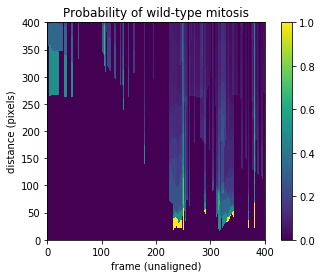

In [67]:
plt.imshow(probability, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,400)
plt.xlim(0,400)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (pixels)")
#plt.text(730,-178, "Scr apoptosis -", rotation=90)
plt.title("Probability of wild-type mitosis")
plt.savefig("/home/nathan/data/prob_heatmap_Scr18.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

#### Plot gross number of mitosis heatmap 

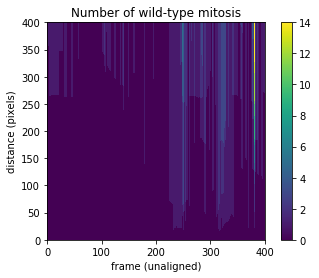

In [68]:
plt.imshow(gross_mitoses, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,400)
plt.xlim(0,400)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
#plt.text(30,-65, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (pixels)")
plt.savefig("/home/nathan/data/number_heatmap_Scr18.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

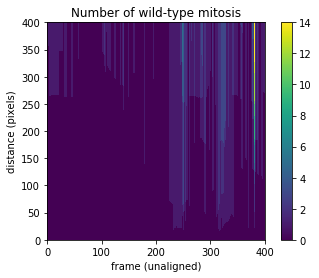

In [69]:
plt.imshow(gross_mitoses, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,400)
plt.xlim(0,400)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
#plt.text(30,-65, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (pixels)")
plt.savefig("/home/nathan/data/number_heatmap_Scr18.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

#### Plot gross number of tracks

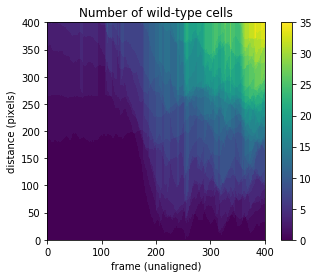

In [71]:
plt.imshow(gross_wt, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,400)
plt.xlim(0,400)
#plt.clim(0,3)
plt.title("Number of wild-type cells")
#plt.text(30,-65, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (pixels)")
plt.savefig("/home/nathan/data/number_wt_heatmap_Scr18.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

# Checking against track data 
#### For checking against raw data see separate notebook

### Find a single probability of wild-type mitosis dependent on radius and delta_t (from apoptosis time)

In [61]:
radius = 3000
delta_t = 0 # time shift wrt apoptosis time
wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
print("Probability of wild-type mitosis at", radius, "pixels and", delta_t, "frames away from Scr apoptosis is:", P_mitosis)
print("Number of wild-type mitosis at", radius, "pixels and", delta_t, "frames away from Scr apoptosis is:", len(wt_mitosis_nearby))
print("Number of wild-type cells at", radius, "pixels and", delta_t, "frames away from Scr apoptosis is:", len(wt_tracks_nearby))

Probability of wild-type mitosis at 3000 pixels and 0 frames away from Scr apoptosis is: 0.024464831804281346
Number of wild-type mitosis at 3000 pixels and 0 frames away from Scr apoptosis is: 8
Number of wild-type cells at 3000 pixels and 0 frames away from Scr apoptosis is: 327


In [46]:
[t.ID for t in nearby]

[316, 720, 353, 751, 762, 336, 849, 407, 721, 932]

In [53]:
nearby[0]

OrderedDict([('ID', 316), ('t', [425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630]), ('x', [613.3501586914062, 613.2664184570312, 618.0716552734375, 617.3175659179688, 613.9470825195312, 615.9024658203125, 616.4468994140625, 617.0701293945312, 617.1444091796875, 618.2703857421875, 617.8021850585938, 618.1641845703125, 618.412109375, 621.9853515625, 623.17822265625, 621.8369140625, 622.6131591796875, 623.7326049804688, 624.6982421875, 625.6687622070312, 627.4201049804688, 628.1077270507812, 626.2319946289062, 624.9830932617188, 622.3403930664062, 620.9586181640625, 617.9096069335938, 617.2288818359375, 616.8914794921875, 617.7445068359375, 619.8114624023438, 623.032470703125, 624.5486450195312, 624.886962890625, 626.5894165039062, 628.0184326171875, 630.0338745117188, 631.4584350585938, 632.3048095703125, 633.06201171875, 632.0735473632812, 632.4326782226562, 632.476318359375, 633.4046020507812, 635.3424682617188, 636.8976440429688, 637.8453369140625, 639.060302734375, 639.3436889648438, 640.1016845703125, 641.2449951171875, 641.282470703125, 640.9261474609375, 641.01123046875, 640.5032958984375, 639.5127563476562, 639.0032958984375, 638.9641723632812, 639.1017456054688, 638.0253295898438, 637.5184936523438, 637.557373046875, 636.4405517578125, 635.9777221679688, 635.9705200195312, 635.5103149414062, 635.2347412109375, 635.2277221679688, 634.0097045898438, 633.7293701171875, 633.3304443359375, 632.8676147460938, 631.4971923828125, 631.3029174804688, 630.7623901367188, 629.0419311523438, 627.9385986328125, 627.77197265625, 626.4613647460938, 624.3893432617188, 622.6903076171875, 621.6560668945312, 621.9882202148438, 621.5916748046875, 621.2330932617188, 621.5219116210938, 621.4607543945312, 621.5159301757812, 620.8161010742188, 621.7765502929688, 621.6622314453125, 622.2052612304688, 621.9127807617188, 621.85009765625, 621.0586547851562, 619.3805541992188, 618.1723022460938, 616.5179443359375, 616.2344360351562, 614.052490234375, 612.17431640625, 610.8267822265625, 608.870849609375, 606.8832397460938, 603.879150390625, 603.3926391601562, 602.8720092773438, 606.07568359375, 605.9336547851562, 607.7921752929688, 609.5623779296875, 609.3416137695312, 610.9380493164062, 611.3883666992188, 612.50244140625, 613.8692016601562, 614.4705810546875, 615.5067749023438, 618.1100463867188, 620.7199096679688, 621.78955078125, 623.535888671875, 624.5, 625.6915283203125, 627.7686767578125, 629.853271484375, 632.0496215820312, 632.7537841796875, 634.5718383789062, 635.5413208007812, 636.4544677734375, 636.927734375, 635.889892578125, 636.3369750976562, 635.2931518554688, 633.869140625, 633.6163940429688, 633.7701416015625, 634.1721801757812, 634.3374633789062, 634.1527709960938, 639.2293701171875, 643.3330688476562, 646.96923828125, 649.005126953125, 650.010009765625, 644.9736328125, 643.8098754882812, 639.3477172851562, 634.4503784179688, 629.4825439453125, 625.2030029296875, 622.9802856445312, 620.0045166015625, 618.066650390625, 616.385498046875, 615.2138671875, 614.6875, 614.402526

In [50]:
print("xyt of target apoptosis")
target_track.x[apop_index], target_track.y[apop_index], find_apoptosis_time(target_track, index = False)

xyt of target apoptosis


(550.5511474609375, 1089.223876953125, 730)

# display tracks

In [54]:
import matplotlib.pyplot as plt

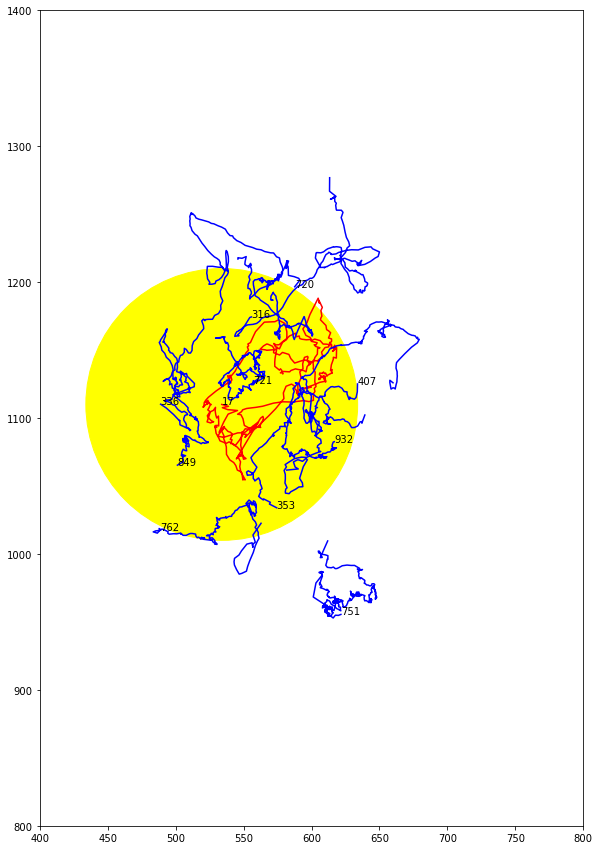

In [67]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 100,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.ylim(800,1400)
plt.xlim(400, 800)
figure.set_size_inches(15, 15)
plt.show()

### example of delta_t 100 and radius 500

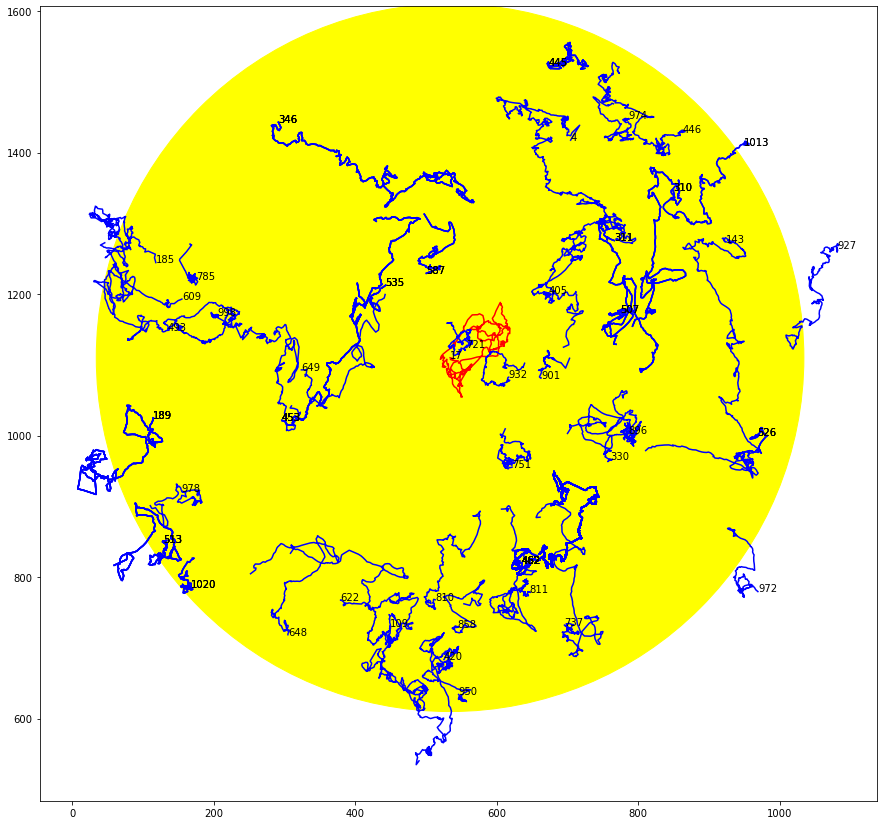

In [21]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 500,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
# plt.xlim(0,1200)
# plt.ylim(0,1200)
figure.set_size_inches(15, 15)
plt.show()

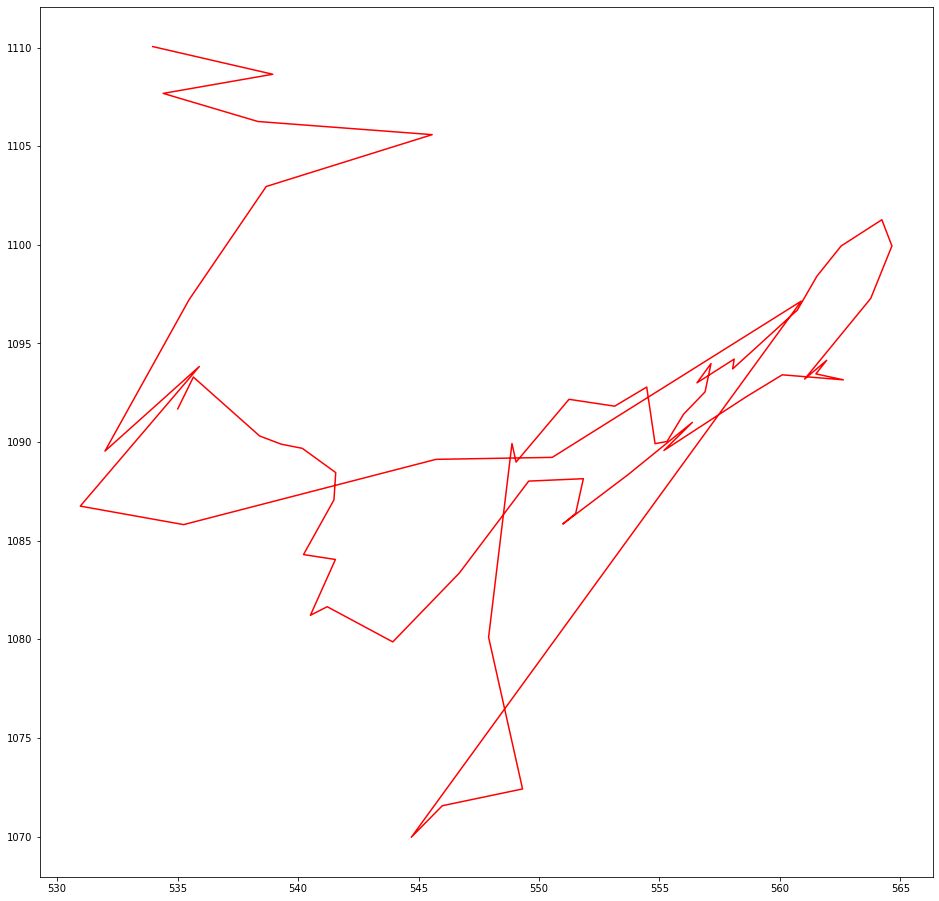

In [57]:
plt.figure(figsize=(16,16))
plt.plot(target_track.x[apop_index-50: apop_index+50], target_track.y[apop_index-50: apop_index+50], 'r-')
# for track in nearby:
#     plt.plot(track.x, track.y, 'b-')
# for mitosis in nearby_mitosis:
#     plt.plot(mitosis.x, mitosis.y, 'g-')


plt.show()

###### misc